In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis
import shap
from joblib import Parallel, delayed
from joblib import parallel_backend
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
#knn
def compute_shap_values(model, data, num_cores):
    explainer = shap.KernelExplainer(model.predict, data)
    shap_values = Parallel(n_jobs=num_cores)(delayed(explainer.shap_values)(instance) for instance in data)
    return np.array(shap_values)


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [3]:
df = pd.read_csv("data_resampled_40.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6.000000,148.000000,72.000000,35.000000,206.846154,33.600000,0.627000,50.000000,1
1,1.000000,85.000000,66.000000,29.000000,130.287879,26.600000,0.351000,31.000000,0
2,8.000000,183.000000,64.000000,33.000000,206.846154,23.300000,0.672000,32.000000,1
3,1.000000,89.000000,66.000000,23.000000,94.000000,28.100000,0.167000,21.000000,0
4,0.000000,137.000000,40.000000,35.000000,168.000000,43.100000,1.205000,33.000000,1
...,...,...,...,...,...,...,...,...,...
839,2.994815,88.958521,73.989630,15.994815,84.953336,30.398445,0.550979,37.932597,0
840,3.767366,103.372106,69.721056,27.235457,130.287879,22.104577,0.372911,28.255789,0
841,0.582822,84.000000,80.057260,31.194274,126.027297,38.005726,0.239605,23.971370,0
842,0.141882,118.716236,65.858118,26.645295,130.287879,38.232473,0.270492,21.929059,0


### 4.1.3 Cross Vallidation

In [4]:
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)


## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [5]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [6]:
def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))

## Modelling and shap 

[I 2024-08-26 14:37:02,480] A new study created in memory with name: KNN
[I 2024-08-26 14:37:03,166] Trial 5 finished with value: 0.7593518778502597 and parameters: {'n_neighbors': 79, 'weights': 'distance', 'metric': 'manhattan', 'p': 27, 'algorithm': 'ball_tree', 'leaf_size': 33}. Best is trial 5 with value: 0.7593518778502597.
[I 2024-08-26 14:37:03,200] Trial 4 finished with value: 0.7838547460942101 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'manhattan', 'p': 1, 'algorithm': 'brute', 'leaf_size': 70}. Best is trial 4 with value: 0.7838547460942101.
[I 2024-08-26 14:37:03,608] Trial 3 finished with value: 0.7260215728880743 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'minkowski', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 26}. Best is trial 4 with value: 0.7838547460942101.
[I 2024-08-26 14:37:03,712] Trial 0 finished with value: 0.7776884276144785 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'euclidean', '

Best trial: 7
Best accuracy: 0.794183618178076
Best hyperparameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'brute', 'leaf_size': 84}
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100



[I 2024-08-26 14:37:34,644] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050024  0.055929       0.010143       0.047595  0.097048  0.003976   
1      0.008821  0.048917       0.002012       0.078250  0.204298  0.015893   
2      0.024202  0.052821       0.008583       0.277869  0.083202  0.178274   
3      0.014000  0.023048       0.003857       0.019571  0.215000  0.026381   
4      0.028083  0.046440       0.005345       0.058679  0.145417  0.009464   
..          ...       ...            ...            ...       ...       ...   
95     0.068893  0.232940       0.000512       0.106250  0.291155  0.030083   
96     0.012179  0.031845       0.004440       0.073250  0.186321  0.010964   
97     0.314452  0.040071       0.011357       0.182810  0.268810  0.017881   
98     0.202679  0.076488       0.007369       0.174536  0.295964  0.044679   
99     0.053679  0.039893       0.005845       0.081655  0.140560  0.060917   

         DPF       Age  Outcome  
0   0.002881  0.0

[I 2024-08-26 14:37:35,539] Trial 0 finished with value: 0.8003720259467876 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'manhattan', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 87}. Best is trial 0 with value: 0.8003720259467876.
[I 2024-08-26 14:37:35,683] Trial 3 finished with value: 0.8127959139755977 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'manhattan', 'p': 32, 'algorithm': 'ball_tree', 'leaf_size': 48}. Best is trial 3 with value: 0.8127959139755977.
[I 2024-08-26 14:37:35,735] Trial 2 finished with value: 0.7662608033101194 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 27, 'algorithm': 'kd_tree', 'leaf_size': 81}. Best is trial 3 with value: 0.8127959139755977.
[I 2024-08-26 14:37:35,756] Trial 5 finished with value: 0.7202652516645515 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'euclidean', 'p': 43, 'algorithm': 'ball_tree', 'leaf_size': 37}. Best is trial 3 w

Best trial: 3
Best accuracy: 0.8127959139755977
Best hyperparameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'manhattan', 'p': 32, 'algorithm': 'ball_tree', 'leaf_size': 48}
              precision    recall  f1-score   support

           0       0.70      0.94      0.80        50
           1       0.91      0.60      0.72        50

    accuracy                           0.77       100
   macro avg       0.81      0.77      0.76       100
weighted avg       0.81      0.77      0.76       100



[I 2024-08-26 14:37:52,789] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047845  0.053464       0.010988       0.046655  0.107917  0.008083   
1      0.001750  0.053917       0.003060       0.071369  0.227036  0.010964   
2      0.014655  0.081964       0.013345       0.275155  0.103083  0.199417   
3      0.005905  0.015262       0.008952       0.007190  0.288738  0.023119   
4      0.025810  0.046167       0.006143       0.060857  0.174381  0.014190   
..          ...       ...            ...            ...       ...       ...   
95     0.114548  0.219095       0.013000       0.079905  0.315833  0.017429   
96     0.014202  0.039369       0.001750       0.069750  0.191155  0.010179   
97     0.283393  0.040655       0.003417       0.176083  0.299869  0.001702   
98     0.161190  0.058333       0.012667       0.146000  0.329714  0.036738   
99     0.050964  0.044726       0.007060       0.082036  0.148012  0.085202   

         DPF       Age  Outcome  
0   0.006845  0.0

[I 2024-08-26 14:37:53,414] Trial 2 finished with value: 0.8078959852698361 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'ball_tree', 'leaf_size': 11}. Best is trial 2 with value: 0.8078959852698361.
[I 2024-08-26 14:37:53,534] Trial 4 finished with value: 0.8037252297799827 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'manhattan', 'p': 29, 'algorithm': 'auto', 'leaf_size': 73}. Best is trial 2 with value: 0.8078959852698361.
[I 2024-08-26 14:37:53,870] Trial 1 finished with value: 0.8118514012813116 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 8}. Best is trial 1 with value: 0.8118514012813116.
[I 2024-08-26 14:37:54,092] Trial 6 finished with value: 0.7889672226820659 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'p': 3, 'algorithm': 'ball_tree', 'leaf_size': 29}. Best is trial 1 with 

Best trial: 1
Best accuracy: 0.8118514012813116
Best hyperparameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 8}
              precision    recall  f1-score   support

           0       0.71      0.90      0.80        50
           1       0.86      0.64      0.74        50

    accuracy                           0.77       100
   macro avg       0.79      0.77      0.77       100
weighted avg       0.79      0.77      0.77       100



[I 2024-08-26 14:38:11,106] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051250  0.054821       0.016345       0.043607  0.120321  0.014083   
1      0.014869  0.050750       0.001679       0.061845  0.290250  0.019131   
2      0.131762  0.026048       0.115905       0.147524  0.327810  0.081452   
3      0.001655  0.025440       0.001702       0.003917  0.321940  0.025631   
4      0.016369  0.049107       0.002321       0.060298  0.197940  0.008750   
..          ...       ...            ...            ...       ...       ...   
95     0.012393  0.057821       0.147131       0.092726  0.224583  0.151560   
96     0.010286  0.051310       0.001429       0.065619  0.196286  0.003524   
97     0.223833  0.033857       0.003643       0.092071  0.336286  0.023643   
98     0.197214  0.053286       0.006310       0.078286  0.364786  0.011381   
99     0.034500  0.092619       0.010714       0.048429  0.187262  0.192929   

         DPF       Age  Outcome  
0   0.014583  0.0

[I 2024-08-26 14:38:12,080] Trial 3 finished with value: 0.7172530505558374 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'minkowski', 'p': 48, 'algorithm': 'auto', 'leaf_size': 66}. Best is trial 3 with value: 0.7172530505558374.
[I 2024-08-26 14:38:12,130] Trial 1 finished with value: 0.7683566277975724 and parameters: {'n_neighbors': 54, 'weights': 'uniform', 'metric': 'manhattan', 'p': 11, 'algorithm': 'brute', 'leaf_size': 31}. Best is trial 1 with value: 0.7683566277975724.
[I 2024-08-26 14:38:12,163] Trial 0 finished with value: 0.791869697832441 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'euclidean', 'p': 2, 'algorithm': 'brute', 'leaf_size': 46}. Best is trial 0 with value: 0.791869697832441.
[I 2024-08-26 14:38:12,302] Trial 5 finished with value: 0.7314990434608732 and parameters: {'n_neighbors': 56, 'weights': 'uniform', 'metric': 'euclidean', 'p': 11, 'algorithm': 'brute', 'leaf_size': 70}. Best is trial 0 with value: 0.79186

Best trial: 8
Best accuracy: 0.8051321618877703
Best hyperparameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 34, 'algorithm': 'auto', 'leaf_size': 13}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 14:38:30,405] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047702  0.052345       0.010893       0.046488  0.106536  0.006869   
1      0.002107  0.051155       0.002060       0.072321  0.220155  0.011345   
2      0.014762  0.074310       0.013690       0.269929  0.096905  0.193024   
3      0.006655  0.017440       0.008488       0.008869  0.277393  0.020536   
4      0.023833  0.049310       0.003619       0.058333  0.162048  0.010738   
..          ...       ...            ...            ...       ...       ...   
95     0.127238  0.224000       0.006119       0.057762  0.309595  0.020667   
96     0.015286  0.037881       0.006429       0.070262  0.192976  0.011833   
97     0.298536  0.041036       0.005536       0.182940  0.289202  0.001083   
98     0.165286  0.060143       0.010810       0.159690  0.316786  0.034095   
99     0.052940  0.045107       0.004607       0.080893  0.146179  0.077464   

         DPF       Age  Outcome  
0   0.004012  0.0

[I 2024-08-26 14:38:31,063] Trial 4 finished with value: 0.8165228198182091 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 29}. Best is trial 4 with value: 0.8165228198182091.
[I 2024-08-26 14:38:31,247] Trial 5 finished with value: 0.7911666881195221 and parameters: {'n_neighbors': 55, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'kd_tree', 'leaf_size': 19}. Best is trial 4 with value: 0.8165228198182091.
[I 2024-08-26 14:38:31,343] Trial 0 finished with value: 0.7559158523062139 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'auto', 'leaf_size': 19}. Best is trial 4 with value: 0.8165228198182091.
[I 2024-08-26 14:38:31,836] Trial 6 finished with value: 0.8187275461722143 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 100}. Best is trial 6 wit

Best trial: 6
Best accuracy: 0.8187275461722143
Best hyperparameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 100}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 14:38:40,468] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046167  0.049333       0.012905       0.048714  0.111619  0.012381   
1      0.004298  0.046250       0.010750       0.065393  0.275060  0.018321   
2      0.006036  0.088726       0.012798       0.287298  0.117369  0.201131   
3      0.002774  0.020298       0.010179       0.001560  0.306560  0.021107   
4      0.019345  0.043250       0.006202       0.063107  0.186393  0.013345   
..          ...       ...            ...            ...       ...       ...   
95     0.113214  0.207690       0.022714       0.082095  0.327262  0.013310   
96     0.008179  0.041655       0.001488       0.063607  0.195655  0.010202   
97     0.227440  0.035988       0.000226       0.184107  0.317298  0.005369   
98     0.163786  0.048048       0.017024       0.105738  0.347262  0.034595   
99     0.047667  0.057762       0.011738       0.079357  0.145429  0.125119   

         DPF       Age  Outcome  
0   0.009952  0.0

[I 2024-08-26 14:38:41,157] Trial 5 finished with value: 0.7822699738138641 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'kd_tree', 'leaf_size': 62}. Best is trial 5 with value: 0.7822699738138641.
[I 2024-08-26 14:38:41,474] Trial 2 finished with value: 0.7502601461950675 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'minkowski', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 14}. Best is trial 5 with value: 0.7822699738138641.
[I 2024-08-26 14:38:41,810] Trial 3 finished with value: 0.7245960365428569 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'minkowski', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 11}. Best is trial 5 with value: 0.7822699738138641.
[I 2024-08-26 14:38:41,846] Trial 4 finished with value: 0.6368349933368169 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'minkowski', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 81}. Best is trial 5 w

Best trial: 5
Best accuracy: 0.7822699738138641
Best hyperparameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'kd_tree', 'leaf_size': 62}
              precision    recall  f1-score   support

           0       0.69      0.96      0.80        50
           1       0.93      0.56      0.70        50

    accuracy                           0.76       100
   macro avg       0.81      0.76      0.75       100
weighted avg       0.81      0.76      0.75       100



[I 2024-08-26 14:38:53,119] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041167  0.064119       0.012190       0.041333  0.089762  0.010214   
1      0.000690  0.052286       0.004976       0.077119  0.212190  0.014738   
2      0.022917  0.056798       0.005750       0.244607  0.074702  0.166607   
3      0.015595  0.026548       0.001595       0.018857  0.190024  0.031952   
4      0.021143  0.053071       0.000762       0.057810  0.131048  0.005643   
..          ...       ...            ...            ...       ...       ...   
95     0.069250  0.253321       0.000583       0.058250  0.282869  0.054750   
96     0.007595  0.027857       0.005214       0.073333  0.184381  0.013286   
97     0.309881  0.034500       0.022310       0.184095  0.243833  0.030595   
98     0.276393  0.100321       0.010369       0.170679  0.264702  0.046845   
99     0.051810  0.045476       0.005429       0.081262  0.139381  0.061833   

         DPF       Age  Outcome  
0   0.003881  0.0

[I 2024-08-26 14:38:53,941] Trial 1 finished with value: 0.733359412481863 and parameters: {'n_neighbors': 83, 'weights': 'distance', 'metric': 'minkowski', 'p': 2, 'algorithm': 'brute', 'leaf_size': 45}. Best is trial 1 with value: 0.733359412481863.
[I 2024-08-26 14:38:54,042] Trial 4 finished with value: 0.8035618536152894 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'ball_tree', 'leaf_size': 73}. Best is trial 4 with value: 0.8035618536152894.
[I 2024-08-26 14:38:54,230] Trial 2 finished with value: 0.7470284433808877 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'minkowski', 'p': 5, 'algorithm': 'auto', 'leaf_size': 52}. Best is trial 4 with value: 0.8035618536152894.
[I 2024-08-26 14:38:54,266] Trial 0 finished with value: 0.6907579636818447 and parameters: {'n_neighbors': 99, 'weights': 'uniform', 'metric': 'euclidean', 'p': 27, 'algorithm': 'auto', 'leaf_size': 75}. Best is trial 4 with value: 0.803

Best trial: 4
Best accuracy: 0.8035618536152894
Best hyperparameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'ball_tree', 'leaf_size': 73}
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        50
           1       0.89      0.62      0.73        50

    accuracy                           0.77       100
   macro avg       0.80      0.77      0.76       100
weighted avg       0.80      0.77      0.76       100



[I 2024-08-26 14:39:11,135] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047095  0.052714       0.016738       0.048167  0.111452  0.011548   
1      0.006262  0.048476       0.001381       0.070833  0.261095  0.020262   
2      0.131833  0.006357       0.139952       0.176548  0.272238  0.095738   
3      0.003917  0.024655       0.005679       0.005179  0.303655  0.029131   
4      0.019369  0.044702       0.006274       0.063440  0.182107  0.013274   
..          ...       ...            ...            ...       ...       ...   
95     0.012369  0.051131       0.108488       0.065060  0.201298  0.161202   
96     0.005774  0.043250       0.003440       0.069440  0.186964  0.011250   
97     0.237869  0.026631       0.008131       0.099583  0.323869  0.027821   
98     0.192679  0.060036       0.005917       0.133869  0.342940  0.021250   
99     0.035369  0.072274       0.006464       0.054940  0.182536  0.143655   

         DPF       Age  Outcome  
0   0.011310  0.0

[I 2024-08-26 14:39:12,162] Trial 2 finished with value: 0.807265505205419 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 60}. Best is trial 2 with value: 0.807265505205419.
[I 2024-08-26 14:39:12,266] Trial 5 finished with value: 0.8035618536152894 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan', 'p': 28, 'algorithm': 'ball_tree', 'leaf_size': 81}. Best is trial 2 with value: 0.807265505205419.
[I 2024-08-26 14:39:12,377] Trial 3 finished with value: 0.7539442680489585 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 38}. Best is trial 2 with value: 0.807265505205419.
[I 2024-08-26 14:39:12,407] Trial 4 finished with value: 0.7580709624258216 and parameters: {'n_neighbors': 83, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'ball_tree', 'leaf_size': 27}. Best is trial 2 wit

Best trial: 9
Best accuracy: 0.8148370924294188
Best hyperparameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'manhattan', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 27}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 14:39:22,440] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050321  0.050917       0.010250       0.048226  0.103750  0.007298   
1      0.001810  0.047714       0.005786       0.071762  0.252167  0.019810   
2      0.024881  0.076095       0.012381       0.279214  0.096571  0.202357   
3      0.012714  0.023071       0.007357       0.016714  0.245452  0.026000   
4      0.027452  0.047286       0.007929       0.060738  0.161476  0.011952   
..          ...       ...            ...            ...       ...       ...   
95     0.131857  0.222571       0.010595       0.073548  0.298310  0.017190   
96     0.011226  0.034321       0.003726       0.069631  0.193560  0.011274   
97     0.281750  0.040893       0.007155       0.181083  0.285250  0.013060   
98     0.173690  0.059524       0.013214       0.142548  0.318143  0.040119   
99     0.053940  0.048345       0.004679       0.082940  0.143012  0.075798   

         DPF       Age  Outcome  
0   0.004440  0.0

[I 2024-08-26 14:39:23,212] Trial 5 finished with value: 0.8091954083304809 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 37}. Best is trial 5 with value: 0.8091954083304809.
[I 2024-08-26 14:39:23,231] Trial 4 finished with value: 0.7697385631794244 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'metric': 'euclidean', 'p': 7, 'algorithm': 'ball_tree', 'leaf_size': 69}. Best is trial 5 with value: 0.8091954083304809.
[I 2024-08-26 14:39:23,791] Trial 1 finished with value: 0.6837775244721623 and parameters: {'n_neighbors': 63, 'weights': 'distance', 'metric': 'minkowski', 'p': 12, 'algorithm': 'auto', 'leaf_size': 27}. Best is trial 5 with value: 0.8091954083304809.
[I 2024-08-26 14:39:23,813] Trial 2 finished with value: 0.6945911198724959 and parameters: {'n_neighbors': 60, 'weights': 'distance', 'metric': 'minkowski', 'p': 8, 'algorithm': 'kd_tree', 'leaf_size': 45}. Best is trial 5 with 

Best trial: 5
Best accuracy: 0.8091954083304809
Best hyperparameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 37}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 14:39:34,835] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047405  0.050738       0.010786       0.050643  0.101714  0.011452   
1      0.002452  0.048286       0.001643       0.076500  0.225119  0.015714   
2      0.028571  0.063190       0.009714       0.279833  0.093000  0.203500   
3      0.001417  0.021083       0.009607       0.011845  0.277583  0.019988   
4      0.023381  0.046619       0.004833       0.060571  0.153500  0.008714   
..          ...       ...            ...            ...       ...       ...   
95     0.089143  0.226071       0.004238       0.069119  0.300310  0.020976   
96     0.010786  0.032976       0.004095       0.072976  0.191619  0.010690   
97     0.291881  0.038000       0.008429       0.178524  0.280048  0.014929   
98     0.196726  0.066869       0.010798       0.150250  0.308512  0.038250   
99     0.051893  0.042250       0.005917       0.084869  0.140893  0.065036   

         DPF       Age  Outcome  
0   0.004500  0.0

[I 2024-08-26 14:39:35,699] Trial 3 finished with value: 0.7549475083996352 and parameters: {'n_neighbors': 60, 'weights': 'distance', 'metric': 'euclidean', 'p': 3, 'algorithm': 'ball_tree', 'leaf_size': 76}. Best is trial 3 with value: 0.7549475083996352.
[I 2024-08-26 14:39:35,730] Trial 5 finished with value: 0.8091954083304809 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'manhattan', 'p': 49, 'algorithm': 'brute', 'leaf_size': 97}. Best is trial 5 with value: 0.8091954083304809.
[I 2024-08-26 14:39:35,768] Trial 2 finished with value: 0.7636560060045903 and parameters: {'n_neighbors': 76, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'ball_tree', 'leaf_size': 70}. Best is trial 5 with value: 0.8091954083304809.
[I 2024-08-26 14:39:35,779] Trial 1 finished with value: 0.7539442680489585 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'algorithm': 'auto', 'leaf_size': 13}. Best is trial 5 with val

Best trial: 6
Best accuracy: 0.8173595932548714
Best hyperparameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'p': 49, 'algorithm': 'brute', 'leaf_size': 87}
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        50
           1       0.86      0.62      0.72        50

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100



[I 2024-08-26 14:39:47,449] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048714  0.053571       0.016881       0.041810  0.120571  0.011905   
1      0.014738  0.047786       0.000857       0.058119  0.291262  0.020000   
2      0.132464  0.022774       0.114417       0.146964  0.328512  0.079917   
3      0.002976  0.023857       0.002833       0.002452  0.323476  0.022048   
4      0.015655  0.047774       0.002417       0.058440  0.199202  0.013107   
..          ...       ...            ...            ...       ...       ...   
95     0.009810  0.054643       0.144381       0.093476  0.228643  0.151548   
96     0.007679  0.048250       0.002917       0.064964  0.196060  0.003631   
97     0.224262  0.033214       0.003738       0.092143  0.338262  0.025286   
98     0.197929  0.052357       0.007738       0.079643  0.366952  0.015643   
99     0.027060  0.100988       0.019488       0.038250  0.187988  0.227083   

         DPF       Age  Outcome  
0   0.012738  0.0

[I 2024-08-26 14:39:48,259] Trial 0 finished with value: 0.8196415893932497 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 15}. Best is trial 0 with value: 0.8196415893932497.
[I 2024-08-26 14:39:48,546] Trial 1 finished with value: 0.8043527898431061 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'euclidean', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 68}. Best is trial 0 with value: 0.8196415893932497.
[I 2024-08-26 14:39:48,875] Trial 5 finished with value: 0.6814098618468942 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'minkowski', 'p': 31, 'algorithm': 'auto', 'leaf_size': 18}. Best is trial 0 with value: 0.8196415893932497.
[I 2024-08-26 14:39:48,950] Trial 2 finished with value: 0.76449267030179 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski', 'p': 24, 'algorithm': 'kd_tree', 'leaf_size': 89}. Best is trial 0 with value:

Best trial: 0
Best accuracy: 0.8196415893932497
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 15}
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        50
           1       0.86      0.62      0.72        50

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100



[I 2024-08-26 14:39:56,484] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032417  0.062083       0.023893       0.036869  0.125250  0.014988   
1      0.006536  0.070726       0.009131       0.059726  0.249202  0.015536   
2      0.063393  0.001226       0.089321       0.120393  0.326702  0.046012   
3      0.003560  0.029250       0.014393       0.007298  0.313250  0.028869   
4      0.011155  0.060869       0.002107       0.059440  0.199988  0.013274   
..          ...       ...            ...            ...       ...       ...   
95     0.003810  0.028667       0.105190       0.139833  0.202333  0.153357   
96     0.016536  0.049774       0.014726       0.056393  0.194940  0.009679   
97     0.206619  0.029690       0.019000       0.113881  0.279381  0.023143   
98     0.167179  0.055726       0.042464       0.084417  0.368512  0.014250   
99     0.002119  0.350833       0.127310       0.186976  0.073500  0.101500   

         DPF       Age  Outcome  
0   0.012655  0.0

[I 2024-08-26 14:39:57,248] Trial 2 finished with value: 0.7645712345299859 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'euclidean', 'p': 38, 'algorithm': 'auto', 'leaf_size': 28}. Best is trial 2 with value: 0.7645712345299859.
[I 2024-08-26 14:39:57,313] Trial 5 finished with value: 0.7559158523062139 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 70}. Best is trial 2 with value: 0.7645712345299859.
[I 2024-08-26 14:39:57,353] Trial 4 finished with value: 0.7428774447564109 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'brute', 'leaf_size': 24}. Best is trial 2 with value: 0.7645712345299859.
[I 2024-08-26 14:39:57,962] Trial 6 finished with value: 0.8152151782061753 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'auto', 'leaf_size': 17}. Best is trial 6 with value: 0

Best trial: 6
Best accuracy: 0.8152151782061753
Best hyperparameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'auto', 'leaf_size': 17}
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100



[I 2024-08-26 14:40:08,457] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046667  0.049738       0.010048       0.045190  0.102810  0.004905   
1      0.005036  0.048036       0.005155       0.068226  0.235988  0.015607   
2      0.015893  0.075988       0.014726       0.279560  0.106107  0.196512   
3      0.002714  0.015643       0.010833       0.003429  0.294048  0.017238   
4      0.020988  0.044679       0.005655       0.059440  0.168107  0.014298   
..          ...       ...            ...            ...       ...       ...   
95     0.142631  0.218845       0.005750       0.050940  0.313012  0.018274   
96     0.013643  0.034405       0.007048       0.068857  0.189595  0.012595   
97     0.284845  0.039131       0.007464       0.181917  0.294702  0.003917   
98     0.167869  0.050417       0.018988       0.129345  0.329631  0.038321   
99     0.052357  0.047071       0.007190       0.076286  0.143548  0.079810   

         DPF       Age  Outcome  
0   0.002833  0.0

[I 2024-08-26 14:40:09,446] Trial 3 finished with value: 0.7917392193313956 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'euclidean', 'p': 13, 'algorithm': 'auto', 'leaf_size': 25}. Best is trial 3 with value: 0.7917392193313956.
[I 2024-08-26 14:40:09,467] Trial 2 finished with value: 0.7738507495862035 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'euclidean', 'p': 45, 'algorithm': 'auto', 'leaf_size': 19}. Best is trial 3 with value: 0.7917392193313956.
[I 2024-08-26 14:40:09,561] Trial 1 finished with value: 0.7744377135946635 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'kd_tree', 'leaf_size': 40}. Best is trial 3 with value: 0.7917392193313956.
[I 2024-08-26 14:40:09,572] Trial 5 finished with value: 0.7554713677531236 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'metric': 'euclidean', 'p': 32, 'algorithm': 'kd_tree', 'leaf_size': 78}. Best is trial 3 with value: 

Best trial: 3
Best accuracy: 0.7917392193313956
Best hyperparameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'euclidean', 'p': 13, 'algorithm': 'auto', 'leaf_size': 25}
              precision    recall  f1-score   support

           0       0.65      0.90      0.76        50
           1       0.84      0.52      0.64        50

    accuracy                           0.71       100
   macro avg       0.75      0.71      0.70       100
weighted avg       0.75      0.71      0.70       100



[I 2024-08-26 14:40:28,625] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043274  0.069798       0.007250       0.024869  0.095274  0.015845   
1      0.005679  0.087798       0.001440       0.040869  0.189393  0.024345   
2      0.025869  0.108821       0.007988       0.342369  0.329821  0.277774   
3      0.016071  0.027929       0.000024       0.002119  0.167071  0.034048   
4      0.025024  0.087048       0.004571       0.024048  0.123810  0.002524   
..          ...       ...            ...            ...       ...       ...   
95     0.018631  0.260940       0.002631       0.160536  0.266821  0.054917   
96     0.006976  0.067476       0.008048       0.072429  0.138738  0.016881   
97     0.334000  0.043167       0.024619       0.208000  0.222952  0.011833   
98     0.163833  0.123667       0.063500       0.127524  0.209381  0.080190   
99     0.052155  0.053202       0.005893       0.097536  0.081893  0.100393   

         DPF       Age  Outcome  
0   0.006512  0.0

[I 2024-08-26 14:40:29,437] Trial 0 finished with value: 0.8152151782061753 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 64}. Best is trial 0 with value: 0.8152151782061753.
[I 2024-08-26 14:40:29,524] Trial 3 finished with value: 0.7718930273830265 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 69}. Best is trial 0 with value: 0.8152151782061753.
[I 2024-08-26 14:40:29,858] Trial 4 finished with value: 0.7684314275158254 and parameters: {'n_neighbors': 56, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 74}. Best is trial 0 with value: 0.8152151782061753.
[I 2024-08-26 14:40:29,946] Trial 1 finished with value: 0.7137294577876477 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'minkowski', 'p': 45, 'algorithm': 'ball_tree', 'leaf_size': 75}. Best is trial 0 with va

Best trial: 0
Best accuracy: 0.8152151782061753
Best hyperparameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 64}
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100



[I 2024-08-26 14:40:39,537] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046667  0.049738       0.010048       0.045190  0.102810  0.004905   
1      0.005036  0.048036       0.005155       0.068226  0.235988  0.015607   
2      0.015893  0.075988       0.014726       0.279560  0.106107  0.196512   
3      0.002714  0.015643       0.010833       0.003429  0.294048  0.017238   
4      0.020988  0.044679       0.005655       0.059440  0.168107  0.014298   
..          ...       ...            ...            ...       ...       ...   
95     0.142631  0.218845       0.005750       0.050940  0.313012  0.018274   
96     0.013643  0.034405       0.007048       0.068857  0.189595  0.012595   
97     0.284845  0.039131       0.007464       0.181917  0.294702  0.003917   
98     0.167869  0.050417       0.018988       0.129345  0.329631  0.038321   
99     0.052357  0.047071       0.007190       0.076286  0.143548  0.079810   

         DPF       Age  Outcome  
0   0.002833  0.0

[I 2024-08-26 14:40:40,333] Trial 3 finished with value: 0.8003124246098494 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'euclidean', 'p': 6, 'algorithm': 'auto', 'leaf_size': 40}. Best is trial 3 with value: 0.8003124246098494.
[I 2024-08-26 14:40:40,545] Trial 4 finished with value: 0.8046244899525911 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'p': 47, 'algorithm': 'kd_tree', 'leaf_size': 9}. Best is trial 4 with value: 0.8046244899525911.
[I 2024-08-26 14:40:40,635] Trial 5 finished with value: 0.7476628413611731 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'auto', 'leaf_size': 42}. Best is trial 4 with value: 0.8046244899525911.
[I 2024-08-26 14:40:40,655] Trial 0 finished with value: 0.7904964717706303 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'metric': 'manhattan', 'p': 28, 'algorithm': 'ball_tree', 'leaf_size': 13}. Best is trial 4 with value: 0

Best trial: 4
Best accuracy: 0.8046244899525911
Best hyperparameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'p': 47, 'algorithm': 'kd_tree', 'leaf_size': 9}
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        50
           1       0.84      0.64      0.73        50

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100



[I 2024-08-26 14:40:59,544] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046024  0.062595       0.022619       0.044119  0.123143  0.019667   
1      0.000310  0.071333       0.001476       0.065738  0.240833  0.012524   
2      0.079952  0.002619       0.074214       0.134524  0.359238  0.072333   
3      0.004417  0.029726       0.005369       0.004798  0.314726  0.033226   
4      0.006298  0.055750       0.006274       0.053012  0.245655  0.016607   
..          ...       ...            ...            ...       ...       ...   
95     0.001238  0.047048       0.130762       0.122095  0.220667  0.158500   
96     0.004333  0.064190       0.002524       0.060048  0.196262  0.006429   
97     0.190631  0.038655       0.004893       0.101060  0.324512  0.023417   
98     0.179607  0.057964       0.015655       0.081702  0.369798  0.015083   
99     0.010036  0.305607       0.169655       0.173655  0.103488  0.135845   

         DPF       Age  Outcome  
0   0.013524  0.0

[I 2024-08-26 14:41:00,368] Trial 2 finished with value: 0.7958306625631867 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'kd_tree', 'leaf_size': 16}. Best is trial 2 with value: 0.7958306625631867.
[I 2024-08-26 14:41:00,939] Trial 5 finished with value: 0.772825132366078 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean', 'p': 42, 'algorithm': 'brute', 'leaf_size': 76}. Best is trial 2 with value: 0.7958306625631867.
[I 2024-08-26 14:41:00,992] Trial 4 finished with value: 0.8046244899525911 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'p': 7, 'algorithm': 'auto', 'leaf_size': 5}. Best is trial 4 with value: 0.8046244899525911.
[I 2024-08-26 14:41:01,012] Trial 3 finished with value: 0.6730336796631738 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'minkowski', 'p': 14, 'algorithm': 'ball_tree', 'leaf_size': 45}. Best is trial 4 with value: 0.

Best trial: 8
Best accuracy: 0.8231267758875765
Best hyperparameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'auto', 'leaf_size': 77}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 14:41:10,512] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048071  0.049429       0.014167       0.046524  0.110238  0.011190   
1      0.004024  0.044214       0.012952       0.065167  0.284238  0.020786   
2      0.013286  0.086810       0.012405       0.302952  0.114333  0.203333   
3      0.000583  0.019131       0.006702       0.004321  0.305845  0.020250   
4      0.020286  0.042381       0.007143       0.065667  0.185333  0.013571   
..          ...       ...            ...            ...       ...       ...   
95     0.116917  0.202821       0.022155       0.091536  0.323488  0.010536   
96     0.007702  0.040821       0.001036       0.064726  0.192179  0.009012   
97     0.232869  0.032345       0.000298       0.176274  0.316440  0.008036   
98     0.161893  0.052012       0.017345       0.112226  0.339107  0.039774   
99     0.045107  0.054393       0.010893       0.077250  0.146917  0.124393   

         DPF       Age  Outcome  
0   0.009310  0.0

[I 2024-08-26 14:41:11,237] Trial 5 finished with value: 0.8272996068973498 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 29}. Best is trial 5 with value: 0.8272996068973498.
[I 2024-08-26 14:41:11,324] Trial 2 finished with value: 0.8146473698139515 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'kd_tree', 'leaf_size': 13}. Best is trial 5 with value: 0.8272996068973498.
[I 2024-08-26 14:41:11,348] Trial 3 finished with value: 0.7643109644044914 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'euclidean', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 78}. Best is trial 5 with value: 0.8272996068973498.
[I 2024-08-26 14:41:11,959] Trial 7 finished with value: 0.82314299133271 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'manhattan', 'p': 1, 'algorithm': 'auto', 'leaf_size': 96}. Best is trial 5 with value: 0

Best trial: 5
Best accuracy: 0.8272996068973498
Best hyperparameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 29}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 14:41:20,840] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049226  0.047155       0.016083       0.048917  0.115964  0.010321   
1      0.010988  0.047179       0.006464       0.062798  0.285036  0.016512   
2      0.000321  0.110893       0.033131       0.316155  0.149893  0.211583   
3      0.004095  0.024857       0.011714       0.006143  0.312310  0.023810   
4      0.018369  0.045036       0.001917       0.058631  0.190345  0.010726   
..          ...       ...            ...            ...       ...       ...   
95     0.116655  0.205226       0.024798       0.076726  0.326679  0.000369   
96     0.009548  0.045881       0.004857       0.066571  0.198452  0.009357   
97     0.204643  0.033571       0.001714       0.163167  0.329810  0.014595   
98     0.160976  0.046595       0.010952       0.099190  0.356929  0.034667   
99     0.039369  0.067250       0.013655       0.067774  0.142917  0.165155   

         DPF       Age  Outcome  
0   0.011774  0.0

[I 2024-08-26 14:41:21,777] Trial 1 finished with value: 0.7738507495862035 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'euclidean', 'p': 12, 'algorithm': 'kd_tree', 'leaf_size': 80}. Best is trial 1 with value: 0.7738507495862035.
[I 2024-08-26 14:41:21,859] Trial 3 finished with value: 0.8051321618877703 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 3}. Best is trial 3 with value: 0.8051321618877703.
[I 2024-08-26 14:41:21,878] Trial 2 finished with value: 0.8037252297799827 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'manhattan', 'p': 11, 'algorithm': 'brute', 'leaf_size': 18}. Best is trial 3 with value: 0.8051321618877703.
[I 2024-08-26 14:41:22,219] Trial 4 finished with value: 0.7993154691083559 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'minkowski', 'p': 3, 'algorithm': 'auto', 'leaf_size': 30}. Best is trial 3 with value: 0.80

Best trial: 3
Best accuracy: 0.8051321618877703
Best hyperparameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 3}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 14:41:45,250] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047702  0.052345       0.010893       0.046488  0.106536  0.006869   
1      0.002107  0.051155       0.002060       0.072321  0.220155  0.011345   
2      0.014762  0.074310       0.013690       0.269929  0.096905  0.193024   
3      0.006655  0.017440       0.008488       0.008869  0.277393  0.020536   
4      0.023833  0.049310       0.003619       0.058333  0.162048  0.010738   
..          ...       ...            ...            ...       ...       ...   
95     0.127238  0.224000       0.006119       0.057762  0.309595  0.020667   
96     0.015286  0.037881       0.006429       0.070262  0.192976  0.011833   
97     0.298536  0.041036       0.005536       0.182940  0.289202  0.001083   
98     0.165286  0.060143       0.010810       0.159690  0.316786  0.034095   
99     0.052940  0.045107       0.004607       0.080893  0.146179  0.077464   

         DPF       Age  Outcome  
0   0.004012  0.0

[I 2024-08-26 14:41:45,896] Trial 2 finished with value: 0.7697385631794244 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'metric': 'euclidean', 'p': 47, 'algorithm': 'kd_tree', 'leaf_size': 45}. Best is trial 2 with value: 0.7697385631794244.
[I 2024-08-26 14:41:46,075] Trial 0 finished with value: 0.7261089449945313 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'euclidean', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 24}. Best is trial 2 with value: 0.7697385631794244.
[I 2024-08-26 14:41:46,131] Trial 3 finished with value: 0.7308059559158808 and parameters: {'n_neighbors': 85, 'weights': 'distance', 'metric': 'euclidean', 'p': 21, 'algorithm': 'kd_tree', 'leaf_size': 19}. Best is trial 2 with value: 0.7697385631794244.
[I 2024-08-26 14:41:46,405] Trial 4 finished with value: 0.7132114295388292 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'minkowski', 'p': 36, 'algorithm': 'kd_tree', 'leaf_size': 50}. Best is trial 2 with

Best trial: 6
Best accuracy: 0.807375992232711
Best hyperparameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'manhattan', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 55}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 14:42:06,709] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046488  0.051036       0.010202       0.045131  0.106274  0.007012   
1      0.001655  0.052083       0.004702       0.070798  0.225917  0.014440   
2      0.014333  0.075643       0.012429       0.273000  0.097524  0.195357   
3      0.004679  0.016774       0.007345       0.007250  0.281369  0.021298   
4      0.019893  0.047440       0.005488       0.062774  0.169940  0.013488   
..          ...       ...            ...            ...       ...       ...   
95     0.099250  0.222702       0.009560       0.090321  0.312869  0.018417   
96     0.012821  0.036083       0.003083       0.067583  0.191274  0.010821   
97     0.297929  0.042071       0.004190       0.180119  0.291667  0.001810   
98     0.165095  0.059333       0.012214       0.153476  0.322238  0.035714   
99     0.050583  0.045726       0.005464       0.082940  0.148393  0.077393   

         DPF       Age  Outcome  
0   0.006464  0.0

[I 2024-08-26 14:42:07,546] Trial 2 finished with value: 0.8187275461722143 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'p': 24, 'algorithm': 'ball_tree', 'leaf_size': 67}. Best is trial 2 with value: 0.8187275461722143.
[I 2024-08-26 14:42:07,584] Trial 0 finished with value: 0.7680060305098654 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'minkowski', 'p': 39, 'algorithm': 'auto', 'leaf_size': 8}. Best is trial 2 with value: 0.8187275461722143.
[I 2024-08-26 14:42:07,656] Trial 1 finished with value: 0.7698491064369992 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'metric': 'manhattan', 'p': 20, 'algorithm': 'kd_tree', 'leaf_size': 74}. Best is trial 2 with value: 0.8187275461722143.
[I 2024-08-26 14:42:07,675] Trial 4 finished with value: 0.7634913127435007 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'metric': 'manhattan', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 46}. Best is trial 2 with va

Best trial: 2
Best accuracy: 0.8187275461722143
Best hyperparameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'p': 24, 'algorithm': 'ball_tree', 'leaf_size': 67}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 14:42:17,442] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046167  0.049333       0.012905       0.048714  0.111619  0.012381   
1      0.004298  0.046250       0.010750       0.065393  0.275060  0.018321   
2      0.006036  0.088726       0.012798       0.287298  0.117369  0.201131   
3      0.002774  0.020298       0.010179       0.001560  0.306560  0.021107   
4      0.019345  0.043250       0.006202       0.063107  0.186393  0.013345   
..          ...       ...            ...            ...       ...       ...   
95     0.113214  0.207690       0.022714       0.082095  0.327262  0.013310   
96     0.008179  0.041655       0.001488       0.063607  0.195655  0.010202   
97     0.227440  0.035988       0.000226       0.184107  0.317298  0.005369   
98     0.163786  0.048048       0.017024       0.105738  0.347262  0.034595   
99     0.047667  0.057762       0.011738       0.079357  0.145429  0.125119   

         DPF       Age  Outcome  
0   0.009952  0.0

[I 2024-08-26 14:42:18,170] Trial 2 finished with value: 0.7871801969298482 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'p': 27, 'algorithm': 'kd_tree', 'leaf_size': 54}. Best is trial 2 with value: 0.7871801969298482.
[I 2024-08-26 14:42:18,389] Trial 3 finished with value: 0.7261927051959681 and parameters: {'n_neighbors': 91, 'weights': 'distance', 'metric': 'euclidean', 'p': 13, 'algorithm': 'auto', 'leaf_size': 68}. Best is trial 2 with value: 0.7871801969298482.
[I 2024-08-26 14:42:18,398] Trial 4 finished with value: 0.7428774447564109 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 23}. Best is trial 2 with value: 0.7871801969298482.
[I 2024-08-26 14:42:18,785] Trial 5 finished with value: 0.7141054107076305 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'minkowski', 'p': 14, 'algorithm': 'ball_tree', 'leaf_size': 90}. Best is trial 2 with va

Best trial: 9
Best accuracy: 0.7904964717706303
Best hyperparameters: {'n_neighbors': 56, 'weights': 'distance', 'metric': 'manhattan', 'p': 33, 'algorithm': 'auto', 'leaf_size': 97}
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100



[I 2024-08-26 14:42:30,623] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043667  0.060929       0.012500       0.044833  0.093119  0.011048   
1      0.000750  0.045274       0.007250       0.071274  0.253702  0.021440   
2      0.028631  0.060440       0.005655       0.265512  0.080464  0.173679   
3      0.015381  0.027619       0.000929       0.015524  0.205048  0.029905   
4      0.025345  0.050440       0.000964       0.057917  0.137155  0.007131   
..          ...       ...            ...            ...       ...       ...   
95     0.072869  0.240798       0.003631       0.056845  0.285726  0.055298   
96     0.011595  0.029381       0.002643       0.075595  0.187667  0.011643   
97     0.297036  0.034964       0.018107       0.183060  0.255655  0.025274   
98     0.273714  0.094738       0.007405       0.169476  0.277333  0.026429   
99     0.053560  0.045250       0.004083       0.084893  0.141298  0.061179   

         DPF       Age  Outcome  
0   0.004190  0.0

[I 2024-08-26 14:42:31,377] Trial 0 finished with value: 0.8120454331937347 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'p': 47, 'algorithm': 'auto', 'leaf_size': 98}. Best is trial 0 with value: 0.8120454331937347.
[I 2024-08-26 14:42:31,461] Trial 4 finished with value: 0.7459305260819012 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'euclidean', 'p': 11, 'algorithm': 'ball_tree', 'leaf_size': 66}. Best is trial 0 with value: 0.8120454331937347.
[I 2024-08-26 14:42:31,486] Trial 1 finished with value: 0.8023045430445823 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'manhattan', 'p': 29, 'algorithm': 'auto', 'leaf_size': 4}. Best is trial 0 with value: 0.8120454331937347.
[I 2024-08-26 14:42:31,504] Trial 5 finished with value: 0.7476628413611731 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 87}. Best is trial 0 with va

Best trial: 9
Best accuracy: 0.8194352120032636
Best hyperparameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'p': 40, 'algorithm': 'auto', 'leaf_size': 78}
              precision    recall  f1-score   support

           0       0.68      0.88      0.77        50
           1       0.83      0.58      0.68        50

    accuracy                           0.73       100
   macro avg       0.75      0.73      0.72       100
weighted avg       0.75      0.73      0.72       100



[I 2024-08-26 14:42:38,792] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046488  0.070417       0.013083       0.028655  0.126631  0.017702   
1      0.009048  0.100548       0.013976       0.045405  0.217714  0.021571   
2      0.015798  0.023536       0.017536       0.108512  0.478560  0.062702   
3      0.009417  0.037464       0.008083       0.007060  0.272964  0.034012   
4      0.001810  0.086143       0.001333       0.027714  0.194119  0.002643   
..          ...       ...            ...            ...       ...       ...   
95     0.014762  0.049976       0.137500       0.068976  0.195976  0.153452   
96     0.007929  0.074524       0.001167       0.070857  0.159643  0.009500   
97     0.210881  0.038524       0.031738       0.134071  0.267952  0.031238   
98     0.203131  0.063655       0.032488       0.049631  0.317274  0.023345   
99     0.040607  0.339083       0.126393       0.169964  0.044845  0.114321   

         DPF       Age  Outcome  
0   0.001536  0.0

[I 2024-08-26 14:42:39,210] Trial 5 finished with value: 0.7978575825669415 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 79}. Best is trial 5 with value: 0.7978575825669415.
[I 2024-08-26 14:42:39,469] Trial 0 finished with value: 0.7634913127435007 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'brute', 'leaf_size': 41}. Best is trial 5 with value: 0.7978575825669415.
[I 2024-08-26 14:42:39,977] Trial 4 finished with value: 0.6981567919408266 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'euclidean', 'p': 17, 'algorithm': 'brute', 'leaf_size': 6}. Best is trial 5 with value: 0.7978575825669415.
[I 2024-08-26 14:42:40,108] Trial 2 finished with value: 0.712409960297165 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'minkowski', 'p': 29, 'algorithm': 'brute', 'leaf_size': 14}. Best is trial 5 with value: 

Best trial: 5
Best accuracy: 0.7978575825669415
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 79}
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        50
           1       0.88      0.58      0.70        50

    accuracy                           0.75       100
   macro avg       0.78      0.75      0.74       100
weighted avg       0.78      0.75      0.74       100



[I 2024-08-26 14:42:47,444] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.034786  0.069690       0.010024       0.025381  0.122786  0.015143   
1      0.019452  0.103571       0.030929       0.043333  0.216714  0.023571   
2      0.028429  0.020714       0.025024       0.099929  0.468881  0.052452   
3      0.002810  0.037357       0.010357       0.017714  0.233262  0.034476   
4      0.001964  0.071607       0.012655       0.024512  0.225726  0.011488   
..          ...       ...            ...            ...       ...       ...   
95     0.024202  0.039679       0.108417       0.085179  0.174798  0.136179   
96     0.003762  0.063262       0.014976       0.066286  0.198619  0.018833   
97     0.166298  0.028440       0.039179       0.134679  0.271702  0.034845   
98     0.171179  0.051036       0.029202       0.057702  0.324560  0.014869   
99     0.044024  0.357571       0.109048       0.173571  0.036524  0.098976   

         DPF       Age  Outcome  
0   0.003786  0.0

[I 2024-08-26 14:42:47,903] Trial 2 finished with value: 0.8003124246098494 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean', 'p': 22, 'algorithm': 'auto', 'leaf_size': 64}. Best is trial 2 with value: 0.8003124246098494.
[I 2024-08-26 14:42:48,194] Trial 1 finished with value: 0.7559158523062139 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'metric': 'minkowski', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 60}. Best is trial 2 with value: 0.8003124246098494.
[I 2024-08-26 14:42:48,332] Trial 5 finished with value: 0.7503981392930263 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'brute', 'leaf_size': 51}. Best is trial 2 with value: 0.8003124246098494.
[I 2024-08-26 14:42:48,386] Trial 4 finished with value: 0.7748566907995962 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski', 'p': 10, 'algorithm': 'auto', 'leaf_size': 40}. Best is trial 2 with value: 0.8

Best trial: 7
Best accuracy: 0.814793198259723
Best hyperparameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'kd_tree', 'leaf_size': 69}
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100



[I 2024-08-26 14:42:58,810] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045869  0.048155       0.011345       0.047655  0.103250  0.005202   
1      0.002083  0.048917       0.005679       0.073536  0.225202  0.017488   
2      0.026202  0.076298       0.012155       0.279036  0.101250  0.196369   
3      0.004429  0.018286       0.013595       0.009786  0.281524  0.018571   
4      0.021940  0.044631       0.005131       0.058440  0.164369  0.012726   
..          ...       ...            ...            ...       ...       ...   
95     0.120036  0.222631       0.010940       0.090702  0.304774  0.018107   
96     0.013024  0.033571       0.004357       0.067595  0.192690  0.013310   
97     0.281560  0.039988       0.008964       0.184012  0.289607  0.008631   
98     0.171119  0.054524       0.012714       0.146048  0.322405  0.039143   
99     0.050917  0.045631       0.005202       0.082464  0.142560  0.072345   

         DPF       Age  Outcome  
0   0.002988  0.0

[I 2024-08-26 14:42:59,704] Trial 1 finished with value: 0.811906762729423 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 13}. Best is trial 1 with value: 0.811906762729423.
[I 2024-08-26 14:42:59,743] Trial 4 finished with value: 0.806793934758311 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'kd_tree', 'leaf_size': 55}. Best is trial 1 with value: 0.811906762729423.
[I 2024-08-26 14:42:59,899] Trial 0 finished with value: 0.736596862452742 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'euclidean', 'p': 41, 'algorithm': 'auto', 'leaf_size': 51}. Best is trial 1 with value: 0.811906762729423.
[I 2024-08-26 14:42:59,916] Trial 5 finished with value: 0.7963365355744046 and parameters: {'n_neighbors': 53, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'brute', 'leaf_size': 16}. Best is trial 1 with value: 0.8

Best trial: 1
Best accuracy: 0.811906762729423
Best hyperparameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 13}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 14:43:11,668] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050798  0.054012       0.009845       0.047940  0.102583  0.007583   
1      0.002548  0.046095       0.005333       0.070024  0.256619  0.018524   
2      0.023988  0.065964       0.009583       0.283583  0.095202  0.200155   
3      0.007500  0.025524       0.005929       0.018048  0.239667  0.027048   
4      0.021976  0.047048       0.007738       0.064190  0.163714  0.011119   
..          ...       ...            ...            ...       ...       ...   
95     0.118321  0.227940       0.003060       0.058560  0.303083  0.022821   
96     0.011869  0.034131       0.005250       0.071631  0.191964  0.009512   
97     0.295595  0.042690       0.007833       0.180524  0.284667  0.008167   
98     0.176667  0.062833       0.012024       0.154881  0.314524  0.037667   
99     0.051976  0.045976       0.005214       0.082881  0.144476  0.075357   

         DPF       Age  Outcome  
0   0.005488  0.0

[I 2024-08-26 14:43:12,650] Trial 0 finished with value: 0.8139349382310027 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 43}. Best is trial 0 with value: 0.8139349382310027.
[I 2024-08-26 14:43:12,757] Trial 1 finished with value: 0.8117214615510135 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'p': 10, 'algorithm': 'auto', 'leaf_size': 35}. Best is trial 0 with value: 0.8139349382310027.
[I 2024-08-26 14:43:12,913] Trial 4 finished with value: 0.7523653733631842 and parameters: {'n_neighbors': 57, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'kd_tree', 'leaf_size': 50}. Best is trial 0 with value: 0.8139349382310027.
[I 2024-08-26 14:43:12,924] Trial 2 finished with value: 0.7963365355744046 and parameters: {'n_neighbors': 53, 'weights': 'distance', 'metric': 'manhattan', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 17}. Best is trial 0 with value

Best trial: 0
Best accuracy: 0.8139349382310027
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 43}
              precision    recall  f1-score   support

           0       0.71      0.90      0.80        50
           1       0.86      0.64      0.74        50

    accuracy                           0.77       100
   macro avg       0.79      0.77      0.77       100
weighted avg       0.79      0.77      0.77       100



[I 2024-08-26 14:43:30,770] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048405  0.057476       0.016905       0.036619  0.122643  0.018238   
1      0.007869  0.065607       0.005250       0.065607  0.243940  0.012679   
2      0.100179  0.019679       0.075560       0.132964  0.351821  0.070512   
3      0.006250  0.027536       0.004536       0.004774  0.318679  0.032440   
4      0.005714  0.050429       0.005476       0.054881  0.236595  0.014000   
..          ...       ...            ...            ...       ...       ...   
95     0.007310  0.036595       0.115048       0.117000  0.221667  0.141833   
96     0.003690  0.054786       0.005381       0.060595  0.198595  0.005071   
97     0.201940  0.031845       0.000012       0.094440  0.342488  0.025536   
98     0.194655  0.055250       0.007131       0.076940  0.371060  0.013440   
99     0.053607  0.101155       0.011393       0.026750  0.186964  0.214655   

         DPF       Age  Outcome  
0   0.016905  0.0

[I 2024-08-26 14:43:31,613] Trial 2 finished with value: 0.8003124246098494 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean', 'p': 47, 'algorithm': 'auto', 'leaf_size': 20}. Best is trial 2 with value: 0.8003124246098494.
[I 2024-08-26 14:43:31,693] Trial 3 finished with value: 0.8051321618877703 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 34, 'algorithm': 'auto', 'leaf_size': 82}. Best is trial 3 with value: 0.8051321618877703.
[I 2024-08-26 14:43:31,977] Trial 1 finished with value: 0.7297338210692156 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'euclidean', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 97}. Best is trial 3 with value: 0.8051321618877703.
[I 2024-08-26 14:43:31,995] Trial 5 finished with value: 0.7365684311134963 and parameters: {'n_neighbors': 77, 'weights': 'distance', 'metric': 'euclidean', 'p': 41, 'algorithm': 'kd_tree', 'leaf_size': 41}. Best is trial 3 with value

Best trial: 3
Best accuracy: 0.8051321618877703
Best hyperparameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 34, 'algorithm': 'auto', 'leaf_size': 82}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 14:43:51,616] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047702  0.052345       0.010893       0.046488  0.106536  0.006869   
1      0.002107  0.051155       0.002060       0.072321  0.220155  0.011345   
2      0.014762  0.074310       0.013690       0.269929  0.096905  0.193024   
3      0.006655  0.017440       0.008488       0.008869  0.277393  0.020536   
4      0.023833  0.049310       0.003619       0.058333  0.162048  0.010738   
..          ...       ...            ...            ...       ...       ...   
95     0.127238  0.224000       0.006119       0.057762  0.309595  0.020667   
96     0.015286  0.037881       0.006429       0.070262  0.192976  0.011833   
97     0.298536  0.041036       0.005536       0.182940  0.289202  0.001083   
98     0.165286  0.060143       0.010810       0.159690  0.316786  0.034095   
99     0.052940  0.045107       0.004607       0.080893  0.146179  0.077464   

         DPF       Age  Outcome  
0   0.004012  0.0

[I 2024-08-26 14:43:52,510] Trial 2 finished with value: 0.755501779023716 and parameters: {'n_neighbors': 54, 'weights': 'distance', 'metric': 'euclidean', 'p': 36, 'algorithm': 'brute', 'leaf_size': 21}. Best is trial 2 with value: 0.755501779023716.
[I 2024-08-26 14:43:52,599] Trial 3 finished with value: 0.7277450476685636 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'minkowski', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 14}. Best is trial 2 with value: 0.755501779023716.
[I 2024-08-26 14:43:52,739] Trial 0 finished with value: 0.8020175423773906 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'manhattan', 'p': 18, 'algorithm': 'ball_tree', 'leaf_size': 69}. Best is trial 0 with value: 0.8020175423773906.
[I 2024-08-26 14:43:53,143] Trial 1 finished with value: 0.6838793832019787 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'minkowski', 'p': 45, 'algorithm': 'auto', 'leaf_size': 80}. Best is trial 0 with value: 

Best trial: 8
Best accuracy: 0.8081144365335543
Best hyperparameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean', 'p': 44, 'algorithm': 'kd_tree', 'leaf_size': 61}
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        50
           1       0.86      0.62      0.72        50

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100



[I 2024-08-26 14:44:00,044] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041298  0.072298       0.010893       0.029774  0.134107  0.019583   
1      0.018643  0.126810       0.030000       0.042000  0.223548  0.018690   
2      0.017143  0.026095       0.022143       0.104524  0.465833  0.057071   
3      0.010798  0.030607       0.013417       0.021917  0.283774  0.035440   
4      0.001679  0.079607       0.010726       0.027631  0.239821  0.007988   
..          ...       ...            ...            ...       ...       ...   
95     0.024000  0.037548       0.114524       0.083310  0.175000  0.156548   
96     0.001881  0.063238       0.011571       0.064143  0.207524  0.017333   
97     0.134214  0.035190       0.042310       0.129667  0.295714  0.028405   
98     0.196929  0.053952       0.022048       0.044238  0.326667  0.010833   
99     0.035619  0.345524       0.102000       0.181048  0.037762  0.104500   

         DPF       Age  Outcome  
0   0.006988  0.0

[I 2024-08-26 14:44:01,124] Trial 0 finished with value: 0.8127959139755977 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'manhattan', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 34}. Best is trial 0 with value: 0.8127959139755977.
[I 2024-08-26 14:44:01,226] Trial 1 finished with value: 0.8043527898431061 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'euclidean', 'p': 49, 'algorithm': 'ball_tree', 'leaf_size': 89}. Best is trial 0 with value: 0.8127959139755977.
[I 2024-08-26 14:44:01,352] Trial 5 finished with value: 0.7353693919640837 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'minkowski', 'p': 17, 'algorithm': 'auto', 'leaf_size': 20}. Best is trial 0 with value: 0.8127959139755977.
[I 2024-08-26 14:44:01,464] Trial 2 finished with value: 0.7242680078946839 and parameters: {'n_neighbors': 93, 'weights': 'distance', 'metric': 'euclidean', 'p': 44, 'algorithm': 'auto', 'leaf_size': 84}. Best is trial 0 with value:

Best trial: 0
Best accuracy: 0.8127959139755977
Best hyperparameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'manhattan', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 34}
              precision    recall  f1-score   support

           0       0.70      0.94      0.80        50
           1       0.91      0.60      0.72        50

    accuracy                           0.77       100
   macro avg       0.81      0.77      0.76       100
weighted avg       0.81      0.77      0.76       100



[I 2024-08-26 14:44:22,106] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047845  0.053464       0.010988       0.046655  0.107917  0.008083   
1      0.001750  0.053917       0.003060       0.071369  0.227036  0.010964   
2      0.014655  0.081964       0.013345       0.275155  0.103083  0.199417   
3      0.005905  0.015262       0.008952       0.007190  0.288738  0.023119   
4      0.025810  0.046167       0.006143       0.060857  0.174381  0.014190   
..          ...       ...            ...            ...       ...       ...   
95     0.114548  0.219095       0.013000       0.079905  0.315833  0.017429   
96     0.014202  0.039369       0.001750       0.069750  0.191155  0.010179   
97     0.283393  0.040655       0.003417       0.176083  0.299869  0.001702   
98     0.161190  0.058333       0.012667       0.146000  0.329714  0.036738   
99     0.050964  0.044726       0.007060       0.082036  0.148012  0.085202   

         DPF       Age  Outcome  
0   0.006845  0.0

[I 2024-08-26 14:44:23,063] Trial 0 finished with value: 0.7542315537581313 and parameters: {'n_neighbors': 53, 'weights': 'distance', 'metric': 'euclidean', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 47}. Best is trial 0 with value: 0.7542315537581313.
[I 2024-08-26 14:44:23,084] Trial 3 finished with value: 0.8062156537374585 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'brute', 'leaf_size': 97}. Best is trial 3 with value: 0.8062156537374585.
[I 2024-08-26 14:44:23,268] Trial 1 finished with value: 0.6883399758750818 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'minkowski', 'p': 42, 'algorithm': 'kd_tree', 'leaf_size': 16}. Best is trial 3 with value: 0.8062156537374585.
[I 2024-08-26 14:44:23,420] Trial 2 finished with value: 0.755396513710736 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'metric': 'euclidean', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 95}. Best is trial 3 with 

Best trial: 3
Best accuracy: 0.8062156537374585
Best hyperparameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'brute', 'leaf_size': 97}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 14:44:38,220] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051964  0.057155       0.010512       0.046917  0.100345  0.007750   
1      0.006476  0.049000       0.002405       0.077214  0.222429  0.016381   
2      0.028345  0.053488       0.010440       0.277583  0.089726  0.204345   
3      0.009821  0.025702       0.005060       0.018750  0.229702  0.026369   
4      0.023774  0.051298       0.001702       0.059321  0.147607  0.009179   
..          ...       ...            ...            ...       ...       ...   
95     0.102274  0.236155       0.002512       0.065464  0.294988  0.025940   
96     0.012381  0.032833       0.006452       0.075286  0.191905  0.009000   
97     0.296226  0.038250       0.013798       0.179631  0.271940  0.014131   
98     0.229345  0.079250       0.004893       0.153560  0.297155  0.035298   
99     0.053607  0.042155       0.005488       0.084393  0.143750  0.062274   

         DPF       Age  Outcome  
0   0.004655  0.0

[I 2024-08-26 14:44:39,085] Trial 3 finished with value: 0.811563088312096 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'manhattan', 'p': 19, 'algorithm': 'brute', 'leaf_size': 53}. Best is trial 3 with value: 0.811563088312096.
[I 2024-08-26 14:44:39,128] Trial 1 finished with value: 0.8272996068973498 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'auto', 'leaf_size': 41}. Best is trial 1 with value: 0.8272996068973498.
[I 2024-08-26 14:44:39,561] Trial 4 finished with value: 0.7566193899060306 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'minkowski', 'p': 5, 'algorithm': 'auto', 'leaf_size': 77}. Best is trial 1 with value: 0.8272996068973498.
[I 2024-08-26 14:44:39,947] Trial 5 finished with value: 0.7101131545460138 and parameters: {'n_neighbors': 83, 'weights': 'uniform', 'metric': 'euclidean', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 89}. Best is trial 1 with value: 0.827

Best trial: 1
Best accuracy: 0.8272996068973498
Best hyperparameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'auto', 'leaf_size': 41}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 14:44:48,960] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049226  0.047155       0.016083       0.048917  0.115964  0.010321   
1      0.010988  0.047179       0.006464       0.062798  0.285036  0.016512   
2      0.000321  0.110893       0.033131       0.316155  0.149893  0.211583   
3      0.004095  0.024857       0.011714       0.006143  0.312310  0.023810   
4      0.018369  0.045036       0.001917       0.058631  0.190345  0.010726   
..          ...       ...            ...            ...       ...       ...   
95     0.116655  0.205226       0.024798       0.076726  0.326679  0.000369   
96     0.009548  0.045881       0.004857       0.066571  0.198452  0.009357   
97     0.204643  0.033571       0.001714       0.163167  0.329810  0.014595   
98     0.160976  0.046595       0.010952       0.099190  0.356929  0.034667   
99     0.039369  0.067250       0.013655       0.067774  0.142917  0.165155   

         DPF       Age  Outcome  
0   0.011774  0.0

[I 2024-08-26 14:44:49,854] Trial 4 finished with value: 0.7812724919890406 and parameters: {'n_neighbors': 63, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 100}. Best is trial 4 with value: 0.7812724919890406.
[I 2024-08-26 14:44:50,103] Trial 3 finished with value: 0.7271096595562806 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'minkowski', 'p': 20, 'algorithm': 'kd_tree', 'leaf_size': 29}. Best is trial 4 with value: 0.7812724919890406.
[I 2024-08-26 14:44:50,225] Trial 5 finished with value: 0.7173158036857743 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'minkowski', 'p': 33, 'algorithm': 'auto', 'leaf_size': 12}. Best is trial 4 with value: 0.7812724919890406.
[I 2024-08-26 14:44:50,310] Trial 2 finished with value: 0.6647428621264193 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'minkowski', 'p': 11, 'algorithm': 'auto', 'leaf_size': 21}. Best is trial 4 with val

Best trial: 4
Best accuracy: 0.7812724919890406
Best hyperparameters: {'n_neighbors': 63, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 100}
              precision    recall  f1-score   support

           0       0.69      0.96      0.80        50
           1       0.93      0.56      0.70        50

    accuracy                           0.76       100
   macro avg       0.81      0.76      0.75       100
weighted avg       0.81      0.76      0.75       100



[I 2024-08-26 14:45:04,701] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039119  0.062619       0.013476       0.043452  0.088595  0.010405   
1      0.001655  0.051679       0.005155       0.077202  0.209012  0.015940   
2      0.025976  0.054143       0.007310       0.241024  0.075929  0.177524   
3      0.017452  0.023690       0.002738       0.019833  0.194119  0.029452   
4      0.024583  0.053583       0.000250       0.058036  0.129226  0.005512   
..          ...       ...            ...            ...       ...       ...   
95     0.045226  0.263083       0.003798       0.067298  0.287869  0.052583   
96     0.007833  0.027881       0.004786       0.072524  0.183214  0.011429   
97     0.311214  0.031619       0.024143       0.184762  0.242286  0.025595   
98     0.276036  0.103012       0.006512       0.170536  0.264107  0.053440   
99     0.050881  0.043286       0.006357       0.079190  0.140357  0.060881   

         DPF       Age  Outcome  
0   0.003571  0.0

[I 2024-08-26 14:45:05,420] Trial 5 finished with value: 0.7720743024753868 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'euclidean', 'p': 20, 'algorithm': 'ball_tree', 'leaf_size': 44}. Best is trial 5 with value: 0.7720743024753868.
[I 2024-08-26 14:45:05,558] Trial 0 finished with value: 0.7318494330700502 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'metric': 'euclidean', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 100}. Best is trial 5 with value: 0.7720743024753868.
[I 2024-08-26 14:45:05,592] Trial 1 finished with value: 0.728416900280687 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'euclidean', 'p': 37, 'algorithm': 'auto', 'leaf_size': 26}. Best is trial 5 with value: 0.7720743024753868.
[I 2024-08-26 14:45:05,682] Trial 3 finished with value: 0.7574225639133748 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'manhattan', 'p': 20, 'algorithm': 'brute', 'leaf_size': 72}. Best is trial 5 with va

Best trial: 6
Best accuracy: 0.8117214615510135
Best hyperparameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'minkowski', 'p': 1, 'algorithm': 'brute', 'leaf_size': 21}
              precision    recall  f1-score   support

           0       0.72      0.92      0.81        50
           1       0.89      0.64      0.74        50

    accuracy                           0.78       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.78      0.78       100



[I 2024-08-26 14:45:28,337] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048631  0.054393       0.016702       0.050631  0.114798  0.014821   
1      0.000714  0.052405       0.004357       0.068643  0.267143  0.017167   
2      0.005857  0.088500       0.010619       0.281619  0.106929  0.201738   
3      0.010810  0.029929       0.003310       0.013286  0.255429  0.035333   
4      0.024762  0.046643       0.005548       0.065476  0.185976  0.008548   
..          ...       ...            ...            ...       ...       ...   
95     0.104643  0.201738       0.021405       0.083381  0.318024  0.013643   
96     0.006190  0.042452       0.002024       0.071071  0.194738  0.006405   
97     0.214988  0.037583       0.000679       0.183321  0.310321  0.004464   
98     0.153821  0.056869       0.010083       0.121512  0.335798  0.033345   
99     0.050762  0.052690       0.008810       0.080405  0.151500  0.124119   

         DPF       Age  Outcome  
0   0.010107  0.0

[I 2024-08-26 14:45:29,291] Trial 3 finished with value: 0.7756786802694127 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'euclidean', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 90}. Best is trial 3 with value: 0.7756786802694127.
[I 2024-08-26 14:45:29,418] Trial 5 finished with value: 0.7827518126575876 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'euclidean', 'p': 36, 'algorithm': 'kd_tree', 'leaf_size': 5}. Best is trial 5 with value: 0.7827518126575876.
[I 2024-08-26 14:45:29,444] Trial 0 finished with value: 0.7567608969874269 and parameters: {'n_neighbors': 84, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 28}. Best is trial 5 with value: 0.7827518126575876.
[I 2024-08-26 14:45:29,784] Trial 1 finished with value: 0.7380425234066356 and parameters: {'n_neighbors': 55, 'weights': 'uniform', 'metric': 'euclidean', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 58}. Best is trial 5 with 

Best trial: 7
Best accuracy: 0.806793934758311
Best hyperparameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'manhattan', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 5}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 14:45:43,878] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047679  0.053369       0.013274       0.048964  0.101036  0.008107   
1      0.000905  0.048143       0.002095       0.079571  0.225714  0.015548   
2      0.027964  0.058917       0.008964       0.280726  0.092464  0.203250   
3      0.005798  0.023060       0.005964       0.017750  0.239964  0.027583   
4      0.021810  0.046976       0.006810       0.065119  0.156262  0.009286   
..          ...       ...            ...            ...       ...       ...   
95     0.084714  0.228119       0.002024       0.068738  0.300238  0.025333   
96     0.011571  0.032429       0.004476       0.072643  0.193000  0.009095   
97     0.296560  0.041702       0.010917       0.175060  0.277655  0.016274   
98     0.214571  0.072214       0.006524       0.148238  0.301905  0.035048   
99     0.053571  0.041429       0.004524       0.086024  0.140333  0.062000   

         DPF       Age  Outcome  
0   0.005631  0.0

[I 2024-08-26 14:45:44,682] Trial 2 finished with value: 0.8003124246098494 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean', 'p': 1, 'algorithm': 'auto', 'leaf_size': 17}. Best is trial 2 with value: 0.8003124246098494.
[I 2024-08-26 14:45:44,728] Trial 1 finished with value: 0.7573494360422248 and parameters: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'euclidean', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 68}. Best is trial 2 with value: 0.8003124246098494.
[I 2024-08-26 14:45:45,189] Trial 5 finished with value: 0.6679738667070242 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'minkowski', 'p': 38, 'algorithm': 'kd_tree', 'leaf_size': 32}. Best is trial 2 with value: 0.8003124246098494.
[I 2024-08-26 14:45:45,233] Trial 0 finished with value: 0.6629143216560859 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'metric': 'minkowski', 'p': 44, 'algorithm': 'kd_tree', 'leaf_size': 88}. Best is trial 2 with value:

Best trial: 7
Best accuracy: 0.8118514012813116
Best hyperparameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan', 'p': 21, 'algorithm': 'auto', 'leaf_size': 75}
              precision    recall  f1-score   support

           0       0.71      0.90      0.80        50
           1       0.86      0.64      0.74        50

    accuracy                           0.77       100
   macro avg       0.79      0.77      0.77       100
weighted avg       0.79      0.77      0.77       100



[I 2024-08-26 14:46:04,156] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051250  0.054821       0.016345       0.043607  0.120321  0.014083   
1      0.014869  0.050750       0.001679       0.061845  0.290250  0.019131   
2      0.131762  0.026048       0.115905       0.147524  0.327810  0.081452   
3      0.001655  0.025440       0.001702       0.003917  0.321940  0.025631   
4      0.016369  0.049107       0.002321       0.060298  0.197940  0.008750   
..          ...       ...            ...            ...       ...       ...   
95     0.012393  0.057821       0.147131       0.092726  0.224583  0.151560   
96     0.010286  0.051310       0.001429       0.065619  0.196286  0.003524   
97     0.223833  0.033857       0.003643       0.092071  0.336286  0.023643   
98     0.197214  0.053286       0.006310       0.078286  0.364786  0.011381   
99     0.034500  0.092619       0.010714       0.048429  0.187262  0.192929   

         DPF       Age  Outcome  
0   0.014583  0.0

[I 2024-08-26 14:46:05,107] Trial 4 finished with value: 0.8018933790655544 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'euclidean', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 60}. Best is trial 4 with value: 0.8018933790655544.
[I 2024-08-26 14:46:05,243] Trial 0 finished with value: 0.736596862452742 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'euclidean', 'p': 13, 'algorithm': 'kd_tree', 'leaf_size': 38}. Best is trial 4 with value: 0.8018933790655544.
[I 2024-08-26 14:46:05,434] Trial 3 finished with value: 0.7461893728710385 and parameters: {'n_neighbors': 51, 'weights': 'uniform', 'metric': 'euclidean', 'p': 16, 'algorithm': 'auto', 'leaf_size': 7}. Best is trial 4 with value: 0.8018933790655544.
[I 2024-08-26 14:46:05,577] Trial 1 finished with value: 0.7092752792409341 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'minkowski', 'p': 10, 'algorithm': 'kd_tree', 'leaf_size': 28}. Best is trial 4 with valu

Best trial: 4
Best accuracy: 0.8018933790655544
Best hyperparameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'euclidean', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 60}
              precision    recall  f1-score   support

           0       0.65      0.88      0.75        50
           1       0.81      0.52      0.63        50

    accuracy                           0.70       100
   macro avg       0.73      0.70      0.69       100
weighted avg       0.73      0.70      0.69       100



[I 2024-08-26 14:46:24,483] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046750  0.066202       0.009512       0.026226  0.097679  0.016940   
1      0.007869  0.088655       0.004321       0.046893  0.198417  0.022821   
2      0.073726  0.044702       0.081869       0.181631  0.474298  0.126155   
3      0.013929  0.022071       0.001333       0.008619  0.184500  0.035548   
4      0.022619  0.093690       0.006167       0.028571  0.137738  0.008595   
..          ...       ...            ...            ...       ...       ...   
95     0.111274  0.240488       0.022702       0.144655  0.253440  0.026131   
96     0.005976  0.068452       0.009881       0.067429  0.145786  0.012024   
97     0.328238  0.048048       0.035786       0.166619  0.235405  0.011119   
98     0.144976  0.116000       0.108643       0.134405  0.214524  0.078762   
99     0.054869  0.056464       0.007083       0.099655  0.079917  0.111060   

         DPF       Age  Outcome  
0   0.005679  0.0

[I 2024-08-26 14:46:25,340] Trial 3 finished with value: 0.7883978420138849 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean', 'p': 30, 'algorithm': 'auto', 'leaf_size': 80}. Best is trial 3 with value: 0.7883978420138849.
[I 2024-08-26 14:46:25,421] Trial 4 finished with value: 0.802441218645863 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 31}. Best is trial 4 with value: 0.802441218645863.
[I 2024-08-26 14:46:25,544] Trial 5 finished with value: 0.7946808985352518 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'metric': 'manhattan', 'p': 10, 'algorithm': 'brute', 'leaf_size': 6}. Best is trial 4 with value: 0.802441218645863.
[I 2024-08-26 14:46:25,645] Trial 0 finished with value: 0.7698491064369992 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'metric': 'manhattan', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 76}. Best is trial 4 with value: 0.80

Best trial: 4
Best accuracy: 0.802441218645863
Best hyperparameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 31}
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        50
           1       0.84      0.64      0.73        50

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100



[I 2024-08-26 14:46:43,922] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.056976  0.069095       0.011333       0.032476  0.125429  0.017690   
1      0.011810  0.087333       0.001952       0.047833  0.211333  0.014429   
2      0.016286  0.031548       0.013952       0.129476  0.496214  0.078548   
3      0.007750  0.031107       0.001393       0.014560  0.251845  0.035631   
4      0.021571  0.087476       0.005143       0.034262  0.171595  0.002714   
..          ...       ...            ...            ...       ...       ...   
95     0.115690  0.210571       0.039476       0.111190  0.287929  0.002429   
96     0.000548  0.071024       0.010286       0.070524  0.150762  0.004119   
97     0.241952  0.035833       0.032881       0.130595  0.230000  0.033262   
98     0.181679  0.076083       0.048131       0.084440  0.279345  0.074774   
99     0.029738  0.077952       0.009381       0.070833  0.082095  0.255548   

         DPF       Age  Outcome  
0   0.010357  0.0

[I 2024-08-26 14:46:45,039] Trial 5 finished with value: 0.8137969657147711 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'manhattan', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 75}. Best is trial 5 with value: 0.8137969657147711.
[I 2024-08-26 14:46:45,253] Trial 4 finished with value: 0.701889228108878 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'minkowski', 'p': 9, 'algorithm': 'ball_tree', 'leaf_size': 85}. Best is trial 5 with value: 0.8137969657147711.
[I 2024-08-26 14:46:45,272] Trial 1 finished with value: 0.7458228887472044 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'manhattan', 'p': 8, 'algorithm': 'ball_tree', 'leaf_size': 5}. Best is trial 5 with value: 0.8137969657147711.
[I 2024-08-26 14:46:45,495] Trial 0 finished with value: 0.6855526971818097 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'euclidean', 'p': 32, 'algorithm': 'brute', 'leaf_size': 58}. Best is trial 5 with valu

Best trial: 5
Best accuracy: 0.8137969657147711
Best hyperparameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'manhattan', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 75}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 14:47:06,049] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049262  0.054690       0.016071       0.047976  0.110119  0.012690   
1      0.001190  0.047762       0.007167       0.071881  0.267190  0.018190   
2      0.010643  0.087310       0.010690       0.279167  0.102095  0.201024   
3      0.005655  0.017869       0.008250       0.010702  0.292464  0.025060   
4      0.025440  0.045964       0.007607       0.067869  0.182083  0.012369   
..          ...       ...            ...            ...       ...       ...   
95     0.106012  0.207893       0.020440       0.095679  0.311226  0.015155   
96     0.006798  0.039512       0.001607       0.071345  0.191893  0.007083   
97     0.242310  0.037667       0.002810       0.180190  0.304881  0.002071   
98     0.157869  0.057155       0.016893       0.124060  0.327107  0.035774   
99     0.048488  0.048750       0.004679       0.083488  0.151250  0.103345   

         DPF       Age  Outcome  
0   0.008476  0.0

[I 2024-08-26 14:47:06,666] Trial 4 finished with value: 0.8266899191321453 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'brute', 'leaf_size': 22}. Best is trial 4 with value: 0.8266899191321453.
[I 2024-08-26 14:47:06,857] Trial 2 finished with value: 0.7620390655937382 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'euclidean', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 24}. Best is trial 4 with value: 0.8266899191321453.
[I 2024-08-26 14:47:06,984] Trial 5 finished with value: 0.7587130126909168 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'metric': 'manhattan', 'p': 5, 'algorithm': 'brute', 'leaf_size': 48}. Best is trial 4 with value: 0.8266899191321453.
[I 2024-08-26 14:47:07,091] Trial 0 finished with value: 0.7269155346588976 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'minkowski', 'p': 42, 'algorithm': 'auto', 'leaf_size': 73}. Best is trial 4 with value: 

Best trial: 4
Best accuracy: 0.8266899191321453
Best hyperparameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'brute', 'leaf_size': 22}
              precision    recall  f1-score   support

           0       0.70      0.92      0.79        50
           1       0.88      0.60      0.71        50

    accuracy                           0.76       100
   macro avg       0.79      0.76      0.75       100
weighted avg       0.79      0.76      0.75       100



[I 2024-08-26 14:47:16,773] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020500  0.065119       0.020762       0.072310  0.116619  0.011595   
1      0.006524  0.070929       0.031286       0.041524  0.296024  0.032571   
2      0.084940  0.006726       0.074702       0.093298  0.332345  0.036917   
3      0.014821  0.007298       0.012440       0.011488  0.306036  0.063202   
4      0.012893  0.057845       0.001964       0.068607  0.198155  0.015179   
..          ...       ...            ...            ...       ...       ...   
95     0.010833  0.011238       0.082119       0.097905  0.167357  0.129905   
96     0.029786  0.028071       0.026071       0.036500  0.255190  0.015762   
97     0.154119  0.020548       0.032643       0.112857  0.303310  0.028667   
98     0.175238  0.059952       0.071905       0.087024  0.378786  0.016595   
99     0.066714  0.320500       0.128595       0.172214  0.066738  0.082167   

         DPF       Age  Outcome  
0   0.005286  0.0

[I 2024-08-26 14:47:17,306] Trial 3 finished with value: 0.8052056788927576 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'auto', 'leaf_size': 91}. Best is trial 3 with value: 0.8052056788927576.
[I 2024-08-26 14:47:17,390] Trial 4 finished with value: 0.8106261498954477 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'brute', 'leaf_size': 66}. Best is trial 4 with value: 0.8106261498954477.
[I 2024-08-26 14:47:17,516] Trial 5 finished with value: 0.7261927051959681 and parameters: {'n_neighbors': 91, 'weights': 'distance', 'metric': 'euclidean', 'p': 4, 'algorithm': 'ball_tree', 'leaf_size': 3}. Best is trial 4 with value: 0.8106261498954477.
[I 2024-08-26 14:47:18,183] Trial 2 finished with value: 0.7409158313888022 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'minkowski', 'p': 11, 'algorithm': 'brute', 'leaf_size': 3}. Best is trial 4 with value: 

Best trial: 4
Best accuracy: 0.8106261498954477
Best hyperparameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'brute', 'leaf_size': 66}
              precision    recall  f1-score   support

           0       0.66      0.88      0.75        50
           1       0.82      0.54      0.65        50

    accuracy                           0.71       100
   macro avg       0.74      0.71      0.70       100
weighted avg       0.74      0.71      0.70       100



[I 2024-08-26 14:47:33,408] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050512  0.065155       0.007012       0.029798  0.106274  0.016202   
1      0.001262  0.077571       0.001786       0.051190  0.203786  0.023143   
2      0.051214  0.026405       0.037405       0.152667  0.497929  0.098690   
3      0.006262  0.029119       0.004738       0.008786  0.195548  0.038905   
4      0.019869  0.084774       0.001988       0.027940  0.151131  0.005631   
..          ...       ...            ...            ...       ...       ...   
95     0.121119  0.231333       0.027595       0.132810  0.266857  0.018024   
96     0.008869  0.067774       0.002988       0.071107  0.146012  0.015774   
97     0.263643  0.046619       0.026238       0.169452  0.262262  0.020786   
98     0.166143  0.090881       0.070595       0.109143  0.255786  0.086643   
99     0.045762  0.060857       0.006762       0.087833  0.083976  0.157048   

         DPF       Age  Outcome  
0   0.006583  0.0

[I 2024-08-26 14:47:34,102] Trial 3 finished with value: 0.8003124246098494 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean', 'p': 10, 'algorithm': 'brute', 'leaf_size': 45}. Best is trial 3 with value: 0.8003124246098494.
[I 2024-08-26 14:47:34,159] Trial 2 finished with value: 0.8106261498954477 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'p': 28, 'algorithm': 'brute', 'leaf_size': 79}. Best is trial 2 with value: 0.8106261498954477.
[I 2024-08-26 14:47:34,610] Trial 5 finished with value: 0.7108165751356686 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'minkowski', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 84}. Best is trial 2 with value: 0.8106261498954477.
[I 2024-08-26 14:47:34,664] Trial 4 finished with value: 0.8028462683080058 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'minkowski', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 71}. Best is trial 2 with value: 

Best trial: 2
Best accuracy: 0.8106261498954477
Best hyperparameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'p': 28, 'algorithm': 'brute', 'leaf_size': 79}
              precision    recall  f1-score   support

           0       0.66      0.88      0.75        50
           1       0.82      0.54      0.65        50

    accuracy                           0.71       100
   macro avg       0.74      0.71      0.70       100
weighted avg       0.74      0.71      0.70       100



[I 2024-08-26 14:47:50,459] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050512  0.065155       0.007012       0.029798  0.106274  0.016202   
1      0.001262  0.077571       0.001786       0.051190  0.203786  0.023143   
2      0.051214  0.026405       0.037405       0.152667  0.497929  0.098690   
3      0.006262  0.029119       0.004738       0.008786  0.195548  0.038905   
4      0.019869  0.084774       0.001988       0.027940  0.151131  0.005631   
..          ...       ...            ...            ...       ...       ...   
95     0.121119  0.231333       0.027595       0.132810  0.266857  0.018024   
96     0.008869  0.067774       0.002988       0.071107  0.146012  0.015774   
97     0.263643  0.046619       0.026238       0.169452  0.262262  0.020786   
98     0.166143  0.090881       0.070595       0.109143  0.255786  0.086643   
99     0.045762  0.060857       0.006762       0.087833  0.083976  0.157048   

         DPF       Age  Outcome  
0   0.006583  0.0

[I 2024-08-26 14:47:51,265] Trial 0 finished with value: 0.7657603515047815 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski', 'p': 10, 'algorithm': 'kd_tree', 'leaf_size': 2}. Best is trial 0 with value: 0.7657603515047815.
[I 2024-08-26 14:47:51,572] Trial 3 finished with value: 0.7677911621115768 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 10}. Best is trial 3 with value: 0.7677911621115768.
[I 2024-08-26 14:47:52,263] Trial 4 finished with value: 0.7512511220350087 and parameters: {'n_neighbors': 73, 'weights': 'uniform', 'metric': 'manhattan', 'p': 38, 'algorithm': 'kd_tree', 'leaf_size': 82}. Best is trial 3 with value: 0.7677911621115768.
[I 2024-08-26 14:47:52,333] Trial 1 finished with value: 0.7261538218299619 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 26}. Best is trial 3 with value:

Best trial: 9
Best accuracy: 0.802441218645863
Best hyperparameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'euclidean', 'p': 46, 'algorithm': 'brute', 'leaf_size': 16}
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        50
           1       0.84      0.64      0.73        50

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100



[I 2024-08-26 14:48:15,383] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.056976  0.069095       0.011333       0.032476  0.125429  0.017690   
1      0.011810  0.087333       0.001952       0.047833  0.211333  0.014429   
2      0.016286  0.031548       0.013952       0.129476  0.496214  0.078548   
3      0.007750  0.031107       0.001393       0.014560  0.251845  0.035631   
4      0.021571  0.087476       0.005143       0.034262  0.171595  0.002714   
..          ...       ...            ...            ...       ...       ...   
95     0.115690  0.210571       0.039476       0.111190  0.287929  0.002429   
96     0.000548  0.071024       0.010286       0.070524  0.150762  0.004119   
97     0.241952  0.035833       0.032881       0.130595  0.230000  0.033262   
98     0.181679  0.076083       0.048131       0.084440  0.279345  0.074774   
99     0.029738  0.077952       0.009381       0.070833  0.082095  0.255548   

         DPF       Age  Outcome  
0   0.010357  0.0

[I 2024-08-26 14:48:15,932] Trial 5 finished with value: 0.8113807276898071 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'manhattan', 'p': 20, 'algorithm': 'brute', 'leaf_size': 62}. Best is trial 5 with value: 0.8113807276898071.
[I 2024-08-26 14:48:16,040] Trial 1 finished with value: 0.7318494330700502 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'metric': 'euclidean', 'p': 50, 'algorithm': 'brute', 'leaf_size': 69}. Best is trial 5 with value: 0.8113807276898071.
[I 2024-08-26 14:48:16,417] Trial 2 finished with value: 0.719779611408529 and parameters: {'n_neighbors': 75, 'weights': 'uniform', 'metric': 'euclidean', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 100}. Best is trial 5 with value: 0.8113807276898071.
[I 2024-08-26 14:48:16,568] Trial 3 finished with value: 0.6972655745480815 and parameters: {'n_neighbors': 58, 'weights': 'distance', 'metric': 'minkowski', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 84}. Best is trial 5 with value:

Best trial: 5
Best accuracy: 0.8113807276898071
Best hyperparameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'manhattan', 'p': 20, 'algorithm': 'brute', 'leaf_size': 62}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 14:48:30,492] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049393  0.053726       0.008940       0.048107  0.101798  0.008393   
1      0.003619  0.043619       0.005000       0.071976  0.256095  0.019500   
2      0.023726  0.063131       0.008702       0.282298  0.093298  0.193345   
3      0.003214  0.020690       0.010310       0.012357  0.273381  0.022452   
4      0.022310  0.045905       0.006429       0.064357  0.158857  0.009310   
..          ...       ...            ...            ...       ...       ...   
95     0.110821  0.226036       0.004321       0.073083  0.302155  0.022750   
96     0.011714  0.033452       0.004786       0.073714  0.190619  0.009286   
97     0.294512  0.042798       0.008560       0.180560  0.284726  0.009250   
98     0.195750  0.068060       0.010583       0.150321  0.311464  0.035679   
99     0.053155  0.043369       0.003774       0.084750  0.143202  0.063774   

         DPF       Age  Outcome  
0   0.006393  0.0

[I 2024-08-26 14:48:31,331] Trial 1 finished with value: 0.7643109644044914 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'euclidean', 'p': 41, 'algorithm': 'auto', 'leaf_size': 76}. Best is trial 1 with value: 0.7643109644044914.
[I 2024-08-26 14:48:31,503] Trial 3 finished with value: 0.7981559782991718 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'manhattan', 'p': 34, 'algorithm': 'auto', 'leaf_size': 16}. Best is trial 3 with value: 0.7981559782991718.
[I 2024-08-26 14:48:31,589] Trial 0 finished with value: 0.7580709624258216 and parameters: {'n_neighbors': 83, 'weights': 'distance', 'metric': 'manhattan', 'p': 20, 'algorithm': 'brute', 'leaf_size': 21}. Best is trial 3 with value: 0.7981559782991718.
[I 2024-08-26 14:48:31,700] Trial 5 finished with value: 0.6969099002158959 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'minkowski', 'p': 32, 'algorithm': 'kd_tree', 'leaf_size': 37}. Best is trial 3 with value: 0

Best trial: 3
Best accuracy: 0.7981559782991718
Best hyperparameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'manhattan', 'p': 34, 'algorithm': 'auto', 'leaf_size': 16}
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100



[I 2024-08-26 14:48:53,041] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045667  0.056571       0.011238       0.044000  0.098738  0.010238   
1      0.004500  0.050000       0.000024       0.074905  0.212952  0.016238   
2      0.027679  0.056702       0.009774       0.276060  0.087750  0.177631   
3      0.010429  0.023262       0.006738       0.018571  0.221810  0.026000   
4      0.023560  0.048036       0.003488       0.054869  0.146583  0.005583   
..          ...       ...            ...            ...       ...       ...   
95     0.048333  0.236000       0.006690       0.080714  0.295714  0.035429   
96     0.013690  0.031500       0.005643       0.072190  0.192762  0.011381   
97     0.297571  0.029143       0.010952       0.179667  0.263571  0.023286   
98     0.209560  0.073821       0.013179       0.150821  0.292226  0.037250   
99     0.050988  0.042774       0.007083       0.080464  0.140655  0.067274   

         DPF       Age  Outcome  
0   0.003143  0.0

[I 2024-08-26 14:48:53,987] Trial 4 finished with value: 0.7689451214516504 and parameters: {'n_neighbors': 72, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'ball_tree', 'leaf_size': 62}. Best is trial 4 with value: 0.7689451214516504.
[I 2024-08-26 14:48:54,151] Trial 5 finished with value: 0.7670070569407967 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'p': 21, 'algorithm': 'auto', 'leaf_size': 21}. Best is trial 4 with value: 0.7689451214516504.
[I 2024-08-26 14:48:54,553] Trial 1 finished with value: 0.6883732344031828 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'euclidean', 'p': 11, 'algorithm': 'ball_tree', 'leaf_size': 49}. Best is trial 4 with value: 0.7689451214516504.
[I 2024-08-26 14:48:54,574] Trial 3 finished with value: 0.6536948262049362 and parameters: {'n_neighbors': 80, 'weights': 'distance', 'metric': 'minkowski', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 70}. Best is trial 4 wit

Best trial: 9
Best accuracy: 0.8078959852698361
Best hyperparameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'kd_tree', 'leaf_size': 32}
              precision    recall  f1-score   support

           0       0.66      0.88      0.75        50
           1       0.82      0.54      0.65        50

    accuracy                           0.71       100
   macro avg       0.74      0.71      0.70       100
weighted avg       0.74      0.71      0.70       100



[I 2024-08-26 14:49:03,969] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046060  0.067869       0.007988       0.027702  0.106774  0.014702   
1      0.004250  0.086869       0.006607       0.047155  0.209940  0.026607   
2      0.020929  0.029524       0.028976       0.147714  0.501119  0.091500   
3      0.006536  0.031512       0.007726       0.012417  0.212869  0.036512   
4      0.017893  0.087417       0.002274       0.027012  0.159512  0.005702   
..          ...       ...            ...            ...       ...       ...   
95     0.127762  0.223405       0.029310       0.125929  0.274571  0.014214   
96     0.011929  0.075833       0.001667       0.065429  0.147976  0.016381   
97     0.254488  0.045250       0.029655       0.171012  0.267631  0.023845   
98     0.173024  0.083548       0.056833       0.103714  0.264095  0.080714   
99     0.039738  0.064786       0.013500       0.088000  0.087143  0.167190   

         DPF       Age  Outcome  
0   0.003893  0.0

[I 2024-08-26 14:49:04,653] Trial 1 finished with value: 0.8194352120032636 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'p': 48, 'algorithm': 'brute', 'leaf_size': 59}. Best is trial 1 with value: 0.8194352120032636.
[I 2024-08-26 14:49:04,831] Trial 5 finished with value: 0.8062156537374585 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'manhattan', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 5}. Best is trial 1 with value: 0.8194352120032636.
[I 2024-08-26 14:49:04,844] Trial 4 finished with value: 0.7414292389765538 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 17}. Best is trial 1 with value: 0.8194352120032636.
[I 2024-08-26 14:49:05,298] Trial 2 finished with value: 0.807375992232711 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 48}. Best is trial 1 with value: 

Best trial: 1
Best accuracy: 0.8194352120032636
Best hyperparameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'p': 48, 'algorithm': 'brute', 'leaf_size': 59}
              precision    recall  f1-score   support

           0       0.68      0.88      0.77        50
           1       0.83      0.58      0.68        50

    accuracy                           0.73       100
   macro avg       0.75      0.73      0.72       100
weighted avg       0.75      0.73      0.72       100



[I 2024-08-26 14:49:19,724] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046488  0.070417       0.013083       0.028655  0.126631  0.017702   
1      0.009048  0.100548       0.013976       0.045405  0.217714  0.021571   
2      0.015798  0.023536       0.017536       0.108512  0.478560  0.062702   
3      0.009417  0.037464       0.008083       0.007060  0.272964  0.034012   
4      0.001810  0.086143       0.001333       0.027714  0.194119  0.002643   
..          ...       ...            ...            ...       ...       ...   
95     0.014762  0.049976       0.137500       0.068976  0.195976  0.153452   
96     0.007929  0.074524       0.001167       0.070857  0.159643  0.009500   
97     0.210881  0.038524       0.031738       0.134071  0.267952  0.031238   
98     0.203131  0.063655       0.032488       0.049631  0.317274  0.023345   
99     0.040607  0.339083       0.126393       0.169964  0.044845  0.114321   

         DPF       Age  Outcome  
0   0.001536  0.0

[I 2024-08-26 14:49:20,394] Trial 0 finished with value: 0.7636560060045903 and parameters: {'n_neighbors': 76, 'weights': 'distance', 'metric': 'manhattan', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 34}. Best is trial 0 with value: 0.7636560060045903.
[I 2024-08-26 14:49:20,430] Trial 5 finished with value: 0.7471023728429526 and parameters: {'n_neighbors': 96, 'weights': 'distance', 'metric': 'manhattan', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 98}. Best is trial 0 with value: 0.7636560060045903.
[I 2024-08-26 14:49:20,557] Trial 4 finished with value: 0.762744608999594 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'euclidean', 'p': 49, 'algorithm': 'brute', 'leaf_size': 54}. Best is trial 0 with value: 0.7636560060045903.
[I 2024-08-26 14:49:21,201] Trial 1 finished with value: 0.7522518008579786 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'metric': 'euclidean', 'p': 15, 'algorithm': 'brute', 'leaf_size': 53}. Best is trial 0 with value:

Best trial: 7
Best accuracy: 0.7922773605770397
Best hyperparameters: {'n_neighbors': 54, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'ball_tree', 'leaf_size': 41}
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100



[I 2024-08-26 14:49:34,321] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043988  0.060345       0.012798       0.043845  0.092988  0.011155   
1      0.000060  0.043036       0.008821       0.072298  0.257298  0.022917   
2      0.030560  0.060488       0.006440       0.265083  0.082440  0.179226   
3      0.013762  0.025643       0.000810       0.015619  0.209643  0.030452   
4      0.023500  0.050500       0.000524       0.058262  0.138738  0.006762   
..          ...       ...            ...            ...       ...       ...   
95     0.074119  0.240381       0.003571       0.061333  0.283690  0.050643   
96     0.011560  0.029036       0.003607       0.076321  0.187988  0.011631   
97     0.297738  0.037119       0.016714       0.185690  0.258048  0.025595   
98     0.264226  0.092702       0.006631       0.167679  0.280131  0.029940   
99     0.053619  0.044857       0.006286       0.084000  0.142929  0.061833   

         DPF       Age  Outcome  
0   0.004226  0.0

[I 2024-08-26 14:49:35,267] Trial 2 finished with value: 0.7997790651903758 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'kd_tree', 'leaf_size': 21}. Best is trial 2 with value: 0.7997790651903758.
[I 2024-08-26 14:49:35,515] Trial 4 finished with value: 0.7582834073974017 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'euclidean', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 54}. Best is trial 2 with value: 0.7997790651903758.
[I 2024-08-26 14:49:35,622] Trial 0 finished with value: 0.7554072347949367 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 25}. Best is trial 2 with value: 0.7997790651903758.
[I 2024-08-26 14:49:35,868] Trial 5 finished with value: 0.7125448192417032 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'minkowski', 'p': 16, 'algorithm': 'brute', 'leaf_size': 14}. Best is trial 2 with value

Best trial: 8
Best accuracy: 0.8030638643116521
Best hyperparameters: {'n_neighbors': 47, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'kd_tree', 'leaf_size': 47}
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        50
           1       0.90      0.54      0.68        50

    accuracy                           0.74       100
   macro avg       0.79      0.74      0.73       100
weighted avg       0.79      0.74      0.73       100



[I 2024-08-26 14:49:47,243] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045595  0.057095       0.008048       0.045262  0.095095  0.008333   
1      0.003452  0.044167       0.007357       0.074214  0.227167  0.015810   
2      0.031512  0.050655       0.011250       0.272345  0.090512  0.199488   
3      0.008536  0.021488       0.004893       0.015845  0.225679  0.026821   
4      0.022012  0.046679       0.003536       0.056464  0.143226  0.008369   
..          ...       ...            ...            ...       ...       ...   
95     0.083238  0.239143       0.000595       0.081810  0.292381  0.027262   
96     0.013321  0.028893       0.008798       0.075774  0.190893  0.014131   
97     0.297440  0.035988       0.012417       0.185345  0.267393  0.028250   
98     0.220833  0.071976       0.009857       0.157619  0.295905  0.038262   
99     0.053095  0.043619       0.009619       0.080048  0.140952  0.062762   

         DPF       Age  Outcome  
0   0.001833  0.0

[I 2024-08-26 14:49:48,196] Trial 5 finished with value: 0.7997790651903758 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'manhattan', 'p': 48, 'algorithm': 'ball_tree', 'leaf_size': 8}. Best is trial 5 with value: 0.7997790651903758.
[I 2024-08-26 14:49:48,252] Trial 2 finished with value: 0.7539442680489585 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'euclidean', 'p': 46, 'algorithm': 'ball_tree', 'leaf_size': 27}. Best is trial 5 with value: 0.7997790651903758.
[I 2024-08-26 14:49:48,259] Trial 3 finished with value: 0.7890923452488658 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'metric': 'manhattan', 'p': 49, 'algorithm': 'kd_tree', 'leaf_size': 9}. Best is trial 5 with value: 0.7997790651903758.
[I 2024-08-26 14:49:48,327] Trial 0 finished with value: 0.7463806571983104 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 21}. Best is trial 5 wit

Best trial: 7
Best accuracy: 0.8194352120032636
Best hyperparameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'p': 23, 'algorithm': 'brute', 'leaf_size': 2}
              precision    recall  f1-score   support

           0       0.68      0.88      0.77        50
           1       0.83      0.58      0.68        50

    accuracy                           0.73       100
   macro avg       0.75      0.73      0.72       100
weighted avg       0.75      0.73      0.72       100



[I 2024-08-26 14:50:02,906] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046488  0.070417       0.013083       0.028655  0.126631  0.017702   
1      0.009048  0.100548       0.013976       0.045405  0.217714  0.021571   
2      0.015798  0.023536       0.017536       0.108512  0.478560  0.062702   
3      0.009417  0.037464       0.008083       0.007060  0.272964  0.034012   
4      0.001810  0.086143       0.001333       0.027714  0.194119  0.002643   
..          ...       ...            ...            ...       ...       ...   
95     0.014762  0.049976       0.137500       0.068976  0.195976  0.153452   
96     0.007929  0.074524       0.001167       0.070857  0.159643  0.009500   
97     0.210881  0.038524       0.031738       0.134071  0.267952  0.031238   
98     0.203131  0.063655       0.032488       0.049631  0.317274  0.023345   
99     0.040607  0.339083       0.126393       0.169964  0.044845  0.114321   

         DPF       Age  Outcome  
0   0.001536  0.0

[I 2024-08-26 14:50:03,843] Trial 4 finished with value: 0.729591042013731 and parameters: {'n_neighbors': 60, 'weights': 'uniform', 'metric': 'euclidean', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 8}. Best is trial 4 with value: 0.729591042013731.
[I 2024-08-26 14:50:03,969] Trial 5 finished with value: 0.7123777165185023 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'minkowski', 'p': 43, 'algorithm': 'kd_tree', 'leaf_size': 56}. Best is trial 4 with value: 0.729591042013731.
[I 2024-08-26 14:50:04,076] Trial 2 finished with value: 0.6935520963888584 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'minkowski', 'p': 7, 'algorithm': 'auto', 'leaf_size': 31}. Best is trial 4 with value: 0.729591042013731.
[I 2024-08-26 14:50:04,201] Trial 1 finished with value: 0.6881557337228985 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'minkowski', 'p': 31, 'algorithm': 'brute', 'leaf_size': 72}. Best is trial 4 with value: 0.

Best trial: 8
Best accuracy: 0.8183996339469188
Best hyperparameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'p': 20, 'algorithm': 'auto', 'leaf_size': 21}
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044667  0.045524       0.009810       0.045095  0.105262  0.006476   
1      0.004679  0.047345       0.007988       0.067298  0.237631  0.016298   
2      0.014702  0.084917       0.013560       0.277226  0.108488  0.198536   
3      0.002179  0.012250       0.011726       0.001012  0.298060  0.018202   
4      0.018893  0.043298       0.007774       0.060798  0.175060  0.016226   
..          ... 

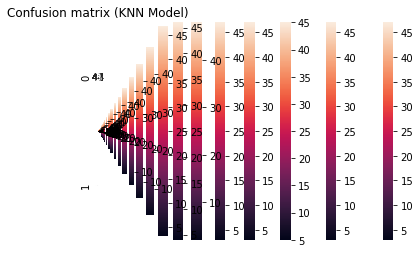

In [7]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization

    study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
    with parallel_backend('threading'):
        study_knn.optimize(objective_knn, n_trials=10, n_jobs=-1)
    
    # Evaluating our Optuna Trial
    print("Best trial:", study_knn.best_trial.number)
    print("Best accuracy:", study_knn.best_trial.value)
    print("Best hyperparameters:", study_knn.best_params)
    
    best_param_knn = study_knn.best_params
    KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
    y_pred_knn = KNN.predict(x_test_)

    

    display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(KNN, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [8]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.050024,0.055929,0.010143,0.047595,0.097048,0.003976,0.002881,0.042405,0
1,0.008821,0.048917,0.002012,0.078250,0.204298,0.015893,0.005536,0.017917,0
2,0.024202,0.052821,0.008583,0.277869,0.083202,0.178274,0.016845,0.066131,0
3,0.014000,0.023048,0.003857,0.019571,0.215000,0.026381,0.014905,0.000952,0
4,0.028083,0.046440,0.005345,0.058679,0.145417,0.009464,0.011893,0.034298,0
...,...,...,...,...,...,...,...,...,...
4995,0.137500,0.210881,0.012476,0.083024,0.318119,0.012119,0.019857,0.039310,1
4996,0.012619,0.036167,0.005310,0.063810,0.190976,0.012548,0.011762,0.037762,1
4997,0.271310,0.035714,0.005286,0.179048,0.302000,0.005976,0.015238,0.022667,1
4998,0.169488,0.046512,0.018393,0.123869,0.332512,0.039821,0.002345,0.054774,1


# value stabilty

In [9]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]

In [10]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('40_knn_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.122175,0.133409,0.295660,0.214063,0.101686,0.371804,0.576664,0.105762,0.240153
1,0.866002,0.336432,1.071124,0.184346,0.120967,0.242628,0.802876,0.463942,0.511040
2,1.014820,0.543407,1.150773,0.336075,0.726515,0.416408,1.099727,0.656348,0.743009
3,0.619514,0.276676,0.561011,0.578463,0.164382,0.283540,0.458740,0.608014,0.443793
4,0.387397,0.291282,0.599039,0.270612,0.160864,0.407928,0.277607,0.212539,0.325908
...,...,...,...,...,...,...,...,...,...
95,0.589176,0.458073,1.219504,0.302004,0.172930,1.047433,0.933609,0.677099,0.674978
96,0.474491,0.337301,0.850588,0.091148,0.109953,0.341501,0.630001,0.137834,0.371602
97,0.183816,0.142215,0.886003,0.200375,0.106036,0.636914,0.462795,0.512529,0.391335
98,0.169797,0.274027,0.982798,0.313062,0.122183,0.530095,1.162971,0.433843,0.498597


In [11]:
valuestability

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.122175,0.133409,0.295660,0.214063,0.101686,0.371804,0.576664,0.105762,0.240153
1,0.866002,0.336432,1.071124,0.184346,0.120967,0.242628,0.802876,0.463942,0.511040
2,1.014820,0.543407,1.150773,0.336075,0.726515,0.416408,1.099727,0.656348,0.743009
3,0.619514,0.276676,0.561011,0.578463,0.164382,0.283540,0.458740,0.608014,0.443793
4,0.387397,0.291282,0.599039,0.270612,0.160864,0.407928,0.277607,0.212539,0.325908
...,...,...,...,...,...,...,...,...,...
95,0.589176,0.458073,1.219504,0.302004,0.172930,1.047433,0.933609,0.677099,0.674978
96,0.474491,0.337301,0.850588,0.091148,0.109953,0.341501,0.630001,0.137834,0.371602
97,0.183816,0.142215,0.886003,0.200375,0.106036,0.636914,0.462795,0.512529,0.391335
98,0.169797,0.274027,0.982798,0.313062,0.122183,0.530095,1.162971,0.433843,0.498597


## 4.3 Logistic Regression

In [12]:
df = pd.read_csv("data_resampled_50.csv")

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [14]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization
    
    # Creating and running our optimization

    study_lr = optuna.create_study(direction='maximize',study_name = "logr")
    with parallel_backend('threading'):
        study_lr.optimize(objective_lr, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_lr.best_trial.number)
    print("Best accuracy:", study_lr.best_trial.value)
    print("Best hyperparameters:", study_lr.best_params)

    # Train the model with the best parameters
    best_param_logr = study_lr.best_params
    LR = LogisticRegression(**best_param_logr, random_state=42).fit(x_train, y_train)


    
    # SHAP value computation using KernelExplainer
    explainer = shap.Explainer(LR, x_train_)
    shap_values = explainer(x_test_)


    # Extract SHAP values
    shap_values_array = abs(shap_values.values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)





[I 2024-08-26 14:50:16,516] A new study created in memory with name: logr
[I 2024-08-26 14:50:18,151] Trial 2 finished with value: 0.700837168001821 and parameters: {'C': 0.0012185533320861698, 'solver': 'saga', 'max_iter': 931}. Best is trial 2 with value: 0.700837168001821.
[I 2024-08-26 14:50:18,464] Trial 0 finished with value: 0.6978883511844819 and parameters: {'C': 0.004200026524037733, 'solver': 'saga', 'max_iter': 360}. Best is trial 2 with value: 0.700837168001821.
[I 2024-08-26 14:50:19,635] Trial 1 finished with value: 0.7019997194593148 and parameters: {'C': 0.016445228563491374, 'solver': 'saga', 'max_iter': 655}. Best is trial 1 with value: 0.7019997194593148.
[I 2024-08-26 14:50:20,635] Trial 7 finished with value: 0.6997889270026799 and parameters: {'C': 0.002466907175928045, 'solver': 'saga', 'max_iter': 332}. Best is trial 1 with value: 0.7019997194593148.
[I 2024-08-26 14:50:20,845] Trial 6 finished with value: 0.6975847690071074 and parameters: {'C': 0.856057134728

Best trial: 3
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.6084443283080141, 'solver': 'lbfgs', 'max_iter': 403}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020858  0.016339       0.000703       0.008357  0.001581  0.049438   
1      0.085960  0.006559       0.002185       0.098300  0.001439  0.015080   
2      0.085960  0.016339       0.012257       0.056327  0.008839  0.091247   
3      0.026408  0.005978       0.006603       0.050294  0.001698  0.032079   
4      0.076795  0.027204       0.008646       0.008357  0.011709  0.039581   
..          ...       ...            ...            ...       ...       ...   
95     0.239551  0.027125       0.007240       0.026346  0.000675  0.031209   
96     0.085960  0.053203       0.000019       0.069594  0.000373  0.087074   
97     0.118511  0.076022       0.002907       0.087583  0.006565  0.010010   
98     0.011693  0.028212       0.002907       0.020349  0.009864  0.048235   

[I 2024-08-26 14:50:28,519] Trial 1 finished with value: 0.7906834230115827 and parameters: {'C': 1.5317044359894125, 'solver': 'liblinear', 'max_iter': 174}. Best is trial 1 with value: 0.7906834230115827.
[I 2024-08-26 14:50:28,580] Trial 4 finished with value: 0.7000908051724288 and parameters: {'C': 0.006118296951819098, 'solver': 'liblinear', 'max_iter': 392}. Best is trial 1 with value: 0.7906834230115827.
[I 2024-08-26 14:50:29,343] Trial 6 finished with value: 0.7908011979854241 and parameters: {'C': 2.1689636814561126, 'solver': 'liblinear', 'max_iter': 857}. Best is trial 6 with value: 0.7908011979854241.
[I 2024-08-26 14:50:29,504] Trial 7 finished with value: 0.7835516755822836 and parameters: {'C': 0.7564096318974399, 'solver': 'liblinear', 'max_iter': 169}. Best is trial 6 with value: 0.7908011979854241.
[I 2024-08-26 14:50:29,712] Trial 3 finished with value: 0.700837168001821 and parameters: {'C': 0.0011442693839223436, 'solver': 'saga', 'max_iter': 791}. Best is trial 

Best trial: 5
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.2803976107056003, 'solver': 'newton-cg', 'max_iter': 833}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020642  0.016319       0.000725       0.008374  0.001583  0.049922   
1      0.085072  0.006551       0.002252       0.098504  0.001441  0.015227   
2      0.085072  0.016319       0.012634       0.056444  0.008850  0.092140   
3      0.026136  0.005971       0.006807       0.050398  0.001700  0.032393   
4      0.076003  0.027171       0.008913       0.008374  0.011722  0.039969   
..          ...       ...            ...            ...       ...       ...   
95     0.237078  0.027092       0.007463       0.026400  0.000676  0.031515   
96     0.085072  0.053139       0.000019       0.069739  0.000373  0.087926   
97     0.117287  0.075930       0.002997       0.087765  0.006572  0.010108   
98     0.011573  0.028178       0.002997       0.020391  0.009876  0.04870

[I 2024-08-26 14:50:38,385] Trial 4 finished with value: 0.7053276073847934 and parameters: {'C': 0.025509218687889145, 'solver': 'sag', 'max_iter': 491}. Best is trial 4 with value: 0.7053276073847934.
[I 2024-08-26 14:50:40,391] Trial 6 finished with value: 0.7010772457533802 and parameters: {'C': 0.0013126065461314758, 'solver': 'saga', 'max_iter': 415}. Best is trial 4 with value: 0.7053276073847934.
[I 2024-08-26 14:50:46,572] Trial 2 finished with value: 0.7873415984750025 and parameters: {'C': 0.0017015215899166677, 'solver': 'lbfgs', 'max_iter': 146}. Best is trial 2 with value: 0.7873415984750025.
[I 2024-08-26 14:50:49,065] Trial 3 finished with value: 0.7910317002922729 and parameters: {'C': 0.09991185402892899, 'solver': 'lbfgs', 'max_iter': 866}. Best is trial 3 with value: 0.7910317002922729.
[I 2024-08-26 14:50:49,335] Trial 0 finished with value: 0.7897347401604704 and parameters: {'C': 0.07443119749416896, 'solver': 'lbfgs', 'max_iter': 436}. Best is trial 3 with value

Best trial: 3
Best accuracy: 0.7910317002922729
Best hyperparameters: {'C': 0.09991185402892899, 'solver': 'lbfgs', 'max_iter': 866}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020257  0.016316       0.000759       0.008406  0.001589  0.050819   
1      0.083485  0.006550       0.002359       0.098876  0.001447  0.015501   
2      0.083485  0.016316       0.013235       0.056657  0.008884  0.093796   
3      0.025648  0.005970       0.007130       0.050588  0.001707  0.032975   
4      0.074584  0.027166       0.009336       0.008406  0.011768  0.040687   
..          ...       ...            ...            ...       ...       ...   
95     0.232653  0.027087       0.007817       0.026500  0.000678  0.032081   
96     0.083485  0.053129       0.000020       0.070002  0.000375  0.089506   
97     0.115098  0.075915       0.003139       0.088096  0.006598  0.010290   
98     0.011357  0.028172       0.003139       0.020468  0.009914  0.049582  

[I 2024-08-26 14:50:55,927] Trial 0 finished with value: 0.7720023713476629 and parameters: {'C': 0.1887138086785034, 'solver': 'liblinear', 'max_iter': 248}. Best is trial 0 with value: 0.7720023713476629.
[I 2024-08-26 14:50:56,040] Trial 2 finished with value: 0.7249861102582608 and parameters: {'C': 0.03122098521603105, 'solver': 'liblinear', 'max_iter': 477}. Best is trial 0 with value: 0.7720023713476629.
[I 2024-08-26 14:50:56,049] Trial 1 finished with value: 0.7902471633205174 and parameters: {'C': 3.5029150784151306, 'solver': 'liblinear', 'max_iter': 521}. Best is trial 1 with value: 0.7902471633205174.
[I 2024-08-26 14:50:57,238] Trial 6 finished with value: 0.7895289612181645 and parameters: {'C': 1.7829521555694958, 'solver': 'liblinear', 'max_iter': 654}. Best is trial 1 with value: 0.7902471633205174.
[I 2024-08-26 14:50:57,726] Trial 3 finished with value: 0.696922438894905 and parameters: {'C': 8.877726003479427, 'solver': 'saga', 'max_iter': 441}. Best is trial 1 wit

Best trial: 5
Best accuracy: 0.792050784662601
Best hyperparameters: {'C': 0.11165347982815456, 'solver': 'lbfgs', 'max_iter': 398}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020310  0.016320       0.000755       0.008405  0.001588  0.050718   
1      0.083705  0.006552       0.002345       0.098871  0.001446  0.015470   
2      0.083705  0.016320       0.013151       0.056653  0.008880  0.093610   
3      0.025716  0.005971       0.007085       0.050585  0.001706  0.032909   
4      0.074781  0.027173       0.009277       0.008405  0.011762  0.040606   
..          ...       ...            ...            ...       ...       ...   
95     0.233267  0.027094       0.007768       0.026498  0.000678  0.032018   
96     0.083705  0.053143       0.000020       0.069998  0.000375  0.089329   
97     0.115402  0.075935       0.003119       0.088091  0.006595  0.010270   
98     0.011387  0.028180       0.003119       0.020467  0.009909  0.049484   

[I 2024-08-26 14:51:02,777] Trial 3 finished with value: 0.6986722629162476 and parameters: {'C': 0.002192706352072185, 'solver': 'liblinear', 'max_iter': 120}. Best is trial 3 with value: 0.6986722629162476.
[I 2024-08-26 14:51:02,876] Trial 5 finished with value: 0.7062338033119303 and parameters: {'C': 0.011452209089282867, 'solver': 'liblinear', 'max_iter': 146}. Best is trial 5 with value: 0.7062338033119303.
[I 2024-08-26 14:51:05,777] Trial 0 finished with value: 0.7028045522948007 and parameters: {'C': 0.26188287271076044, 'solver': 'saga', 'max_iter': 769}. Best is trial 5 with value: 0.7062338033119303.
[I 2024-08-26 14:51:07,040] Trial 7 finished with value: 0.7178614953887498 and parameters: {'C': 7.728520137342012, 'solver': 'sag', 'max_iter': 977}. Best is trial 7 with value: 0.7178614953887498.
[I 2024-08-26 14:51:07,963] Trial 9 finished with value: 0.7724102784808622 and parameters: {'C': 0.306413967640467, 'solver': 'liblinear', 'max_iter': 894}. Best is trial 9 with 

Best trial: 6
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.7016625040172437, 'solver': 'newton-cg', 'max_iter': 79}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021024  0.016368       0.000688       0.008354  0.001580  0.049070   
1      0.086644  0.006571       0.002138       0.098262  0.001439  0.014968   
2      0.086644  0.016368       0.011993       0.056305  0.008835  0.090568   
3      0.026619  0.005989       0.006461       0.050274  0.001697  0.031840   
4      0.077407  0.027253       0.008460       0.008354  0.011702  0.039287   
..          ...       ...            ...            ...       ...       ...   
95     0.241459  0.027173       0.007084       0.026335  0.000675  0.030977   
96     0.086644  0.053298       0.000018       0.069567  0.000373  0.086426   
97     0.119455  0.076157       0.002845       0.087549  0.006561  0.009936   
98     0.011787  0.028262       0.002845       0.020341  0.009859  0.047876

[I 2024-08-26 14:51:18,542] Trial 5 finished with value: 0.7018433343123847 and parameters: {'C': 0.0038193197232375066, 'solver': 'saga', 'max_iter': 583}. Best is trial 5 with value: 0.7018433343123847.
[I 2024-08-26 14:51:18,661] Trial 4 finished with value: 0.7137391142737342 and parameters: {'C': 0.008009391917610654, 'solver': 'sag', 'max_iter': 671}. Best is trial 4 with value: 0.7137391142737342.
[I 2024-08-26 14:51:18,751] Trial 1 finished with value: 0.7112573196732737 and parameters: {'C': 0.29231298115709, 'solver': 'sag', 'max_iter': 714}. Best is trial 4 with value: 0.7137391142737342.
[I 2024-08-26 14:51:19,504] Trial 6 finished with value: 0.7808246351531676 and parameters: {'C': 0.4750727925918647, 'solver': 'liblinear', 'max_iter': 286}. Best is trial 6 with value: 0.7808246351531676.
[I 2024-08-26 14:51:19,650] Trial 7 finished with value: 0.791433638502147 and parameters: {'C': 2.5653335747768287, 'solver': 'liblinear', 'max_iter': 390}. Best is trial 7 with value: 

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.2561166873436886, 'solver': 'lbfgs', 'max_iter': 967}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021038  0.016375       0.000687       0.008356  0.001580  0.049051   
1      0.086703  0.006574       0.002136       0.098296  0.001439  0.014962   
2      0.086703  0.016375       0.011979       0.056324  0.008835  0.090533   
3      0.026637  0.005992       0.006454       0.050292  0.001697  0.031827   
4      0.077460  0.027265       0.008450       0.008356  0.011703  0.039271   
..          ...       ...            ...            ...       ...       ...   
95     0.241623  0.027186       0.007076       0.026344  0.000675  0.030965   
96     0.086703  0.053323       0.000018       0.069591  0.000373  0.086392   
97     0.119536  0.076192       0.002841       0.087579  0.006562  0.009932   
98     0.011795  0.028275       0.002841       0.020348  0.009860  0.047857   

[I 2024-08-26 14:51:24,936] Trial 0 finished with value: 0.7715761740241323 and parameters: {'C': 0.24610698577447596, 'solver': 'liblinear', 'max_iter': 410}. Best is trial 0 with value: 0.7715761740241323.
[I 2024-08-26 14:51:27,938] Trial 2 finished with value: 0.7127245861200674 and parameters: {'C': 9.174678335178582, 'solver': 'sag', 'max_iter': 816}. Best is trial 0 with value: 0.7715761740241323.
[I 2024-08-26 14:51:27,995] Trial 5 finished with value: 0.7025018929119065 and parameters: {'C': 1.1813339542637242, 'solver': 'saga', 'max_iter': 768}. Best is trial 0 with value: 0.7715761740241323.
[I 2024-08-26 14:51:28,785] Trial 6 finished with value: 0.7184076987940397 and parameters: {'C': 0.010694663372064412, 'solver': 'sag', 'max_iter': 874}. Best is trial 0 with value: 0.7715761740241323.
[I 2024-08-26 14:51:32,201] Trial 9 finished with value: 0.7011887175251457 and parameters: {'C': 0.034438648841382855, 'solver': 'saga', 'max_iter': 705}. Best is trial 0 with value: 0.7

Best trial: 3
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9097116773889476, 'solver': 'lbfgs', 'max_iter': 313}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020933  0.016351       0.000697       0.008357  0.001580  0.049246   
1      0.086271  0.006564       0.002167       0.098302  0.001439  0.015021   
2      0.086271  0.016351       0.012155       0.056327  0.008835  0.090892   
3      0.026504  0.005983       0.006548       0.050294  0.001697  0.031954   
4      0.077074  0.027226       0.008574       0.008357  0.011703  0.039427   
..          ...       ...            ...            ...       ...       ...   
95     0.240419  0.027146       0.007179       0.026346  0.000675  0.031088   
96     0.086271  0.053245       0.000019       0.069595  0.000373  0.086735   
97     0.118940  0.076081       0.002883       0.087584  0.006562  0.009972   
98     0.011736  0.028234       0.002883       0.020349  0.009860  0.048048   


[I 2024-08-26 14:51:38,754] Trial 0 finished with value: 0.7014648188075115 and parameters: {'C': 0.006841461462677673, 'solver': 'liblinear', 'max_iter': 920}. Best is trial 0 with value: 0.7014648188075115.
[I 2024-08-26 14:51:39,374] Trial 1 finished with value: 0.6955918797443664 and parameters: {'C': 0.02495510251040351, 'solver': 'saga', 'max_iter': 183}. Best is trial 0 with value: 0.7014648188075115.
[I 2024-08-26 14:51:40,644] Trial 3 finished with value: 0.696517317745646 and parameters: {'C': 0.1426591292266802, 'solver': 'saga', 'max_iter': 380}. Best is trial 0 with value: 0.7014648188075115.
[I 2024-08-26 14:51:40,997] Trial 4 finished with value: 0.6992276691578263 and parameters: {'C': 0.026454094486934317, 'solver': 'saga', 'max_iter': 585}. Best is trial 0 with value: 0.7014648188075115.
[I 2024-08-26 14:51:41,714] Trial 5 finished with value: 0.7028045522948007 and parameters: {'C': 0.3051630136546995, 'solver': 'saga', 'max_iter': 794}. Best is trial 5 with value: 0

Best trial: 6
Best accuracy: 0.7871674429529694
Best hyperparameters: {'C': 0.0011185419518398962, 'solver': 'newton-cg', 'max_iter': 546}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.008824  0.015797       0.000195       0.007800  0.001639  0.040326   
1      0.036365  0.006342       0.000606       0.091751  0.001492  0.012300   
2      0.036365  0.015797       0.003400       0.052574  0.009163  0.074429   
3      0.011172  0.005780       0.001832       0.046943  0.001760  0.026166   
4      0.032488  0.026304       0.002399       0.007800  0.012138  0.032286   
..          ...       ...            ...            ...       ...       ...   
95     0.101342  0.026227       0.002008       0.024590  0.000700  0.025457   
96     0.036365  0.051442       0.000005       0.064957  0.000387  0.071025   
97     0.050136  0.073504       0.000806       0.081747  0.006805  0.008165   
98     0.004947  0.027278       0.000806       0.018993  0.010226  0.03

[I 2024-08-26 14:51:45,495] Trial 1 finished with value: 0.6955918797443664 and parameters: {'C': 3.6816943124912647, 'solver': 'saga', 'max_iter': 158}. Best is trial 1 with value: 0.6955918797443664.
[I 2024-08-26 14:51:46,470] Trial 4 finished with value: 0.7022208214741326 and parameters: {'C': 8.099515661680138, 'solver': 'sag', 'max_iter': 417}. Best is trial 4 with value: 0.7022208214741326.
[I 2024-08-26 14:51:46,988] Trial 5 finished with value: 0.7000666710658185 and parameters: {'C': 0.0036620942553081456, 'solver': 'saga', 'max_iter': 495}. Best is trial 4 with value: 0.7022208214741326.
[I 2024-08-26 14:51:47,199] Trial 7 finished with value: 0.6978875461384145 and parameters: {'C': 0.002046145756024519, 'solver': 'liblinear', 'max_iter': 658}. Best is trial 4 with value: 0.7022208214741326.
[I 2024-08-26 14:51:47,316] Trial 3 finished with value: 0.7132092880461924 and parameters: {'C': 0.0044521000436636635, 'solver': 'sag', 'max_iter': 879}. Best is trial 3 with value: 

Best trial: 2
Best accuracy: 0.7925295372280321
Best hyperparameters: {'C': 0.1357273164303829, 'solver': 'lbfgs', 'max_iter': 325}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020384  0.016314       0.000750       0.008395  0.001587  0.050563   
1      0.084006  0.006549       0.002331       0.098753  0.001445  0.015423   
2      0.084006  0.016314       0.013075       0.056586  0.008872  0.093324   
3      0.025808  0.005969       0.007044       0.050525  0.001704  0.032809   
4      0.075051  0.027164       0.009224       0.008395  0.011752  0.040482   
..          ...       ...            ...            ...       ...       ...   
95     0.234107  0.027085       0.007723       0.026467  0.000678  0.031920   
96     0.084006  0.053124       0.000020       0.069915  0.000374  0.089055   
97     0.115818  0.075908       0.003101       0.087986  0.006589  0.010238   
98     0.011428  0.028170       0.003101       0.020443  0.009901  0.049333   

[I 2024-08-26 14:51:53,220] Trial 0 finished with value: 0.7533851580793315 and parameters: {'C': 0.08274691702871344, 'solver': 'liblinear', 'max_iter': 465}. Best is trial 0 with value: 0.7533851580793315.
[I 2024-08-26 14:51:53,225] Trial 2 finished with value: 0.7835516755822836 and parameters: {'C': 0.7591598281304431, 'solver': 'liblinear', 'max_iter': 268}. Best is trial 2 with value: 0.7835516755822836.
[I 2024-08-26 14:51:53,570] Trial 4 finished with value: 0.6951310893769691 and parameters: {'C': 0.29476087056962, 'solver': 'sag', 'max_iter': 102}. Best is trial 2 with value: 0.7835516755822836.
[I 2024-08-26 14:51:55,973] Trial 7 finished with value: 0.6984952438307989 and parameters: {'C': 0.2153516840172425, 'solver': 'saga', 'max_iter': 505}. Best is trial 2 with value: 0.7835516755822836.
[I 2024-08-26 14:51:57,566] Trial 6 finished with value: 0.7032434971292594 and parameters: {'C': 0.9180363584970801, 'solver': 'saga', 'max_iter': 925}. Best is trial 2 with value: 0.

Best trial: 1
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.0688408777643696, 'solver': 'newton-cg', 'max_iter': 163}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020961  0.016356       0.000694       0.008355  0.001580  0.049195   
1      0.086385  0.006566       0.002156       0.098285  0.001439  0.015006   
2      0.086385  0.016356       0.012093       0.056318  0.008835  0.090798   
3      0.026539  0.005985       0.006515       0.050286  0.001697  0.031921   
4      0.077176  0.027234       0.008531       0.008355  0.011704  0.039386   
..          ...       ...            ...            ...       ...       ...   
95     0.240737  0.027154       0.007143       0.026341  0.000675  0.031056   
96     0.086385  0.053260       0.000019       0.069584  0.000373  0.086645   
97     0.119098  0.076103       0.002868       0.087569  0.006562  0.009961   
98     0.011751  0.028242       0.002868       0.020346  0.009860  0.047997

[I 2024-08-26 14:52:03,847] Trial 0 finished with value: 0.7272357196647821 and parameters: {'C': 0.03871935297739838, 'solver': 'liblinear', 'max_iter': 168}. Best is trial 0 with value: 0.7272357196647821.
[I 2024-08-26 14:52:04,061] Trial 1 finished with value: 0.6955918797443664 and parameters: {'C': 1.2903327879247048, 'solver': 'sag', 'max_iter': 71}. Best is trial 0 with value: 0.7272357196647821.
[I 2024-08-26 14:52:05,021] Trial 5 finished with value: 0.6955295505749595 and parameters: {'C': 1.8731769633798099, 'solver': 'saga', 'max_iter': 290}. Best is trial 0 with value: 0.7272357196647821.
[I 2024-08-26 14:52:06,213] Trial 2 finished with value: 0.7088101738848923 and parameters: {'C': 2.677998627446632, 'solver': 'sag', 'max_iter': 656}. Best is trial 0 with value: 0.7272357196647821.
[I 2024-08-26 14:52:14,758] Trial 3 finished with value: 0.7886099308872785 and parameters: {'C': 0.031158728493563007, 'solver': 'lbfgs', 'max_iter': 975}. Best is trial 3 with value: 0.788

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9791651070890405, 'solver': 'newton-cg', 'max_iter': 235}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020946  0.016354       0.000695       0.008356  0.001580  0.049224   
1      0.086326  0.006565       0.002160       0.098291  0.001439  0.015015   
2      0.086326  0.016354       0.012116       0.056321  0.008836  0.090852   
3      0.026521  0.005984       0.006527       0.050289  0.001697  0.031940   
4      0.077123  0.027229       0.008547       0.008356  0.011704  0.039410   
..          ...       ...            ...            ...       ...       ...   
95     0.240572  0.027150       0.007157       0.026343  0.000675  0.031074   
96     0.086326  0.053252       0.000019       0.069588  0.000373  0.086697   
97     0.119016  0.076092       0.002874       0.087575  0.006562  0.009967   
98     0.011743  0.028238       0.002874       0.020347  0.009860  0.048026

[I 2024-08-26 14:52:22,940] Trial 0 finished with value: 0.7037476177534397 and parameters: {'C': 0.0029170153535258573, 'solver': 'saga', 'max_iter': 828}. Best is trial 0 with value: 0.7037476177534397.
[I 2024-08-26 14:52:22,985] Trial 1 finished with value: 0.6994663947191452 and parameters: {'C': 0.06921129849635117, 'solver': 'saga', 'max_iter': 631}. Best is trial 0 with value: 0.7037476177534397.
[I 2024-08-26 14:52:27,051] Trial 6 finished with value: 0.7032524341861418 and parameters: {'C': 0.8674866105744661, 'solver': 'saga', 'max_iter': 888}. Best is trial 0 with value: 0.7037476177534397.
[I 2024-08-26 14:52:29,895] Trial 5 finished with value: 0.7869417660509219 and parameters: {'C': 0.0030339731595126745, 'solver': 'lbfgs', 'max_iter': 482}. Best is trial 5 with value: 0.7869417660509219.
[I 2024-08-26 14:52:30,770] Trial 9 finished with value: 0.755183136057001 and parameters: {'C': 0.09345843936026353, 'solver': 'liblinear', 'max_iter': 991}. Best is trial 5 with valu

Best trial: 8
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.364191442791644, 'solver': 'newton-cg', 'max_iter': 72}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020997  0.016362       0.000691       0.008354  0.001580  0.049123   
1      0.086532  0.006569       0.002146       0.098271  0.001439  0.014984   
2      0.086532  0.016362       0.012036       0.056310  0.008835  0.090666   
3      0.026584  0.005987       0.006484       0.050279  0.001697  0.031874   
4      0.077307  0.027244       0.008490       0.008354  0.011703  0.039329   
..          ...       ...            ...            ...       ...       ...   
95     0.241147  0.027165       0.007109       0.026338  0.000675  0.031011   
96     0.086532  0.053281       0.000018       0.069574  0.000373  0.086519   
97     0.119300  0.076133       0.002855       0.087557  0.006562  0.009947   
98     0.011771  0.028253       0.002855       0.020343  0.009859  0.047928  

[I 2024-08-26 14:52:35,956] Trial 5 finished with value: 0.790168484496067 and parameters: {'C': 1.812724101065173, 'solver': 'liblinear', 'max_iter': 845}. Best is trial 5 with value: 0.790168484496067.
[I 2024-08-26 14:52:36,976] Trial 1 finished with value: 0.6981974070804202 and parameters: {'C': 6.0280747786472535, 'solver': 'sag', 'max_iter': 236}. Best is trial 5 with value: 0.790168484496067.
[I 2024-08-26 14:52:38,415] Trial 0 finished with value: 0.7090817729314193 and parameters: {'C': 0.042447936683515465, 'solver': 'sag', 'max_iter': 624}. Best is trial 5 with value: 0.790168484496067.
[I 2024-08-26 14:52:38,562] Trial 7 finished with value: 0.6963268934402242 and parameters: {'C': 0.03936399126963325, 'solver': 'saga', 'max_iter': 283}. Best is trial 5 with value: 0.790168484496067.
[I 2024-08-26 14:52:39,849] Trial 4 finished with value: 0.7175390011736724 and parameters: {'C': 0.22577389785907007, 'solver': 'sag', 'max_iter': 982}. Best is trial 5 with value: 0.79016848

Best trial: 5
Best accuracy: 0.790168484496067
Best hyperparameters: {'C': 1.812724101065173, 'solver': 'liblinear', 'max_iter': 845}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019886  0.013100       0.003377       0.006601  0.001402  0.029038   
1      0.081955  0.005259       0.010493       0.077649  0.001276  0.008857   
2      0.081955  0.013100       0.058859       0.044493  0.007836  0.053594   
3      0.025178  0.004793       0.031709       0.039728  0.001505  0.018841   
4      0.073218  0.021813       0.041521       0.006601  0.010380  0.023248   
..          ...       ...            ...            ...       ...       ...   
95     0.228392  0.021749       0.034766       0.020811  0.000598  0.018331   
96     0.081955  0.042659       0.000090       0.054973  0.000331  0.051143   
97     0.112990  0.060955       0.013960       0.069183  0.005820  0.005880   
98     0.011149  0.022620       0.013960       0.016074  0.008745  0.028331 

[I 2024-08-26 14:52:43,513] Trial 5 finished with value: 0.7900747191975561 and parameters: {'C': 3.325299068001461, 'solver': 'liblinear', 'max_iter': 865}. Best is trial 5 with value: 0.7900747191975561.
[I 2024-08-26 14:52:44,015] Trial 6 finished with value: 0.7919725832569625 and parameters: {'C': 5.914007641844719, 'solver': 'liblinear', 'max_iter': 463}. Best is trial 6 with value: 0.7919725832569625.
[I 2024-08-26 14:52:44,207] Trial 4 finished with value: 0.6955295505749595 and parameters: {'C': 0.04837181374990703, 'solver': 'sag', 'max_iter': 147}. Best is trial 6 with value: 0.7919725832569625.
[I 2024-08-26 14:52:44,702] Trial 8 finished with value: 0.7915656129727081 and parameters: {'C': 4.039472120140071, 'solver': 'liblinear', 'max_iter': 395}. Best is trial 6 with value: 0.7919725832569625.
[I 2024-08-26 14:52:44,948] Trial 1 finished with value: 0.6968646332465508 and parameters: {'C': 0.009155744563827103, 'solver': 'saga', 'max_iter': 307}. Best is trial 6 with val

Best trial: 6
Best accuracy: 0.7919725832569625
Best hyperparameters: {'C': 5.914007641844719, 'solver': 'liblinear', 'max_iter': 463}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020380  0.014814       0.001882       0.007497  0.001488  0.039610   
1      0.083990  0.005947       0.005846       0.088185  0.001355  0.012082   
2      0.083990  0.014814       0.032795       0.050530  0.008320  0.073107   
3      0.025803  0.005420       0.017668       0.045118  0.001598  0.025701   
4      0.075036  0.024666       0.023135       0.007497  0.011021  0.031712   
..          ...       ...            ...            ...       ...       ...   
95     0.234062  0.024594       0.019371       0.023634  0.000635  0.025005   
96     0.083990  0.048239       0.000050       0.062433  0.000351  0.069763   
97     0.115795  0.068928       0.007779       0.078570  0.006179  0.008020   
98     0.011426  0.025579       0.007779       0.018255  0.009284  0.038646

[I 2024-08-26 14:52:48,427] Trial 4 finished with value: 0.7238922644939475 and parameters: {'C': 0.03316966519785243, 'solver': 'liblinear', 'max_iter': 467}. Best is trial 4 with value: 0.7238922644939475.
[I 2024-08-26 14:52:48,518] Trial 2 finished with value: 0.7047436177217601 and parameters: {'C': 0.00997329381290727, 'solver': 'liblinear', 'max_iter': 218}. Best is trial 4 with value: 0.7238922644939475.
[I 2024-08-26 14:52:48,537] Trial 1 finished with value: 0.7827370611444162 and parameters: {'C': 0.6637356988646151, 'solver': 'liblinear', 'max_iter': 252}. Best is trial 1 with value: 0.7827370611444162.
[I 2024-08-26 14:52:48,927] Trial 3 finished with value: 0.6944423558237619 and parameters: {'C': 1.3187345913467523, 'solver': 'saga', 'max_iter': 112}. Best is trial 1 with value: 0.7827370611444162.
[I 2024-08-26 14:52:49,286] Trial 7 finished with value: 0.7059435096462869 and parameters: {'C': 0.011017474959528747, 'solver': 'liblinear', 'max_iter': 992}. Best is trial 

Best trial: 5
Best accuracy: 0.7920390314910644
Best hyperparameters: {'C': 0.1205097236475974, 'solver': 'lbfgs', 'max_iter': 406}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020347  0.016320       0.000753       0.008404  0.001588  0.050636   
1      0.083856  0.006552       0.002340       0.098853  0.001446  0.015445   
2      0.083856  0.016320       0.013128       0.056643  0.008878  0.093458   
3      0.025762  0.005971       0.007073       0.050576  0.001705  0.032856   
4      0.074916  0.027174       0.009261       0.008404  0.011760  0.040541   
..          ...       ...            ...            ...       ...       ...   
95     0.233687  0.027095       0.007754       0.026494  0.000678  0.031966   
96     0.083856  0.053144       0.000020       0.069985  0.000375  0.089184   
97     0.115610  0.075937       0.003114       0.088075  0.006594  0.010253   
98     0.011407  0.028180       0.003114       0.020464  0.009907  0.049404   

[I 2024-08-26 14:52:56,538] Trial 0 finished with value: 0.6978875461384145 and parameters: {'C': 0.002026088226909012, 'solver': 'liblinear', 'max_iter': 607}. Best is trial 0 with value: 0.6978875461384145.
[I 2024-08-26 14:52:56,578] Trial 5 finished with value: 0.7389145390473657 and parameters: {'C': 0.053693643951034924, 'solver': 'liblinear', 'max_iter': 647}. Best is trial 5 with value: 0.7389145390473657.
[I 2024-08-26 14:52:56,602] Trial 2 finished with value: 0.723391546943763 and parameters: {'C': 0.02976615335509595, 'solver': 'liblinear', 'max_iter': 63}. Best is trial 5 with value: 0.7389145390473657.
[I 2024-08-26 14:52:57,167] Trial 3 finished with value: 0.7010204881935225 and parameters: {'C': 0.0012324856536936088, 'solver': 'sag', 'max_iter': 397}. Best is trial 5 with value: 0.7389145390473657.
[I 2024-08-26 14:52:57,598] Trial 1 finished with value: 0.6955295505749595 and parameters: {'C': 1.0733891600542078, 'solver': 'saga', 'max_iter': 269}. Best is trial 5 wi

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 6.7428630165757655, 'solver': 'newton-cg', 'max_iter': 53}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021115  0.016386       0.000680       0.008352  0.001580  0.048902   
1      0.087021  0.006578       0.002113       0.098239  0.001438  0.014916   
2      0.087021  0.016386       0.011854       0.056292  0.008834  0.090257   
3      0.026734  0.005996       0.006386       0.050262  0.001697  0.031731   
4      0.077744  0.027284       0.008362       0.008352  0.011702  0.039152   
..          ...       ...            ...            ...       ...       ...   
95     0.242508  0.027204       0.007002       0.026329  0.000675  0.030871   
96     0.087021  0.053359       0.000018       0.069551  0.000373  0.086129   
97     0.119974  0.076244       0.002812       0.087529  0.006561  0.009902   
98     0.011838  0.028294       0.002812       0.020337  0.009858  0.047712

[I 2024-08-26 14:53:05,749] Trial 2 finished with value: 0.6975847690071074 and parameters: {'C': 0.21055599086712362, 'solver': 'sag', 'max_iter': 233}. Best is trial 2 with value: 0.6975847690071074.
[I 2024-08-26 14:53:05,884] Trial 1 finished with value: 0.7003094522353445 and parameters: {'C': 0.018983597739759914, 'solver': 'sag', 'max_iter': 271}. Best is trial 1 with value: 0.7003094522353445.
[I 2024-08-26 14:53:06,614] Trial 6 finished with value: 0.7919725832569625 and parameters: {'C': 5.536438543132248, 'solver': 'liblinear', 'max_iter': 145}. Best is trial 6 with value: 0.7919725832569625.
[I 2024-08-26 14:53:06,745] Trial 4 finished with value: 0.703536979973806 and parameters: {'C': 8.37271565660127, 'solver': 'sag', 'max_iter': 464}. Best is trial 6 with value: 0.7919725832569625.
[I 2024-08-26 14:53:06,786] Trial 7 finished with value: 0.773224038869044 and parameters: {'C': 0.2009581049526701, 'solver': 'liblinear', 'max_iter': 324}. Best is trial 6 with value: 0.791

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 9.893742767106735, 'solver': 'lbfgs', 'max_iter': 838}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021131  0.016389       0.000680       0.008351  0.001580  0.048884   
1      0.087085  0.006580       0.002113       0.098236  0.001438  0.014911   
2      0.087085  0.016389       0.011851       0.056290  0.008833  0.090224   
3      0.026754  0.005997       0.006385       0.050261  0.001697  0.031719   
4      0.077801  0.027289       0.008360       0.008351  0.011701  0.039138   
..          ...       ...            ...            ...       ...       ...   
95     0.242687  0.027210       0.007000       0.026328  0.000675  0.030860   
96     0.087085  0.053369       0.000018       0.069549  0.000373  0.086098   
97     0.120062  0.076258       0.002811       0.087526  0.006560  0.009898   
98     0.011847  0.028300       0.002811       0.020336  0.009857  0.047694   


[I 2024-08-26 14:53:11,463] Trial 4 finished with value: 0.7919725832569625 and parameters: {'C': 5.786831481103502, 'solver': 'liblinear', 'max_iter': 572}. Best is trial 4 with value: 0.7919725832569625.
[I 2024-08-26 14:53:13,021] Trial 5 finished with value: 0.7038301089148803 and parameters: {'C': 3.797657627837631, 'solver': 'sag', 'max_iter': 469}. Best is trial 4 with value: 0.7919725832569625.
[I 2024-08-26 14:53:21,850] Trial 0 finished with value: 0.7936831070517691 and parameters: {'C': 3.280970018617577, 'solver': 'lbfgs', 'max_iter': 127}. Best is trial 0 with value: 0.7936831070517691.
[I 2024-08-26 14:53:23,209] Trial 2 finished with value: 0.7943897844602273 and parameters: {'C': 0.41296648666697633, 'solver': 'lbfgs', 'max_iter': 622}. Best is trial 2 with value: 0.7943897844602273.
[I 2024-08-26 14:53:23,644] Trial 3 finished with value: 0.7906171923931461 and parameters: {'C': 0.09673387491199935, 'solver': 'lbfgs', 'max_iter': 594}. Best is trial 2 with value: 0.79

Best trial: 7
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.3876744383435287, 'solver': 'newton-cg', 'max_iter': 677}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021083  0.016379       0.000683       0.008352  0.001580  0.048960   
1      0.086888  0.006576       0.002122       0.098246  0.001438  0.014934   
2      0.086888  0.016379       0.011902       0.056296  0.008834  0.090364   
3      0.026693  0.005993       0.006412       0.050266  0.001697  0.031768   
4      0.077625  0.027273       0.008396       0.008352  0.011702  0.039198   
..          ...       ...            ...            ...       ...       ...   
95     0.242138  0.027193       0.007030       0.026331  0.000675  0.030907   
96     0.086888  0.053337       0.000018       0.069556  0.000373  0.086231   
97     0.119791  0.076212       0.002823       0.087535  0.006561  0.009914   
98     0.011820  0.028282       0.002823       0.020338  0.009858  0.04776

[I 2024-08-26 14:53:29,371] Trial 2 finished with value: 0.755183136057001 and parameters: {'C': 0.09388257379918899, 'solver': 'liblinear', 'max_iter': 758}. Best is trial 2 with value: 0.755183136057001.
[I 2024-08-26 14:53:30,436] Trial 0 finished with value: 0.7043488741637166 and parameters: {'C': 0.0019806457081761927, 'solver': 'sag', 'max_iter': 817}. Best is trial 2 with value: 0.755183136057001.
[I 2024-08-26 14:53:32,742] Trial 7 finished with value: 0.702428569797227 and parameters: {'C': 0.027958213569039415, 'solver': 'sag', 'max_iter': 381}. Best is trial 2 with value: 0.755183136057001.
[I 2024-08-26 14:53:39,691] Trial 4 finished with value: 0.7935704908517868 and parameters: {'C': 0.14651785175021798, 'solver': 'lbfgs', 'max_iter': 113}. Best is trial 4 with value: 0.7935704908517868.
[I 2024-08-26 14:53:42,471] Trial 1 finished with value: 0.7944000310009028 and parameters: {'C': 0.48255491548471324, 'solver': 'lbfgs', 'max_iter': 641}. Best is trial 1 with value: 0.

Best trial: 8
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.136441930471546, 'solver': 'lbfgs', 'max_iter': 528}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021107  0.016380       0.000687       0.008350  0.001580  0.048962   
1      0.086988  0.006576       0.002134       0.098218  0.001438  0.014935   
2      0.086988  0.016380       0.011970       0.056279  0.008831  0.090368   
3      0.026724  0.005993       0.006449       0.050251  0.001696  0.031769   
4      0.077715  0.027274       0.008444       0.008350  0.011698  0.039200   
..          ...       ...            ...            ...       ...       ...   
95     0.242418  0.027195       0.007070       0.026323  0.000674  0.030909   
96     0.086988  0.053340       0.000018       0.069536  0.000373  0.086235   
97     0.119929  0.076217       0.002839       0.087510  0.006559  0.009914   
98     0.011833  0.028284       0.002839       0.020332  0.009855  0.047770   


[I 2024-08-26 14:53:45,668] Trial 5 finished with value: 0.790168484496067 and parameters: {'C': 1.7719167121781136, 'solver': 'liblinear', 'max_iter': 67}. Best is trial 5 with value: 0.790168484496067.
[I 2024-08-26 14:53:45,671] Trial 0 finished with value: 0.7782093729487451 and parameters: {'C': 0.36788969389847115, 'solver': 'liblinear', 'max_iter': 1000}. Best is trial 5 with value: 0.790168484496067.
[I 2024-08-26 14:53:46,193] Trial 3 finished with value: 0.6955918797443664 and parameters: {'C': 1.6509609103337206, 'solver': 'saga', 'max_iter': 152}. Best is trial 5 with value: 0.790168484496067.
[I 2024-08-26 14:53:46,469] Trial 7 finished with value: 0.6985803270843378 and parameters: {'C': 0.004556121448903276, 'solver': 'liblinear', 'max_iter': 570}. Best is trial 5 with value: 0.790168484496067.
[I 2024-08-26 14:53:47,160] Trial 6 finished with value: 0.6962154726240357 and parameters: {'C': 2.936785780870639, 'solver': 'sag', 'max_iter': 166}. Best is trial 5 with value:

Best trial: 2
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 1.8716498008074454, 'solver': 'newton-cg', 'max_iter': 825}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021034  0.016370       0.000687       0.008353  0.001580  0.049051   
1      0.086687  0.006572       0.002135       0.098259  0.001439  0.014962   
2      0.086687  0.016370       0.011977       0.056303  0.008835  0.090532   
3      0.026632  0.005990       0.006452       0.050272  0.001697  0.031827   
4      0.077445  0.027256       0.008449       0.008353  0.011702  0.039271   
..          ...       ...            ...            ...       ...       ...   
95     0.241577  0.027177       0.007074       0.026334  0.000675  0.030965   
96     0.086687  0.053304       0.000018       0.069565  0.000373  0.086391   
97     0.119513  0.076166       0.002841       0.087546  0.006561  0.009932   
98     0.011792  0.028265       0.002841       0.020341  0.009859  0.04785

[I 2024-08-26 14:53:55,848] Trial 2 finished with value: 0.7237880141150572 and parameters: {'C': 0.034785088138456516, 'solver': 'liblinear', 'max_iter': 504}. Best is trial 2 with value: 0.7237880141150572.
[I 2024-08-26 14:53:55,860] Trial 1 finished with value: 0.7694814715254598 and parameters: {'C': 0.16906136517359086, 'solver': 'liblinear', 'max_iter': 846}. Best is trial 1 with value: 0.7694814715254598.
[I 2024-08-26 14:53:55,879] Trial 4 finished with value: 0.7227724459637385 and parameters: {'C': 0.029181483285417077, 'solver': 'liblinear', 'max_iter': 147}. Best is trial 1 with value: 0.7694814715254598.
[I 2024-08-26 14:53:56,460] Trial 7 finished with value: 0.7040788356562838 and parameters: {'C': 0.008927196554907096, 'solver': 'liblinear', 'max_iter': 945}. Best is trial 1 with value: 0.7694814715254598.
[I 2024-08-26 14:53:57,013] Trial 6 finished with value: 0.6948670239312026 and parameters: {'C': 0.14167249189651884, 'solver': 'saga', 'max_iter': 109}. Best is tr

Best trial: 5
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 9.562155230600812, 'solver': 'newton-cg', 'max_iter': 627}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021125  0.016388       0.000679       0.008351  0.001580  0.048885   
1      0.087062  0.006579       0.002111       0.098238  0.001438  0.014911   
2      0.087062  0.016388       0.011839       0.056291  0.008834  0.090225   
3      0.026747  0.005996       0.006378       0.050262  0.001697  0.031719   
4      0.077780  0.027288       0.008351       0.008351  0.011702  0.039138   
..          ...       ...            ...            ...       ...       ...   
95     0.242623  0.027208       0.006993       0.026329  0.000675  0.030860   
96     0.087062  0.053366       0.000018       0.069550  0.000373  0.086099   
97     0.120030  0.076254       0.002808       0.087527  0.006561  0.009898   
98     0.011843  0.028298       0.002808       0.020336  0.009859  0.047695

[I 2024-08-26 14:54:02,932] Trial 0 finished with value: 0.696517317745646 and parameters: {'C': 0.6457526140492018, 'solver': 'sag', 'max_iter': 182}. Best is trial 0 with value: 0.696517317745646.
[I 2024-08-26 14:54:04,314] Trial 5 finished with value: 0.6984952438307989 and parameters: {'C': 0.09073105347257907, 'solver': 'saga', 'max_iter': 498}. Best is trial 5 with value: 0.6984952438307989.
[I 2024-08-26 14:54:04,441] Trial 4 finished with value: 0.6984952438307989 and parameters: {'C': 5.341912540171008, 'solver': 'saga', 'max_iter': 510}. Best is trial 5 with value: 0.6984952438307989.
[I 2024-08-26 14:54:05,083] Trial 3 finished with value: 0.7127997418697477 and parameters: {'C': 7.69176834820541, 'solver': 'sag', 'max_iter': 747}. Best is trial 3 with value: 0.7127997418697477.
[I 2024-08-26 14:54:05,224] Trial 8 finished with value: 0.7922942933355951 and parameters: {'C': 6.607652078193037, 'solver': 'liblinear', 'max_iter': 84}. Best is trial 8 with value: 0.79229429333

Best trial: 1
Best accuracy: 0.7947957970442991
Best hyperparameters: {'C': 0.7379417068175196, 'solver': 'newton-cg', 'max_iter': 166}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020894  0.016345       0.000700       0.008358  0.001581  0.049335   
1      0.086110  0.006562       0.002175       0.098317  0.001439  0.015048   
2      0.086110  0.016345       0.012202       0.056336  0.008837  0.091056   
3      0.026454  0.005981       0.006574       0.050302  0.001697  0.032011   
4      0.076930  0.027216       0.008608       0.008358  0.011706  0.039498   
..          ...       ...            ...            ...       ...       ...   
95     0.239970  0.027136       0.007208       0.026350  0.000675  0.031144   
96     0.086110  0.053225       0.000019       0.069606  0.000373  0.086891   
97     0.118718  0.076053       0.002894       0.087598  0.006563  0.009989   
98     0.011714  0.028223       0.002894       0.020353  0.009862  0.04813

[I 2024-08-26 14:54:15,845] Trial 2 finished with value: 0.7047645378818455 and parameters: {'C': 0.009396797006091986, 'solver': 'liblinear', 'max_iter': 119}. Best is trial 2 with value: 0.7047645378818455.
[I 2024-08-26 14:54:16,371] Trial 4 finished with value: 0.6959700924259228 and parameters: {'C': 0.004793725614476151, 'solver': 'saga', 'max_iter': 128}. Best is trial 2 with value: 0.7047645378818455.
[I 2024-08-26 14:54:17,025] Trial 1 finished with value: 0.6972855548365675 and parameters: {'C': 0.005151023479181544, 'solver': 'saga', 'max_iter': 281}. Best is trial 2 with value: 0.7047645378818455.
[I 2024-08-26 14:54:17,232] Trial 7 finished with value: 0.7841934286126624 and parameters: {'C': 0.8165714677573367, 'solver': 'liblinear', 'max_iter': 257}. Best is trial 7 with value: 0.7841934286126624.
[I 2024-08-26 14:54:17,288] Trial 3 finished with value: 0.6968646332465508 and parameters: {'C': 0.011592702573615703, 'solver': 'saga', 'max_iter': 344}. Best is trial 7 with

Best trial: 8
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.2923178762222949, 'solver': 'newton-cg', 'max_iter': 174}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020655  0.016319       0.000724       0.008373  0.001583  0.049890   
1      0.085126  0.006552       0.002248       0.098492  0.001441  0.015218   
2      0.085126  0.016319       0.012612       0.056437  0.008849  0.092080   
3      0.026152  0.005971       0.006795       0.050392  0.001700  0.032372   
4      0.076051  0.027173       0.008897       0.008373  0.011721  0.039943   
..          ...       ...            ...            ...       ...       ...   
95     0.237228  0.027094       0.007450       0.026397  0.000676  0.031494   
96     0.085126  0.053141       0.000019       0.069730  0.000373  0.087869   
97     0.117361  0.075933       0.002991       0.087754  0.006572  0.010102   
98     0.011580  0.028179       0.002991       0.020389  0.009875  0.04867

[I 2024-08-26 14:54:26,516] Trial 3 finished with value: 0.7841934286126624 and parameters: {'C': 0.8194535452563976, 'solver': 'liblinear', 'max_iter': 481}. Best is trial 3 with value: 0.7841934286126624.
[I 2024-08-26 14:54:28,388] Trial 5 finished with value: 0.7042699791221924 and parameters: {'C': 0.7122987668077135, 'solver': 'sag', 'max_iter': 471}. Best is trial 3 with value: 0.7841934286126624.
[I 2024-08-26 14:54:28,592] Trial 2 finished with value: 0.7053276073847934 and parameters: {'C': 0.03335416810250199, 'solver': 'sag', 'max_iter': 500}. Best is trial 3 with value: 0.7841934286126624.
[I 2024-08-26 14:54:30,063] Trial 6 finished with value: 0.7014831994438149 and parameters: {'C': 0.4387815713486197, 'solver': 'saga', 'max_iter': 697}. Best is trial 3 with value: 0.7841934286126624.
[I 2024-08-26 14:54:30,164] Trial 0 finished with value: 0.7151490706226329 and parameters: {'C': 0.3655507850283812, 'solver': 'sag', 'max_iter': 907}. Best is trial 3 with value: 0.78419

Best trial: 9
Best accuracy: 0.7944775597260619
Best hyperparameters: {'C': 0.8526567551216253, 'solver': 'newton-cg', 'max_iter': 724}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020922  0.016350       0.000698       0.008357  0.001581  0.049275   
1      0.086225  0.006564       0.002167       0.098303  0.001439  0.015030   
2      0.086225  0.016350       0.012156       0.056328  0.008836  0.090946   
3      0.026490  0.005982       0.006549       0.050295  0.001697  0.031973   
4      0.077033  0.027223       0.008575       0.008357  0.011705  0.039451   
..          ...       ...            ...            ...       ...       ...   
95     0.240291  0.027143       0.007180       0.026346  0.000675  0.031106   
96     0.086225  0.053239       0.000019       0.069596  0.000373  0.086786   
97     0.118877  0.076073       0.002883       0.087585  0.006563  0.009977   
98     0.011730  0.028231       0.002883       0.020350  0.009861  0.04807

[I 2024-08-26 14:54:35,186] Trial 2 finished with value: 0.7756089141774873 and parameters: {'C': 0.3502751991760384, 'solver': 'liblinear', 'max_iter': 543}. Best is trial 2 with value: 0.7756089141774873.
[I 2024-08-26 14:54:35,231] Trial 1 finished with value: 0.7937398293577264 and parameters: {'C': 9.560369761217306, 'solver': 'liblinear', 'max_iter': 815}. Best is trial 1 with value: 0.7937398293577264.
[I 2024-08-26 14:54:36,342] Trial 5 finished with value: 0.6955295505749595 and parameters: {'C': 0.4091648659286815, 'solver': 'saga', 'max_iter': 288}. Best is trial 1 with value: 0.7937398293577264.
[I 2024-08-26 14:54:36,771] Trial 4 finished with value: 0.696517317745646 and parameters: {'C': 0.15319508159587486, 'solver': 'saga', 'max_iter': 391}. Best is trial 1 with value: 0.7937398293577264.
[I 2024-08-26 14:54:37,786] Trial 6 finished with value: 0.6996870071269874 and parameters: {'C': 0.005681555383904168, 'solver': 'saga', 'max_iter': 454}. Best is trial 1 with value:

Best trial: 0
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.6576466975564885, 'solver': 'lbfgs', 'max_iter': 261}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020867  0.016343       0.000703       0.008359  0.001581  0.049390   
1      0.085998  0.006561       0.002184       0.098328  0.001439  0.015065   
2      0.085998  0.016343       0.012253       0.056342  0.008837  0.091159   
3      0.026420  0.005980       0.006601       0.050308  0.001697  0.032048   
4      0.076830  0.027212       0.008643       0.008359  0.011706  0.039543   
..          ...       ...            ...            ...       ...       ...   
95     0.239659  0.027133       0.007237       0.026353  0.000675  0.031179   
96     0.085998  0.053219       0.000019       0.069614  0.000373  0.086990   
97     0.118564  0.076044       0.002906       0.087607  0.006563  0.010001   
98     0.011699  0.028220       0.002906       0.020355  0.009862  0.048188   

[I 2024-08-26 14:54:48,558] Trial 5 finished with value: 0.7922942933355951 and parameters: {'C': 6.422947235369763, 'solver': 'liblinear', 'max_iter': 196}. Best is trial 5 with value: 0.7922942933355951.
[I 2024-08-26 14:54:48,770] Trial 0 finished with value: 0.6956345476469862 and parameters: {'C': 0.004629700502565811, 'solver': 'saga', 'max_iter': 61}. Best is trial 5 with value: 0.7922942933355951.
[I 2024-08-26 14:54:51,891] Trial 4 finished with value: 0.7178614953887498 and parameters: {'C': 7.904418116173782, 'solver': 'sag', 'max_iter': 974}. Best is trial 5 with value: 0.7922942933355951.
[I 2024-08-26 14:54:52,104] Trial 6 finished with value: 0.7131022474385819 and parameters: {'C': 0.4467879602643376, 'solver': 'sag', 'max_iter': 764}. Best is trial 5 with value: 0.7922942933355951.
[I 2024-08-26 14:54:52,782] Trial 8 finished with value: 0.7907006198702049 and parameters: {'C': 3.4621882257408205, 'solver': 'liblinear', 'max_iter': 168}. Best is trial 5 with value: 0.7

Best trial: 1
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.8551208045520519, 'solver': 'lbfgs', 'max_iter': 728}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020922  0.016347       0.000700       0.008357  0.001580  0.049295   
1      0.086226  0.006563       0.002174       0.098300  0.001439  0.015036   
2      0.086226  0.016347       0.012195       0.056326  0.008835  0.090982   
3      0.026490  0.005981       0.006570       0.050293  0.001697  0.031985   
4      0.077034  0.027218       0.008602       0.008357  0.011703  0.039466   
..          ...       ...            ...            ...       ...       ...   
95     0.240294  0.027139       0.007203       0.026345  0.000675  0.031119   
96     0.086226  0.053231       0.000019       0.069594  0.000373  0.086821   
97     0.118879  0.076061       0.002892       0.087583  0.006562  0.009981   
98     0.011730  0.028226       0.002892       0.020349  0.009859  0.048095   


[I 2024-08-26 14:55:01,950] Trial 0 finished with value: 0.705626547412337 and parameters: {'C': 0.010644307022285865, 'solver': 'liblinear', 'max_iter': 731}. Best is trial 0 with value: 0.705626547412337.
[I 2024-08-26 14:55:02,842] Trial 6 finished with value: 0.6951006585006902 and parameters: {'C': 0.001776819849667689, 'solver': 'saga', 'max_iter': 60}. Best is trial 0 with value: 0.705626547412337.
[I 2024-08-26 14:55:03,894] Trial 2 finished with value: 0.7035342009360357 and parameters: {'C': 0.08338390996178455, 'solver': 'sag', 'max_iter': 430}. Best is trial 0 with value: 0.705626547412337.
[I 2024-08-26 14:55:04,327] Trial 7 finished with value: 0.6959022253327837 and parameters: {'C': 0.05403347208230261, 'solver': 'saga', 'max_iter': 232}. Best is trial 0 with value: 0.705626547412337.
[I 2024-08-26 14:55:04,380] Trial 8 finished with value: 0.7903929565157936 and parameters: {'C': 3.395849187608184, 'solver': 'liblinear', 'max_iter': 487}. Best is trial 8 with value: 0.

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 1.9642436551689306, 'solver': 'newton-cg', 'max_iter': 239}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021039  0.016371       0.000687       0.008353  0.001580  0.049041   
1      0.086707  0.006572       0.002134       0.098257  0.001439  0.014959   
2      0.086707  0.016371       0.011969       0.056302  0.008834  0.090514   
3      0.026638  0.005990       0.006448       0.050272  0.001697  0.031821   
4      0.077463  0.027258       0.008443       0.008353  0.011702  0.039263   
..          ...       ...            ...            ...       ...       ...   
95     0.241634  0.027178       0.007070       0.026334  0.000675  0.030959   
96     0.086707  0.053308       0.000018       0.069564  0.000373  0.086375   
97     0.119541  0.076171       0.002839       0.087545  0.006561  0.009930   
98     0.011795  0.028267       0.002839       0.020340  0.009859  0.04784

[I 2024-08-26 14:55:11,277] Trial 2 finished with value: 0.7911618773742365 and parameters: {'C': 2.147374176350985, 'solver': 'liblinear', 'max_iter': 240}. Best is trial 2 with value: 0.7911618773742365.
[I 2024-08-26 14:55:12,029] Trial 6 finished with value: 0.7922942933355951 and parameters: {'C': 6.450092017090813, 'solver': 'liblinear', 'max_iter': 746}. Best is trial 6 with value: 0.7922942933355951.
[I 2024-08-26 14:55:12,099] Trial 5 finished with value: 0.6951310893769691 and parameters: {'C': 0.23852418621353338, 'solver': 'saga', 'max_iter': 181}. Best is trial 6 with value: 0.7922942933355951.
[I 2024-08-26 14:55:12,931] Trial 8 finished with value: 0.7907006198702049 and parameters: {'C': 3.5720476054911208, 'solver': 'liblinear', 'max_iter': 248}. Best is trial 6 with value: 0.7922942933355951.
[I 2024-08-26 14:55:13,500] Trial 7 finished with value: 0.7010204881935225 and parameters: {'C': 0.0012334158741739867, 'solver': 'sag', 'max_iter': 292}. Best is trial 6 with v

Best trial: 1
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.29020065365974096, 'solver': 'lbfgs', 'max_iter': 515}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020653  0.016319       0.000723       0.008373  0.001583  0.049897   
1      0.085116  0.006551       0.002248       0.098497  0.001441  0.015220   
2      0.085116  0.016319       0.012608       0.056439  0.008849  0.092093   
3      0.026149  0.005971       0.006792       0.050394  0.001700  0.032376   
4      0.076042  0.027172       0.008894       0.008373  0.011721  0.039948   
..          ...       ...            ...            ...       ...       ...   
95     0.237199  0.027093       0.007447       0.026398  0.000676  0.031499   
96     0.085116  0.053141       0.000019       0.069733  0.000373  0.087881   
97     0.117347  0.075932       0.002990       0.087758  0.006572  0.010103   
98     0.011579  0.028178       0.002990       0.020390  0.009875  0.048682  

[I 2024-08-26 14:55:20,224] Trial 4 finished with value: 0.6966751684082461 and parameters: {'C': 0.003332584185781817, 'solver': 'liblinear', 'max_iter': 656}. Best is trial 4 with value: 0.6966751684082461.
[I 2024-08-26 14:55:21,069] Trial 6 finished with value: 0.6973007054700896 and parameters: {'C': 0.003974296930304562, 'solver': 'liblinear', 'max_iter': 564}. Best is trial 6 with value: 0.6973007054700896.
[I 2024-08-26 14:55:21,884] Trial 7 finished with value: 0.7122588317041233 and parameters: {'C': 0.01832167554020995, 'solver': 'liblinear', 'max_iter': 131}. Best is trial 7 with value: 0.7122588317041233.
[I 2024-08-26 14:55:21,959] Trial 5 finished with value: 0.7067406594203686 and parameters: {'C': 0.007591303653712318, 'solver': 'sag', 'max_iter': 442}. Best is trial 7 with value: 0.7122588317041233.
[I 2024-08-26 14:55:22,260] Trial 2 finished with value: 0.7101801329939428 and parameters: {'C': 0.005608585239951903, 'solver': 'sag', 'max_iter': 556}. Best is trial 7 

Best trial: 0
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.762486182573174, 'solver': 'newton-cg', 'max_iter': 59}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021101  0.016383       0.000681       0.008352  0.001580  0.048926   
1      0.086964  0.006577       0.002117       0.098242  0.001438  0.014924   
2      0.086964  0.016383       0.011874       0.056293  0.008834  0.090303   
3      0.026717  0.005995       0.006397       0.050264  0.001697  0.031747   
4      0.077693  0.027279       0.008376       0.008352  0.011702  0.039172   
..          ...       ...            ...            ...       ...       ...   
95     0.242350  0.027200       0.007014       0.026330  0.000675  0.030886   
96     0.086964  0.053349       0.000018       0.069553  0.000373  0.086173   
97     0.119896  0.076230       0.002816       0.087531  0.006561  0.009907   
98     0.011830  0.028289       0.002816       0.020337  0.009858  0.047736 

[I 2024-08-26 14:55:28,940] Trial 3 finished with value: 0.7014648188075115 and parameters: {'C': 0.006743372336501268, 'solver': 'liblinear', 'max_iter': 469}. Best is trial 3 with value: 0.7014648188075115.
[I 2024-08-26 14:55:31,794] Trial 6 finished with value: 0.7058751406296063 and parameters: {'C': 8.027635683689908, 'solver': 'sag', 'max_iter': 561}. Best is trial 6 with value: 0.7058751406296063.
[I 2024-08-26 14:55:32,059] Trial 5 finished with value: 0.7148004811285742 and parameters: {'C': 0.006809866775638004, 'solver': 'lbfgs', 'max_iter': 54}. Best is trial 5 with value: 0.7148004811285742.
[I 2024-08-26 14:55:32,204] Trial 1 finished with value: 0.704330028735471 and parameters: {'C': 0.013365016749724621, 'solver': 'saga', 'max_iter': 849}. Best is trial 5 with value: 0.7148004811285742.
[I 2024-08-26 14:55:33,314] Trial 9 finished with value: 0.6958458519025298 and parameters: {'C': 0.6761289488444597, 'solver': 'sag', 'max_iter': 112}. Best is trial 5 with value: 0.7

Best trial: 4
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.4877864264583416, 'solver': 'newton-cg', 'max_iter': 639}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020800  0.016333       0.000709       0.008363  0.001581  0.049544   
1      0.085722  0.006557       0.002204       0.098374  0.001439  0.015112   
2      0.085722  0.016333       0.012362       0.056369  0.008841  0.091443   
3      0.026335  0.005976       0.006660       0.050332  0.001698  0.032147   
4      0.076583  0.027194       0.008720       0.008363  0.011710  0.039666   
..          ...       ...            ...            ...       ...       ...   
95     0.238888  0.027115       0.007302       0.026365  0.000675  0.031276   
96     0.085722  0.053184       0.000019       0.069647  0.000373  0.087261   
97     0.118183  0.075994       0.002932       0.087649  0.006566  0.010032   
98     0.011661  0.028201       0.002932       0.020365  0.009865  0.04833

[I 2024-08-26 14:55:42,782] Trial 1 finished with value: 0.7065472317820568 and parameters: {'C': 1.1907843880430908, 'solver': 'sag', 'max_iter': 603}. Best is trial 1 with value: 0.7065472317820568.
[I 2024-08-26 14:55:42,852] Trial 3 finished with value: 0.6984952438307989 and parameters: {'C': 0.03435894243454278, 'solver': 'saga', 'max_iter': 557}. Best is trial 1 with value: 0.7065472317820568.
[I 2024-08-26 14:55:43,769] Trial 4 finished with value: 0.7063472869614315 and parameters: {'C': 0.005900168730716556, 'solver': 'saga', 'max_iter': 802}. Best is trial 1 with value: 0.7065472317820568.
[I 2024-08-26 14:55:54,189] Trial 2 finished with value: 0.7877772934823554 and parameters: {'C': 0.002549726180113543, 'solver': 'newton-cg', 'max_iter': 133}. Best is trial 2 with value: 0.7877772934823554.
[I 2024-08-26 14:55:54,365] Trial 7 finished with value: 0.7861679086698549 and parameters: {'C': 0.004657279747762848, 'solver': 'lbfgs', 'max_iter': 271}. Best is trial 2 with value

Best trial: 8
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.6126990038632973, 'solver': 'lbfgs', 'max_iter': 697}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021016  0.016366       0.000688       0.008354  0.001580  0.049081   
1      0.086614  0.006570       0.002138       0.098265  0.001439  0.014971   
2      0.086614  0.016366       0.011994       0.056306  0.008835  0.090588   
3      0.026609  0.005988       0.006462       0.050276  0.001697  0.031847   
4      0.077380  0.027250       0.008461       0.008354  0.011703  0.039295   
..          ...       ...            ...            ...       ...       ...   
95     0.241374  0.027171       0.007085       0.026336  0.000675  0.030984   
96     0.086614  0.053293       0.000018       0.069569  0.000373  0.086445   
97     0.119413  0.076150       0.002845       0.087551  0.006562  0.009938   
98     0.011783  0.028260       0.002845       0.020342  0.009859  0.047887   


[I 2024-08-26 14:55:57,252] Trial 3 finished with value: 0.6973007054700896 and parameters: {'C': 0.0036592166392194238, 'solver': 'liblinear', 'max_iter': 411}. Best is trial 3 with value: 0.6973007054700896.
[I 2024-08-26 14:55:58,570] Trial 0 finished with value: 0.7036962695460949 and parameters: {'C': 0.0047887526296508465, 'solver': 'sag', 'max_iter': 345}. Best is trial 0 with value: 0.7036962695460949.
[I 2024-08-26 14:55:58,631] Trial 2 finished with value: 0.6962154726240357 and parameters: {'C': 0.6925981436648695, 'solver': 'saga', 'max_iter': 347}. Best is trial 0 with value: 0.7036962695460949.
[I 2024-08-26 14:56:01,104] Trial 6 finished with value: 0.7031062114199892 and parameters: {'C': 0.03505568794603652, 'solver': 'saga', 'max_iter': 795}. Best is trial 0 with value: 0.7036962695460949.
[I 2024-08-26 14:56:01,964] Trial 9 finished with value: 0.7726817714800367 and parameters: {'C': 0.1940578346746091, 'solver': 'liblinear', 'max_iter': 722}. Best is trial 9 with v

Best trial: 5
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.425289906776619, 'solver': 'newton-cg', 'max_iter': 596}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021058  0.016374       0.000685       0.008353  0.001580  0.049005   
1      0.086787  0.006574       0.002128       0.098252  0.001438  0.014948   
2      0.086787  0.016374       0.011939       0.056299  0.008834  0.090447   
3      0.026663  0.005991       0.006432       0.050269  0.001697  0.031797   
4      0.077535  0.027264       0.008422       0.008353  0.011702  0.039234   
..          ...       ...            ...            ...       ...       ...   
95     0.241857  0.027185       0.007052       0.026333  0.000675  0.030936   
96     0.086787  0.053320       0.000018       0.069560  0.000373  0.086310   
97     0.119652  0.076189       0.002832       0.087540  0.006561  0.009923   
98     0.011806  0.028274       0.002832       0.020339  0.009859  0.047812

[I 2024-08-26 14:56:07,856] Trial 0 finished with value: 0.7841934286126624 and parameters: {'C': 0.8174710834688665, 'solver': 'liblinear', 'max_iter': 510}. Best is trial 0 with value: 0.7841934286126624.
[I 2024-08-26 14:56:08,482] Trial 1 finished with value: 0.6955918797443664 and parameters: {'C': 0.024724356655618687, 'solver': 'saga', 'max_iter': 210}. Best is trial 0 with value: 0.7841934286126624.
[I 2024-08-26 14:56:08,575] Trial 5 finished with value: 0.6975856918015877 and parameters: {'C': 0.0040693312133883155, 'solver': 'sag', 'max_iter': 175}. Best is trial 0 with value: 0.7841934286126624.
[I 2024-08-26 14:56:09,819] Trial 2 finished with value: 0.7012233623218783 and parameters: {'C': 0.003421143758063833, 'solver': 'saga', 'max_iter': 538}. Best is trial 0 with value: 0.7841934286126624.
[I 2024-08-26 14:56:10,037] Trial 3 finished with value: 0.7074095659306445 and parameters: {'C': 0.7051699118178477, 'solver': 'sag', 'max_iter': 633}. Best is trial 0 with value: 

Best trial: 0
Best accuracy: 0.7841934286126624
Best hyperparameters: {'C': 0.8174710834688665, 'solver': 'liblinear', 'max_iter': 510}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019920  0.011586       0.004937       0.005847  0.001343  0.019036   
1      0.082095  0.004651       0.015338       0.068778  0.001222  0.005806   
2      0.082095  0.011586       0.086034       0.039410  0.007508  0.035134   
3      0.025221  0.004239       0.046350       0.035189  0.001442  0.012352   
4      0.073343  0.019291       0.060691       0.005847  0.009945  0.015241   
..          ...       ...            ...            ...       ...       ...   
95     0.228780  0.019235       0.050818       0.018433  0.000573  0.012017   
96     0.082095  0.037727       0.000132       0.048693  0.000317  0.033527   
97     0.113182  0.053907       0.020406       0.061279  0.005576  0.003854   
98     0.011168  0.020005       0.020406       0.014238  0.008378  0.01857

[I 2024-08-26 14:56:13,688] Trial 0 finished with value: 0.6976722321571348 and parameters: {'C': 0.008477093187418192, 'solver': 'saga', 'max_iter': 341}. Best is trial 0 with value: 0.6976722321571348.
[I 2024-08-26 14:56:14,032] Trial 3 finished with value: 0.7064625865284256 and parameters: {'C': 0.008970045476332353, 'solver': 'sag', 'max_iter': 444}. Best is trial 3 with value: 0.7064625865284256.
[I 2024-08-26 14:56:14,078] Trial 6 finished with value: 0.7922774689889319 and parameters: {'C': 8.214540803802263, 'solver': 'liblinear', 'max_iter': 499}. Best is trial 6 with value: 0.7922774689889319.
[I 2024-08-26 14:56:14,099] Trial 4 finished with value: 0.6989645022691682 and parameters: {'C': 0.005486031732738529, 'solver': 'saga', 'max_iter': 430}. Best is trial 6 with value: 0.7922774689889319.
[I 2024-08-26 14:56:15,062] Trial 8 finished with value: 0.7904977787067493 and parameters: {'C': 1.8362699305496322, 'solver': 'liblinear', 'max_iter': 609}. Best is trial 6 with val

Best trial: 6
Best accuracy: 0.7922774689889319
Best hyperparameters: {'C': 8.214540803802263, 'solver': 'liblinear', 'max_iter': 499}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020537  0.015216       0.001556       0.007717  0.001511  0.041986   
1      0.084639  0.006109       0.004835       0.090770  0.001376  0.012807   
2      0.084639  0.015216       0.027120       0.052012  0.008448  0.077494   
3      0.026003  0.005568       0.014611       0.046441  0.001623  0.027243   
4      0.075616  0.025336       0.019131       0.007717  0.011190  0.033615   
..          ...       ...            ...            ...       ...       ...   
95     0.235871  0.025262       0.016019       0.024327  0.000645  0.026505   
96     0.084639  0.049550       0.000042       0.064263  0.000356  0.073949   
97     0.116690  0.070801       0.006432       0.080874  0.006274  0.008502   
98     0.011514  0.026274       0.006432       0.018790  0.009427  0.040965

[I 2024-08-26 14:56:18,338] Trial 5 finished with value: 0.7237880141150572 and parameters: {'C': 0.034240502930816714, 'solver': 'liblinear', 'max_iter': 287}. Best is trial 5 with value: 0.7237880141150572.
[I 2024-08-26 14:56:19,779] Trial 3 finished with value: 0.6973812900864838 and parameters: {'C': 0.02479133863536357, 'solver': 'saga', 'max_iter': 410}. Best is trial 5 with value: 0.7237880141150572.
[I 2024-08-26 14:56:20,081] Trial 1 finished with value: 0.7069627581020796 and parameters: {'C': 0.06691133682138162, 'solver': 'sag', 'max_iter': 527}. Best is trial 5 with value: 0.7237880141150572.
[I 2024-08-26 14:56:21,114] Trial 2 finished with value: 0.7133578258890745 and parameters: {'C': 5.777088216940122, 'solver': 'sag', 'max_iter': 846}. Best is trial 5 with value: 0.7237880141150572.
[I 2024-08-26 14:56:22,987] Trial 8 finished with value: 0.6984952438307989 and parameters: {'C': 8.759970512693815, 'solver': 'saga', 'max_iter': 533}. Best is trial 5 with value: 0.723

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 5.322764465241241, 'solver': 'lbfgs', 'max_iter': 972}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021104  0.016384       0.000682       0.008352  0.001580  0.048926   
1      0.086977  0.006577       0.002119       0.098240  0.001439  0.014924   
2      0.086977  0.016384       0.011885       0.056292  0.008835  0.090303   
3      0.026721  0.005995       0.006403       0.050263  0.001697  0.031747   
4      0.077705  0.027280       0.008384       0.008352  0.011702  0.039172   
..          ...       ...            ...            ...       ...       ...   
95     0.242387  0.027201       0.007020       0.026329  0.000675  0.030886   
96     0.086977  0.053351       0.000018       0.069552  0.000373  0.086172   
97     0.119914  0.076233       0.002819       0.087530  0.006561  0.009907   
98     0.011832  0.028290       0.002819       0.020337  0.009859  0.047736   


[I 2024-08-26 14:56:31,565] Trial 4 finished with value: 0.6971329081993193 and parameters: {'C': 0.0034311678220632085, 'solver': 'liblinear', 'max_iter': 574}. Best is trial 4 with value: 0.6971329081993193.
[I 2024-08-26 14:56:32,276] Trial 3 finished with value: 0.696517317745646 and parameters: {'C': 0.10982850912065015, 'solver': 'sag', 'max_iter': 185}. Best is trial 4 with value: 0.6971329081993193.
[I 2024-08-26 14:56:32,414] Trial 1 finished with value: 0.696922438894905 and parameters: {'C': 0.3682372071889359, 'solver': 'sag', 'max_iter': 230}. Best is trial 4 with value: 0.6971329081993193.
[I 2024-08-26 14:56:43,243] Trial 0 finished with value: 0.7861633726554023 and parameters: {'C': 0.008282855145064749, 'solver': 'lbfgs', 'max_iter': 303}. Best is trial 0 with value: 0.7861633726554023.
[I 2024-08-26 14:56:43,544] Trial 2 finished with value: 0.7945031356814864 and parameters: {'C': 5.163979162186215, 'solver': 'lbfgs', 'max_iter': 718}. Best is trial 2 with value: 0.

Best trial: 7
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.665385208264675, 'solver': 'lbfgs', 'max_iter': 510}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021019  0.016368       0.000690       0.008350  0.001581  0.049087   
1      0.086625  0.006571       0.002144       0.098224  0.001439  0.014973   
2      0.086625  0.016368       0.012027       0.056283  0.008837  0.090600   
3      0.026613  0.005989       0.006480       0.050254  0.001697  0.031851   
4      0.077390  0.027254       0.008484       0.008350  0.011705  0.039300   
..          ...       ...            ...            ...       ...       ...   
95     0.241406  0.027175       0.007104       0.026325  0.000675  0.030988   
96     0.086625  0.053301       0.000018       0.069540  0.000373  0.086456   
97     0.119428  0.076161       0.002853       0.087515  0.006563  0.009939   
98     0.011784  0.028264       0.002853       0.020333  0.009861  0.047893   
9

[I 2024-08-26 14:56:48,674] Trial 2 finished with value: 0.696517317745646 and parameters: {'C': 0.04135326319547183, 'solver': 'sag', 'max_iter': 199}. Best is trial 2 with value: 0.696517317745646.
[I 2024-08-26 14:56:48,864] Trial 4 finished with value: 0.7013136171345967 and parameters: {'C': 0.0013522947559117282, 'solver': 'sag', 'max_iter': 814}. Best is trial 4 with value: 0.7013136171345967.
[I 2024-08-26 14:56:49,638] Trial 6 finished with value: 0.7908425740380304 and parameters: {'C': 2.9423447796300994, 'solver': 'liblinear', 'max_iter': 848}. Best is trial 6 with value: 0.7908425740380304.
[I 2024-08-26 14:56:49,743] Trial 7 finished with value: 0.7804220052197788 and parameters: {'C': 0.6127257678178417, 'solver': 'liblinear', 'max_iter': 61}. Best is trial 6 with value: 0.7908425740380304.
[I 2024-08-26 14:56:50,331] Trial 1 finished with value: 0.7006275058782063 and parameters: {'C': 0.016903878622696752, 'solver': 'saga', 'max_iter': 585}. Best is trial 6 with value:

Best trial: 6
Best accuracy: 0.7908425740380304
Best hyperparameters: {'C': 2.9423447796300994, 'solver': 'liblinear', 'max_iter': 848}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020033  0.013912       0.002638       0.007023  0.001441  0.034075   
1      0.082560  0.005585       0.008194       0.082613  0.001311  0.010394   
2      0.082560  0.013912       0.045966       0.047338  0.008054  0.062891   
3      0.025364  0.005090       0.024763       0.042267  0.001547  0.022110   
4      0.073758  0.023164       0.032426       0.007023  0.010668  0.027281   
..          ...       ...            ...            ...       ...       ...   
95     0.230076  0.023096       0.027150       0.022141  0.000615  0.021511   
96     0.082560  0.045301       0.000070       0.058488  0.000340  0.060014   
97     0.113823  0.064730       0.010902       0.073606  0.005981  0.006900   
98     0.011231  0.024021       0.010902       0.017102  0.008987  0.03324

[I 2024-08-26 14:56:54,395] Trial 5 finished with value: 0.6955295505749595 and parameters: {'C': 3.412165443447873, 'solver': 'sag', 'max_iter': 139}. Best is trial 5 with value: 0.6955295505749595.
[I 2024-08-26 14:56:55,146] Trial 6 finished with value: 0.74813882802254 and parameters: {'C': 0.07119750164860257, 'solver': 'liblinear', 'max_iter': 786}. Best is trial 6 with value: 0.74813882802254.
[I 2024-08-26 14:56:55,861] Trial 7 finished with value: 0.7590743207769105 and parameters: {'C': 0.114276679941662, 'solver': 'liblinear', 'max_iter': 811}. Best is trial 7 with value: 0.7590743207769105.
[I 2024-08-26 14:56:55,941] Trial 2 finished with value: 0.7063088393020361 and parameters: {'C': 8.999669032229594, 'solver': 'sag', 'max_iter': 543}. Best is trial 7 with value: 0.7590743207769105.
[I 2024-08-26 14:56:56,627] Trial 1 finished with value: 0.7007694452667369 and parameters: {'C': 3.4848454964537368, 'solver': 'saga', 'max_iter': 690}. Best is trial 7 with value: 0.759074

Best trial: 3
Best accuracy: 0.7940773632412477
Best hyperparameters: {'C': 0.24099668967956633, 'solver': 'newton-cg', 'max_iter': 544}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020593  0.016316       0.000730       0.008378  0.001584  0.050043   
1      0.084871  0.006550       0.002267       0.098552  0.001442  0.015264   
2      0.084871  0.016316       0.012719       0.056471  0.008853  0.092364   
3      0.026074  0.005970       0.006852       0.050423  0.001701  0.032471   
4      0.075823  0.027168       0.008972       0.008378  0.011727  0.040066   
..          ...       ...            ...            ...       ...       ...   
95     0.236516  0.027088       0.007512       0.026413  0.000676  0.031591   
96     0.084871  0.053131       0.000019       0.069773  0.000374  0.088139   
97     0.117009  0.075919       0.003017       0.087808  0.006575  0.010133   
98     0.011545  0.028174       0.003017       0.020401  0.009880  0.0488

[I 2024-08-26 14:57:07,664] Trial 3 finished with value: 0.6983763683709252 and parameters: {'C': 0.0023445206789020306, 'solver': 'liblinear', 'max_iter': 146}. Best is trial 3 with value: 0.6983763683709252.
[I 2024-08-26 14:57:07,727] Trial 4 finished with value: 0.7776031061171768 and parameters: {'C': 0.36508987646639496, 'solver': 'liblinear', 'max_iter': 695}. Best is trial 4 with value: 0.7776031061171768.
[I 2024-08-26 14:57:07,771] Trial 1 finished with value: 0.7900747191975561 and parameters: {'C': 3.3462908849831785, 'solver': 'liblinear', 'max_iter': 929}. Best is trial 1 with value: 0.7900747191975561.
[I 2024-08-26 14:57:08,269] Trial 5 finished with value: 0.701516975906416 and parameters: {'C': 0.0011408842514360434, 'solver': 'sag', 'max_iter': 753}. Best is trial 1 with value: 0.7900747191975561.
[I 2024-08-26 14:57:10,146] Trial 8 finished with value: 0.7028045522948007 and parameters: {'C': 0.12474655785726096, 'solver': 'sag', 'max_iter': 408}. Best is trial 1 wi

Best trial: 0
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.0770695162773039, 'solver': 'lbfgs', 'max_iter': 974}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020978  0.016355       0.000699       0.008355  0.001580  0.049275   
1      0.086454  0.006566       0.002172       0.098278  0.001438  0.015030   
2      0.086454  0.016355       0.012184       0.056314  0.008834  0.090947   
3      0.026560  0.005984       0.006564       0.050282  0.001697  0.031973   
4      0.077237  0.027231       0.008595       0.008355  0.011702  0.039451   
..          ...       ...            ...            ...       ...       ...   
95     0.240929  0.027152       0.007197       0.026339  0.000675  0.031107   
96     0.086454  0.053256       0.000019       0.069578  0.000373  0.086787   
97     0.119193  0.076097       0.002890       0.087563  0.006561  0.009978   
98     0.011761  0.028240       0.002890       0.020345  0.009858  0.048076   


[I 2024-08-26 14:57:15,917] Trial 3 finished with value: 0.7487578550737297 and parameters: {'C': 0.07334916111468902, 'solver': 'liblinear', 'max_iter': 379}. Best is trial 3 with value: 0.7487578550737297.
[I 2024-08-26 14:57:15,959] Trial 0 finished with value: 0.6997063908670138 and parameters: {'C': 0.0010109660446227038, 'solver': 'liblinear', 'max_iter': 949}. Best is trial 3 with value: 0.7487578550737297.
[I 2024-08-26 14:57:16,588] Trial 7 finished with value: 0.7077037326660774 and parameters: {'C': 0.013212089688998098, 'solver': 'liblinear', 'max_iter': 662}. Best is trial 3 with value: 0.7487578550737297.
[I 2024-08-26 14:57:17,065] Trial 5 finished with value: 0.7012711281665035 and parameters: {'C': 0.001085698840209798, 'solver': 'saga', 'max_iter': 859}. Best is trial 3 with value: 0.7487578550737297.
[I 2024-08-26 14:57:17,467] Trial 6 finished with value: 0.6951310893769691 and parameters: {'C': 9.736801756344574, 'solver': 'saga', 'max_iter': 189}. Best is trial 3 

Best trial: 2
Best accuracy: 0.7920390314910644
Best hyperparameters: {'C': 0.12702080546851718, 'solver': 'lbfgs', 'max_iter': 533}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020359  0.016316       0.000751       0.008400  0.001587  0.050602   
1      0.083903  0.006550       0.002333       0.098808  0.001445  0.015435   
2      0.083903  0.016316       0.013085       0.056618  0.008875  0.093395   
3      0.025777  0.005970       0.007050       0.050553  0.001705  0.032834   
4      0.074959  0.027167       0.009231       0.008400  0.011755  0.040513   
..          ...       ...            ...            ...       ...       ...   
95     0.233821  0.027088       0.007729       0.026482  0.000678  0.031944   
96     0.083903  0.053131       0.000020       0.069954  0.000374  0.089123   
97     0.115676  0.075918       0.003104       0.088035  0.006591  0.010246   
98     0.011414  0.028173       0.003104       0.020454  0.009903  0.049370  

[I 2024-08-26 14:57:21,813] Trial 3 finished with value: 0.7808241909396623 and parameters: {'C': 0.4463993049290729, 'solver': 'liblinear', 'max_iter': 740}. Best is trial 3 with value: 0.7808241909396623.
[I 2024-08-26 14:57:22,485] Trial 6 finished with value: 0.7809020983429285 and parameters: {'C': 0.45416892488946603, 'solver': 'liblinear', 'max_iter': 110}. Best is trial 6 with value: 0.7809020983429285.
[I 2024-08-26 14:57:23,280] Trial 1 finished with value: 0.696517317745646 and parameters: {'C': 0.03826654823159408, 'solver': 'saga', 'max_iter': 361}. Best is trial 6 with value: 0.7809020983429285.
[I 2024-08-26 14:57:23,340] Trial 5 finished with value: 0.7028045522948007 and parameters: {'C': 0.18241996356613915, 'solver': 'sag', 'max_iter': 404}. Best is trial 6 with value: 0.7809020983429285.
[I 2024-08-26 14:57:25,663] Trial 9 finished with value: 0.7039664510866253 and parameters: {'C': 2.2389959776909656, 'solver': 'sag', 'max_iter': 483}. Best is trial 6 with value: 

Best trial: 0
Best accuracy: 0.7943897844602273
Best hyperparameters: {'C': 0.3979513722231226, 'solver': 'newton-cg', 'max_iter': 496}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020746  0.016327       0.000715       0.008366  0.001582  0.049670   
1      0.085500  0.006554       0.002220       0.098414  0.001440  0.015151   
2      0.085500  0.016327       0.012454       0.056392  0.008843  0.091675   
3      0.026267  0.005974       0.006710       0.050352  0.001699  0.032229   
4      0.076385  0.027185       0.008786       0.008366  0.011714  0.039767   
..          ...       ...            ...            ...       ...       ...   
95     0.238270  0.027106       0.007356       0.026376  0.000675  0.031356   
96     0.085500  0.053165       0.000019       0.069675  0.000373  0.087483   
97     0.117877  0.075967       0.002954       0.087685  0.006568  0.010057   
98     0.011631  0.028191       0.002954       0.020373  0.009868  0.04846

[I 2024-08-26 14:57:33,735] Trial 4 finished with value: 0.7025929406202291 and parameters: {'C': 0.015192655371348679, 'solver': 'sag', 'max_iter': 352}. Best is trial 4 with value: 0.7025929406202291.
[I 2024-08-26 14:57:34,328] Trial 2 finished with value: 0.7076575453233183 and parameters: {'C': 0.007649473299017969, 'solver': 'sag', 'max_iter': 504}. Best is trial 2 with value: 0.7076575453233183.
[I 2024-08-26 14:57:38,280] Trial 7 finished with value: 0.7025058078056307 and parameters: {'C': 1.439741331001786, 'solver': 'saga', 'max_iter': 802}. Best is trial 2 with value: 0.7076575453233183.
[I 2024-08-26 14:57:43,867] Trial 3 finished with value: 0.7867069456063924 and parameters: {'C': 0.0013175839049920596, 'solver': 'lbfgs', 'max_iter': 843}. Best is trial 3 with value: 0.7867069456063924.
[I 2024-08-26 14:57:44,021] Trial 1 finished with value: 0.7861679086698549 and parameters: {'C': 0.004740961529937319, 'solver': 'lbfgs', 'max_iter': 580}. Best is trial 3 with value: 0.

Best trial: 5
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 7.898805556506841, 'solver': 'lbfgs', 'max_iter': 546}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021115  0.016389       0.000679       0.008350  0.001580  0.048901   
1      0.087021  0.006579       0.002111       0.098223  0.001439  0.014916   
2      0.087021  0.016389       0.011840       0.056283  0.008835  0.090256   
3      0.026734  0.005997       0.006379       0.050254  0.001697  0.031730   
4      0.077744  0.027289       0.008352       0.008350  0.011703  0.039151   
..          ...       ...            ...            ...       ...       ...   
95     0.242508  0.027209       0.006993       0.026325  0.000675  0.030870   
96     0.087021  0.053368       0.000018       0.069540  0.000373  0.086128   
97     0.119974  0.076257       0.002808       0.087514  0.006561  0.009902   
98     0.011838  0.028299       0.002808       0.020333  0.009859  0.047711   


[I 2024-08-26 14:57:50,717] Trial 3 finished with value: 0.697055330426105 and parameters: {'C': 0.0032262559312425383, 'solver': 'liblinear', 'max_iter': 379}. Best is trial 3 with value: 0.697055330426105.
[I 2024-08-26 14:57:50,738] Trial 2 finished with value: 0.7330931745414311 and parameters: {'C': 0.04603008020459913, 'solver': 'liblinear', 'max_iter': 270}. Best is trial 2 with value: 0.7330931745414311.
[I 2024-08-26 14:57:52,847] Trial 7 finished with value: 0.7018410496072918 and parameters: {'C': 8.431500582397941, 'solver': 'sag', 'max_iter': 370}. Best is trial 2 with value: 0.7330931745414311.
[I 2024-08-26 14:57:55,425] Trial 8 finished with value: 0.704578224433876 and parameters: {'C': 1.953437275001149, 'solver': 'sag', 'max_iter': 506}. Best is trial 2 with value: 0.7330931745414311.
[I 2024-08-26 14:57:56,970] Trial 9 finished with value: 0.7013136171345967 and parameters: {'C': 0.0013735594392484986, 'solver': 'sag', 'max_iter': 340}. Best is trial 2 with value: 0

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.3226132404086302, 'solver': 'newton-cg', 'max_iter': 907}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020992  0.016362       0.000691       0.008354  0.001580  0.049132   
1      0.086515  0.006568       0.002147       0.098273  0.001439  0.014986   
2      0.086515  0.016362       0.012042       0.056311  0.008835  0.090681   
3      0.026579  0.005987       0.006488       0.050279  0.001697  0.031880   
4      0.077292  0.027243       0.008495       0.008354  0.011703  0.039336   
..          ...       ...            ...            ...       ...       ...   
95     0.241099  0.027164       0.007113       0.026338  0.000675  0.031016   
96     0.086515  0.053279       0.000018       0.069575  0.000373  0.086534   
97     0.119276  0.076129       0.002856       0.087558  0.006562  0.009948   
98     0.011769  0.028252       0.002856       0.020344  0.009859  0.047936

[I 2024-08-26 14:58:04,612] Trial 0 finished with value: 0.791433638502147 and parameters: {'C': 2.6111571742875093, 'solver': 'liblinear', 'max_iter': 680}. Best is trial 0 with value: 0.791433638502147.
[I 2024-08-26 14:58:06,074] Trial 3 finished with value: 0.7025058078056307 and parameters: {'C': 0.22863333218000143, 'solver': 'sag', 'max_iter': 412}. Best is trial 0 with value: 0.791433638502147.
[I 2024-08-26 14:58:06,628] Trial 4 finished with value: 0.6984952438307989 and parameters: {'C': 0.18269615103030254, 'solver': 'saga', 'max_iter': 501}. Best is trial 0 with value: 0.791433638502147.
[I 2024-08-26 14:58:06,842] Trial 7 finished with value: 0.7015453532520267 and parameters: {'C': 0.00744729524749964, 'solver': 'liblinear', 'max_iter': 259}. Best is trial 0 with value: 0.791433638502147.
[I 2024-08-26 14:58:07,263] Trial 1 finished with value: 0.7011901421987028 and parameters: {'C': 0.13696215530464725, 'solver': 'saga', 'max_iter': 677}. Best is trial 0 with value: 0.

Best trial: 8
Best accuracy: 0.7947957970442991
Best hyperparameters: {'C': 0.7045859455454025, 'solver': 'lbfgs', 'max_iter': 439}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020835  0.016347       0.000695       0.008350  0.001581  0.049422   
1      0.085867  0.006562       0.002159       0.098225  0.001439  0.015075   
2      0.085867  0.016347       0.012110       0.056284  0.008840  0.091217   
3      0.026380  0.005981       0.006524       0.050255  0.001698  0.032068   
4      0.076713  0.027218       0.008543       0.008350  0.011710  0.039568   
..          ...       ...            ...            ...       ...       ...   
95     0.239293  0.027139       0.007153       0.026325  0.000675  0.031199   
96     0.085867  0.053230       0.000019       0.069541  0.000373  0.087045   
97     0.118383  0.076060       0.002872       0.087516  0.006565  0.010007   
98     0.011681  0.028226       0.002872       0.020334  0.009865  0.048219   

[I 2024-08-26 14:58:19,083] Trial 5 finished with value: 0.6962214544488995 and parameters: {'C': 0.4937990696310421, 'solver': 'sag', 'max_iter': 206}. Best is trial 5 with value: 0.6962214544488995.
[I 2024-08-26 14:58:19,147] Trial 4 finished with value: 0.7024626345231944 and parameters: {'C': 0.0015603372338245337, 'solver': 'sag', 'max_iter': 540}. Best is trial 4 with value: 0.7024626345231944.
[I 2024-08-26 14:58:20,197] Trial 1 finished with value: 0.705775114337872 and parameters: {'C': 1.3455813047452903, 'solver': 'sag', 'max_iter': 521}. Best is trial 1 with value: 0.705775114337872.
[I 2024-08-26 14:58:20,983] Trial 8 finished with value: 0.7720023713476629 and parameters: {'C': 0.18760994801615277, 'solver': 'liblinear', 'max_iter': 587}. Best is trial 8 with value: 0.7720023713476629.
[I 2024-08-26 14:58:21,995] Trial 7 finished with value: 0.7109765271936125 and parameters: {'C': 0.0038594259033660804, 'solver': 'sag', 'max_iter': 771}. Best is trial 8 with value: 0.77

Best trial: 0
Best accuracy: 0.7906396017681735
Best hyperparameters: {'C': 0.06665110889228375, 'solver': 'lbfgs', 'max_iter': 290}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020021  0.016325       0.000768       0.008422  0.001593  0.051094   
1      0.082513  0.006554       0.002385       0.099064  0.001450  0.015585   
2      0.082513  0.016325       0.013376       0.056765  0.008904  0.094303   
3      0.025350  0.005973       0.007206       0.050685  0.001710  0.033153   
4      0.073717  0.027181       0.009436       0.008422  0.011794  0.040907   
..          ...       ...            ...            ...       ...       ...   
95     0.229947  0.027102       0.007901       0.026550  0.000680  0.032255   
96     0.082513  0.053158       0.000020       0.070135  0.000376  0.089990   
97     0.113759  0.075957       0.003173       0.088264  0.006613  0.010346   
98     0.011225  0.028188       0.003173       0.020507  0.009936  0.049850  

[I 2024-08-26 14:58:29,464] Trial 0 finished with value: 0.7730043658447363 and parameters: {'C': 0.1927977123204111, 'solver': 'liblinear', 'max_iter': 945}. Best is trial 0 with value: 0.7730043658447363.
[I 2024-08-26 14:58:29,486] Trial 2 finished with value: 0.767702703793623 and parameters: {'C': 0.15449106613161967, 'solver': 'liblinear', 'max_iter': 568}. Best is trial 0 with value: 0.7730043658447363.
[I 2024-08-26 14:58:29,501] Trial 5 finished with value: 0.7919725832569625 and parameters: {'C': 5.009159875540333, 'solver': 'liblinear', 'max_iter': 142}. Best is trial 5 with value: 0.7919725832569625.
[I 2024-08-26 14:58:29,966] Trial 3 finished with value: 0.6955295505749595 and parameters: {'C': 1.1947458238869457, 'solver': 'sag', 'max_iter': 140}. Best is trial 5 with value: 0.7919725832569625.
[I 2024-08-26 14:58:32,629] Trial 1 finished with value: 0.7130071122359268 and parameters: {'C': 0.25644318457931187, 'solver': 'sag', 'max_iter': 816}. Best is trial 5 with valu

Best trial: 9
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.7943677599322614, 'solver': 'lbfgs', 'max_iter': 519}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021072  0.016375       0.000685       0.008353  0.001580  0.048982   
1      0.086844  0.006574       0.002128       0.098257  0.001438  0.014941   
2      0.086844  0.016375       0.011936       0.056302  0.008834  0.090406   
3      0.026680  0.005992       0.006430       0.050271  0.001697  0.031783   
4      0.077586  0.027266       0.008420       0.008353  0.011702  0.039216   
..          ...       ...            ...            ...       ...       ...   
95     0.242016  0.027187       0.007050       0.026334  0.000675  0.030922   
96     0.086844  0.053324       0.000018       0.069564  0.000373  0.086271   
97     0.119730  0.076194       0.002831       0.087544  0.006561  0.009918   
98     0.011814  0.028276       0.002831       0.020340  0.009858  0.047790   

[I 2024-08-26 14:58:36,285] Trial 2 finished with value: 0.7801156826616419 and parameters: {'C': 0.4229296538602643, 'solver': 'liblinear', 'max_iter': 403}. Best is trial 2 with value: 0.7801156826616419.
[I 2024-08-26 14:58:36,605] Trial 5 finished with value: 0.6955918797443664 and parameters: {'C': 0.028739795959616496, 'solver': 'sag', 'max_iter': 104}. Best is trial 2 with value: 0.7801156826616419.
[I 2024-08-26 14:58:36,873] Trial 3 finished with value: 0.6951310893769691 and parameters: {'C': 1.1937002924207434, 'solver': 'saga', 'max_iter': 171}. Best is trial 2 with value: 0.7801156826616419.
[I 2024-08-26 14:58:38,864] Trial 7 finished with value: 0.7027892491860395 and parameters: {'C': 0.024115061671201556, 'solver': 'sag', 'max_iter': 415}. Best is trial 2 with value: 0.7801156826616419.
[I 2024-08-26 14:58:41,299] Trial 8 finished with value: 0.7042699791221924 and parameters: {'C': 4.089354246306186, 'solver': 'saga', 'max_iter': 940}. Best is trial 2 with value: 0.78

Best trial: 0
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.5850463407850968, 'solver': 'lbfgs', 'max_iter': 488}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021085  0.016380       0.000683       0.008351  0.001580  0.048965   
1      0.086899  0.006576       0.002122       0.098229  0.001438  0.014935   
2      0.086899  0.016380       0.011901       0.056286  0.008834  0.090373   
3      0.026697  0.005993       0.006412       0.050257  0.001697  0.031771   
4      0.077635  0.027273       0.008396       0.008351  0.011702  0.039202   
..          ...       ...            ...            ...       ...       ...   
95     0.242168  0.027194       0.007030       0.026326  0.000675  0.030910   
96     0.086899  0.053338       0.000018       0.069544  0.000373  0.086239   
97     0.119805  0.076215       0.002823       0.087519  0.006561  0.009915   
98     0.011821  0.028283       0.002823       0.020334  0.009859  0.047773   

[I 2024-08-26 14:58:49,541] Trial 3 finished with value: 0.7678971145781287 and parameters: {'C': 0.16277268006140097, 'solver': 'liblinear', 'max_iter': 697}. Best is trial 3 with value: 0.7678971145781287.
[I 2024-08-26 14:58:50,313] Trial 5 finished with value: 0.6973146606109105 and parameters: {'C': 0.02207783744586691, 'solver': 'sag', 'max_iter': 192}. Best is trial 3 with value: 0.7678971145781287.
[I 2024-08-26 14:58:51,319] Trial 0 finished with value: 0.6962214544488995 and parameters: {'C': 0.7079457288637477, 'solver': 'saga', 'max_iter': 421}. Best is trial 3 with value: 0.7678971145781287.
[I 2024-08-26 14:58:53,186] Trial 2 finished with value: 0.7178614953887498 and parameters: {'C': 7.270729929998846, 'solver': 'sag', 'max_iter': 984}. Best is trial 3 with value: 0.7678971145781287.
[I 2024-08-26 14:58:54,343] Trial 7 finished with value: 0.7140488988140025 and parameters: {'C': 0.44090770966648785, 'solver': 'sag', 'max_iter': 867}. Best is trial 3 with value: 0.7678

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.1334332330513026, 'solver': 'lbfgs', 'max_iter': 921}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020984  0.016362       0.000690       0.008372  0.001581  0.049109   
1      0.086481  0.006569       0.002144       0.098481  0.001439  0.014980   
2      0.086481  0.016362       0.012029       0.056430  0.008837  0.090640   
3      0.026569  0.005987       0.006481       0.050386  0.001697  0.031865   
4      0.077262  0.027243       0.008486       0.008372  0.011705  0.039318   
..          ...       ...            ...            ...       ...       ...   
95     0.241004  0.027164       0.007105       0.026394  0.000675  0.031002   
96     0.086481  0.053279       0.000018       0.069722  0.000373  0.086494   
97     0.119230  0.076130       0.002853       0.087744  0.006563  0.009944   
98     0.011764  0.028252       0.002853       0.020387  0.009861  0.047914   


[I 2024-08-26 14:59:01,285] Trial 3 finished with value: 0.6985803270843378 and parameters: {'C': 0.004403660556948289, 'solver': 'liblinear', 'max_iter': 483}. Best is trial 3 with value: 0.6985803270843378.
[I 2024-08-26 14:59:01,415] Trial 1 finished with value: 0.7749855261131983 and parameters: {'C': 0.33788776581763225, 'solver': 'liblinear', 'max_iter': 195}. Best is trial 1 with value: 0.7749855261131983.
[I 2024-08-26 14:59:02,625] Trial 0 finished with value: 0.6962154726240357 and parameters: {'C': 0.06065015603046784, 'solver': 'saga', 'max_iter': 335}. Best is trial 1 with value: 0.7749855261131983.
[I 2024-08-26 14:59:02,753] Trial 5 finished with value: 0.7020933917877175 and parameters: {'C': 0.0017912311807001524, 'solver': 'saga', 'max_iter': 880}. Best is trial 1 with value: 0.7749855261131983.
[I 2024-08-26 14:59:03,625] Trial 7 finished with value: 0.7014888814409482 and parameters: {'C': 0.020211588420452793, 'solver': 'sag', 'max_iter': 362}. Best is trial 1 with

Best trial: 2
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.871081385985531, 'solver': 'lbfgs', 'max_iter': 177}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020935  0.016349       0.000697       0.008357  0.001580  0.049246   
1      0.086279  0.006563       0.002167       0.098308  0.001439  0.015021   
2      0.086279  0.016349       0.012153       0.056331  0.008836  0.090892   
3      0.026507  0.005982       0.006547       0.050298  0.001697  0.031954   
4      0.077081  0.027222       0.008573       0.008357  0.011704  0.039427   
..          ...       ...            ...            ...       ...       ...   
95     0.240442  0.027143       0.007178       0.026348  0.000675  0.031088   
96     0.086279  0.053237       0.000019       0.069600  0.000373  0.086735   
97     0.118952  0.076070       0.002882       0.087590  0.006562  0.009972   
98     0.011737  0.028230       0.002882       0.020351  0.009860  0.048047   
9

[I 2024-08-26 14:59:10,281] Trial 4 finished with value: 0.6985803270843378 and parameters: {'C': 0.004166878290257524, 'solver': 'liblinear', 'max_iter': 231}. Best is trial 4 with value: 0.6985803270843378.
[I 2024-08-26 14:59:10,343] Trial 0 finished with value: 0.7152894927033576 and parameters: {'C': 0.02219901182523548, 'solver': 'liblinear', 'max_iter': 278}. Best is trial 0 with value: 0.7152894927033576.
[I 2024-08-26 14:59:12,002] Trial 1 finished with value: 0.6969002485487894 and parameters: {'C': 0.0947758724211803, 'solver': 'saga', 'max_iter': 424}. Best is trial 0 with value: 0.7152894927033576.
[I 2024-08-26 14:59:12,427] Trial 6 finished with value: 0.7014831994438149 and parameters: {'C': 0.21324476745439705, 'solver': 'sag', 'max_iter': 351}. Best is trial 0 with value: 0.7152894927033576.
[I 2024-08-26 14:59:14,656] Trial 9 finished with value: 0.6962154726240357 and parameters: {'C': 7.277397239312369, 'solver': 'saga', 'max_iter': 349}. Best is trial 0 with value

Best trial: 3
Best accuracy: 0.7947957970442991
Best hyperparameters: {'C': 0.6976816149557051, 'solver': 'lbfgs', 'max_iter': 531}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020872  0.016343       0.000698       0.008361  0.001581  0.049299   
1      0.086018  0.006561       0.002170       0.098354  0.001439  0.015038   
2      0.086018  0.016343       0.012170       0.056357  0.008837  0.090991   
3      0.026426  0.005980       0.006556       0.050321  0.001697  0.031989   
4      0.076847  0.027211       0.008585       0.008361  0.011706  0.039470   
..          ...       ...            ...            ...       ...       ...   
95     0.239712  0.027132       0.007188       0.026360  0.000675  0.031122   
96     0.086018  0.053217       0.000019       0.069632  0.000373  0.086829   
97     0.118591  0.076041       0.002887       0.087631  0.006563  0.009982   
98     0.011701  0.028219       0.002887       0.020360  0.009861  0.048100   

In [15]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.020858,0.016339,0.000703,0.008357,0.001581,0.049438,0.941759,0.006060,0
1,0.085960,0.006559,0.002185,0.098300,0.001439,0.015080,0.775273,0.010445,0
2,0.085960,0.016339,0.012257,0.056327,0.008839,0.091247,0.889073,0.002708,0
3,0.026408,0.005978,0.006603,0.050294,0.001698,0.032079,0.304505,0.002424,0
4,0.076795,0.027204,0.008646,0.008357,0.011709,0.039581,0.310034,0.011906,0
...,...,...,...,...,...,...,...,...,...
4995,0.239712,0.027132,0.007188,0.026360,0.000675,0.031122,0.669500,0.028983,1
4996,0.086018,0.053217,0.000019,0.069632,0.000373,0.086829,0.005605,0.002705,1
4997,0.118591,0.076041,0.002887,0.087631,0.006563,0.009982,0.802765,0.013353,1
4998,0.011701,0.028219,0.002887,0.020360,0.009861,0.048100,0.362462,0.008545,1


In [16]:

# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [17]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('40_lr_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.084044,0.055849,0.845759,0.059154,0.031288,0.122146,0.268204,0.12879,0.199404
1,0.084044,0.055849,0.845759,0.059154,0.031288,0.122146,0.268204,0.12879,0.199404
2,0.084044,0.055849,0.845759,0.059154,0.031288,0.122146,0.268204,0.12879,0.199404
3,0.084044,0.055849,0.845759,0.059154,0.031288,0.122146,0.268204,0.12879,0.199404
4,0.084044,0.055849,0.845759,0.059154,0.031288,0.122146,0.268204,0.12879,0.199404
...,...,...,...,...,...,...,...,...,...
95,0.084044,0.055849,0.845759,0.059154,0.031288,0.122146,0.268204,0.12879,0.199404
96,0.084044,0.055849,0.845759,0.059154,0.031288,0.122146,0.268204,0.12879,0.199404
97,0.084044,0.055849,0.845759,0.059154,0.031288,0.122146,0.268204,0.12879,0.199404
98,0.084044,0.055849,0.845759,0.059154,0.031288,0.122146,0.268204,0.12879,0.199404


## 4.4 Decision Tree

In [18]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 14:59:23,473] A new study created in memory with name: Dect
[I 2024-08-26 14:59:24,505] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 4, 'ccp_alpha': 0.5644286574648267, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 14:59:24,534] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 33, 'ccp_alpha': 0.28587706951307473, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 14:59:24,540] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 41, 'ccp_alpha': 5.988957941237698, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 14:59:24,546] Trial 3 finished with value: 0.295619565857

Best trial: 6
Best accuracy: 0.8288961628443222
Best hyperparameters: {'max_depth': 34, 'ccp_alpha': 0.011973204248041722, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 21, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        50
           1       0.83      0.80      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.035522            0.0       0.103115  0.141601  0.0  0.0   
1           0.0  0.035522            0.0       0.103115  0.141601  0.0  0.0   
2           0.0  0.035522            0.0       0.103115  0.141601  0.0  0.0   
3           0.0  0.035522            0.0       0.103115  0.141601  0.0  0.0   
4           0.0  0.035522            0.0       0.103115  0.

[I 2024-08-26 14:59:26,315] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.004796100620266395, 'max_features': 'auto', 'min_samples_split': 16, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 14:59:26,379] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 47, 'ccp_alpha': 0.7923131762930409, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 14:59:26,407] Trial 0 finished with value: 0.8431366080558682 and parameters: {'max_depth': 5, 'ccp_alpha': 0.010111121393138078, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 0 with value: 0.8431366080558682.
[I 2024-08-26 14:59:26,415] Trial 5 finished with value: 0.8189161568990012 and parameters: {'max_depth': 15, 'ccp_alpha': 0.004790472827159

Best trial: 0
Best accuracy: 0.8431366080558682
Best hyperparameters: {'max_depth': 5, 'ccp_alpha': 0.010111121393138078, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 30, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.

[I 2024-08-26 14:59:28,241] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 1.5848183624803875, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 14:59:28,297] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 33, 'ccp_alpha': 0.1956221108862426, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 14:59:28,315] Trial 3 finished with value: 0.8260662437826345 and parameters: {'max_depth': 14, 'ccp_alpha': 0.026594765416410177, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8260662437826345.
[I 2024-08-26 14:59:28,341] Trial 5 finished with value: 0.8284027287023052 and parameters: {'max_depth': 5, 'ccp_alpha': 0.0078464255589

Best trial: 5
Best accuracy: 0.8284027287023052
Best hyperparameters: {'max_depth': 5, 'ccp_alpha': 0.00784642555894912, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        50
           1       0.90      0.70      0.79        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.024408        0.00732       0.048812  0.144524  0.0  0.0   
1           0.0  0.024408        0.00732       0.048812  0.144524  0.0  0.0   
2           0.0  0.024408        0.00732       0.048812  0.144524  0.0  0.0   
3           0.0  0.024408        0.00732       0.048812  0.144524  0.0  0.0   
4           0.0  0.024408        0.00732       0.048812  0.144524

[I 2024-08-26 14:59:30,139] Trial 5 finished with value: 0.8144737596139393 and parameters: {'max_depth': 15, 'ccp_alpha': 0.009533365546163974, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 5 with value: 0.8144737596139393.
[I 2024-08-26 14:59:30,152] Trial 1 finished with value: 0.8238549146161326 and parameters: {'max_depth': 44, 'ccp_alpha': 0.006795243112655619, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8238549146161326.
[I 2024-08-26 14:59:30,172] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 12, 'ccp_alpha': 0.8122522808733692, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8238549146161326.
[I 2024-08-26 14:59:30,183] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 11, 'ccp_alpha': 0.85420428267

Best trial: 7
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 53, 'ccp_alpha': 0.061422956312701005, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.

[I 2024-08-26 14:59:31,896] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 8.788856290933388, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 14:59:32,049] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 14, 'ccp_alpha': 3.3836805928055287, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 14:59:32,078] Trial 4 finished with value: 0.8149738338121453 and parameters: {'max_depth': 48, 'ccp_alpha': 0.0016282740825740106, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8149738338121453.
[I 2024-08-26 14:59:32,091] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 38, 'ccp_alpha': 1.6242641452267577,

Best trial: 3
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 36, 'ccp_alpha': 0.08693152043085625, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 21, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.227123 

[I 2024-08-26 14:59:33,865] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 1.0326284384371855, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 14:59:33,914] Trial 4 finished with value: 0.8253905522924689 and parameters: {'max_depth': 14, 'ccp_alpha': 0.00552168514700323, 'max_features': 'sqrt', 'min_samples_split': 22, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 4 with value: 0.8253905522924689.
[I 2024-08-26 14:59:33,944] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 14, 'ccp_alpha': 0.1381620411955412, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 14:59:33,949] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 58, 'ccp_alpha': 3.261082315615627,

Best trial: 1
Best accuracy: 0.8553386703226092
Best hyperparameters: {'max_depth': 30, 'ccp_alpha': 0.00307348786979767, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 11, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.85      0.80      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004425  0.087583       0.001298        0.00596  0.193712  0.003270   
1      0.006798  0.063769       0.001298        0.00596  0.188850  0.025313   
2      0.006798  0.063769       0.001298        0.00596  0.188850  0.025313   
3      0.006798  0.064820       0.001298        0.00596  0.195475  0.003270   
4      0.066563  0.063769       0.001298        0.00596  0.

[I 2024-08-26 14:59:35,747] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 59, 'ccp_alpha': 2.1374361240769626, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 14:59:35,763] Trial 3 finished with value: 0.8233069791437099 and parameters: {'max_depth': 12, 'ccp_alpha': 0.002207778283143555, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 3 with value: 0.8233069791437099.
[I 2024-08-26 14:59:35,806] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 36, 'ccp_alpha': 9.793173847548436, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8233069791437099.
[I 2024-08-26 14:59:35,831] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 9, 'ccp_alpha': 8.643925195302385, 'm

Best trial: 9
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 43, 'ccp_alpha': 0.0908167434302466, 'max_features': 'auto', 'min_samples_split': 26, 'min_samples_leaf': 3, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0 

[I 2024-08-26 14:59:37,633] Trial 1 finished with value: 0.6505272085807952 and parameters: {'max_depth': 39, 'ccp_alpha': 0.24826795871332, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 1 with value: 0.6505272085807952.
[I 2024-08-26 14:59:37,646] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 16, 'ccp_alpha': 1.6483313669377062, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6505272085807952.
[I 2024-08-26 14:59:37,680] Trial 3 finished with value: 0.8067538800552333 and parameters: {'max_depth': 63, 'ccp_alpha': 0.0036717903051931232, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 3 with value: 0.8067538800552333.
[I 2024-08-26 14:59:37,721] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 27, 'ccp_alpha': 0.8094394928547691

Best trial: 6
Best accuracy: 0.8426271127383933
Best hyperparameters: {'max_depth': 12, 'ccp_alpha': 0.023629870479303355, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 30, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263

[I 2024-08-26 14:59:39,549] Trial 1 finished with value: 0.8280603197494837 and parameters: {'max_depth': 10, 'ccp_alpha': 0.022347755413403426, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 1 with value: 0.8280603197494837.
[I 2024-08-26 14:59:39,552] Trial 0 finished with value: 0.8299698234842714 and parameters: {'max_depth': 20, 'ccp_alpha': 0.04023414706940291, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8299698234842714.
[I 2024-08-26 14:59:39,571] Trial 3 finished with value: 0.3094755510421129 and parameters: {'max_depth': 8, 'ccp_alpha': 0.4305859853929016, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8299698234842714.
[I 2024-08-26 14:59:39,587] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 24, 'ccp_alpha': 0.11347587841

Best trial: 7
Best accuracy: 0.8526174842592448
Best hyperparameters: {'max_depth': 21, 'ccp_alpha': 0.0019733012531329055, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039135  0.085595       0.011027       0.042505  0.103178  0.013907   
1      0.030294  0.082323       0.011027       0.024698  0.082163  0.027471   
2      0.030294  0.082323       0.011027       0.024698  0.082163  0.027471   
3      0.039135  0.083374       0.011027       0.039237  0.107383  0.005427   
4      0.007395  0.030579       0.017146       0.026369  0

[I 2024-08-26 14:59:41,427] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 40, 'ccp_alpha': 0.4465245930404194, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 14:59:41,448] Trial 2 finished with value: 0.843124017854436 and parameters: {'max_depth': 41, 'ccp_alpha': 0.0020190671454575608, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 2 with value: 0.843124017854436.
[I 2024-08-26 14:59:41,459] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 5, 'ccp_alpha': 0.1510860845320164, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 2 with value: 0.843124017854436.
[I 2024-08-26 14:59:41,471] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 52, 'ccp_alpha': 1.4358128868172442, 

Best trial: 2
Best accuracy: 0.843124017854436
Best hyperparameters: {'max_depth': 41, 'ccp_alpha': 0.0020190671454575608, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 30, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.033035            0.0       0.035955  0.217005  0.002494   
1           0.0  0.035549            0.0       0.018981  0.219093  0.004950   
2           0.0  0.035549            0.0       0.018981  0.219093  0.004950   
3           0.0  0.035549            0.0       0.018981  0.219093  0.004950   
4           0.0  0.035549            0.0       0.018981  0.

[I 2024-08-26 14:59:43,314] Trial 3 finished with value: 0.7985712998897136 and parameters: {'max_depth': 44, 'ccp_alpha': 0.0030372328383502932, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 3 with value: 0.7985712998897136.
[I 2024-08-26 14:59:43,333] Trial 1 finished with value: 0.8253933655699833 and parameters: {'max_depth': 53, 'ccp_alpha': 0.020477150717204164, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 1 with value: 0.8253933655699833.
[I 2024-08-26 14:59:43,368] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 46, 'ccp_alpha': 0.886586733357929, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8253933655699833.
[I 2024-08-26 14:59:43,419] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 38, 'ccp_alpha': 0.143642183

Best trial: 2
Best accuracy: 0.8541399709906075
Best hyperparameters: {'max_depth': 6, 'ccp_alpha': 0.0029782590000326284, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        50
           1       0.86      0.74      0.80        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010771  0.084246       0.001537       0.102681  0.071609  0.015318   
1      0.010771  0.066037       0.001537       0.099361  0.075891  0.028881   
2      0.010771  0.066037       0.001537       0.099361  0.075891  0.028881   
3      0.010771  0.067088       0.001537       0.099361  0.082515  0.006838   
4      0.014457  0.062172       0.000766       0.084116  0.0

[I 2024-08-26 14:59:45,144] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.19168547320620727, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 14:59:45,278] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 0.7602341331794492, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 14:59:45,324] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 63, 'ccp_alpha': 0.05498375510673121, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 14:59:45,336] Trial 5 finished with value: 0.8280417975853854 and parameters: {'max_depth': 54, 'ccp_alpha': 0.03242773666953

Best trial: 5
Best accuracy: 0.8280417975853854
Best hyperparameters: {'max_depth': 54, 'ccp_alpha': 0.032427736669538125, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 18, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        50
           1       0.82      0.80      0.81        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.00975            0.0        0.10035  0.117024  0.0  0.0   
1           0.0  0.00975            0.0        0.10035  0.117024  0.0  0.0   
2           0.0  0.00975            0.0        0.10035  0.117024  0.0  0.0   
3           0.0  0.00975            0.0        0.10035  0.117024  0.0  0.0   
4           0.0  0.00975            0.0        0.10035  0.11702

[I 2024-08-26 14:59:47,159] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 12, 'ccp_alpha': 0.06813169250597698, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 14:59:47,166] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 8, 'ccp_alpha': 1.604081390360231, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 14:59:47,214] Trial 5 finished with value: 0.8381096197275848 and parameters: {'max_depth': 33, 'ccp_alpha': 0.0030261447025200926, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8381096197275848.
[I 2024-08-26 14:59:47,275] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 33, 'ccp_alpha': 6.64263867365025

Best trial: 5
Best accuracy: 0.8381096197275848
Best hyperparameters: {'max_depth': 33, 'ccp_alpha': 0.0030261447025200926, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 28, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.032722            0.0       0.037723  0.218166  0.002319   
1           0.0  0.035500            0.0       0.018627  0.219649  0.004950   
2           0.0  0.035500            0.0       0.018627  0.219649  0.004950   
3           0.0  0.035500            0.0       0.018627  0.219649  0.004950   
4           0.0  0.035500            0.0       0.018627  

[I 2024-08-26 14:59:49,123] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 36, 'ccp_alpha': 1.5649746181956785, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 14:59:49,155] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 2.4347408774244204, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 14:59:49,182] Trial 5 finished with value: 0.3204622654771032 and parameters: {'max_depth': 12, 'ccp_alpha': 0.2627128137640172, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 5 with value: 0.3204622654771032.
[I 2024-08-26 14:59:49,198] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 29, 'ccp_alpha': 1.370923552493283, 'max_f

Best trial: 9
Best accuracy: 0.8285131567000014
Best hyperparameters: {'max_depth': 42, 'ccp_alpha': 0.0013485492718394241, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 26, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.027596            0.0       0.037723  0.229070  0.002319   
1           0.0  0.031680            0.0       0.018627  0.217074  0.004950   
2           0.0  0.031680            0.0       0.018627  0.217074  0.004950   
3           0.0  0.031680            0.0       0.018627  0.217074  0.004950   
4           0.0  0.031680            0.0       0.018627  

[I 2024-08-26 14:59:51,105] Trial 1 finished with value: 0.8246826188803952 and parameters: {'max_depth': 10, 'ccp_alpha': 0.01969541993435788, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 1 with value: 0.8246826188803952.
[I 2024-08-26 14:59:51,139] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 4.582783901395337, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8246826188803952.
[I 2024-08-26 14:59:51,219] Trial 0 finished with value: 0.8262165982092118 and parameters: {'max_depth': 51, 'ccp_alpha': 0.005830665268482933, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 0 with value: 0.8262165982092118.
[I 2024-08-26 14:59:51,222] Trial 3 finished with value: 0.8067058810955386 and parameters: {'max_depth': 54, 'ccp_alpha': 0.00621937873632

Best trial: 4
Best accuracy: 0.8427628102273833
Best hyperparameters: {'max_depth': 25, 'ccp_alpha': 0.0015772337657777595, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 6, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.003669  0.091838       0.001664       0.021447  0.122518  0.036553   
1      0.001406  0.068993       0.001664       0.022311  0.123273  0.050981   
2      0.001406  0.068993       0.001664       0.022311  0.123273  0.050981   
3      0.001406  0.070044       0.001664       0.022311  0.129898  0.028937   
4      0.057263  0.072191       0.001664       0.025509  0

[I 2024-08-26 14:59:53,091] Trial 4 finished with value: 0.8194553750319231 and parameters: {'max_depth': 7, 'ccp_alpha': 0.005961625961452268, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 4 with value: 0.8194553750319231.
[I 2024-08-26 14:59:53,093] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 10, 'ccp_alpha': 1.5633953168099899, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 4 with value: 0.8194553750319231.
[I 2024-08-26 14:59:53,094] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 35, 'ccp_alpha': 6.873002457189082, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8194553750319231.
[I 2024-08-26 14:59:53,171] Trial 3 finished with value: 0.8450995192083127 and parameters: {'max_depth': 20, 'ccp_alpha': 0.0141734994578887

Best trial: 6
Best accuracy: 0.8489503905389583
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.00600306509836288, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin      BMI  \
0           0.0  0.022863        0.01504       0.074301  0.108603  0.00885   
1           0.0  0.022863        0.01504       0.074301  0.108603  0.00885   
2           0.0  0.022863        0.01504       0.074301  0.108603  0.00885   
3           0.0  0.022863        0.01504       0.074301  0.108603  0.00885   
4           0.0  0.022863        0.01504       0.074301  0.108603  0.

[I 2024-08-26 14:59:54,918] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 1.5865812957183578, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 14:59:55,108] Trial 1 finished with value: 0.8192361323877503 and parameters: {'max_depth': 24, 'ccp_alpha': 0.0019346981217103966, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 1 with value: 0.8192361323877503.
[I 2024-08-26 14:59:55,121] Trial 0 finished with value: 0.8428567207329866 and parameters: {'max_depth': 5, 'ccp_alpha': 0.035822851380727216, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8428567207329866.
[I 2024-08-26 14:59:55,124] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 33, 'ccp_alpha': 0.0308894099740881

Best trial: 0
Best accuracy: 0.8428567207329866
Best hyperparameters: {'max_depth': 5, 'ccp_alpha': 0.035822851380727216, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 28, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263

[I 2024-08-26 14:59:56,988] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 49, 'ccp_alpha': 0.03831743831889653, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 14:59:57,038] Trial 2 finished with value: 0.8250734359256533 and parameters: {'max_depth': 27, 'ccp_alpha': 0.04482260657523885, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 14:59:57,051] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 9.572388496910914, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 14:59:57,063] Trial 5 finished with value: 0.8438186854035069 and parameters: {'max_depth': 62, 'ccp_alpha': 0.009067926297614276

Best trial: 4
Best accuracy: 0.8564782833557252
Best hyperparameters: {'max_depth': 48, 'ccp_alpha': 0.0016149993759474377, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 11, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.85      0.80      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004425  0.087583       0.001298        0.00596  0.193712  0.003270   
1      0.006798  0.063769       0.001298        0.00596  0.188850  0.025313   
2      0.006798  0.063769       0.001298        0.00596  0.188850  0.025313   
3      0.006798  0.064820       0.001298        0.00596  0.195475  0.003270   
4      0.066563  0.063769       0.001298        0.00596  

[I 2024-08-26 14:59:58,942] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 11, 'ccp_alpha': 0.14780428148631647, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 14:59:58,977] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 35, 'ccp_alpha': 0.11260679145809538, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 14:59:58,993] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 5, 'ccp_alpha': 1.8409405353323962, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 14:59:59,021] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 10, 'ccp_alpha': 6.2076484859903145, 

Best trial: 5
Best accuracy: 0.8278857770191794
Best hyperparameters: {'max_depth': 31, 'ccp_alpha': 0.03282817865807278, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.025434            0.0       0.079869  0.121821  0.0  0.0   
1           0.0  0.025434            0.0       0.079869  0.121821  0.0  0.0   
2           0.0  0.025434            0.0       0.079869  0.121821  0.0  0.0   
3           0.0  0.025434            0.0       0.079869  0.121821  0.0  0.0   
4           0.0  0.025434            0.0       0.079869  0.12

[I 2024-08-26 15:00:00,915] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 44, 'ccp_alpha': 0.14328017190673453, 'max_features': 'auto', 'min_samples_split': 16, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:00,941] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 0.3382446844527513, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:01,003] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 56, 'ccp_alpha': 6.8911509369463655, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:01,032] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 19, 'ccp_alpha': 0.08193055556488239, 'ma

Best trial: 5
Best accuracy: 0.8321108014025408
Best hyperparameters: {'max_depth': 60, 'ccp_alpha': 0.0014131032625783115, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 7, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.72      0.92      0.81        50
           1       0.89      0.64      0.74        50

    accuracy                           0.78       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.028971  0.028487            0.0       0.054425  0.177220  0.007622   
1      0.028971  0.027929            0.0       0.032297  0.132702  0.008270   
2      0.028971  0.027929            0.0       0.032297  0.132702  0.008270   
3      0.028971  0.027929            0.0       0.032297  0.132702  0.008270   
4      0.054448  0.027929            0.0       0.038869  0.03

[I 2024-08-26 15:00:02,842] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 3, 'ccp_alpha': 0.061819773458101406, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:02,953] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 1.2782865752531278, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:02,990] Trial 0 finished with value: 0.8053723966878141 and parameters: {'max_depth': 59, 'ccp_alpha': 0.005367193709143949, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:03,009] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 4.851848401369105

Best trial: 5
Best accuracy: 0.8364333827042788
Best hyperparameters: {'max_depth': 27, 'ccp_alpha': 0.008491244449081453, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 16, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
1      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
2      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
3      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
4      0.026290  0.05818            0.0            0.0  0.09394

[I 2024-08-26 15:00:04,884] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 40, 'ccp_alpha': 6.843825155811298, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 15:00:04,935] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 63, 'ccp_alpha': 0.11675285429529825, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:04,993] Trial 0 finished with value: 0.5930461167856262 and parameters: {'max_depth': 49, 'ccp_alpha': 0.24975554161445976, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:05,003] Trial 2 finished with value: 0.8279595742549062 and parameters: {'max_depth': 34, 'ccp_alpha': 0.010628187979514573,

Best trial: 2
Best accuracy: 0.8279595742549062
Best hyperparameters: {'max_depth': 34, 'ccp_alpha': 0.010628187979514573, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 20, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.009674            0.0       0.084236  0.131154  0.0  0.0   
1           0.0  0.009674            0.0       0.084236  0.131154  0.0  0.0   
2           0.0  0.009674            0.0       0.084236  0.131154  0.0  0.0   
3           0.0  0.009674            0.0       0.084236  0.131154  0.0  0.0   
4           0.0  0.009674            0.0       0.084236  0.13

[I 2024-08-26 15:00:06,891] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 15, 'ccp_alpha': 0.8447411163911418, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 15:00:06,899] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 31, 'ccp_alpha': 4.266466558531031, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 15:00:06,955] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 23, 'ccp_alpha': 0.12872396074754708, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:00:06,969] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 38, 'ccp_alpha': 0.0841513490619263

Best trial: 7
Best accuracy: 0.8261545958834249
Best hyperparameters: {'max_depth': 56, 'ccp_alpha': 0.002651284445896312, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 8, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        50
           1       0.88      0.88      0.88        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.073132       0.006561       0.062449  0.099496  0.016714   
1           0.0  0.065925       0.009283       0.057621  0.086498  0.016714   
2           0.0  0.065925       0.009283       0.057621  0.086498  0.016714   
3           0.0  0.065925       0.009283       0.057621  0.086498  0.016714   
4           0.0  0.065925       0.009283       0.057621  0.

[I 2024-08-26 15:00:08,861] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 14, 'ccp_alpha': 8.614542424617438, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 15:00:08,905] Trial 4 finished with value: 0.8056492905529383 and parameters: {'max_depth': 4, 'ccp_alpha': 0.019940063194589606, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8056492905529383.
[I 2024-08-26 15:00:08,925] Trial 1 finished with value: 0.8156517933855205 and parameters: {'max_depth': 64, 'ccp_alpha': 0.001760011478198871, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 1 with value: 0.8156517933855205.
[I 2024-08-26 15:00:08,973] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 34, 'ccp_alpha': 0.0988920162628189

Best trial: 6
Best accuracy: 0.8262765174256826
Best hyperparameters: {'max_depth': 58, 'ccp_alpha': 0.010281378370116567, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 1, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.76      0.90      0.83        50
           1       0.88      0.72      0.79        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.064245            0.0       0.138646  0.093897  0.0   
1           0.0  0.056170            0.0       0.122293  0.090284  0.0   
2           0.0  0.056170            0.0       0.122293  0.090284  0.0   
3           0.0  0.056170            0.0       0.122293  0.090284  0.0   
4           0.0  0.056170            0.0       0.122293  0.090284  0.0   
..        

[I 2024-08-26 15:00:09,848] A new study created in memory with name: Dect
[I 2024-08-26 15:00:10,779] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 0.49652515204694975, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 15:00:10,914] Trial 1 finished with value: 0.8300068235106118 and parameters: {'max_depth': 18, 'ccp_alpha': 0.016097801753117945, 'max_features': 'sqrt', 'min_samples_split': 22, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.8300068235106118.
[I 2024-08-26 15:00:10,929] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 5, 'ccp_alpha': 7.045879070710272, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8300068235106118.
[I 2024-08-26 15:00:10,955] Trial 3 finished with value: 0.83808082

Best trial: 8
Best accuracy: 0.843124017854436
Best hyperparameters: {'max_depth': 37, 'ccp_alpha': 0.0034962224920653024, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 30, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



[I 2024-08-26 15:00:11,828] A new study created in memory with name: Dect


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.033261            0.0       0.035955  0.214676  0.002494   
1           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
2           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
3           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
4           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
..          ...       ...            ...            ...       ...       ...   
95          0.0  0.035240            0.0       0.018981  0.222277  0.004950   
96          0.0  0.035240            0.0       0.018981  0.222277  0.004950   
97          0.0  0.033261            0.0       0.035955  0.214676  0.002494   
98          0.0  0.035240            0.0       0.018981  0.222277  0.004950   
99          0.0  0.035240            0.0       0.038401  0.219662  0.004950   

         DPF  Age  Outcome  
0   0.028330  0.0     

[I 2024-08-26 15:00:12,821] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 6, 'ccp_alpha': 9.894675525005882, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 15:00:12,894] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 25, 'ccp_alpha': 0.02216566326566334, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:12,906] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 10, 'ccp_alpha': 0.031636989042638966, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:12,949] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 33, 'ccp_alpha': 0.09030980101970565, 'max_

Best trial: 7
Best accuracy: 0.8421094952142902
Best hyperparameters: {'max_depth': 51, 'ccp_alpha': 0.018511394920991305, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 29, 'criterion': 'entropy'}


[I 2024-08-26 15:00:13,826] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
96          0.0  0.034555            0.0 

[I 2024-08-26 15:00:14,754] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.14157762880611655, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 15:00:14,879] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 20, 'ccp_alpha': 0.9001628511144649, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 15:00:14,885] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 32, 'ccp_alpha': 4.3541456497068065, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 15:00:14,983] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 29, 'ccp_alpha': 0.7144112671081064, '

Best trial: 8
Best accuracy: 0.8408731119017459
Best hyperparameters: {'max_depth': 38, 'ccp_alpha': 0.003866216927855009, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 7, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.68      0.90      0.78        50
           1       0.85      0.58      0.69        50

    accuracy                           0.74       100
   macro avg       0.77      0.74      0.73       100
weighted avg       0.77      0.74      0.73       100



[I 2024-08-26 15:00:15,830] A new study created in memory with name: Dect


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
1      0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
2      0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
3      0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
4      0.000143  0.030428            0.0       0.090936  0.092620  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.000143  0.030428            0.0       0.090936  0.092620  0.0  0.0   
96     0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
97     0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
98     0.021464  0.028931            0.0       0.106112  0.107795  0.0  0.0   
99     0.000143  0.030428            0.0       0.090936  0.092620  0.0  0.0   

         Age  Outcome  
0   0.026656        0  
1  

[I 2024-08-26 15:00:16,835] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 63, 'ccp_alpha': 0.03561906119747983, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:16,903] Trial 1 finished with value: 0.839478597887966 and parameters: {'max_depth': 45, 'ccp_alpha': 0.0020073377389803098, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 1 with value: 0.839478597887966.
[I 2024-08-26 15:00:16,915] Trial 2 finished with value: 0.8502961059436975 and parameters: {'max_depth': 45, 'ccp_alpha': 0.00583122521219514, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8502961059436975.
[I 2024-08-26 15:00:16,925] Trial 4 finished with value: 0.83688400496572 and parameters: {'max_depth': 15, 'ccp_alpha': 0.0248147518847

Best trial: 2
Best accuracy: 0.8502961059436975
Best hyperparameters: {'max_depth': 45, 'ccp_alpha': 0.00583122521219514, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 7, 'criterion': 'entropy'}


[I 2024-08-26 15:00:17,832] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019717  0.081858            0.0       0.034938  0.165891  0.003270   
1      0.019717  0.061297            0.0       0.034938  0.174275  0.025313   
2      0.019717  0.061297            0.0       0.034938  0.174275  0.025313   
3      0.019717  0.062349            0.0       0.034938  0.180899  0.003270   
4      0.056111  0.061297            0.0       0.041604  0.080407  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.056111  0.061297            0.0       0.041604  0.080407  0.025313   
96     0.019717  0.061297            0.0 

[I 2024-08-26 15:00:18,819] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 3, 'ccp_alpha': 0.04453659261223643, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:18,868] Trial 1 finished with value: 0.8249837316759644 and parameters: {'max_depth': 6, 'ccp_alpha': 0.0051067388139820185, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:18,873] Trial 3 finished with value: 0.8167575323461681 and parameters: {'max_depth': 36, 'ccp_alpha': 0.0023357488255426884, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:18,958] Trial 5 finished with value: 0.8284906275938236 and parameters: {'max_depth': 23, 'ccp_alpha': 0.007540926852277

Best trial: 5
Best accuracy: 0.8284906275938236
Best hyperparameters: {'max_depth': 23, 'ccp_alpha': 0.007540926852277304, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 21, 'criterion': 'entropy'}


[I 2024-08-26 15:00:19,852] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.81      0.84      0.82        50
           1       0.83      0.80      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
1           0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
2           0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
3           0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
4           0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.036274       0.008156       0.098662  0.137148  0.0  0.0   
96          0.0  0.036274       0.008156 

[I 2024-08-26 15:00:20,978] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 39, 'ccp_alpha': 0.05338761524949567, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 15:00:20,989] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 59, 'ccp_alpha': 0.4191432595694276, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 15:00:21,007] Trial 0 finished with value: 0.8290114660803686 and parameters: {'max_depth': 56, 'ccp_alpha': 0.0020537674320835167, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 0 with value: 0.8290114660803686.
[I 2024-08-26 15:00:21,018] Trial 1 finished with value: 0.8214007455713284 and parameters: {'max_depth': 53, 'ccp_alpha': 0.003442358604545169

Best trial: 2
Best accuracy: 0.8484380825252391
Best hyperparameters: {'max_depth': 26, 'ccp_alpha': 0.0056102931603554, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'entropy'}


[I 2024-08-26 15:00:21,955] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.88      0.84      0.86        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.001936  0.077421            0.0       0.007942  0.183672  0.000176   
1      0.004020  0.057290            0.0       0.007942  0.189971  0.022220   
2      0.004020  0.057290            0.0       0.007942  0.189971  0.022220   
3      0.004020  0.058341            0.0       0.007942  0.196596  0.000176   
4      0.075005  0.060487            0.0       0.011140  0.092635  0.022220   
..          ...       ...            ...            ...       ...       ...   
95     0.075005  0.060487            0.0       0.011140  0.092635  0.022220   
96     0.004020  0.057290            0.0 

[I 2024-08-26 15:00:23,029] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 33, 'ccp_alpha': 0.6498974749990849, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 15:00:23,049] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 0.5384183071612976, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 15:00:23,085] Trial 5 finished with value: 0.8382690280090371 and parameters: {'max_depth': 60, 'ccp_alpha': 0.0013800569371894707, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 5 with value: 0.8382690280090371.
[I 2024-08-26 15:00:23,109] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 52, 'ccp_alpha': 7.62790363076442, '

Best trial: 5
Best accuracy: 0.8382690280090371
Best hyperparameters: {'max_depth': 60, 'ccp_alpha': 0.0013800569371894707, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 28, 'criterion': 'gini'}


[I 2024-08-26 15:00:24,027] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.017175            0.0       0.038129  0.220806  0.0   
1           0.0  0.017175            0.0       0.017252  0.223572  0.0   
2           0.0  0.017175            0.0       0.017252  0.223572  0.0   
3           0.0  0.017175            0.0       0.017252  0.223572  0.0   
4           0.0  0.017175            0.0       0.017252  0.223572  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.017175            0.0       0.017252  0.223572  0.0   
96          0.0  0.017175            0.0       0.017252  0.223572  0.0   
97     

[I 2024-08-26 15:00:25,016] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 5.9200468026044915, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 15:00:25,155] Trial 0 finished with value: 0.3204622654771032 and parameters: {'max_depth': 50, 'ccp_alpha': 0.2635620979677442, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.3204622654771032.
[I 2024-08-26 15:00:25,166] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 30, 'ccp_alpha': 1.2246586638268624, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.3204622654771032.
[I 2024-08-26 15:00:25,188] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 46, 'ccp_alpha': 2.434669046829383,

Best trial: 3
Best accuracy: 0.8347814952623226
Best hyperparameters: {'max_depth': 25, 'ccp_alpha': 0.004653730670152752, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 14, 'criterion': 'entropy'}


[I 2024-08-26 15:00:26,106] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0      0.009493  0.089452       0.006115       0.003110  0.172039  0.0   
1      0.009493  0.066205       0.006115       0.003110  0.166590  0.0   
2      0.009493  0.066205       0.006115       0.003110  0.166590  0.0   
3      0.009493  0.069943       0.006115       0.003110  0.187047  0.0   
4      0.066335  0.066205       0.006115       0.009776  0.072722  0.0   
..          ...       ...            ...            ...       ...  ...   
95     0.066335  0.066205       0.006115       0.009776  0.072722  0.0   
96     0.009493  0.066205       0.006115       0.003110  0.166590  0.0   
97     

[I 2024-08-26 15:00:27,092] Trial 3 finished with value: 0.8251113466020611 and parameters: {'max_depth': 10, 'ccp_alpha': 0.046932317316204536, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8251113466020611.
[I 2024-08-26 15:00:27,103] Trial 4 finished with value: 0.8181286579056838 and parameters: {'max_depth': 3, 'ccp_alpha': 0.0037824466889994526, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8251113466020611.
[I 2024-08-26 15:00:27,216] Trial 1 finished with value: 0.8238209964008151 and parameters: {'max_depth': 22, 'ccp_alpha': 0.027131958387820104, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8251113466020611.
[I 2024-08-26 15:00:27,221] Trial 5 finished with value: 0.827369100533843 and parameters: {'max_depth': 8, 'ccp_alpha': 0.00416

Best trial: 8
Best accuracy: 0.8340276864856919
Best hyperparameters: {'max_depth': 41, 'ccp_alpha': 0.036624235253238026, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 26, 'criterion': 'entropy'}


[I 2024-08-26 15:00:28,147] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
96          0.0  0.01686            0.0          

[I 2024-08-26 15:00:29,214] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 51, 'ccp_alpha': 0.043350781228099614, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:29,223] Trial 0 finished with value: 0.8219062809032514 and parameters: {'max_depth': 43, 'ccp_alpha': 0.0012814875663599823, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:29,231] Trial 4 finished with value: 0.8307952701700061 and parameters: {'max_depth': 34, 'ccp_alpha': 0.0013831116609832605, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 4 with value: 0.8307952701700061.
[I 2024-08-26 15:00:29,235] Trial 1 finished with value: 0.839478597887966 and parameters: {'max_depth': 41, 'ccp_alpha': 0.00204944571

Best trial: 9
Best accuracy: 0.8456200717253961
Best hyperparameters: {'max_depth': 43, 'ccp_alpha': 0.0074991060605788026, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 29, 'criterion': 'gini'}


[I 2024-08-26 15:00:30,187] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 15:00:31,201] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 10, 'ccp_alpha': 9.103577300313805, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 15:00:31,254] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 38, 'ccp_alpha': 0.0811152465303688, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 15:00:31,271] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 59, 'ccp_alpha': 7.412977301256146, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 15:00:31,292] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 36, 'ccp_alpha': 2.140439661915243, 'max_featu

Best trial: 8
Best accuracy: 0.8259266640834728
Best hyperparameters: {'max_depth': 41, 'ccp_alpha': 0.04383073514385696, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'entropy'}


[I 2024-08-26 15:00:32,238] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.73      0.92      0.81        50
           1       0.89      0.66      0.76        50

    accuracy                           0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0        0.09875  0.096813  0.0  0.0   
1           0.0      0.0            0.0        0.09875  0.096813  0.0  0.0   
2           0.0      0.0            0.0        0.09875  0.096813  0.0  0.0   
3           0.0      0.0            0.0        0.09875  0.096813  0.0  0.0   
4           0.0      0.0            0.0        0.09875  0.096813  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0        0.09875  0.096813  0.0  0.0   
96          0.0      0.0            0.0        0.

[I 2024-08-26 15:00:33,219] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 1.768736590004273, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 15:00:33,318] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 13, 'ccp_alpha': 0.17321225278330105, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:00:33,340] Trial 5 finished with value: 0.825697043766366 and parameters: {'max_depth': 18, 'ccp_alpha': 0.03555704857488279, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 15:00:33,346] Trial 2 finished with value: 0.824347305844884 and parameters: {'max_depth': 33, 'ccp_alpha': 0.002953312499328957

Best trial: 7
Best accuracy: 0.8297441967783985
Best hyperparameters: {'max_depth': 23, 'ccp_alpha': 0.010877954905239406, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 10, 'criterion': 'gini'}


[I 2024-08-26 15:00:34,291] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.021795            0.0            0.0  0.154885  0.0   
1           0.0  0.021795            0.0            0.0  0.154885  0.0   
2           0.0  0.021795            0.0            0.0  0.154885  0.0   
3           0.0  0.021795            0.0            0.0  0.154885  0.0   
4           0.0  0.021795            0.0            0.0  0.154885  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.021795            0.0            0.0  0.154885  0.0   
96          0.0  0.021795            0.0            0.0  0.154885  0.0   
97     

[I 2024-08-26 15:00:35,300] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 35, 'ccp_alpha': 7.791490253064384, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 15:00:35,324] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 13, 'ccp_alpha': 0.08510327578377284, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 15:00:35,385] Trial 2 finished with value: 0.8449251734724973 and parameters: {'max_depth': 25, 'ccp_alpha': 0.004822644013859071, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8449251734724973.
[I 2024-08-26 15:00:35,395] Trial 3 finished with value: 0.8227136530039587 and parameters: {'max_depth': 50, 'ccp_alpha': 0.01922456016381

Best trial: 1
Best accuracy: 0.8531259525218179
Best hyperparameters: {'max_depth': 38, 'ccp_alpha': 0.008356809950509659, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}


[I 2024-08-26 15:00:36,343] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.82      0.81        50
           1       0.82      0.80      0.81        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050679  0.076337       0.003272       0.004021  0.151653  0.016739   
1      0.050679  0.076337       0.003272       0.004021  0.151653  0.016739   
2      0.050679  0.076337       0.003272       0.004021  0.151653  0.016739   
3      0.050679  0.076337       0.003272       0.004021  0.151653  0.016739   
4      0.034197  0.024529       0.006392       0.009447  0.082128  0.022834   
..          ...       ...            ...            ...       ...       ...   
95     0.034197  0.024529       0.006392       0.009447  0.082128  0.022834   
96     0.050679  0.076337       0.003272 

[I 2024-08-26 15:00:37,287] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.001368099239778759, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:37,399] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 49, 'ccp_alpha': 0.10759356227406114, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:37,432] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 44, 'ccp_alpha': 0.05077921076155856, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:37,458] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 0.6010403715396978, '

Best trial: 3
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 2, 'ccp_alpha': 0.001368099239778759, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 18, 'criterion': 'gini'}


[I 2024-08-26 15:00:38,401] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01661            0.0       0.023671  0.213493  0.0  0.0   
1           0.0  0.01661            0.0       0.023671  0.213493  0.0  0.0   
2           0.0  0.01661            0.0       0.023671  0.213493  0.0  0.0   
3           0.0  0.01661            0.0       0.023671  0.213493  0.0  0.0   
4           0.0  0.01661            0.0       0.023671  0.213493  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01661            0.0       0.023671  0.213493  0.0  0.0   
96          0.0  0.01661            0.0       0.0

[I 2024-08-26 15:00:39,437] Trial 1 finished with value: 0.8142666428263939 and parameters: {'max_depth': 59, 'ccp_alpha': 0.007145328013913, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 1 with value: 0.8142666428263939.
[I 2024-08-26 15:00:39,443] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 55, 'ccp_alpha': 0.14226894646330693, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 15:00:39,473] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 0.6679141695638565, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 15:00:39,513] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 19, 'ccp_alpha': 0.21373603126689678, 'ma

Best trial: 4
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 55, 'ccp_alpha': 0.14226894646330693, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 22, 'criterion': 'gini'}


[I 2024-08-26 15:00:40,483] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 15:00:41,483] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 2.1450936404558902, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 15:00:41,553] Trial 1 finished with value: 0.823710654043862 and parameters: {'max_depth': 60, 'ccp_alpha': 0.00960128661727334, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 1 with value: 0.823710654043862.
[I 2024-08-26 15:00:41,568] Trial 3 finished with value: 0.8314591585118297 and parameters: {'max_depth': 42, 'ccp_alpha': 0.04161622101547132, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8314591585118297.
[I 2024-08-26 15:00:41,574] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 52, 'ccp_alpha': 0.0232073637656032

Best trial: 3
Best accuracy: 0.8314591585118297
Best hyperparameters: {'max_depth': 42, 'ccp_alpha': 0.04161622101547132, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 5, 'criterion': 'entropy'}


[I 2024-08-26 15:00:42,556] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.76      0.88      0.81        50
           1       0.86      0.72      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
1           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
2           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
3           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
4           0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.05818            0.0        0.09875  0.054624  0.0  0.0   
96          0.0  0.05818            0.0        0.

[I 2024-08-26 15:00:43,597] Trial 1 finished with value: 0.8200097054555344 and parameters: {'max_depth': 55, 'ccp_alpha': 0.00222617854899913, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 1 with value: 0.8200097054555344.
[I 2024-08-26 15:00:43,612] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 48, 'ccp_alpha': 0.05570379643015112, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:43,616] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 48, 'ccp_alpha': 1.4682653652114848, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:43,628] Trial 3 finished with value: 0.8279911575042699 and parameters: {'max_depth': 46, 'ccp_alpha': 0.030439117835665618, 

Best trial: 9
Best accuracy: 0.8384402274519897
Best hyperparameters: {'max_depth': 18, 'ccp_alpha': 0.004918019505441077, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 13, 'criterion': 'gini'}


[I 2024-08-26 15:00:44,616] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
1      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
2      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
3      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
4      0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
96     0.029264  0.018936            0.0 

[I 2024-08-26 15:00:45,636] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 25, 'ccp_alpha': 0.06304889854813756, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 15:00:45,653] Trial 4 finished with value: 0.8187075759186313 and parameters: {'max_depth': 40, 'ccp_alpha': 0.002689034297575882, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 15:00:45,667] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 7, 'ccp_alpha': 0.07074317863821902, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 15:00:45,733] Trial 2 finished with value: 0.8553386703226092 and parameters: {'max_depth': 63, 'ccp_alpha': 0.0028055322104693

Best trial: 2
Best accuracy: 0.8553386703226092
Best hyperparameters: {'max_depth': 63, 'ccp_alpha': 0.002805532210469384, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 11, 'criterion': 'entropy'}


[I 2024-08-26 15:00:46,697] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.85      0.80      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004425  0.087583       0.001298        0.00596  0.193712  0.003270   
1      0.006798  0.063769       0.001298        0.00596  0.188850  0.025313   
2      0.006798  0.063769       0.001298        0.00596  0.188850  0.025313   
3      0.006798  0.064820       0.001298        0.00596  0.195475  0.003270   
4      0.066563  0.063769       0.001298        0.00596  0.100415  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.066563  0.063769       0.001298        0.00596  0.100415  0.025313   
96     0.006798  0.063769       0.001298 

[I 2024-08-26 15:00:47,755] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 52, 'ccp_alpha': 0.10678882721434656, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:47,776] Trial 1 finished with value: 0.8144573409554658 and parameters: {'max_depth': 59, 'ccp_alpha': 0.002422483525573291, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:47,778] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 26, 'ccp_alpha': 2.7993222780089884, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:47,796] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 45, 'ccp_alpha': 0.13943656538979

Best trial: 6
Best accuracy: 0.8397703305339086
Best hyperparameters: {'max_depth': 25, 'ccp_alpha': 0.0042664729185423545, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 13, 'criterion': 'gini'}


[I 2024-08-26 15:00:48,819] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
1      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
2      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
3      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
4      0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
96     0.029264  0.018936            0.0 

[I 2024-08-26 15:00:49,833] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 4, 'ccp_alpha': 0.05214192845424538, 'max_features': 'auto', 'min_samples_split': 16, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:49,870] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 42, 'ccp_alpha': 0.5766189253884291, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:49,881] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 58, 'ccp_alpha': 1.3636648821367374, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 15:00:49,891] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 2.3095911468029895, 'm

Best trial: 6
Best accuracy: 0.8377769491202264
Best hyperparameters: {'max_depth': 46, 'ccp_alpha': 0.015431611338487635, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 3, 'criterion': 'entropy'}


[I 2024-08-26 15:00:50,908] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.006591  0.064184            0.0            0.0  0.170680  0.0  0.0   
1      0.006591  0.064184            0.0            0.0  0.170680  0.0  0.0   
2      0.006591  0.064184            0.0            0.0  0.170680  0.0  0.0   
3      0.006591  0.064184            0.0            0.0  0.170680  0.0  0.0   
4      0.062571  0.064184            0.0            0.0  0.091495  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.062571  0.064184            0.0            0.0  0.091495  0.0  0.0   
96     0.006591  0.064184            0.0 

[I 2024-08-26 15:00:51,901] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 64, 'ccp_alpha': 9.849572482391112, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 15:00:51,964] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 12, 'ccp_alpha': 2.357707343326095, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 15:00:51,989] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 20, 'ccp_alpha': 0.21949822089629434, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 15:00:51,991] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 38, 'ccp_alpha': 4.091045340525292, 'max_feat

Best trial: 9
Best accuracy: 0.8327685209457606
Best hyperparameters: {'max_depth': 50, 'ccp_alpha': 0.0016404642435824904, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 27, 'criterion': 'entropy'}


[I 2024-08-26 15:00:53,001] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.027718            0.0       0.037723  0.227806  0.002319   
1           0.0  0.031630            0.0       0.018627  0.217588  0.004950   
2           0.0  0.031630            0.0       0.018627  0.217588  0.004950   
3           0.0  0.031630            0.0       0.018627  0.217588  0.004950   
4           0.0  0.031630            0.0       0.018627  0.217588  0.004950   
..          ...       ...            ...            ...       ...       ...   
95          0.0  0.031630            0.0       0.018627  0.217588  0.004950   
96          0.0  0.031630            0.0 

[I 2024-08-26 15:00:54,008] Trial 2 finished with value: 0.8438712036937704 and parameters: {'max_depth': 40, 'ccp_alpha': 0.004379571762200345, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 2 with value: 0.8438712036937704.
[I 2024-08-26 15:00:54,024] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 15, 'ccp_alpha': 1.2467142357461596, 'max_features': 'auto', 'min_samples_split': 16, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8438712036937704.
[I 2024-08-26 15:00:54,072] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 20, 'ccp_alpha': 0.049553051373484445, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8438712036937704.
[I 2024-08-26 15:00:54,095] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 16, 'ccp_alpha': 5.1673145782

Best trial: 2
Best accuracy: 0.8438712036937704
Best hyperparameters: {'max_depth': 40, 'ccp_alpha': 0.004379571762200345, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 30, 'criterion': 'gini'}


[I 2024-08-26 15:00:55,104] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0       0.023671  0.230103  0.0  0.0   
1           0.0      0.0            0.0       0.023671  0.230103  0.0  0.0   
2           0.0      0.0            0.0       0.023671  0.230103  0.0  0.0   
3           0.0      0.0            0.0       0.023671  0.230103  0.0  0.0   
4           0.0      0.0            0.0       0.023671  0.230103  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0       0.023671  0.230103  0.0  0.0   
96          0.0      0.0            0.0       0.0

[I 2024-08-26 15:00:56,209] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 27, 'ccp_alpha': 1.3357473348601339, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 15:00:56,238] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 5, 'ccp_alpha': 3.368721955260974, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 15:00:56,252] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 23, 'ccp_alpha': 0.07823590955419428, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 15:00:56,300] Trial 4 finished with value: 0.8224941215535597 and parameters: {'max_depth': 49, 'ccp_alpha': 0.0117924569088884, 'max_fe

Best trial: 6
Best accuracy: 0.8443293125672676
Best hyperparameters: {'max_depth': 4, 'ccp_alpha': 0.001652015330065598, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'entropy'}


[I 2024-08-26 15:00:57,309] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.75      0.92      0.83        50
           1       0.90      0.70      0.79        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.051339            0.0       0.041856  0.123579  0.009078   
1           0.0  0.045955            0.0       0.032074  0.125336  0.009078   
2           0.0  0.045955            0.0       0.032074  0.125336  0.009078   
3           0.0  0.045955            0.0       0.032074  0.125336  0.009078   
4           0.0  0.045955            0.0       0.032074  0.125336  0.009078   
..          ...       ...            ...            ...       ...       ...   
95          0.0  0.045955            0.0       0.032074  0.125336  0.009078   
96          0.0  0.045955            0.0 

[I 2024-08-26 15:00:58,210] Trial 1 finished with value: 0.7879603125478414 and parameters: {'max_depth': 2, 'ccp_alpha': 0.24254262509097158, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 1 with value: 0.7879603125478414.
[I 2024-08-26 15:00:58,387] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 0.5086243861727779, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7879603125478414.
[I 2024-08-26 15:00:58,433] Trial 2 finished with value: 0.8265972826133137 and parameters: {'max_depth': 55, 'ccp_alpha': 0.02772423922653056, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8265972826133137.
[I 2024-08-26 15:00:58,443] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 0.59268767933318

Best trial: 9
Best accuracy: 0.8269100239048768
Best hyperparameters: {'max_depth': 49, 'ccp_alpha': 0.03589424531477611, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 10, 'criterion': 'entropy'}


[I 2024-08-26 15:00:59,424] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
96          0.0  0.01686            0.0          

[I 2024-08-26 15:01:00,475] Trial 4 finished with value: 0.828509398066847 and parameters: {'max_depth': 18, 'ccp_alpha': 0.015230634420157926, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 4 with value: 0.828509398066847.
[I 2024-08-26 15:01:00,492] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 59, 'ccp_alpha': 0.14198986433018185, 'max_features': 'sqrt', 'min_samples_split': 27, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 4 with value: 0.828509398066847.
[I 2024-08-26 15:01:00,518] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 20, 'ccp_alpha': 8.993911664716048, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 4 with value: 0.828509398066847.
[I 2024-08-26 15:01:00,530] Trial 1 finished with value: 0.812211313268518 and parameters: {'max_depth': 21, 'ccp_alpha': 0.003156160807849099, 

Best trial: 6
Best accuracy: 0.8480088498342552
Best hyperparameters: {'max_depth': 28, 'ccp_alpha': 0.001979486685862128, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 9, 'criterion': 'entropy'}


[I 2024-08-26 15:01:01,564] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.84      0.86      0.85        50
           1       0.86      0.84      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.005357  0.057103       0.035797       0.019927  0.144542  0.000176   
1      0.003272  0.046179       0.006586       0.019927  0.169324  0.022220   
2      0.003272  0.046179       0.006586       0.019927  0.169324  0.022220   
3      0.003272  0.047230       0.006586       0.019927  0.175949  0.000176   
4      0.073674  0.049377       0.006586       0.014501  0.090983  0.022220   
..          ...       ...            ...            ...       ...       ...   
95     0.073674  0.049377       0.006586       0.014501  0.090983  0.022220   
96     0.003272  0.046179       0.006586 

[I 2024-08-26 15:01:02,487] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 4.841786857663518, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 15:01:02,624] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 57, 'ccp_alpha': 1.146214312477138, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 15:01:02,649] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 52, 'ccp_alpha': 3.853857506626721, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 15:01:02,702] Trial 3 finished with value: 0.8138316499750577 and parameters: {'max_depth': 35, 'ccp_alpha': 0.0021132589738673485, 'm

Best trial: 9
Best accuracy: 0.834696283346111
Best hyperparameters: {'max_depth': 5, 'ccp_alpha': 0.022097094318323313, 'max_features': 'sqrt', 'min_samples_split': 27, 'min_samples_leaf': 18, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        50
           1       0.82      0.80      0.81        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.027445            0.0       0.126575  0.126219  0.0  0.0   
1           0.0  0.027445            0.0       0.126575  0.126219  0.0  0.0   
2           0.0  0.027445            0.0       0.126575  0.126219  0.0  0.0   
3           0.0  0.027445            0.0       0.126575  0.126219  0.0  0.0   
4           0.0  0.027445            0.0       0.126575  0.1

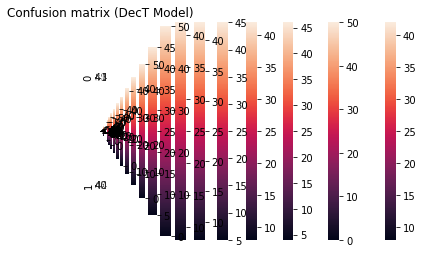

In [20]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    ## Creating and running our optimization

    # Creating and running our optimization

    study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
    with parallel_backend('threading'):
        study_dect.optimize(objective_dect, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_dect.best_trial.number)
    print("Best accuracy:", study_dect.best_trial.value)
    print("Best hyperparameters:", study_dect.best_params)

    best_param_dect = study_dect.best_params
    DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
    y_pred_dect = DecT.predict(x_test)


    display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")


    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(model=DecT, data= None, model_output= 'raw', feature_perturbation= 'tree_path_dependent')
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 0
    shap_values_array = abs(shap_values[:,:,0])

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)


# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

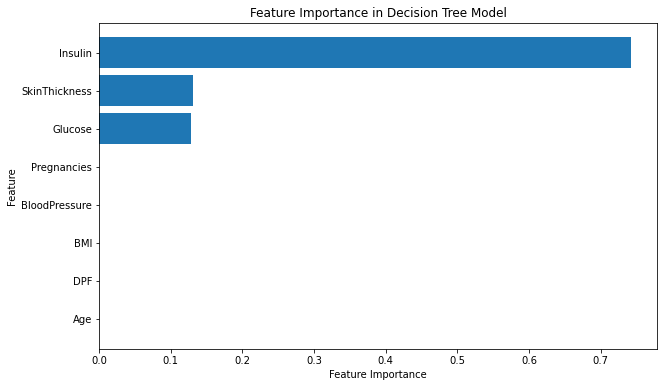

         Feature  Importance
4        Insulin    0.741380
3  SkinThickness    0.130616
1        Glucose    0.128004
0    Pregnancies    0.000000
2  BloodPressure    0.000000
5            BMI    0.000000
6            DPF    0.000000
7            Age    0.000000


In [21]:
# Get feature importances from the decision tree model
feature_importances = DecT.feature_importances_

# Get feature names
feature_names = x_train.columns

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()

# Print the DataFrame for detailed view
print(importance_df)

In [22]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [23]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('40_dt_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,1.992008,0.801261,2.889614,1.090725,0.291697,2.212348,1.583351,1.339400,1.525051
1,1.942169,0.718007,2.259810,1.192980,0.298882,1.689821,1.673632,1.347143,1.390305
2,1.942169,0.718007,2.259810,1.192980,0.298882,1.689821,1.673632,1.347143,1.390305
3,1.960414,0.722786,2.259810,1.182362,0.290487,1.977049,1.368870,1.338485,1.387533
4,1.671148,0.705266,2.328444,1.161172,0.420296,1.578336,1.653044,1.242884,1.345074
...,...,...,...,...,...,...,...,...,...
95,1.671148,0.705266,2.328444,1.161172,0.420296,1.578336,1.653044,1.242884,1.345074
96,1.942169,0.718007,2.259810,1.192980,0.298882,1.689821,1.673632,1.347143,1.390305
97,1.992008,0.801313,2.889614,1.085239,0.293396,2.212348,1.627658,1.339400,1.530122
98,1.960414,0.722786,2.259810,1.182362,0.290487,1.977049,1.368870,1.338485,1.387533


## 4.5 SVM (Support Vector Machine)

In [24]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [25]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 15:01:05,606] A new study created in memory with name: SVM
[I 2024-08-26 15:01:06,209] Trial 4 finished with value: 0.8325045677067903 and parameters: {'C': 1.6355573001407473, 'gamma': 0.1006609601966546}. Best is trial 4 with value: 0.8325045677067903.
[I 2024-08-26 15:01:06,232] Trial 3 finished with value: 0.8322749853973385 and parameters: {'C': 0.20050261984110826, 'gamma': 0.08058569493871445}. Best is trial 4 with value: 0.8325045677067903.
[I 2024-08-26 15:01:06,335] Trial 1 finished with value: 0.7961517961279289 and parameters: {'C': 61.245055883966856, 'gamma': 2.6018854235943555e-05}. Best is trial 4 with value: 0.8325045677067903.
[I 2024-08-26 15:01:06,515] Trial 5 finished with value: 0.7712997470179315 and parameters: {'C': 0.31097797183111364, 'gamma': 0.0008660454054960398}. Best is trial 4 with value: 0.8325045677067903.
[I 2024-08-26 15:01:06,586] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.08655939345547606, 'gamma': 1.7558

Best trial: 4
Best accuracy: 0.8325045677067903
Best hyperparameters: {'C': 1.6355573001407473, 'gamma': 0.1006609601966546}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 15:01:29,869] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.053179  0.157155       0.004940       0.001345  0.168345  0.002131   
1      0.023321  0.133631       0.001536       0.007655  0.151798  0.000655   
2      0.002417  0.123726       0.000107       0.035250  0.319583  0.007345   
3      0.022976  0.114405       0.001690       0.024762  0.291238  0.003476   
4      0.013536  0.051202       0.008893       0.005250  0.315869  0.012226   
..          ...       ...            ...            ...       ...       ...   
95     0.045024  0.025071       0.013952       0.032405  0.263762  0.011476   
96     0.006583  0.100202       0.009131       0.133845  0.125179  0.266750   
97     0.002488  0.561631       0.015250       0.136917  0.128583  0.088393   
98     0.023036  0.029298       0.007012       0.053226  0.408179  0.005179   
99     0.016286  0.142881       0.002167       0.048405  0.259905  0.012238   

         DPF       Age  Outcome  
0   0.008488  0.0

[I 2024-08-26 15:01:30,537] Trial 3 finished with value: 0.8374560189146025 and parameters: {'C': 10.239620193425019, 'gamma': 0.05314003461436972}. Best is trial 3 with value: 0.8374560189146025.
[I 2024-08-26 15:01:30,722] Trial 5 finished with value: 0.8217341304112376 and parameters: {'C': 345.92268679802964, 'gamma': 0.0017141637199264061}. Best is trial 3 with value: 0.8374560189146025.
[I 2024-08-26 15:01:30,746] Trial 4 finished with value: 0.8139835588408727 and parameters: {'C': 14.876938353504451, 'gamma': 0.40310497635379355}. Best is trial 3 with value: 0.8374560189146025.
[I 2024-08-26 15:01:30,820] Trial 0 finished with value: 0.7679003324926497 and parameters: {'C': 0.028223006149967467, 'gamma': 0.00637891847413354}. Best is trial 3 with value: 0.8374560189146025.
[I 2024-08-26 15:01:30,830] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.37319431700724015, 'gamma': 4.674800275361637e-05}. Best is trial 3 with value: 0.8374560189146025.
[I 2024-0

Best trial: 3
Best accuracy: 0.8374560189146025
Best hyperparameters: {'C': 10.239620193425019, 'gamma': 0.05314003461436972}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 15:01:42,459] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051131  0.155917       0.003798       0.007845  0.212155  0.007607   
1      0.015429  0.141405       0.008548       0.011310  0.167381  0.003548   
2      0.015798  0.096250       0.009940       0.033440  0.429750  0.022893   
3      0.027167  0.108262       0.003881       0.014381  0.297190  0.003762   
4      0.002000  0.045048       0.000595       0.001167  0.346643  0.010976   
..          ...       ...            ...            ...       ...       ...   
95     0.248714  0.096214       0.068024       0.110333  0.061333  0.102690   
96     0.025952  0.123905       0.015500       0.100429  0.179357  0.307190   
97     0.026762  0.588357       0.007762       0.120976  0.109262  0.050048   
98     0.031845  0.019869       0.012464       0.053440  0.416488  0.003774   
99     0.008726  0.150821       0.004679       0.050988  0.292607  0.013940   

         DPF       Age  Outcome  
0   0.000321  0.0

[I 2024-08-26 15:01:43,222] Trial 0 finished with value: 0.8186830923994813 and parameters: {'C': 91.88463327111081, 'gamma': 0.004229449082341474}. Best is trial 0 with value: 0.8186830923994813.
[I 2024-08-26 15:01:43,443] Trial 3 finished with value: 0.8149890033823901 and parameters: {'C': 224.16383972309694, 'gamma': 0.0037015356648540465}. Best is trial 0 with value: 0.8186830923994813.
[I 2024-08-26 15:01:43,456] Trial 2 finished with value: 0.7451410451187037 and parameters: {'C': 0.19531368780913136, 'gamma': 0.8551662857291127}. Best is trial 0 with value: 0.8186830923994813.
[I 2024-08-26 15:01:43,499] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0015504067166520977, 'gamma': 0.05736425697629343}. Best is trial 0 with value: 0.8186830923994813.
[I 2024-08-26 15:01:43,510] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0019712429806708585, 'gamma': 0.2813367140054678}. Best is trial 0 with value: 0.8186830923994813.
[I 2024-08

Best trial: 9
Best accuracy: 0.830046871193623
Best hyperparameters: {'C': 597.1670939848138, 'gamma': 0.007584222545552754}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 15:01:55,753] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.065750  0.161012       0.001726       0.010440  0.188988  0.007655   
1      0.003440  0.134750       0.003845       0.016440  0.155750  0.001774   
2      0.023738  0.124333       0.018048       0.026429  0.388548  0.013738   
3      0.025667  0.119976       0.005238       0.017833  0.303214  0.000857   
4      0.023060  0.052988       0.006440       0.001369  0.238083  0.002345   
..          ...       ...            ...            ...       ...       ...   
95     0.197964  0.127417       0.143131       0.119583  0.047321  0.104821   
96     0.024512  0.117036       0.001464       0.133988  0.186226  0.247798   
97     0.149643  0.545786       0.023000       0.180405  0.151881  0.048429   
98     0.031036  0.025631       0.010702       0.066179  0.370798  0.002869   
99     0.012226  0.127702       0.003512       0.040393  0.322560  0.001440   

         DPF       Age  Outcome  
0   0.021560  0.0

[I 2024-08-26 15:01:56,450] Trial 3 finished with value: 0.8194429633909885 and parameters: {'C': 12.943842048926463, 'gamma': 0.0011426966882511014}. Best is trial 3 with value: 0.8194429633909885.
[I 2024-08-26 15:01:56,616] Trial 4 finished with value: 0.8150344081775848 and parameters: {'C': 16.315917822920436, 'gamma': 0.30347288869140027}. Best is trial 3 with value: 0.8194429633909885.
[I 2024-08-26 15:01:56,829] Trial 2 finished with value: 0.770377797845338 and parameters: {'C': 0.06903184773566157, 'gamma': 0.0027061803467718897}. Best is trial 3 with value: 0.8194429633909885.
[I 2024-08-26 15:01:56,843] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.15489414199682333, 'gamma': 8.766289998597773e-05}. Best is trial 3 with value: 0.8194429633909885.
[I 2024-08-26 15:01:56,861] Trial 5 finished with value: 0.6302799985482064 and parameters: {'C': 0.01953547063406116, 'gamma': 0.005905283873344674}. Best is trial 3 with value: 0.8194429633909885.
[I 2024

Best trial: 8
Best accuracy: 0.8214394194109347
Best hyperparameters: {'C': 910.8283862398927, 'gamma': 5.291882061349649e-05}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 15:02:11,065] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031012  0.192512       0.002631       0.004750  0.099393  0.047155   
1      0.071095  0.161143       0.001857       0.110333  0.158714  0.002619   
2      0.051571  0.143262       0.010738       0.037690  0.196143  0.056738   
3      0.037631  0.158798       0.008512       0.038060  0.149083  0.036036   
4      0.000583  0.113560       0.007036       0.003607  0.173440  0.028845   
..          ...       ...            ...            ...       ...       ...   
95     0.265131  0.231298       0.016607       0.084798  0.018607  0.092488   
96     0.067833  0.124048       0.000190       0.158262  0.135810  0.096690   
97     0.093560  0.505893       0.074083       0.170750  0.129679  0.049798   
98     0.021690  0.241333       0.006048       0.056500  0.236405  0.090786   
99     0.031357  0.205405       0.002071       0.048167  0.320190  0.007238   

         DPF       Age  Outcome  
0   0.036750  0.0

[I 2024-08-26 15:02:11,735] Trial 3 finished with value: 0.835816684297511 and parameters: {'C': 0.3802285804160906, 'gamma': 0.09284603659761267}. Best is trial 3 with value: 0.835816684297511.
[I 2024-08-26 15:02:11,827] Trial 2 finished with value: 0.7953380516974455 and parameters: {'C': 68.4219905716058, 'gamma': 2.3692053049330238e-05}. Best is trial 3 with value: 0.835816684297511.
[I 2024-08-26 15:02:11,875] Trial 0 finished with value: 0.7951882268719892 and parameters: {'C': 3.4935482272283807, 'gamma': 0.0003284379127566683}. Best is trial 3 with value: 0.835816684297511.
[I 2024-08-26 15:02:12,126] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.001466334747660367, 'gamma': 0.0001553558949180804}. Best is trial 3 with value: 0.835816684297511.
[I 2024-08-26 15:02:12,132] Trial 1 finished with value: 0.5858440942772657 and parameters: {'C': 2.5358326887017446, 'gamma': 3.793954024739508e-05}. Best is trial 3 with value: 0.835816684297511.
[I 2024-08-26

Best trial: 3
Best accuracy: 0.835816684297511
Best hyperparameters: {'C': 0.3802285804160906, 'gamma': 0.09284603659761267}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:02:27,705] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038857  0.164214       0.003310       0.005595  0.133786  0.028024   
1      0.034631  0.132131       0.004536       0.040298  0.167893  0.006369   
2      0.019048  0.127905       0.063714       0.034095  0.206214  0.033452   
3      0.028976  0.129905       0.013143       0.042000  0.215667  0.012381   
4      0.000833  0.088548       0.032619       0.007929  0.207548  0.006976   
..          ...       ...            ...            ...       ...       ...   
95     0.000369  0.003464       0.032964       0.001226  0.217988  0.008060   
96     0.031405  0.087500       0.003881       0.156881  0.136238  0.152857   
97     0.165536  0.320393       0.006893       0.356583  0.085893  0.080488   
98     0.006286  0.107595       0.009976       0.061238  0.312690  0.048500   
99     0.026083  0.137512       0.004417       0.054131  0.340821  0.001369   

         DPF       Age  Outcome  
0   0.020262  0.0

[I 2024-08-26 15:02:28,417] Trial 1 finished with value: 0.8057173629624503 and parameters: {'C': 6.311747283875782, 'gamma': 0.0008612219914528331}. Best is trial 1 with value: 0.8057173629624503.
[I 2024-08-26 15:02:28,427] Trial 5 finished with value: 0.8171949541102562 and parameters: {'C': 4.1456161103472144, 'gamma': 0.002005360264651153}. Best is trial 5 with value: 0.8171949541102562.
[I 2024-08-26 15:02:28,670] Trial 2 finished with value: 0.7765710666505431 and parameters: {'C': 0.08612464620056018, 'gamma': 0.005950993957847747}. Best is trial 5 with value: 0.8171949541102562.
[I 2024-08-26 15:02:28,800] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.020912053039400275, 'gamma': 0.0003971187620945941}. Best is trial 5 with value: 0.8171949541102562.
[I 2024-08-26 15:02:28,810] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.19904032366281646, 'gamma': 1.1244521078346129e-05}. Best is trial 5 with value: 0.8171949541102562.
[I 20

Best trial: 9
Best accuracy: 0.8223601999483254
Best hyperparameters: {'C': 230.074734171579, 'gamma': 0.0006704610309726332}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 15:02:42,650] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031786  0.190024       0.001286       0.005190  0.092071  0.048429   
1      0.065190  0.157833       0.001833       0.106548  0.146810  0.002643   
2      0.051512  0.147202       0.008393       0.043060  0.191131  0.057655   
3      0.039488  0.158560       0.002917       0.043964  0.143083  0.037369   
4      0.001000  0.114786       0.003405       0.001333  0.159786  0.029690   
..          ...       ...            ...            ...       ...       ...   
95     0.252524  0.236690       0.003976       0.097024  0.018333  0.116405   
96     0.065786  0.127262       0.001952       0.173857  0.117833  0.103238   
97     0.206833  0.336762       0.007952       0.346167  0.024905  0.048476   
98     0.017345  0.237893       0.003988       0.068179  0.231060  0.093917   
99     0.033179  0.204250       0.000917       0.055655  0.308274  0.003560   

         DPF       Age  Outcome  
0   0.038143  0.0

[I 2024-08-26 15:02:43,442] Trial 1 finished with value: 0.8259047558777916 and parameters: {'C': 84.668715305211, 'gamma': 0.003027283179631131}. Best is trial 1 with value: 0.8259047558777916.
[I 2024-08-26 15:02:43,526] Trial 3 finished with value: 0.7953092093998526 and parameters: {'C': 0.6867355149104466, 'gamma': 0.0012722222799355601}. Best is trial 1 with value: 0.8259047558777916.
[I 2024-08-26 15:02:43,619] Trial 2 finished with value: 0.7767675183390392 and parameters: {'C': 0.051024124207822236, 'gamma': 0.010357941360748208}. Best is trial 1 with value: 0.8259047558777916.
[I 2024-08-26 15:02:43,707] Trial 5 finished with value: 0.7711391815558117 and parameters: {'C': 0.19670661384276777, 'gamma': 0.0013709849106029268}. Best is trial 1 with value: 0.8259047558777916.
[I 2024-08-26 15:02:43,775] Trial 4 finished with value: 0.5159185904584273 and parameters: {'C': 1.0056507451820278, 'gamma': 8.955248013717841e-05}. Best is trial 1 with value: 0.8259047558777916.
[I 2024

Best trial: 6
Best accuracy: 0.8302364130439525
Best hyperparameters: {'C': 395.1017622030917, 'gamma': 0.009483438524310252}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 15:02:56,244] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.065500  0.161238       0.001833       0.011524  0.187833  0.006167   
1      0.002107  0.132583       0.002893       0.015393  0.157607  0.000012   
2      0.022286  0.125024       0.025000       0.027310  0.396905  0.016643   
3      0.024833  0.116524       0.007048       0.018310  0.315381  0.002714   
4      0.023321  0.052560       0.008798       0.002131  0.243702  0.004726   
..          ...       ...            ...            ...       ...       ...   
95     0.203988  0.121488       0.121869       0.121821  0.037345  0.098345   
96     0.022036  0.120345       0.000964       0.130298  0.179655  0.258917   
97     0.157345  0.551440       0.019417       0.182940  0.135726  0.050702   
98     0.030655  0.025083       0.009512       0.068012  0.370845  0.002726   
99     0.012714  0.126667       0.003333       0.042714  0.328619  0.003548   

         DPF       Age  Outcome  
0   0.019619  0.0

[I 2024-08-26 15:02:56,945] Trial 0 finished with value: 0.8244639862834394 and parameters: {'C': 0.12437160482687329, 'gamma': 0.06296665345400516}. Best is trial 0 with value: 0.8244639862834394.
[I 2024-08-26 15:02:57,044] Trial 2 finished with value: 0.795761262226881 and parameters: {'C': 241.4269901953924, 'gamma': 0.16404154036155844}. Best is trial 0 with value: 0.8244639862834394.
[I 2024-08-26 15:02:57,142] Trial 4 finished with value: 0.8302097335306384 and parameters: {'C': 31.789766414393338, 'gamma': 0.02286690982977969}. Best is trial 4 with value: 0.8302097335306384.
[I 2024-08-26 15:02:57,309] Trial 3 finished with value: 0.7662252528597169 and parameters: {'C': 5.053969173537431, 'gamma': 2.843572732615935e-05}. Best is trial 4 with value: 0.8302097335306384.
[I 2024-08-26 15:02:57,317] Trial 1 finished with value: 0.7252447063170709 and parameters: {'C': 0.011887306804060223, 'gamma': 0.17228738796328671}. Best is trial 4 with value: 0.8302097335306384.
[I 2024-08-26

Best trial: 6
Best accuracy: 0.8310311080647446
Best hyperparameters: {'C': 168.68977225993618, 'gamma': 0.022049728837505122}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 15:03:09,344] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.072238  0.170048       0.000619       0.005262  0.149214  0.009500   
1      0.005071  0.128452       0.005571       0.028357  0.148357  0.001310   
2      0.026583  0.065512       0.014060       0.027345  0.464202  0.020750   
3      0.022298  0.121131       0.008988       0.014988  0.284964  0.009440   
4      0.011512  0.037821       0.014036       0.006036  0.357226  0.014179   
..          ...       ...            ...            ...       ...       ...   
95     0.277036  0.029179       0.126560       0.108536  0.029869  0.073250   
96     0.051798  0.449583       0.073774       0.030417  0.027798  0.071679   
97     0.026964  0.643821       0.005274       0.119702  0.092774  0.038274   
98     0.030440  0.015083       0.012869       0.068821  0.410726  0.002107   
99     0.041738  0.190310       0.019405       0.061976  0.268000  0.030357   

         DPF       Age  Outcome  
0   0.007238  0.0

[I 2024-08-26 15:03:10,091] Trial 4 finished with value: 0.8203061225358228 and parameters: {'C': 53.27872579404898, 'gamma': 0.005198134591068795}. Best is trial 4 with value: 0.8203061225358228.
[I 2024-08-26 15:03:10,226] Trial 0 finished with value: 0.7849557765103512 and parameters: {'C': 0.18007086325105343, 'gamma': 0.0033774827469413337}. Best is trial 4 with value: 0.8203061225358228.
[I 2024-08-26 15:03:10,359] Trial 3 finished with value: 0.7984301972688793 and parameters: {'C': 1.1624885169511296, 'gamma': 0.498033481610091}. Best is trial 4 with value: 0.8203061225358228.
[I 2024-08-26 15:03:10,425] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.12804250858482907, 'gamma': 0.0002988752155950976}. Best is trial 4 with value: 0.8203061225358228.
[I 2024-08-26 15:03:10,432] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.001068193883170846, 'gamma': 0.059411160993920825}. Best is trial 4 with value: 0.8203061225358228.
[I 2024-08

Best trial: 2
Best accuracy: 0.8297643867749493
Best hyperparameters: {'C': 403.56792873340487, 'gamma': 0.009868280344933724}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 15:03:22,218] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.067869  0.159298       0.001726       0.010988  0.190631  0.008488   
1      0.000214  0.130786       0.003690       0.018190  0.158952  0.002619   
2      0.027167  0.119024       0.036405       0.036167  0.447310  0.024595   
3      0.027298  0.115964       0.005821       0.019488  0.315893  0.002488   
4      0.025024  0.055000       0.007333       0.001024  0.249738  0.007310   
..          ...       ...            ...            ...       ...       ...   
95     0.210333  0.113357       0.120881       0.119619  0.034357  0.091262   
96     0.019869  0.120702       0.001440       0.128440  0.179321  0.263821   
97     0.141929  0.558571       0.018690       0.178643  0.126500  0.047095   
98     0.033179  0.021583       0.010226       0.070464  0.373131  0.000202   
99     0.013798  0.125893       0.002464       0.043012  0.323798  0.003750   

         DPF       Age  Outcome  
0   0.013250  0.0

[I 2024-08-26 15:03:22,905] Trial 3 finished with value: 0.8291799098282121 and parameters: {'C': 3.11655417813421, 'gamma': 0.013251886620399925}. Best is trial 3 with value: 0.8291799098282121.
[I 2024-08-26 15:03:23,092] Trial 1 finished with value: 0.8101588492279861 and parameters: {'C': 0.133949422044098, 'gamma': 0.35825055550381896}. Best is trial 3 with value: 0.8291799098282121.
[I 2024-08-26 15:03:23,268] Trial 5 finished with value: 0.762632896667033 and parameters: {'C': 0.012369004876980021, 'gamma': 0.026211583180649242}. Best is trial 3 with value: 0.8291799098282121.
[I 2024-08-26 15:03:23,279] Trial 0 finished with value: 0.6730722785646133 and parameters: {'C': 0.02452981378273003, 'gamma': 0.004819172963332403}. Best is trial 3 with value: 0.8291799098282121.
[I 2024-08-26 15:03:23,289] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.004598122556149411, 'gamma': 4.2402944309669405e-05}. Best is trial 3 with value: 0.8291799098282121.
[I 2024-0

Best trial: 3
Best accuracy: 0.8291799098282121
Best hyperparameters: {'C': 3.11655417813421, 'gamma': 0.013251886620399925}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:03:37,480] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039536  0.190274       0.000893       0.004583  0.112369  0.048298   
1      0.049774  0.155393       0.000202       0.076988  0.166464  0.003679   
2      0.043845  0.151512       0.007679       0.038107  0.223012  0.050060   
3      0.041250  0.150583       0.001893       0.040750  0.177440  0.033726   
4      0.005071  0.110905       0.002452       0.004976  0.185310  0.025619   
..          ...       ...            ...            ...       ...       ...   
95     0.197810  0.194000       0.016024       0.109500  0.029619  0.133548   
96     0.055571  0.117548       0.000690       0.170833  0.136452  0.130095   
97     0.194679  0.342250       0.000226       0.337845  0.002821  0.068917   
98     0.011190  0.192548       0.001714       0.059643  0.225357  0.075929   
99     0.026464  0.171869       0.000488       0.046226  0.323298  0.005321   

         DPF       Age  Outcome  
0   0.037298  0.0

[I 2024-08-26 15:03:38,194] Trial 1 finished with value: 0.8291675011265361 and parameters: {'C': 3.3978985439859763, 'gamma': 0.012775688094748982}. Best is trial 1 with value: 0.8291675011265361.
[I 2024-08-26 15:03:38,228] Trial 3 finished with value: 0.8222273112535067 and parameters: {'C': 1.0520881628131666, 'gamma': 0.008929178926569732}. Best is trial 1 with value: 0.8291675011265361.
[I 2024-08-26 15:03:38,311] Trial 5 finished with value: 0.7961992831435127 and parameters: {'C': 3.6750020047541643, 'gamma': 0.00032761591152301556}. Best is trial 1 with value: 0.8291675011265361.
[I 2024-08-26 15:03:38,584] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0011370831475880079, 'gamma': 0.0006860650535312734}. Best is trial 1 with value: 0.8291675011265361.
[I 2024-08-26 15:03:38,604] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0476999601677539, 'gamma': 3.0124987518281593e-05}. Best is trial 1 with value: 0.8291675011265361.
[I 2

Best trial: 1
Best accuracy: 0.8291675011265361
Best hyperparameters: {'C': 3.3978985439859763, 'gamma': 0.012775688094748982}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:03:52,681] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039702  0.190321       0.000298       0.003464  0.111060  0.048798   
1      0.049357  0.154905       0.000119       0.076262  0.165881  0.003714   
2      0.043631  0.151298       0.007774       0.038155  0.222940  0.051369   
3      0.041702  0.151964       0.002012       0.040488  0.177964  0.033536   
4      0.004988  0.111060       0.002274       0.003464  0.185131  0.025917   
..          ...       ...            ...            ...       ...       ...   
95     0.197274  0.194464       0.015607       0.109679  0.030179  0.135131   
96     0.056440  0.117940       0.000917       0.171655  0.136012  0.128345   
97     0.195500  0.342095       0.000310       0.338548  0.003071  0.069167   
98     0.011286  0.190238       0.002000       0.059833  0.225286  0.075643   
99     0.027333  0.171548       0.000905       0.045667  0.322857  0.005857   

         DPF       Age  Outcome  
0   0.036988  0.0

[I 2024-08-26 15:03:53,347] Trial 0 finished with value: 0.8164877655110422 and parameters: {'C': 721.2135420735157, 'gamma': 1.5199556714058589e-05}. Best is trial 0 with value: 0.8164877655110422.
[I 2024-08-26 15:03:53,359] Trial 2 finished with value: 0.8069965534462404 and parameters: {'C': 0.4908847400941093, 'gamma': 0.007614740792208068}. Best is trial 0 with value: 0.8164877655110422.
[I 2024-08-26 15:03:53,650] Trial 3 finished with value: 0.7741698420195342 and parameters: {'C': 0.3120603181784419, 'gamma': 0.00110158471821548}. Best is trial 0 with value: 0.8164877655110422.
[I 2024-08-26 15:03:53,747] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.02322729328542738, 'gamma': 0.0006049828414535258}. Best is trial 0 with value: 0.8164877655110422.
[I 2024-08-26 15:03:53,759] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0954825572718536, 'gamma': 0.0005900555124019302}. Best is trial 0 with value: 0.8164877655110422.
[I 2024-0

Best trial: 9
Best accuracy: 0.8338509874337251
Best hyperparameters: {'C': 1.0989577733440068, 'gamma': 0.05622153988872279}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:04:07,667] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043024  0.161619       0.005000       0.010619  0.142286  0.019952   
1      0.028488  0.131774       0.002345       0.031464  0.163321  0.006369   
2      0.011083  0.143631       0.010679       0.037107  0.247964  0.038012   
3      0.029976  0.127405       0.003143       0.039381  0.226833  0.017333   
4      0.002286  0.069619       0.008738       0.008214  0.228048  0.006310   
..          ...       ...            ...            ...       ...       ...   
95     0.004500  0.022167       0.004667       0.032333  0.264690  0.012357   
96     0.022202  0.093774       0.002250       0.158512  0.141393  0.150440   
97     0.103631  0.347560       0.109012       0.332107  0.074488  0.067631   
98     0.006679  0.074012       0.002417       0.064940  0.347155  0.034536   
99     0.028714  0.129548       0.004905       0.052667  0.336595  0.003667   

         DPF       Age  Outcome  
0   0.020833  0.0

[I 2024-08-26 15:04:08,406] Trial 2 finished with value: 0.8115474137727777 and parameters: {'C': 1.9680395155379669, 'gamma': 0.3163445367668102}. Best is trial 2 with value: 0.8115474137727777.
[I 2024-08-26 15:04:08,575] Trial 4 finished with value: 0.8232909557788161 and parameters: {'C': 679.1353939602407, 'gamma': 0.0006556751644694261}. Best is trial 4 with value: 0.8232909557788161.
[I 2024-08-26 15:04:08,710] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.01066670208172955, 'gamma': 3.510592569163789e-05}. Best is trial 4 with value: 0.8232909557788161.
[I 2024-08-26 15:04:08,716] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.002619860302633777, 'gamma': 0.05476609618474458}. Best is trial 4 with value: 0.8232909557788161.
[I 2024-08-26 15:04:09,212] Trial 6 finished with value: 0.8214394194109347 and parameters: {'C': 906.7163772876039, 'gamma': 5.303249376105363e-05}. Best is trial 4 with value: 0.8232909557788161.
[I 2024-08-

Best trial: 3
Best accuracy: 0.8315392367158081
Best hyperparameters: {'C': 871.8977832730327, 'gamma': 0.009045648636549433}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 15:04:21,047] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.086155  0.151893       0.007702       0.000250  0.166107  0.011583   
1      0.013536  0.119345       0.012131       0.018083  0.167917  0.005488   
2      0.024012  0.104012       0.040988       0.028702  0.471821  0.027631   
3      0.027881  0.111786       0.003167       0.015024  0.325095  0.004500   
4      0.017536  0.040321       0.022560       0.006417  0.329964  0.014298   
..          ...       ...            ...            ...       ...       ...   
95     0.275214  0.047500       0.138095       0.104000  0.045429  0.076548   
96     0.100786  0.339952       0.058119       0.014881  0.000643  0.103786   
97     0.094095  0.608119       0.011000       0.152833  0.092833  0.041381   
98     0.036452  0.009810       0.019000       0.074762  0.375762  0.005190   
99     0.019024  0.126286       0.000381       0.036310  0.307595  0.005571   

         DPF       Age  Outcome  
0   0.005107  0.0

[I 2024-08-26 15:04:21,916] Trial 0 finished with value: 0.7884002961615589 and parameters: {'C': 21.420578607083947, 'gamma': 2.8851222913590183e-05}. Best is trial 0 with value: 0.7884002961615589.
[I 2024-08-26 15:04:22,092] Trial 4 finished with value: 0.7897674064284138 and parameters: {'C': 783.6455678550491, 'gamma': 0.10915756461595066}. Best is trial 4 with value: 0.7897674064284138.
[I 2024-08-26 15:04:22,133] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.002966662581550387, 'gamma': 6.818837776471573e-05}. Best is trial 4 with value: 0.7897674064284138.
[I 2024-08-26 15:04:22,146] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.007221790735996387, 'gamma': 0.00011400337986495598}. Best is trial 4 with value: 0.7897674064284138.
[I 2024-08-26 15:04:22,153] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.010080245161917804, 'gamma': 0.0002472433378652024}. Best is trial 4 with value: 0.7897674064284138.
[I 

Best trial: 4
Best accuracy: 0.7897674064284138
Best hyperparameters: {'C': 783.6455678550491, 'gamma': 0.10915756461595066}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 15:04:34,057] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.119464  0.168488       0.040869       0.091417  0.137417  0.005750   
1      0.092476  0.091976       0.055262       0.091595  0.214190  0.080690   
2      0.041679  0.097940       0.080155       0.045155  0.319917  0.015560   
3      0.038643  0.132119       0.177095       0.053929  0.165167  0.033024   
4      0.013250  0.048607       0.068250       0.032702  0.304202  0.019750   
..          ...       ...            ...            ...       ...       ...   
95     0.068369  0.028655       0.312655       0.060940  0.183369  0.038298   
96     0.205238  0.450786       0.073119       0.082857  0.001619  0.086143   
97     0.021179  0.554869       0.035655       0.144821  0.147655  0.020369   
98     0.009917  0.080774       0.050012       0.131393  0.229869  0.023226   
99     0.020655  0.274607       0.008179       0.118012  0.107988  0.020726   

         DPF       Age  Outcome  
0   0.030869  0.0

[I 2024-08-26 15:04:34,788] Trial 5 finished with value: 0.8233324775210998 and parameters: {'C': 0.6401668404881394, 'gamma': 0.01840937343780904}. Best is trial 5 with value: 0.8233324775210998.
[I 2024-08-26 15:04:34,826] Trial 1 finished with value: 0.8270186315971131 and parameters: {'C': 18.229727506614925, 'gamma': 0.006450061768477581}. Best is trial 1 with value: 0.8270186315971131.
[I 2024-08-26 15:04:34,848] Trial 4 finished with value: 0.8261664216354764 and parameters: {'C': 0.15083409584212373, 'gamma': 0.06714062846760133}. Best is trial 1 with value: 0.8270186315971131.
[I 2024-08-26 15:04:34,905] Trial 0 finished with value: 0.7968767238167724 and parameters: {'C': 46.58834104439146, 'gamma': 3.0290580137571415e-05}. Best is trial 1 with value: 0.8270186315971131.
[I 2024-08-26 15:04:34,942] Trial 2 finished with value: 0.7939094193781315 and parameters: {'C': 1.5365564806892449, 'gamma': 0.00048353061577254247}. Best is trial 1 with value: 0.8270186315971131.
[I 2024-

Best trial: 1
Best accuracy: 0.8270186315971131
Best hyperparameters: {'C': 18.229727506614925, 'gamma': 0.006450061768477581}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 15:04:49,019] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039702  0.181512       0.003012       0.000536  0.116036  0.038607   
1      0.041774  0.146083       0.001845       0.072298  0.164845  0.002488   
2      0.039155  0.149845       0.004798       0.042655  0.223440  0.051655   
3      0.036905  0.143643       0.005690       0.041595  0.188524  0.025429   
4      0.005524  0.105119       0.001738       0.000429  0.192881  0.014905   
..          ...       ...            ...            ...       ...       ...   
95     0.088298  0.041107       0.145583       0.004155  0.184250  0.017845   
96     0.052440  0.114869       0.002131       0.172155  0.141464  0.114202   
97     0.173167  0.316952       0.002238       0.357810  0.034571  0.055190   
98     0.007810  0.171000       0.000976       0.069024  0.272833  0.060119   
99     0.032631  0.159417       0.003774       0.045274  0.339631  0.005250   

         DPF       Age  Outcome  
0   0.037583  0.0

[I 2024-08-26 15:04:49,949] Trial 5 finished with value: 0.7795845619150454 and parameters: {'C': 3.0240618006825866, 'gamma': 0.0001559693805509098}. Best is trial 5 with value: 0.7795845619150454.
[I 2024-08-26 15:04:50,076] Trial 0 finished with value: 0.7655883288643592 and parameters: {'C': 0.1936227226236976, 'gamma': 0.0007530852737213877}. Best is trial 5 with value: 0.7795845619150454.
[I 2024-08-26 15:04:50,089] Trial 3 finished with value: 0.7766783195237259 and parameters: {'C': 261.5639378664613, 'gamma': 0.6456199273667251}. Best is trial 5 with value: 0.7795845619150454.
[I 2024-08-26 15:04:50,111] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.024418994671958367, 'gamma': 0.00021869048367968458}. Best is trial 5 with value: 0.7795845619150454.
[I 2024-08-26 15:04:50,146] Trial 2 finished with value: 0.7555925672089333 and parameters: {'C': 93.45612057584151, 'gamma': 0.7468738802488631}. Best is trial 5 with value: 0.7795845619150454.
[I 2024-08-

Best trial: 8
Best accuracy: 0.8226204202016659
Best hyperparameters: {'C': 728.858418134351, 'gamma': 0.00046199779427559095}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 15:05:04,863] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031917  0.195393       0.000583       0.005345  0.090250  0.048940   
1      0.065500  0.159333       0.002262       0.098643  0.145500  0.002262   
2      0.050762  0.150310       0.014000       0.041976  0.188476  0.055929   
3      0.041274  0.160345       0.007131       0.042845  0.142083  0.035893   
4      0.002798  0.117631       0.005940       0.003821  0.156345  0.030655   
..          ...       ...            ...            ...       ...       ...   
95     0.246000  0.231619       0.000786       0.099071  0.018214  0.112048   
96     0.068643  0.127643       0.000833       0.178976  0.112881  0.107738   
97     0.212893  0.327321       0.005774       0.359321  0.006702  0.045488   
98     0.013167  0.237690       0.006214       0.075429  0.198667  0.095095   
99     0.037024  0.205476       0.000548       0.055310  0.300619  0.008286   

         DPF       Age  Outcome  
0   0.037774  0.0

[I 2024-08-26 15:05:05,502] Trial 1 finished with value: 0.8370348181484331 and parameters: {'C': 1.504058634775666, 'gamma': 0.12475638794861352}. Best is trial 1 with value: 0.8370348181484331.
[I 2024-08-26 15:05:05,514] Trial 5 finished with value: 0.8205632977877823 and parameters: {'C': 3.5195721296560314, 'gamma': 0.003921153779980335}. Best is trial 1 with value: 0.8370348181484331.
[I 2024-08-26 15:05:05,627] Trial 3 finished with value: 0.7978823358614793 and parameters: {'C': 45.6120882892122, 'gamma': 4.004498327245936e-05}. Best is trial 1 with value: 0.8370348181484331.
[I 2024-08-26 15:05:05,847] Trial 2 finished with value: 0.7640836410652851 and parameters: {'C': 0.016460689683153513, 'gamma': 0.07960752682944708}. Best is trial 1 with value: 0.8370348181484331.
[I 2024-08-26 15:05:05,948] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.004808025649564245, 'gamma': 0.0016026444231365066}. Best is trial 1 with value: 0.8370348181484331.
[I 2024-08

Best trial: 1
Best accuracy: 0.8370348181484331
Best hyperparameters: {'C': 1.504058634775666, 'gamma': 0.12475638794861352}
              precision    recall  f1-score   support

           0       0.76      0.90      0.83        50
           1       0.88      0.72      0.79        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100



[I 2024-08-26 15:05:20,022] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038452  0.145762       0.006667       0.005357  0.214548  0.006000   
1      0.025929  0.122500       0.000595       0.001048  0.152143  0.002357   
2      0.000690  0.116905       0.008262       0.036810  0.312714  0.008905   
3      0.027774  0.109869       0.001774       0.027440  0.290702  0.007274   
4      0.014595  0.050095       0.017667       0.004762  0.316857  0.016571   
..          ...       ...            ...            ...       ...       ...   
95     0.054012  0.019488       0.007250       0.034440  0.258179  0.010964   
96     0.015000  0.101476       0.011833       0.120143  0.119881  0.297857   
97     0.001036  0.571131       0.023964       0.124250  0.123321  0.075488   
98     0.020940  0.029107       0.008298       0.055036  0.414226  0.005202   
99     0.018012  0.150560       0.001536       0.051464  0.260679  0.015155   

         DPF       Age  Outcome  
0   0.013310  0.0

[I 2024-08-26 15:05:20,703] Trial 1 finished with value: 0.8214415049112005 and parameters: {'C': 3.4673759456509723, 'gamma': 0.006165032920074711}. Best is trial 1 with value: 0.8214415049112005.
[I 2024-08-26 15:05:20,778] Trial 3 finished with value: 0.8194661057892741 and parameters: {'C': 30.655711593784517, 'gamma': 0.008467716424180828}. Best is trial 1 with value: 0.8214415049112005.
[I 2024-08-26 15:05:20,788] Trial 0 finished with value: 0.8026094455359329 and parameters: {'C': 88.9968131571596, 'gamma': 3.7523267671720644e-05}. Best is trial 1 with value: 0.8214415049112005.
[I 2024-08-26 15:05:20,910] Trial 2 finished with value: 0.7950158482179984 and parameters: {'C': 0.33168746774304453, 'gamma': 0.0036787232971414747}. Best is trial 1 with value: 0.8214415049112005.
[I 2024-08-26 15:05:21,119] Trial 5 finished with value: 0.7859390002917539 and parameters: {'C': 289.51495413117146, 'gamma': 0.5899463858644379}. Best is trial 1 with value: 0.8214415049112005.
[I 2024-08

Best trial: 1
Best accuracy: 0.8214415049112005
Best hyperparameters: {'C': 3.4673759456509723, 'gamma': 0.006165032920074711}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 15:05:35,900] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029012  0.196250       0.000655       0.000226  0.093560  0.046583   
1      0.055857  0.159214       0.001071       0.088214  0.146833  0.004024   
2      0.046071  0.153143       0.007024       0.039762  0.191714  0.060024   
3      0.035964  0.159845       0.003417       0.040179  0.145464  0.038488   
4      0.000619  0.114786       0.003857       0.000333  0.161738  0.029119   
..          ...       ...            ...            ...       ...       ...   
95     0.250155  0.233750       0.000179       0.093750  0.018940  0.123464   
96     0.065940  0.128488       0.000607       0.154821  0.121988  0.113298   
97     0.223929  0.365310       0.005929       0.315929  0.010238  0.069667   
98     0.015000  0.239524       0.003333       0.059048  0.234524  0.094000   
99     0.033714  0.205833       0.000071       0.049738  0.316143  0.007071   

         DPF       Age  Outcome  
0   0.036012  0.0

[I 2024-08-26 15:05:36,627] Trial 5 finished with value: 0.813338093319182 and parameters: {'C': 1.5743287299602555, 'gamma': 0.22828109500493834}. Best is trial 5 with value: 0.813338093319182.
[I 2024-08-26 15:05:36,666] Trial 4 finished with value: 0.8266531312944139 and parameters: {'C': 37.657250865007775, 'gamma': 0.004312619502436881}. Best is trial 4 with value: 0.8266531312944139.
[I 2024-08-26 15:05:36,758] Trial 1 finished with value: 0.7971945976286223 and parameters: {'C': 3.642102435200107, 'gamma': 0.0003853134640489426}. Best is trial 4 with value: 0.8266531312944139.
[I 2024-08-26 15:05:36,791] Trial 0 finished with value: 0.7915130540554969 and parameters: {'C': 0.23601886803153743, 'gamma': 0.0029279034855293376}. Best is trial 4 with value: 0.8266531312944139.
[I 2024-08-26 15:05:37,040] Trial 2 finished with value: 0.697765095639332 and parameters: {'C': 0.011832744317358474, 'gamma': 0.2432999571258455}. Best is trial 4 with value: 0.8266531312944139.
[I 2024-08-2

Best trial: 4
Best accuracy: 0.8266531312944139
Best hyperparameters: {'C': 37.657250865007775, 'gamma': 0.004312619502436881}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 15:05:50,647] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039655  0.182202       0.003345       0.001536  0.116488  0.038607   
1      0.040881  0.148976       0.003167       0.071310  0.158833  0.002881   
2      0.039476  0.146833       0.008071       0.041095  0.217333  0.050881   
3      0.036952  0.144667       0.005286       0.041095  0.185071  0.025452   
4      0.004571  0.106476       0.000738       0.000429  0.188667  0.017452   
..          ...       ...            ...            ...       ...       ...   
95     0.086571  0.038500       0.138143       0.003286  0.187571  0.016905   
96     0.051607  0.113298       0.001988       0.170298  0.140298  0.117631   
97     0.171643  0.321429       0.002500       0.358167  0.034190  0.054548   
98     0.012048  0.173976       0.000214       0.069476  0.268452  0.060190   
99     0.032024  0.159619       0.004024       0.044952  0.338929  0.005619   

         DPF       Age  Outcome  
0   0.038298  0.0

[I 2024-08-26 15:05:51,354] Trial 0 finished with value: 0.8059596652535803 and parameters: {'C': 8.534063727281463, 'gamma': 0.0005364502022715047}. Best is trial 0 with value: 0.8059596652535803.
[I 2024-08-26 15:05:51,374] Trial 3 finished with value: 0.8301777395267235 and parameters: {'C': 0.13777623693730032, 'gamma': 0.10463241379891258}. Best is trial 3 with value: 0.8301777395267235.
[I 2024-08-26 15:05:51,486] Trial 1 finished with value: 0.822064929587238 and parameters: {'C': 131.25220557483223, 'gamma': 0.00281568975059957}. Best is trial 3 with value: 0.8301777395267235.
[I 2024-08-26 15:05:51,733] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 1.4483282158230846, 'gamma': 1.6787772193629484e-05}. Best is trial 3 with value: 0.8301777395267235.
[I 2024-08-26 15:05:51,745] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.014084201347217783, 'gamma': 6.471876443769904e-05}. Best is trial 3 with value: 0.8301777395267235.
[I 2024-0

Best trial: 7
Best accuracy: 0.8320817549482968
Best hyperparameters: {'C': 2.8280707108291976, 'gamma': 0.028285890794542398}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:06:05,431] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042214  0.170310       0.002190       0.008952  0.129738  0.018714   
1      0.023500  0.151095       0.001262       0.036357  0.155810  0.004857   
2      0.013857  0.151000       0.005810       0.034167  0.242048  0.032190   
3      0.026536  0.137560       0.007821       0.035917  0.214655  0.014869   
4      0.001595  0.077071       0.001833       0.007476  0.220595  0.006119   
..          ...       ...            ...            ...       ...       ...   
95     0.013155  0.025179       0.013393       0.032583  0.274583  0.016131   
96     0.027071  0.101833       0.000524       0.173667  0.138119  0.133571   
97     0.096048  0.322548       0.065857       0.370357  0.089786  0.065310   
98     0.009762  0.091667       0.000214       0.067310  0.331976  0.035548   
99     0.027036  0.141893       0.004155       0.047726  0.334250  0.002060   

         DPF       Age  Outcome  
0   0.020357  0.0

[I 2024-08-26 15:06:06,244] Trial 2 finished with value: 0.8358045044571247 and parameters: {'C': 13.663363185917426, 'gamma': 0.03856579072256764}. Best is trial 2 with value: 0.8358045044571247.
[I 2024-08-26 15:06:06,444] Trial 0 finished with value: 0.7645735720084116 and parameters: {'C': 0.01936593090475906, 'gamma': 0.02871201987258565}. Best is trial 2 with value: 0.8358045044571247.
[I 2024-08-26 15:06:06,462] Trial 1 finished with value: 0.73042163778336 and parameters: {'C': 0.022713856504956876, 'gamma': 0.20793990281932287}. Best is trial 2 with value: 0.8358045044571247.
[I 2024-08-26 15:06:06,496] Trial 3 finished with value: 0.7988929526618987 and parameters: {'C': 0.6177715088237864, 'gamma': 0.5308331876205775}. Best is trial 2 with value: 0.8358045044571247.
[I 2024-08-26 15:06:06,510] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.007535464669476233, 'gamma': 0.001775278820272828}. Best is trial 2 with value: 0.8358045044571247.
[I 2024-08-26

Best trial: 2
Best accuracy: 0.8358045044571247
Best hyperparameters: {'C': 13.663363185917426, 'gamma': 0.03856579072256764}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 15:06:19,100] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.070893  0.160583       0.003250       0.003155  0.168369  0.000155   
1      0.018917  0.141940       0.001440       0.005060  0.169369  0.000321   
2      0.007405  0.091810       0.022762       0.027381  0.365333  0.003476   
3      0.027679  0.109702       0.003417       0.014012  0.300536  0.000560   
4      0.003571  0.048833       0.003833       0.003452  0.315238  0.016286   
..          ...       ...            ...            ...       ...       ...   
95     0.231119  0.118881       0.081357       0.109000  0.055786  0.112714   
96     0.011167  0.095929       0.011381       0.126619  0.139476  0.270214   
97     0.041190  0.558286       0.005595       0.145143  0.125143  0.064238   
98     0.030798  0.021845       0.006702       0.056107  0.382036  0.011869   
99     0.000762  0.132833       0.002238       0.042190  0.318190  0.007500   

         DPF       Age  Outcome  
0   0.002655  0.0

[I 2024-08-26 15:06:19,777] Trial 4 finished with value: 0.833196232545653 and parameters: {'C': 0.6655573611333144, 'gamma': 0.03409731829086626}. Best is trial 4 with value: 0.833196232545653.
[I 2024-08-26 15:06:19,786] Trial 3 finished with value: 0.8313996742269212 and parameters: {'C': 1.0684884799371153, 'gamma': 0.023553597700641304}. Best is trial 4 with value: 0.833196232545653.
[I 2024-08-26 15:06:19,809] Trial 5 finished with value: 0.820100149300232 and parameters: {'C': 91.7405335324367, 'gamma': 0.0003398804734105086}. Best is trial 4 with value: 0.833196232545653.
[I 2024-08-26 15:06:20,015] Trial 0 finished with value: 0.7925111088965552 and parameters: {'C': 118.59715301504473, 'gamma': 0.12704093451925794}. Best is trial 4 with value: 0.833196232545653.
[I 2024-08-26 15:06:20,198] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.8939587571702593, 'gamma': 5.188811589967881e-05}. Best is trial 4 with value: 0.833196232545653.
[I 2024-08-26 15:06:

Best trial: 4
Best accuracy: 0.833196232545653
Best hyperparameters: {'C': 0.6655573611333144, 'gamma': 0.03409731829086626}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 15:06:36,924] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044833  0.189214       0.000619       0.004619  0.115786  0.043095   
1      0.052905  0.154619       0.001905       0.071881  0.176310  0.000405   
2      0.044917  0.152845       0.019988       0.039298  0.218393  0.047774   
3      0.045512  0.148488       0.004464       0.040369  0.186179  0.027583   
4      0.008881  0.110333       0.007500       0.005595  0.191786  0.020595   
..          ...       ...            ...            ...       ...       ...   
95     0.201464  0.185702       0.013917       0.108750  0.039607  0.144393   
96     0.059440  0.108202       0.000226       0.179512  0.122774  0.125583   
97     0.193690  0.326714       0.002762       0.356048  0.033286  0.062548   
98     0.013929  0.176238       0.003381       0.063905  0.269548  0.057357   
99     0.028274  0.164298       0.000726       0.048060  0.321536  0.007417   

         DPF       Age  Outcome  
0   0.031476  0.0

[I 2024-08-26 15:06:37,592] Trial 4 finished with value: 0.8219442516371896 and parameters: {'C': 4.443307538101444, 'gamma': 0.006819574873501972}. Best is trial 4 with value: 0.8219442516371896.
[I 2024-08-26 15:06:37,666] Trial 3 finished with value: 0.7998745268971286 and parameters: {'C': 44.56472253079968, 'gamma': 5.33532917426542e-05}. Best is trial 4 with value: 0.8219442516371896.
[I 2024-08-26 15:06:38,058] Trial 0 finished with value: 0.5442825766094201 and parameters: {'C': 0.8979228596443494, 'gamma': 0.00010304804203909632}. Best is trial 4 with value: 0.8219442516371896.
[I 2024-08-26 15:06:38,066] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.11716598308471131, 'gamma': 0.00023324311178846225}. Best is trial 4 with value: 0.8219442516371896.
[I 2024-08-26 15:06:38,430] Trial 6 finished with value: 0.7961167241097341 and parameters: {'C': 895.4257949759316, 'gamma': 0.1576645662339649}. Best is trial 4 with value: 0.8219442516371896.
[I 2024-08-

Best trial: 9
Best accuracy: 0.832066133492002
Best hyperparameters: {'C': 2.3480454962276265, 'gamma': 0.03274086115989885}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:06:52,872] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043619  0.168190       0.001690       0.009881  0.128857  0.018714   
1      0.022214  0.149952       0.000952       0.035405  0.154762  0.005381   
2      0.011512  0.151440       0.003060       0.034250  0.243774  0.031226   
3      0.026048  0.136952       0.008262       0.036000  0.214452  0.014357   
4      0.003500  0.076833       0.001905       0.007667  0.219000  0.006286   
..          ...       ...            ...            ...       ...       ...   
95     0.012607  0.028131       0.012012       0.034821  0.276036  0.016107   
96     0.024905  0.100024       0.001024       0.171500  0.138190  0.135119   
97     0.084167  0.319857       0.064405       0.369000  0.089429  0.072143   
98     0.009774  0.091179       0.000345       0.066583  0.335083  0.034917   
99     0.026762  0.138500       0.003262       0.048571  0.333786  0.001667   

         DPF       Age  Outcome  
0   0.018833  0.0

[I 2024-08-26 15:06:53,564] Trial 5 finished with value: 0.8278574850608635 and parameters: {'C': 4.520677279007391, 'gamma': 0.013433853479941672}. Best is trial 5 with value: 0.8278574850608635.
[I 2024-08-26 15:06:53,587] Trial 1 finished with value: 0.816074125717319 and parameters: {'C': 182.2130461613181, 'gamma': 6.287513379702188e-05}. Best is trial 5 with value: 0.8278574850608635.
[I 2024-08-26 15:06:54,029] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0022437632802258267, 'gamma': 2.5102019862183558e-05}. Best is trial 5 with value: 0.8278574850608635.
[I 2024-08-26 15:06:54,034] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0018220490551494862, 'gamma': 3.467857696566901e-05}. Best is trial 5 with value: 0.8278574850608635.
[I 2024-08-26 15:06:54,046] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 1.9205760255628956, 'gamma': 2.4703140245873377e-05}. Best is trial 5 with value: 0.8278574850608635.
[I 2

Best trial: 5
Best accuracy: 0.8278574850608635
Best hyperparameters: {'C': 4.520677279007391, 'gamma': 0.013433853479941672}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 15:07:08,763] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038464  0.182321       0.000536       0.000012  0.119369  0.039083   
1      0.039333  0.146071       0.000024       0.068262  0.168333  0.002810   
2      0.037048  0.151595       0.009190       0.040976  0.224524  0.050738   
3      0.038333  0.144690       0.001810       0.040381  0.189333  0.025238   
4      0.005690  0.106143       0.002024       0.000643  0.191405  0.016714   
..          ...       ...            ...            ...       ...       ...   
95     0.084488  0.033298       0.136036       0.001440  0.189607  0.014536   
96     0.049881  0.112857       0.001952       0.166929  0.143357  0.122119   
97     0.185917  0.327964       0.000607       0.349131  0.039250  0.059298   
98     0.008702  0.167060       0.000655       0.062560  0.276464  0.056726   
99     0.029607  0.158107       0.002893       0.044369  0.335893  0.005536   

         DPF       Age  Outcome  
0   0.034798  0.0

[I 2024-08-26 15:07:09,656] Trial 1 finished with value: 0.8167006631263098 and parameters: {'C': 274.05623477562204, 'gamma': 4.6897466626378205e-05}. Best is trial 1 with value: 0.8167006631263098.
[I 2024-08-26 15:07:09,667] Trial 3 finished with value: 0.8215966253520761 and parameters: {'C': 29.859044639551445, 'gamma': 0.002371160827749776}. Best is trial 3 with value: 0.8215966253520761.
[I 2024-08-26 15:07:09,818] Trial 2 finished with value: 0.8038893912417971 and parameters: {'C': 0.0416995845959381, 'gamma': 0.06779946458511478}. Best is trial 3 with value: 0.8215966253520761.
[I 2024-08-26 15:07:10,191] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0011391169445837085, 'gamma': 0.2745621314594738}. Best is trial 3 with value: 0.8215966253520761.
[I 2024-08-26 15:07:10,204] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.009911072633740957, 'gamma': 4.276107793168382e-05}. Best is trial 3 with value: 0.8215966253520761.
[I 2024

Best trial: 5
Best accuracy: 0.830848055141908
Best hyperparameters: {'C': 266.6980253804684, 'gamma': 0.011893080712025963}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 15:07:23,180] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.066476  0.158095       0.001143       0.009643  0.191119  0.008310   
1      0.000488  0.135202       0.004298       0.015488  0.160036  0.002512   
2      0.027440  0.115179       0.038345       0.036107  0.454893  0.026679   
3      0.027167  0.116500       0.006381       0.020381  0.316810  0.005000   
4      0.017369  0.048155       0.015226       0.002607  0.294298  0.015155   
..          ...       ...            ...            ...       ...       ...   
95     0.220262  0.104429       0.114048       0.108143  0.020976  0.088095   
96     0.016571  0.121452       0.004381       0.124881  0.179048  0.267214   
97     0.137405  0.563548       0.018762       0.174381  0.117286  0.051619   
98     0.032810  0.021952       0.011548       0.069071  0.375952  0.000762   
99     0.014167  0.127024       0.002619       0.045214  0.325452  0.004643   

         DPF       Age  Outcome  
0   0.012214  0.0

[I 2024-08-26 15:07:23,843] Trial 3 finished with value: 0.8348191646167933 and parameters: {'C': 0.6074177460640735, 'gamma': 0.06400148789325352}. Best is trial 3 with value: 0.8348191646167933.
[I 2024-08-26 15:07:23,875] Trial 1 finished with value: 0.8177333297483014 and parameters: {'C': 1.5183665113627924, 'gamma': 0.004980891040089986}. Best is trial 3 with value: 0.8348191646167933.
[I 2024-08-26 15:07:23,883] Trial 0 finished with value: 0.8214238833810543 and parameters: {'C': 174.20542284775883, 'gamma': 0.00021248159695413552}. Best is trial 3 with value: 0.8348191646167933.
[I 2024-08-26 15:07:23,898] Trial 5 finished with value: 0.8109886730083621 and parameters: {'C': 0.47408750225142815, 'gamma': 0.010667586575399277}. Best is trial 3 with value: 0.8348191646167933.
[I 2024-08-26 15:07:24,051] Trial 2 finished with value: 0.7907961919453887 and parameters: {'C': 0.045296620865120485, 'gamma': 0.01882223829565679}. Best is trial 3 with value: 0.8348191646167933.
[I 2024

Best trial: 3
Best accuracy: 0.8348191646167933
Best hyperparameters: {'C': 0.6074177460640735, 'gamma': 0.06400148789325352}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:07:39,228] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.040690  0.161738       0.002310       0.007071  0.144143  0.025048   
1      0.036357  0.134929       0.002595       0.044952  0.172190  0.005810   
2      0.016762  0.136833       0.044524       0.037048  0.219643  0.039762   
3      0.029833  0.125000       0.011929       0.038333  0.213452  0.013952   
4      0.002667  0.084690       0.027238       0.006476  0.209167  0.009381   
..          ...       ...            ...            ...       ...       ...   
95     0.029083  0.004250       0.026512       0.002488  0.211250  0.004345   
96     0.032810  0.086667       0.001357       0.157119  0.140786  0.141738   
97     0.164369  0.341060       0.006488       0.337536  0.044702  0.075726   
98     0.006738  0.101429       0.011143       0.059333  0.316095  0.048833   
99     0.024381  0.135405       0.001000       0.052310  0.340643  0.001786   

         DPF       Age  Outcome  
0   0.023238  0.0

[I 2024-08-26 15:07:39,900] Trial 0 finished with value: 0.8185674517309769 and parameters: {'C': 10.89554439697571, 'gamma': 0.0011493538404173528}. Best is trial 0 with value: 0.8185674517309769.
[I 2024-08-26 15:07:39,921] Trial 4 finished with value: 0.8218088823543164 and parameters: {'C': 292.0179839278774, 'gamma': 0.00017014706458786446}. Best is trial 4 with value: 0.8218088823543164.
[I 2024-08-26 15:07:40,087] Trial 2 finished with value: 0.7955232846859335 and parameters: {'C': 8.437028722936116, 'gamma': 0.00011034063371424748}. Best is trial 4 with value: 0.8218088823543164.
[I 2024-08-26 15:07:40,254] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.008848310931689043, 'gamma': 2.327066677725827e-05}. Best is trial 4 with value: 0.8218088823543164.
[I 2024-08-26 15:07:40,264] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.3324264430436779, 'gamma': 1.5051526821562424e-05}. Best is trial 4 with value: 0.8218088823543164.
[I 20

Best trial: 4
Best accuracy: 0.8218088823543164
Best hyperparameters: {'C': 292.0179839278774, 'gamma': 0.00017014706458786446}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 15:07:54,496] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031893  0.193893       0.002417       0.004393  0.098345  0.046083   
1      0.069321  0.161893       0.001750       0.106464  0.155226  0.001917   
2      0.050810  0.146500       0.009881       0.037452  0.194929  0.056571   
3      0.037548  0.158810       0.008381       0.037548  0.147167  0.036833   
4      0.000560  0.114321       0.007060       0.003607  0.172869  0.028821   
..          ...       ...            ...            ...       ...       ...   
95     0.263500  0.233667       0.014976       0.084238  0.017476  0.092048   
96     0.068000  0.125500       0.000143       0.162333  0.134381  0.096643   
97     0.092476  0.508595       0.073024       0.170524  0.130143  0.049643   
98     0.021738  0.243524       0.005548       0.056119  0.236595  0.088548   
99     0.030738  0.207595       0.001643       0.048738  0.317119  0.008429   

         DPF       Age  Outcome  
0   0.036393  0.0

[I 2024-08-26 15:07:55,231] Trial 0 finished with value: 0.822635315936934 and parameters: {'C': 13.427598452852909, 'gamma': 0.003610018907740586}. Best is trial 0 with value: 0.822635315936934.
[I 2024-08-26 15:07:55,295] Trial 4 finished with value: 0.7996221776833261 and parameters: {'C': 199.85388147292826, 'gamma': 1.072763858205257e-05}. Best is trial 0 with value: 0.822635315936934.
[I 2024-08-26 15:07:55,334] Trial 5 finished with value: 0.7952264150525176 and parameters: {'C': 2.2382179318429523, 'gamma': 0.0006987331635239697}. Best is trial 0 with value: 0.822635315936934.
[I 2024-08-26 15:07:55,348] Trial 2 finished with value: 0.7959282325766339 and parameters: {'C': 19.413476063689664, 'gamma': 7.325216323142833e-05}. Best is trial 0 with value: 0.822635315936934.
[I 2024-08-26 15:07:55,499] Trial 3 finished with value: 0.7743800154500984 and parameters: {'C': 0.06283454331960127, 'gamma': 0.006086374801004919}. Best is trial 0 with value: 0.822635315936934.
[I 2024-08-2

Best trial: 0
Best accuracy: 0.822635315936934
Best hyperparameters: {'C': 13.427598452852909, 'gamma': 0.003610018907740586}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 15:08:10,168] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029476  0.194952       0.000143       0.003071  0.091571  0.049810   
1      0.059060  0.160702       0.001631       0.091774  0.149060  0.004369   
2      0.048798  0.152440       0.009821       0.040202  0.195964  0.059512   
3      0.036810  0.158643       0.004333       0.041333  0.146333  0.039762   
4      0.002702  0.116155       0.004202       0.002821  0.160155  0.031226   
..          ...       ...            ...            ...       ...       ...   
95     0.241357  0.227929       0.000333       0.096357  0.021524  0.127286   
96     0.065179  0.122488       0.000440       0.163036  0.116417  0.115369   
97     0.206869  0.334702       0.005440       0.346321  0.013821  0.061417   
98     0.012917  0.233226       0.005583       0.069060  0.200940  0.098488   
99     0.035679  0.201512       0.000274       0.052274  0.308298  0.011036   

         DPF       Age  Outcome  
0   0.035071  0.0

[I 2024-08-26 15:08:10,837] Trial 5 finished with value: 0.824190716569007 and parameters: {'C': 0.38330115214363725, 'gamma': 0.02339923109284972}. Best is trial 5 with value: 0.824190716569007.
[I 2024-08-26 15:08:10,846] Trial 4 finished with value: 0.8160708301729724 and parameters: {'C': 339.8994543923127, 'gamma': 3.429779159657507e-05}. Best is trial 5 with value: 0.824190716569007.
[I 2024-08-26 15:08:10,855] Trial 0 finished with value: 0.8214948364522763 and parameters: {'C': 3.526671900088384, 'gamma': 0.005447789300026019}. Best is trial 5 with value: 0.824190716569007.
[I 2024-08-26 15:08:10,976] Trial 2 finished with value: 0.8131837125584402 and parameters: {'C': 0.06185110213639222, 'gamma': 0.1479651399626031}. Best is trial 5 with value: 0.824190716569007.
[I 2024-08-26 15:08:11,181] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.004399397412797101, 'gamma': 2.1349756027796365e-05}. Best is trial 5 with value: 0.824190716569007.
[I 2024-08-26 1

Best trial: 5
Best accuracy: 0.824190716569007
Best hyperparameters: {'C': 0.38330115214363725, 'gamma': 0.02339923109284972}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 15:08:27,597] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033083  0.198726       0.000702       0.002036  0.088560  0.041679   
1      0.059833  0.159548       0.000929       0.081976  0.144143  0.003762   
2      0.047190  0.150262       0.014929       0.035619  0.176381  0.053500   
3      0.040060  0.157464       0.004702       0.038131  0.142226  0.031369   
4      0.002369  0.118250       0.006393       0.000536  0.152774  0.027798   
..          ...       ...            ...            ...       ...       ...   
95     0.252107  0.216940       0.006726       0.107798  0.002298  0.123679   
96     0.068083  0.122774       0.000798       0.153821  0.122845  0.106940   
97     0.214488  0.358750       0.005321       0.327250  0.011345  0.061226   
98     0.023429  0.242214       0.007310       0.062595  0.237738  0.082786   
99     0.031714  0.214452       0.000571       0.051000  0.317619  0.011619   

         DPF       Age  Outcome  
0   0.032560  0.0

[I 2024-08-26 15:08:28,290] Trial 3 finished with value: 0.822935412062415 and parameters: {'C': 9.318865096246416, 'gamma': 0.01834078682384984}. Best is trial 3 with value: 0.822935412062415.
[I 2024-08-26 15:08:28,698] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0023028536073048337, 'gamma': 6.0990006318107425e-05}. Best is trial 3 with value: 0.822935412062415.
[I 2024-08-26 15:08:28,704] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0033554062921119935, 'gamma': 4.998280816811452e-05}. Best is trial 3 with value: 0.822935412062415.
[I 2024-08-26 15:08:28,736] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.008659085507839453, 'gamma': 0.006129699868484535}. Best is trial 3 with value: 0.822935412062415.
[I 2024-08-26 15:08:28,816] Trial 2 finished with value: 0.8323994637905306 and parameters: {'C': 85.57100062076036, 'gamma': 0.01879935485151747}. Best is trial 2 with value: 0.8323994637905306.
[I 2024-08-

Best trial: 6
Best accuracy: 0.8341905662611069
Best hyperparameters: {'C': 136.8705209392708, 'gamma': 0.019146140489629895}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 15:08:40,985] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.081595  0.157429       0.003690       0.001619  0.162095  0.006238   
1      0.020083  0.127036       0.010083       0.020417  0.163988  0.003560   
2      0.018964  0.092631       0.024417       0.034393  0.464226  0.023774   
3      0.030524  0.111119       0.000048       0.012500  0.303167  0.000714   
4      0.010988  0.042345       0.015893       0.002321  0.350798  0.010012   
..          ...       ...            ...            ...       ...       ...   
95     0.270595  0.039929       0.124048       0.101548  0.043167  0.087500   
96     0.102714  0.333881       0.073476       0.038595  0.003810  0.117571   
97     0.032071  0.614357       0.000738       0.133429  0.101333  0.046357   
98     0.035845  0.014798       0.015012       0.066631  0.397583  0.003012   
99     0.014500  0.140690       0.003024       0.042881  0.311619  0.010333   

         DPF       Age  Outcome  
0   0.006857  0.0

[I 2024-08-26 15:08:41,724] Trial 3 finished with value: 0.8091360080880277 and parameters: {'C': 8.895453395161597, 'gamma': 0.22676036099902686}. Best is trial 3 with value: 0.8091360080880277.
[I 2024-08-26 15:08:42,046] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0047896656315376054, 'gamma': 0.8173058954977743}. Best is trial 3 with value: 0.8091360080880277.
[I 2024-08-26 15:08:42,052] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.01751882592949662, 'gamma': 0.0029060131545776335}. Best is trial 3 with value: 0.8091360080880277.
[I 2024-08-26 15:08:42,061] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0030384689007427424, 'gamma': 1.6357977812088527e-05}. Best is trial 3 with value: 0.8091360080880277.
[I 2024-08-26 15:08:42,063] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.025811178104402543, 'gamma': 2.492196315265576e-05}. Best is trial 3 with value: 0.8091360080880277.
[I 20

Best trial: 9
Best accuracy: 0.8147498828974272
Best hyperparameters: {'C': 0.5271144639001505, 'gamma': 0.44959767689264307}
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        50
           1       0.90      0.54      0.68        50

    accuracy                           0.74       100
   macro avg       0.79      0.74      0.73       100
weighted avg       0.79      0.74      0.73       100



[I 2024-08-26 15:09:03,152] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031417  0.103393       0.020964       0.006083  0.114988  0.039536   
1      0.026333  0.056119       0.006690       0.058238  0.106357  0.001262   
2      0.020190  0.038738       0.117405       0.016452  0.116929  0.015476   
3      0.009607  0.068798       0.036893       0.035655  0.216274  0.006845   
4      0.016786  0.066262       0.075500       0.005429  0.153071  0.003095   
..          ...       ...            ...            ...       ...       ...   
95     0.003214  0.037905       0.047048       0.059357  0.214714  0.006381   
96     0.008512  0.080631       0.019845       0.121012  0.032940  0.273512   
97     0.046738  0.117714       0.002786       0.383524  0.076429  0.011214   
98     0.003143  0.077214       0.011762       0.128310  0.384643  0.015190   
99     0.026250  0.086012       0.113107       0.043702  0.250869  0.003893   

         DPF       Age  Outcome  
0   0.002393  0.0

[I 2024-08-26 15:09:03,854] Trial 2 finished with value: 0.8340068844234803 and parameters: {'C': 2.1694232962972024, 'gamma': 0.03134384921598201}. Best is trial 2 with value: 0.8340068844234803.
[I 2024-08-26 15:09:03,865] Trial 3 finished with value: 0.8180133211526268 and parameters: {'C': 116.17430183791674, 'gamma': 0.00012405604906550268}. Best is trial 2 with value: 0.8340068844234803.
[I 2024-08-26 15:09:03,871] Trial 5 finished with value: 0.8167888605603326 and parameters: {'C': 0.45335767272654415, 'gamma': 0.014027709087429879}. Best is trial 2 with value: 0.8340068844234803.
[I 2024-08-26 15:09:04,201] Trial 4 finished with value: 0.7747003677526975 and parameters: {'C': 0.5588907401975965, 'gamma': 0.0007408775320719528}. Best is trial 2 with value: 0.8340068844234803.
[I 2024-08-26 15:09:04,204] Trial 1 finished with value: 0.7280092015341001 and parameters: {'C': 0.08183782746277642, 'gamma': 0.48939058621022313}. Best is trial 2 with value: 0.8340068844234803.
[I 2024

Best trial: 2
Best accuracy: 0.8340068844234803
Best hyperparameters: {'C': 2.1694232962972024, 'gamma': 0.03134384921598201}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:09:18,073] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042190  0.169595       0.001167       0.008857  0.131976  0.021500   
1      0.029679  0.146012       0.000940       0.039774  0.157393  0.003774   
2      0.017762  0.151048       0.012071       0.035214  0.234452  0.039833   
3      0.029321  0.134226       0.004250       0.035940  0.213536  0.017298   
4      0.000524  0.078929       0.007071       0.006524  0.218500  0.008333   
..          ...       ...            ...            ...       ...       ...   
95     0.001821  0.019012       0.009655       0.014345  0.263202  0.015845   
96     0.029679  0.097560       0.001202       0.169536  0.138845  0.135274   
97     0.098548  0.318190       0.050024       0.369381  0.082810  0.073524   
98     0.010583  0.094179       0.003702       0.068845  0.328512  0.037607   
99     0.027845  0.137821       0.003321       0.046845  0.337155  0.002702   

         DPF       Age  Outcome  
0   0.021952  0.0

[I 2024-08-26 15:09:18,865] Trial 3 finished with value: 0.8152624562271695 and parameters: {'C': 0.8151351681724059, 'gamma': 0.0076590024052699875}. Best is trial 3 with value: 0.8152624562271695.
[I 2024-08-26 15:09:18,909] Trial 0 finished with value: 0.7997954236888803 and parameters: {'C': 0.4855644067991097, 'gamma': 0.004436902121583028}. Best is trial 3 with value: 0.8152624562271695.
[I 2024-08-26 15:09:18,972] Trial 2 finished with value: 0.7964943379157969 and parameters: {'C': 0.22013289636593306, 'gamma': 0.006482882783917497}. Best is trial 3 with value: 0.8152624562271695.
[I 2024-08-26 15:09:19,312] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.015802000747314086, 'gamma': 0.00014846844173982459}. Best is trial 3 with value: 0.8152624562271695.
[I 2024-08-26 15:09:19,600] Trial 4 finished with value: 0.7869065027633415 and parameters: {'C': 112.2367374449776, 'gamma': 0.07424958936503862}. Best is trial 3 with value: 0.8152624562271695.
[I 2024

Best trial: 3
Best accuracy: 0.8152624562271695
Best hyperparameters: {'C': 0.8151351681724059, 'gamma': 0.0076590024052699875}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 15:09:36,280] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.026036  0.184202       0.001726       0.002369  0.084869  0.042512   
1      0.051429  0.165524       0.002667       0.074548  0.136762  0.001905   
2      0.043012  0.141107       0.019274       0.031107  0.167488  0.053083   
3      0.030595  0.156643       0.008333       0.033333  0.126857  0.031310   
4      0.002036  0.114083       0.007631       0.003512  0.141202  0.028821   
..          ...       ...            ...            ...       ...       ...   
95     0.265131  0.220083       0.021702       0.110798  0.029155  0.134060   
96     0.065131  0.116417       0.000083       0.133155  0.125131  0.099750   
97     0.228369  0.373560       0.010607       0.309155  0.018679  0.075012   
98     0.017857  0.252429       0.009881       0.066786  0.220333  0.106762   
99     0.033298  0.230917       0.000179       0.052369  0.327393  0.012012   

         DPF       Age  Outcome  
0   0.027274  0.0

[I 2024-08-26 15:09:36,939] Trial 3 finished with value: 0.8285924638309637 and parameters: {'C': 0.9913317714649129, 'gamma': 0.11065078052746563}. Best is trial 3 with value: 0.8285924638309637.
[I 2024-08-26 15:09:37,010] Trial 2 finished with value: 0.806026247529642 and parameters: {'C': 51.76901297353207, 'gamma': 8.307088894272762e-05}. Best is trial 3 with value: 0.8285924638309637.
[I 2024-08-26 15:09:37,338] Trial 4 finished with value: 0.771195891009534 and parameters: {'C': 0.038775816843789265, 'gamma': 0.0065296954194868214}. Best is trial 3 with value: 0.8285924638309637.
[I 2024-08-26 15:09:37,355] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.018216252321955156, 'gamma': 4.6442541634629116e-05}. Best is trial 3 with value: 0.8285924638309637.
[I 2024-08-26 15:09:37,373] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.22727165366130433, 'gamma': 3.303909831344131e-05}. Best is trial 3 with value: 0.8285924638309637.
[I 202

Best trial: 6
Best accuracy: 0.831110765241689
Best hyperparameters: {'C': 3.7816585063403783, 'gamma': 0.024694764716143184}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 15:09:51,235] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043167  0.170405       0.000595       0.007119  0.127738  0.020619   
1      0.021012  0.152798       0.001107       0.034321  0.154250  0.003464   
2      0.011310  0.148357       0.007381       0.033452  0.255857  0.030929   
3      0.027357  0.138333       0.009476       0.034905  0.220381  0.015786   
4      0.003381  0.076786       0.000286       0.005452  0.221143  0.007262   
..          ...       ...            ...            ...       ...       ...   
95     0.024012  0.024155       0.017417       0.034155  0.275155  0.015012   
96     0.026238  0.099524       0.001024       0.174286  0.137548  0.136500   
97     0.088560  0.316107       0.070679       0.379583  0.094679  0.061417   
98     0.009345  0.087012       0.003250       0.066512  0.332083  0.035226   
99     0.024000  0.139119       0.002548       0.045929  0.332048  0.003405   

         DPF       Age  Outcome  
0   0.018643  0.0

[I 2024-08-26 15:09:52,031] Trial 4 finished with value: 0.7960772780693769 and parameters: {'C': 65.75904021432977, 'gamma': 1.940386363345325e-05}. Best is trial 4 with value: 0.7960772780693769.
[I 2024-08-26 15:09:52,087] Trial 2 finished with value: 0.8106580930106715 and parameters: {'C': 0.23039605800780363, 'gamma': 0.42616464873584853}. Best is trial 2 with value: 0.8106580930106715.
[I 2024-08-26 15:09:52,100] Trial 1 finished with value: 0.8190619919488329 and parameters: {'C': 22.339961332574248, 'gamma': 0.06863466834034761}. Best is trial 1 with value: 0.8190619919488329.
[I 2024-08-26 15:09:52,298] Trial 5 finished with value: 0.7849352792655435 and parameters: {'C': 295.1096921788158, 'gamma': 0.5949490595523592}. Best is trial 1 with value: 0.8190619919488329.
[I 2024-08-26 15:09:52,309] Trial 0 finished with value: 0.667123259995966 and parameters: {'C': 0.00987289507344217, 'gamma': 0.01492809732015376}. Best is trial 1 with value: 0.8190619919488329.
[I 2024-08-26 1

Best trial: 9
Best accuracy: 0.821403449733936
Best hyperparameters: {'C': 790.2773039532581, 'gamma': 0.0011623324958697325}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:10:06,178] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.035107  0.173988       0.001774       0.007893  0.137155  0.031488   
1      0.028869  0.146560       0.000464       0.047917  0.157560  0.000321   
2      0.025464  0.148655       0.017869       0.034250  0.219655  0.040369   
3      0.028369  0.137845       0.004202       0.035869  0.211631  0.021536   
4      0.001417  0.089750       0.006202       0.003845  0.217060  0.010060   
..          ...       ...            ...            ...       ...       ...   
95     0.013060  0.008536       0.050774       0.006274  0.227679  0.008488   
96     0.039619  0.105929       0.001048       0.167690  0.152810  0.128238   
97     0.129595  0.290143       0.017667       0.383071  0.056929  0.047381   
98     0.007952  0.123095       0.001548       0.062762  0.303095  0.050310   
99     0.028786  0.143571       0.002881       0.041762  0.342119  0.003786   

         DPF       Age  Outcome  
0   0.030798  0.0

[I 2024-08-26 15:10:06,990] Trial 5 finished with value: 0.8341922347091186 and parameters: {'C': 19.64672172586258, 'gamma': 0.03373707218320084}. Best is trial 5 with value: 0.8341922347091186.
[I 2024-08-26 15:10:07,054] Trial 0 finished with value: 0.7851372346247834 and parameters: {'C': 24.650243899067107, 'gamma': 2.315911359824577e-05}. Best is trial 5 with value: 0.8341922347091186.
[I 2024-08-26 15:10:07,145] Trial 2 finished with value: 0.7628684368804584 and parameters: {'C': 0.015815757288024247, 'gamma': 0.031480508627477595}. Best is trial 5 with value: 0.8341922347091186.
[I 2024-08-26 15:10:07,159] Trial 3 finished with value: 0.8141479705166279 and parameters: {'C': 428.821119378326, 'gamma': 0.39550419006529985}. Best is trial 5 with value: 0.8341922347091186.
[I 2024-08-26 15:10:07,234] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.005108537690407965, 'gamma': 0.004384965564622945}. Best is trial 5 with value: 0.8341922347091186.
[I 2024-08-

Best trial: 5
Best accuracy: 0.8341922347091186
Best hyperparameters: {'C': 19.64672172586258, 'gamma': 0.03373707218320084}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 15:10:19,700] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.070238  0.162643       0.000929       0.003476  0.166595  0.001238   
1      0.017631  0.140726       0.002250       0.006440  0.170821  0.000083   
2      0.008988  0.091226       0.013060       0.028631  0.379821  0.006821   
3      0.027833  0.110786       0.003024       0.015500  0.303262  0.002143   
4      0.002750  0.048988       0.001679       0.002321  0.318226  0.017655   
..          ...       ...            ...            ...       ...       ...   
95     0.234774  0.111607       0.093226       0.110393  0.050917  0.103083   
96     0.011845  0.106607       0.015131       0.121250  0.175726  0.268988   
97     0.055119  0.559310       0.001857       0.149476  0.123167  0.064024   
98     0.031786  0.022976       0.007500       0.056690  0.382667  0.009857   
99     0.000798  0.133131       0.002869       0.043393  0.319417  0.008226   

         DPF       Age  Outcome  
0   0.002452  0.0

[I 2024-08-26 15:10:20,392] Trial 3 finished with value: 0.8110153883967957 and parameters: {'C': 4.694840443415305, 'gamma': 0.1757097784909599}. Best is trial 3 with value: 0.8110153883967957.
[I 2024-08-26 15:10:20,413] Trial 2 finished with value: 0.8172644530368717 and parameters: {'C': 3.121820156438487, 'gamma': 0.002833418196593758}. Best is trial 2 with value: 0.8172644530368717.
[I 2024-08-26 15:10:20,456] Trial 5 finished with value: 0.8218017501320013 and parameters: {'C': 170.799741476824, 'gamma': 0.000577497072570225}. Best is trial 5 with value: 0.8218017501320013.
[I 2024-08-26 15:10:20,657] Trial 4 finished with value: 0.8038596841428703 and parameters: {'C': 0.10097798034968455, 'gamma': 0.34162273143035754}. Best is trial 5 with value: 0.8218017501320013.
[I 2024-08-26 15:10:20,711] Trial 1 finished with value: 0.7735861285065825 and parameters: {'C': 3.2410550597702166, 'gamma': 0.00012042974824718612}. Best is trial 5 with value: 0.8218017501320013.
[I 2024-08-26 

Best trial: 5
Best accuracy: 0.8218017501320013
Best hyperparameters: {'C': 170.799741476824, 'gamma': 0.000577497072570225}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 15:10:34,939] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031560  0.191417       0.000821       0.003869  0.093940  0.045917   
1      0.070321  0.161774       0.001536       0.112845  0.149369  0.004893   
2      0.051464  0.147107       0.008536       0.043012  0.191083  0.056417   
3      0.038524  0.159500       0.005357       0.043571  0.143071  0.036595   
4      0.000083  0.113631       0.004607       0.001131  0.169250  0.026321   
..          ...       ...            ...            ...       ...       ...   
95     0.262726  0.241655       0.006369       0.088631  0.013893  0.093345   
96     0.068750  0.128202       0.000417       0.172060  0.121774  0.096560   
97     0.214131  0.352107       0.003536       0.332607  0.020107  0.064845   
98     0.018476  0.242143       0.004833       0.066167  0.234024  0.089810   
99     0.033488  0.205440       0.000726       0.055560  0.310702  0.003274   

         DPF       Age  Outcome  
0   0.037107  0.0

[I 2024-08-26 15:10:35,887] Trial 0 finished with value: 0.8153013825571509 and parameters: {'C': 37.5639186545244, 'gamma': 0.3571475227990783}. Best is trial 0 with value: 0.8153013825571509.
[I 2024-08-26 15:10:36,028] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.00690543724488104, 'gamma': 5.774997230053953e-05}. Best is trial 0 with value: 0.8153013825571509.
[I 2024-08-26 15:10:36,034] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0016395228857382011, 'gamma': 0.005657238325046295}. Best is trial 0 with value: 0.8153013825571509.
[I 2024-08-26 15:10:36,053] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.004238167997302059, 'gamma': 0.005641068007123832}. Best is trial 0 with value: 0.8153013825571509.
[I 2024-08-26 15:10:36,689] Trial 8 finished with value: 0.8341604799543171 and parameters: {'C': 4.0092252470663645, 'gamma': 0.052848192195876977}. Best is trial 8 with value: 0.8341604799543171.
[I 2024-08

Best trial: 8
Best accuracy: 0.8341604799543171
Best hyperparameters: {'C': 4.0092252470663645, 'gamma': 0.052848192195876977}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 15:10:50,383] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.053536  0.167893       0.003036       0.005440  0.147679  0.010060   
1      0.012750  0.141226       0.000821       0.005107  0.158417  0.001369   
2      0.003929  0.103810       0.006548       0.033000  0.345262  0.008119   
3      0.020774  0.121226       0.000679       0.026845  0.294202  0.003417   
4      0.006452  0.059619       0.001119       0.005381  0.261048  0.001310   
..          ...       ...            ...            ...       ...       ...   
95     0.023595  0.012548       0.003738       0.042405  0.245548  0.008024   
96     0.006274  0.086607       0.007202       0.161869  0.126345  0.209274   
97     0.000345  0.544179       0.005060       0.158345  0.170226  0.081440   
98     0.015750  0.036988       0.005155       0.059488  0.380369  0.016893   
99     0.014202  0.129226       0.002845       0.050440  0.318226  0.002560   

         DPF       Age  Outcome  
0   0.012345  0.0

[I 2024-08-26 15:10:51,123] Trial 5 finished with value: 0.8053785495258515 and parameters: {'C': 12.16643149202381, 'gamma': 0.19950796012058258}. Best is trial 5 with value: 0.8053785495258515.
[I 2024-08-26 15:10:51,364] Trial 2 finished with value: 0.7283134131342166 and parameters: {'C': 0.08286158381224547, 'gamma': 0.4914641031705182}. Best is trial 5 with value: 0.8053785495258515.
[I 2024-08-26 15:10:51,460] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.02793543115596644, 'gamma': 3.2853043962808476e-05}. Best is trial 5 with value: 0.8053785495258515.
[I 2024-08-26 15:10:51,466] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.14128068214963227, 'gamma': 1.9159000231997222e-05}. Best is trial 5 with value: 0.8053785495258515.
[I 2024-08-26 15:10:51,474] Trial 4 finished with value: 0.758384819064849 and parameters: {'C': 1.3434386710205362, 'gamma': 0.7373043682772594}. Best is trial 5 with value: 0.8053785495258515.
[I 2024-08-2

Best trial: 9
Best accuracy: 0.8234037182809408
Best hyperparameters: {'C': 0.9537228786517994, 'gamma': 0.23668627758535488}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 15:11:08,415] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029667  0.142262       0.011619       0.000643  0.200857  0.006643   
1      0.028631  0.102893       0.002226       0.015845  0.148536  0.000274   
2      0.009595  0.102310       0.086429       0.020429  0.195595  0.008714   
3      0.017821  0.121512       0.011798       0.027393  0.265131  0.002083   
4      0.005821  0.073274       0.045774       0.002369  0.246083  0.007583   
..          ...       ...            ...            ...       ...       ...   
95     0.192845  0.124798       0.122869       0.115250  0.079036  0.129702   
96     0.002833  0.117333       0.013024       0.108024  0.105595  0.331071   
97     0.018964  0.573226       0.033869       0.118250  0.110226  0.093226   
98     0.028500  0.033714       0.005119       0.078548  0.399762  0.008571   
99     0.007381  0.178952       0.004881       0.056524  0.179548  0.010667   

         DPF       Age  Outcome  
0   0.008762  0.0

[I 2024-08-26 15:11:09,164] Trial 1 finished with value: 0.8256228631447964 and parameters: {'C': 0.0935565348068073, 'gamma': 0.09247217494423737}. Best is trial 1 with value: 0.8256228631447964.
[I 2024-08-26 15:11:09,178] Trial 0 finished with value: 0.8063872643479051 and parameters: {'C': 929.6608595706142, 'gamma': 0.21985328230340723}. Best is trial 1 with value: 0.8256228631447964.
[I 2024-08-26 15:11:09,263] Trial 2 finished with value: 0.7965562398792096 and parameters: {'C': 0.15817151824296563, 'gamma': 0.008460059788266782}. Best is trial 1 with value: 0.8256228631447964.
[I 2024-08-26 15:11:09,338] Trial 4 finished with value: 0.7795521908532815 and parameters: {'C': 0.03421240662499548, 'gamma': 0.019217528567274777}. Best is trial 1 with value: 0.8256228631447964.
[I 2024-08-26 15:11:09,518] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.14449915474086578, 'gamma': 0.0002141698169428441}. Best is trial 1 with value: 0.8256228631447964.
[I 2024-08

Best trial: 8
Best accuracy: 0.8262445174311392
Best hyperparameters: {'C': 0.7319091009805058, 'gamma': 0.022889430175614896}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 15:11:25,078] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.035964  0.195155       0.003131       0.000964  0.098321  0.045131   
1      0.055298  0.158274       0.003560       0.079393  0.152964  0.006940   
2      0.044381  0.153952       0.015810       0.040167  0.195905  0.056976   
3      0.039369  0.155774       0.005845       0.041988  0.154774  0.032631   
4      0.004357  0.115786       0.005548       0.001024  0.169333  0.025762   
..          ...       ...            ...            ...       ...       ...   
95     0.219655  0.215321       0.000440       0.106940  0.000917  0.123036   
96     0.063917  0.124226       0.003012       0.161560  0.123893  0.121107   
97     0.204964  0.356321       0.008750       0.327226  0.004369  0.065321   
98     0.018274  0.218345       0.006940       0.061440  0.245798  0.079893   
99     0.032429  0.191833       0.000619       0.048524  0.316238  0.009357   

         DPF       Age  Outcome  
0   0.034131  0.0

[I 2024-08-26 15:11:25,713] Trial 3 finished with value: 0.8363220997049473 and parameters: {'C': 0.6408066701056001, 'gamma': 0.058889665885008255}. Best is trial 3 with value: 0.8363220997049473.
[I 2024-08-26 15:11:25,914] Trial 1 finished with value: 0.809166383538243 and parameters: {'C': 0.17449624825733515, 'gamma': 0.4021672567916038}. Best is trial 3 with value: 0.8363220997049473.
[I 2024-08-26 15:11:26,027] Trial 5 finished with value: 0.7830316322274727 and parameters: {'C': 0.13270184874983765, 'gamma': 0.5040916960030977}. Best is trial 3 with value: 0.8363220997049473.
[I 2024-08-26 15:11:26,175] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.086671851327142, 'gamma': 9.662948522134444e-05}. Best is trial 3 with value: 0.8363220997049473.
[I 2024-08-26 15:11:26,205] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0020211819122893586, 'gamma': 0.6778343253502297}. Best is trial 3 with value: 0.8363220997049473.
[I 2024-08-26 

Best trial: 3
Best accuracy: 0.8363220997049473
Best hyperparameters: {'C': 0.6408066701056001, 'gamma': 0.058889665885008255}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 15:11:41,444] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042345  0.159107       0.000036       0.005893  0.147202  0.028131   
1      0.035702  0.132798       0.004226       0.047536  0.191179  0.003869   
2      0.019536  0.133631       0.045440       0.035488  0.224060  0.039202   
3      0.032345  0.125417       0.014036       0.037583  0.212917  0.016655   
4      0.004202  0.085083       0.030179       0.004726  0.211964  0.010845   
..          ...       ...            ...            ...       ...       ...   
95     0.027417  0.000202       0.026988       0.003821  0.217726  0.001440   
96     0.034190  0.082571       0.000238       0.158381  0.145333  0.136048   
97     0.167452  0.333405       0.008310       0.345333  0.045381  0.073929   
98     0.008893  0.100512       0.012131       0.061845  0.315083  0.046940   
99     0.024917  0.131107       0.001226       0.050940  0.344988  0.001250   

         DPF       Age  Outcome  
0   0.020988  0.0

[I 2024-08-26 15:11:42,177] Trial 4 finished with value: 0.8085678086285566 and parameters: {'C': 1.7812618118971362, 'gamma': 0.003169251222408028}. Best is trial 4 with value: 0.8085678086285566.
[I 2024-08-26 15:11:42,224] Trial 3 finished with value: 0.802263633201115 and parameters: {'C': 221.2487042203469, 'gamma': 1.3139299168896969e-05}. Best is trial 4 with value: 0.8085678086285566.
[I 2024-08-26 15:11:42,558] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.00107177817848059, 'gamma': 1.3909140176722362e-05}. Best is trial 4 with value: 0.8085678086285566.
[I 2024-08-26 15:11:42,571] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.039262506267599216, 'gamma': 0.00013413674328696345}. Best is trial 4 with value: 0.8085678086285566.
[I 2024-08-26 15:11:42,585] Trial 0 finished with value: 0.5443002848279214 and parameters: {'C': 0.0627753924405103, 'gamma': 0.0015214698510948284}. Best is trial 4 with value: 0.8085678086285566.
[I 2

Best trial: 6
Best accuracy: 0.8134942094244318
Best hyperparameters: {'C': 54.259304440951595, 'gamma': 0.39376336741013973}
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 15:12:01,529] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.085310  0.143381       0.037690       0.078786  0.154500  0.014810   
1      0.091714  0.096524       0.039238       0.004024  0.134905  0.001357   
2      0.024774  0.075488       0.154964       0.041131  0.224512  0.021012   
3      0.017262  0.108786       0.162119       0.050952  0.220286  0.033619   
4      0.003155  0.079536       0.095964       0.002226  0.218679  0.013964   
..          ...       ...            ...            ...       ...       ...   
95     0.195714  0.198738       0.097952       0.160357  0.029381  0.166357   
96     0.127857  0.373833       0.096024       0.051619  0.004524  0.135500   
97     0.134179  0.335298       0.053631       0.277536  0.008893  0.013012   
98     0.003476  0.062881       0.020952       0.117833  0.298024  0.003357   
99     0.040214  0.395714       0.003190       0.073881  0.026071  0.010000   

         DPF       Age  Outcome  
0   0.036167  0.0

[I 2024-08-26 15:12:02,181] Trial 5 finished with value: 0.8314017920350929 and parameters: {'C': 1.645509921441362, 'gamma': 0.0276241030140468}. Best is trial 5 with value: 0.8314017920350929.
[I 2024-08-26 15:12:02,395] Trial 3 finished with value: 0.8255728904666084 and parameters: {'C': 41.665459443654164, 'gamma': 0.014421845512260677}. Best is trial 5 with value: 0.8314017920350929.
[I 2024-08-26 15:12:02,599] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0015281984913501506, 'gamma': 0.0028460009729224254}. Best is trial 5 with value: 0.8314017920350929.
[I 2024-08-26 15:12:02,607] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.005051302663281789, 'gamma': 0.017158432744681658}. Best is trial 5 with value: 0.8314017920350929.
[I 2024-08-26 15:12:02,620] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.041365557111773504, 'gamma': 1.3191691528669009e-05}. Best is trial 5 with value: 0.8314017920350929.
[I 202

Best trial: 5
Best accuracy: 0.8314017920350929
Best hyperparameters: {'C': 1.645509921441362, 'gamma': 0.0276241030140468}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:12:17,079] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.040536  0.173940       0.000512       0.006107  0.136988  0.030821   
1      0.036845  0.146726       0.001702       0.053607  0.164750  0.002917   
2      0.029143  0.147905       0.018262       0.036286  0.226119  0.046095   
3      0.034321  0.136964       0.004298       0.038345  0.205679  0.020060   
4      0.002940  0.092917       0.011964       0.003798  0.211155  0.013583   
..          ...       ...            ...            ...       ...       ...   
95     0.026024  0.007833       0.009690       0.006262  0.228381  0.010119   
96     0.037298  0.101726       0.002131       0.165345  0.154131  0.126298   
97     0.153905  0.324095       0.009024       0.354048  0.066071  0.076095   
98     0.006667  0.122810       0.006024       0.060333  0.306452  0.045714   
99     0.027976  0.148286       0.001619       0.045095  0.342643  0.006214   

         DPF       Age  Outcome  
0   0.030845  0.0

[I 2024-08-26 15:12:17,907] Trial 5 finished with value: 0.7949843059335371 and parameters: {'C': 0.399944556809198, 'gamma': 0.0021910587116082455}. Best is trial 5 with value: 0.7949843059335371.
[I 2024-08-26 15:12:17,939] Trial 0 finished with value: 0.8258909732405536 and parameters: {'C': 256.7783579974542, 'gamma': 0.0014893841246467587}. Best is trial 0 with value: 0.8258909732405536.
[I 2024-08-26 15:12:18,027] Trial 2 finished with value: 0.7744154665637943 and parameters: {'C': 16.760809661621355, 'gamma': 2.284398133643888e-05}. Best is trial 0 with value: 0.8258909732405536.
[I 2024-08-26 15:12:18,107] Trial 4 finished with value: 0.717870816810223 and parameters: {'C': 0.1510593434516864, 'gamma': 0.802315494210668}. Best is trial 0 with value: 0.8258909732405536.
[I 2024-08-26 15:12:18,140] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0077784580765917575, 'gamma': 0.0002743734312792485}. Best is trial 0 with value: 0.8258909732405536.
[I 2024-08

Best trial: 7
Best accuracy: 0.8283603136585164
Best hyperparameters: {'C': 3.4372499576434126, 'gamma': 0.013823208671425578}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 15:12:32,389] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039345  0.188321       0.000464       0.002631  0.107274  0.046917   
1      0.046131  0.155131       0.001821       0.074845  0.161226  0.002345   
2      0.041381  0.157619       0.007357       0.040976  0.217810  0.056095   
3      0.040690  0.150333       0.001429       0.041024  0.174357  0.031548   
4      0.003929  0.107833       0.002690       0.002405  0.181667  0.024333   
..          ...       ...            ...            ...       ...       ...   
95     0.203274  0.186964       0.009798       0.106036  0.040607  0.143821   
96     0.052060  0.118440       0.001702       0.170988  0.130393  0.133488   
97     0.186083  0.332488       0.001060       0.347798  0.034250  0.069988   
98     0.013310  0.190000       0.005286       0.064190  0.224667  0.075310   
99     0.027821  0.169083       0.000512       0.048845  0.324560  0.003702   

         DPF       Age  Outcome  
0   0.037917  0.0

[I 2024-08-26 15:12:33,129] Trial 5 finished with value: 0.8152503074379226 and parameters: {'C': 1.0811683182563427, 'gamma': 0.28642840868852054}. Best is trial 5 with value: 0.8152503074379226.
[I 2024-08-26 15:12:33,479] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0030785303914908926, 'gamma': 2.277384860277046e-05}. Best is trial 5 with value: 0.8152503074379226.
[I 2024-08-26 15:12:33,486] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.07485310757213219, 'gamma': 2.887164693315094e-05}. Best is trial 5 with value: 0.8152503074379226.
[I 2024-08-26 15:12:33,489] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0024802263344859, 'gamma': 0.0011411860970880375}. Best is trial 5 with value: 0.8152503074379226.
[I 2024-08-26 15:12:33,497] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0027103236944434014, 'gamma': 0.0015866332157371983}. Best is trial 5 with value: 0.8152503074379226.
[I 2

Best trial: 6
Best accuracy: 0.8351617490729707
Best hyperparameters: {'C': 0.9374871601583524, 'gamma': 0.03926693946710051}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:12:48,764] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043536  0.168964       0.000988       0.005607  0.135298  0.032440   
1      0.040393  0.148440       0.003179       0.052464  0.163821  0.004298   
2      0.028179  0.149583       0.028369       0.038512  0.216917  0.044631   
3      0.035476  0.135738       0.007357       0.040976  0.203405  0.020500   
4      0.003083  0.095417       0.016940       0.003940  0.204440  0.014060   
..          ...       ...            ...            ...       ...       ...   
95     0.028107  0.009393       0.008679       0.008702  0.221250  0.005917   
96     0.035726  0.093060       0.000226       0.166155  0.136583  0.133917   
97     0.148905  0.322810       0.005643       0.358333  0.063167  0.079976   
98     0.005762  0.123619       0.008381       0.063571  0.301810  0.049500   
99     0.027440  0.148179       0.001917       0.050250  0.343988  0.005036   

         DPF       Age  Outcome  
0   0.027893  0.0

[I 2024-08-26 15:12:49,454] Trial 3 finished with value: 0.8222826647534706 and parameters: {'C': 7.043500605927887, 'gamma': 0.0045503773716735006}. Best is trial 3 with value: 0.8222826647534706.
[I 2024-08-26 15:12:49,511] Trial 1 finished with value: 0.8057659889571169 and parameters: {'C': 96.24411954717871, 'gamma': 0.21469391497525694}. Best is trial 3 with value: 0.8222826647534706.
[I 2024-08-26 15:12:49,532] Trial 4 finished with value: 0.8230082852408536 and parameters: {'C': 70.53895774698881, 'gamma': 0.0023467276968350804}. Best is trial 4 with value: 0.8230082852408536.
[I 2024-08-26 15:12:49,796] Trial 0 finished with value: 0.8001490327625411 and parameters: {'C': 0.30283259833802745, 'gamma': 0.8736959189112709}. Best is trial 4 with value: 0.8230082852408536.
[I 2024-08-26 15:12:49,853] Trial 2 finished with value: 0.32632805439210755 and parameters: {'C': 5.1324414520894495, 'gamma': 1.371327191594102e-05}. Best is trial 4 with value: 0.8230082852408536.
[I 2024-08-

Best trial: 4
Best accuracy: 0.8230082852408536
Best hyperparameters: {'C': 70.53895774698881, 'gamma': 0.0023467276968350804}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 15:13:03,861] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.034488  0.194179       0.000940       0.004893  0.100536  0.050893   
1      0.051512  0.158702       0.000488       0.079964  0.159226  0.003750   
2      0.043714  0.153381       0.012357       0.038762  0.207262  0.052571   
3      0.038976  0.156190       0.003214       0.042262  0.164548  0.037476   
4      0.004893  0.114583       0.004393       0.004560  0.174845  0.027560   
..          ...       ...            ...            ...       ...       ...   
95     0.199619  0.199310       0.018714       0.107952  0.026143  0.145167   
96     0.058571  0.116548       0.001000       0.174024  0.122952  0.126714   
97     0.186631  0.315298       0.002917       0.362750  0.013750  0.049226   
98     0.013179  0.206917       0.004202       0.068155  0.212369  0.084440   
99     0.030750  0.180964       0.001726       0.049179  0.320202  0.010512   

         DPF       Age  Outcome  
0   0.033702  0.0

[I 2024-08-26 15:13:04,709] Trial 3 finished with value: 0.8164817272315804 and parameters: {'C': 48.95231120741624, 'gamma': 0.00020708350003772037}. Best is trial 3 with value: 0.8164817272315804.
[I 2024-08-26 15:13:04,719] Trial 4 finished with value: 0.8265754721069216 and parameters: {'C': 5.286691508888321, 'gamma': 0.009384347116348031}. Best is trial 4 with value: 0.8265754721069216.
[I 2024-08-26 15:13:04,790] Trial 0 finished with value: 0.8298582552154699 and parameters: {'C': 10.426149344839345, 'gamma': 0.032753772958318966}. Best is trial 0 with value: 0.8298582552154699.
[I 2024-08-26 15:13:04,795] Trial 1 finished with value: 0.8002826568029411 and parameters: {'C': 9.393314537816012, 'gamma': 0.14080013874427977}. Best is trial 0 with value: 0.8298582552154699.
[I 2024-08-26 15:13:04,876] Trial 2 finished with value: 0.7928417408353373 and parameters: {'C': 37.51551500055805, 'gamma': 1.9340475439613024e-05}. Best is trial 0 with value: 0.8298582552154699.
[I 2024-08-

Best trial: 0
Best accuracy: 0.8298582552154699
Best hyperparameters: {'C': 10.426149344839345, 'gamma': 0.032753772958318966}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 15:13:17,747] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.059143  0.170833       0.002762       0.003167  0.140238  0.012310   
1      0.007274  0.142107       0.000964       0.004488  0.166583  0.000536   
2      0.013333  0.098595       0.030595       0.026833  0.336167  0.005976   
3      0.023429  0.117405       0.002762       0.022786  0.295571  0.005905   
4      0.013452  0.059524       0.002929       0.001714  0.243190  0.005286   
..          ...       ...            ...            ...       ...       ...   
95     0.181036  0.133345       0.102488       0.115679  0.073821  0.127226   
96     0.006000  0.089000       0.004143       0.161190  0.131405  0.201810   
97     0.002452  0.516690       0.007143       0.181048  0.171000  0.065833   
98     0.023381  0.035571       0.005405       0.058071  0.370905  0.014167   
99     0.012762  0.127881       0.002905       0.042262  0.321071  0.007786   

         DPF       Age  Outcome  
0   0.012738  0.0

[I 2024-08-26 15:13:18,462] Trial 2 finished with value: 0.8074543389845482 and parameters: {'C': 361.47445403813265, 'gamma': 1.659054562145082e-05}. Best is trial 2 with value: 0.8074543389845482.
[I 2024-08-26 15:13:18,490] Trial 0 finished with value: 0.8219928653895998 and parameters: {'C': 0.07509966117512157, 'gamma': 0.09893833167407635}. Best is trial 0 with value: 0.8219928653895998.
[I 2024-08-26 15:13:18,493] Trial 4 finished with value: 0.8360850907157752 and parameters: {'C': 8.570273228347405, 'gamma': 0.06606904688216776}. Best is trial 4 with value: 0.8360850907157752.
[I 2024-08-26 15:13:18,567] Trial 3 finished with value: 0.8148488390600154 and parameters: {'C': 0.38992213566244643, 'gamma': 0.3651999276493011}. Best is trial 4 with value: 0.8360850907157752.
[I 2024-08-26 15:13:18,599] Trial 1 finished with value: 0.8337550480193977 and parameters: {'C': 20.53226528150278, 'gamma': 0.04523106316698763}. Best is trial 4 with value: 0.8360850907157752.
[I 2024-08-26 

Best trial: 4
Best accuracy: 0.8360850907157752
Best hyperparameters: {'C': 8.570273228347405, 'gamma': 0.06606904688216776}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 15:13:31,375] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048107  0.152464       0.002869       0.008393  0.213964  0.009940   
1      0.011226  0.140512       0.007607       0.015893  0.159512  0.000583   
2      0.017238  0.082262       0.004619       0.034881  0.450190  0.023857   
3      0.020012  0.108155       0.007536       0.014869  0.299488  0.002821   
4      0.002655  0.041107       0.003369       0.006726  0.367750  0.009345   
..          ...       ...            ...            ...       ...       ...   
95     0.245393  0.093369       0.063226       0.112393  0.072226  0.089321   
96     0.167393  0.310488       0.108512       0.041774  0.026298  0.147417   
97     0.017488  0.605321       0.006607       0.108083  0.100250  0.044274   
98     0.031476  0.013167       0.016357       0.053500  0.418762  0.003119   
99     0.024012  0.170083       0.018869       0.056607  0.280250  0.014131   

         DPF       Age  Outcome  
0   0.003036  0.0

[I 2024-08-26 15:13:32,083] Trial 4 finished with value: 0.8308173950662343 and parameters: {'C': 2.5263428927148004, 'gamma': 0.02639599096596446}. Best is trial 4 with value: 0.8308173950662343.
[I 2024-08-26 15:13:32,104] Trial 1 finished with value: 0.8059109779662861 and parameters: {'C': 52.78098575334018, 'gamma': 8.936607593116255e-05}. Best is trial 4 with value: 0.8308173950662343.
[I 2024-08-26 15:13:32,127] Trial 2 finished with value: 0.8203352502634921 and parameters: {'C': 94.43298725761056, 'gamma': 0.00029208047153576037}. Best is trial 4 with value: 0.8308173950662343.
[I 2024-08-26 15:13:32,289] Trial 5 finished with value: 0.792833481863925 and parameters: {'C': 115.44546259004613, 'gamma': 0.1380812149861327}. Best is trial 4 with value: 0.8308173950662343.
[I 2024-08-26 15:13:32,473] Trial 0 finished with value: 0.742947506132292 and parameters: {'C': 0.0089875027496231, 'gamma': 0.10695311376797072}. Best is trial 4 with value: 0.8308173950662343.
[I 2024-08-26 1

Best trial: 4
Best accuracy: 0.8308173950662343
Best hyperparameters: {'C': 2.5263428927148004, 'gamma': 0.02639599096596446}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:13:47,016] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042869  0.171179       0.001702       0.010179  0.136821  0.022679   
1      0.032655  0.147964       0.000774       0.044345  0.158440  0.003583   
2      0.020821  0.153440       0.017583       0.037631  0.229393  0.043988   
3      0.030988  0.135655       0.001679       0.037869  0.209345  0.017583   
4      0.001321  0.082893       0.012702       0.007274  0.216798  0.010083   
..          ...       ...            ...            ...       ...       ...   
95     0.016512  0.000798       0.006250       0.000631  0.236631  0.011560   
96     0.034393  0.097560       0.001774       0.174393  0.135131  0.131512   
97     0.105881  0.316167       0.039429       0.372929  0.077024  0.067190   
98     0.011274  0.104226       0.003607       0.066250  0.320893  0.039464   
99     0.028655  0.144369       0.001702       0.044393  0.333536  0.001869   

         DPF       Age  Outcome  
0   0.026107  0.0

[I 2024-08-26 15:13:47,737] Trial 1 finished with value: 0.8138026834227916 and parameters: {'C': 2.2864473651477866, 'gamma': 0.2527091105341751}. Best is trial 1 with value: 0.8138026834227916.
[I 2024-08-26 15:13:47,748] Trial 2 finished with value: 0.8201732770961269 and parameters: {'C': 21.263866979484387, 'gamma': 0.010532907362474893}. Best is trial 2 with value: 0.8201732770961269.
[I 2024-08-26 15:13:47,768] Trial 3 finished with value: 0.8207848606093603 and parameters: {'C': 119.07754382835515, 'gamma': 0.0002938626373145896}. Best is trial 3 with value: 0.8207848606093603.
[I 2024-08-26 15:13:47,980] Trial 0 finished with value: 0.8169472416069742 and parameters: {'C': 106.87979460875502, 'gamma': 0.005150704683734827}. Best is trial 3 with value: 0.8207848606093603.
[I 2024-08-26 15:13:48,109] Trial 4 finished with value: 0.793433055398184 and parameters: {'C': 2.6605382249609772, 'gamma': 0.5276060113492942}. Best is trial 3 with value: 0.8207848606093603.
[I 2024-08-26 

Best trial: 8
Best accuracy: 0.8341433329113925
Best hyperparameters: {'C': 135.30105296724975, 'gamma': 0.01897496343764414}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.079881  0.155857       0.001810       0.002595  0.162786  0.007857   
1      0.019952  0.125000       0.009571       0.015429  0.165333  0.002643   
2      0.018857  0.093071       0.026976       0.036429  0.462810  0.026119   
3      0.029381  0.109833       0.001571       0.013690  0.303071  0.001905   
4      0.009429  0.041190       0.017214       0.001333  0.348500  0.011857   
..          ...       ...            ...            ...       ...       .

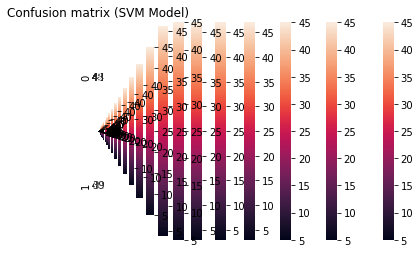

In [26]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    # Creating and running our optimization

    study_svm = optuna.create_study(direction='maximize',study_name ="SVM")

    with parallel_backend('threading'):
        study_svm.optimize(objective_svm, n_trials=10, n_jobs=-1)
    # Evaluating our Optuna Trial
    print("Best trial:", study_svm.best_trial.number)
    print("Best accuracy:", study_svm.best_trial.value)
    print("Best hyperparameters:", study_svm.best_params)
    best_param_svm = study_svm.best_params
    SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
    y_pred_svm = SVM.predict(x_test_)


    display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

    
    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(SVM, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [27]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.053179,0.157155,0.004940,0.001345,0.168345,0.002131,0.008488,0.051274,0
1,0.023321,0.133631,0.001536,0.007655,0.151798,0.000655,0.024369,0.095417,0
2,0.002417,0.123726,0.000107,0.035250,0.319583,0.007345,0.028964,0.007155,0
3,0.022976,0.114405,0.001690,0.024762,0.291238,0.003476,0.006762,0.011167,0
4,0.013536,0.051202,0.008893,0.005250,0.315869,0.012226,0.008940,0.066107,0
...,...,...,...,...,...,...,...,...,...
4995,0.271536,0.042702,0.122560,0.103964,0.042536,0.091369,0.018655,0.010940,1
4996,0.000929,0.194952,0.045214,0.079048,0.137714,0.251833,0.139857,0.017786,1
4997,0.034310,0.611595,0.000333,0.132286,0.103762,0.047833,0.000881,0.105762,1
4998,0.034738,0.016548,0.013857,0.067214,0.397929,0.001405,0.016976,0.145286,1


In [28]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]
        



In [29]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('40_svm_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.396287,0.108291,1.951610,1.948079,0.261411,0.657492,0.546059,0.440868,0.788762
1,0.634683,0.145841,2.011125,0.696347,0.092716,2.517874,0.525467,0.414052,0.879763
2,0.545895,0.223649,1.203839,0.163312,0.360925,0.503658,0.473889,0.746182,0.527669
3,0.243571,0.151892,2.630531,0.338260,0.277273,0.721455,0.653836,0.657566,0.709298
4,1.001936,0.341658,1.456547,1.093544,0.278232,0.564222,0.317856,0.520020,0.696752
...,...,...,...,...,...,...,...,...,...
95,0.676887,0.844890,1.128120,0.630359,0.884728,0.728725,0.649598,0.673179,0.777061
96,0.821772,0.636259,1.964489,0.307643,0.392533,0.430606,1.002761,1.867662,0.927966
97,0.602336,0.299259,1.301623,0.377415,0.656876,0.288029,1.016693,0.375533,0.614720
98,0.563590,0.739712,0.970750,0.236441,0.222943,0.812250,0.624295,0.682926,0.606613


## Xgboost

In [30]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [31]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


[I 2024-08-26 15:14:02,317] A new study created in memory with name: XGBoost
[I 2024-08-26 15:14:08,437] Trial 3 finished with value: 0.8726521689306094 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5506945483885293, 'colsample_bytree': 0.6850068203417379, 'reg_alpha': 0.4856405071278264, 'reg_lambda': 1.9761870283848826}. Best is trial 3 with value: 0.8726521689306094.
[I 2024-08-26 15:14:08,614] Trial 2 finished with value: 0.8735437746643467 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.5013992929095374, 'colsample_bytree': 0.8614337419209261, 'reg_alpha': 0.30879901143614824, 'reg_lambda': 0.0667778587222379}. Best is trial 2 with value: 0.8735437746643467.
[I 2024-08-26 15:14:08,951] Trial 5 finished with value: 0.8765730558337316 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.604394676634297, 'colsample_bytree': 0.972057971156387, 'reg_alpha': 0.06178049703310352, 'reg_lambda': 0.003397251804154318}. Best 

Best trial: 0
Best accuracy: 0.8818552788544625
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.9654288563366646, 'colsample_bytree': 0.8395250974304985, 'reg_alpha': 4.0756113395232305e-05, 'reg_lambda': 0.0032527655696696143}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.155889  0.759071       0.125290       0.464322  0.109467  0.406387   
1      0.205845  0.822695       0.113748       0.423119  3.271661  0.758801   
2      0.285458  0.952536       0.265750       0.167811  0.659615  0.390249   
3      0.019283  0.776448       0.251083       0.475699  3.658610  0.185464   
4      0.181754  1.2

[I 2024-08-26 15:14:22,492] Trial 3 finished with value: 0.8682907596074527 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.5953557193523773, 'colsample_bytree': 0.7736300276172887, 'reg_alpha': 8.443354671329482, 'reg_lambda': 0.00411601255083085}. Best is trial 3 with value: 0.8682907596074527.
[I 2024-08-26 15:14:22,683] Trial 1 finished with value: 0.8777676518326331 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7127579701555408, 'colsample_bytree': 0.6772735614795773, 'reg_alpha': 2.498887921669976e-05, 'reg_lambda': 2.5583017802776423e-05}. Best is trial 1 with value: 0.8777676518326331.
[I 2024-08-26 15:14:24,447] Trial 5 finished with value: 0.8853327563844061 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7982313611742078, 'colsample_bytree': 0.9855929350064121, 'reg_alpha': 0.0004947793540751281, 'reg_lambda': 0.0004920006108649476}. Best is trial 5 with value: 0.8853327563844061.
[I 2024-08-26 15:14:24,5

Best trial: 5
Best accuracy: 0.8853327563844061
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7982313611742078, 'colsample_bytree': 0.9855929350064121, 'reg_alpha': 0.0004947793540751281, 'reg_lambda': 0.0004920006108649476}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.966352  1.482835       0.106193       0.595047  0.005035  0.044983   
1      0.086598  1.040148       0.050152       0.346705  4.290340  0.618268   
2      0.002499  1.030958       0.189465       1.031961  2.232213  0.822260   
3      0.406453  0.667416       0.207926       1.517035  4.733373  0.216264   
4      0.238787  1.925

[I 2024-08-26 15:14:37,255] Trial 5 finished with value: 0.8688452851771205 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.5481911331492755, 'colsample_bytree': 0.672126827268281, 'reg_alpha': 0.00017831497724904124, 'reg_lambda': 0.15410680215895597}. Best is trial 5 with value: 0.8688452851771205.
[I 2024-08-26 15:14:37,306] Trial 3 finished with value: 0.8750375104729783 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.5540019788398247, 'colsample_bytree': 0.5313586514536144, 'reg_alpha': 0.5336678064583007, 'reg_lambda': 0.0266156592574154}. Best is trial 3 with value: 0.8750375104729783.
[I 2024-08-26 15:14:37,561] Trial 1 finished with value: 0.8748136028886557 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7977598773301026, 'colsample_bytree': 0.5354494296703604, 'reg_alpha': 1.7025575565588453e-05, 'reg_lambda': 0.00025049330511302037}. Best is trial 3 with value: 0.8750375104729783.
[I 2024-08-26 15:14:37,7

Best trial: 7
Best accuracy: 0.8932997222940506
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.7877579181440385, 'colsample_bytree': 0.9410587448301795, 'reg_alpha': 0.01085926240280903, 'reg_lambda': 0.007526583524356683}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.262652  1.219799       0.230810       0.894807  0.106241  0.602360   
1      0.044149  1.110051       0.228111       0.090228  4.703910  0.614546   
2      0.258784  0.867764       0.172707       0.514229  2.590774  0.710603   
3      0.342285  0.694412       0.081115       0.652217  5.448851  0.806194   
4      0.338862  2.235309

[I 2024-08-26 15:14:53,206] Trial 5 finished with value: 0.8741929119690797 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7140945007431201, 'colsample_bytree': 0.8548712393790328, 'reg_alpha': 8.561387553515756, 'reg_lambda': 0.0005013517823862719}. Best is trial 5 with value: 0.8741929119690797.
[I 2024-08-26 15:14:53,438] Trial 2 finished with value: 0.8773515761175678 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7735047450887491, 'colsample_bytree': 0.7268156817633264, 'reg_alpha': 0.0005970835331450268, 'reg_lambda': 0.004438785559888053}. Best is trial 2 with value: 0.8773515761175678.
[I 2024-08-26 15:14:53,925] Trial 3 finished with value: 0.8767070204420019 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.728982678430414, 'colsample_bytree': 0.9536023893370711, 'reg_alpha': 0.025944889794439867, 'reg_lambda': 2.5051659052373085}. Best is trial 2 with value: 0.8773515761175678.
[I 2024-08-26 15:14:54,230

Best trial: 6
Best accuracy: 0.8870267499379514
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.9394306047377654, 'colsample_bytree': 0.65990508128382, 'reg_alpha': 0.42915225799394646, 'reg_lambda': 9.906463416634015}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036077  0.856146       0.086222       0.537516  0.206813  0.463795   
1      0.026944  1.048388       0.020784       0.188393  2.952858  0.518087   
2      0.110756  1.096987       0.161887       0.269556  0.927886  0.526056   
3      0.125048  0.774173       0.150568       0.277025  3.178162  0.455326   
4      0.068214  1.180947     

[I 2024-08-26 15:15:11,532] Trial 4 finished with value: 0.8807478514627118 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.5861897456178684, 'colsample_bytree': 0.8954475263514299, 'reg_alpha': 1.5076918498816163e-05, 'reg_lambda': 4.284326707748294e-05}. Best is trial 4 with value: 0.8807478514627118.
[I 2024-08-26 15:15:11,628] Trial 3 finished with value: 0.8812971060687118 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7891217410613164, 'colsample_bytree': 0.518245973400365, 'reg_alpha': 1.7678600159280506, 'reg_lambda': 1.2535050565120043e-05}. Best is trial 3 with value: 0.8812971060687118.
[I 2024-08-26 15:15:12,895] Trial 1 finished with value: 0.8775195232461863 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.6550607790850511, 'colsample_bytree': 0.6315605061443423, 'reg_alpha': 0.1423821662697952, 'reg_lambda': 0.0014523316918704388}. Best is trial 3 with value: 0.8812971060687118.
[I 2024-08-26 15:15:13,

Best trial: 0
Best accuracy: 0.8897879378230585
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8155725052415328, 'colsample_bytree': 0.9956225635968607, 'reg_alpha': 0.14786995269986053, 'reg_lambda': 0.021425649594074336}
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.568651  1.432484       0.146852       0.816509  0.470305  0.656592   
1      0.143694  0.957955       0.161681       0.010332  4.074926  0.895642   
2      0.065836  1.420511       0.123864       0.373004  2.848626  0.908636   
3      0.008187  0.746146       0.167644       0.972445  4.884622  0.795118   
4      0.139413  1.98038

[I 2024-08-26 15:15:30,602] Trial 5 finished with value: 0.8864800513902804 and parameters: {'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.7780919492116813, 'colsample_bytree': 0.8298344918314033, 'reg_alpha': 4.7219826176534525, 'reg_lambda': 0.0009099437566198339}. Best is trial 5 with value: 0.8864800513902804.
[I 2024-08-26 15:15:30,903] Trial 4 finished with value: 0.8830319788310258 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9178786266108849, 'colsample_bytree': 0.968555187885495, 'reg_alpha': 0.00018776004171291487, 'reg_lambda': 0.0034027794233136145}. Best is trial 5 with value: 0.8864800513902804.
[I 2024-08-26 15:15:31,437] Trial 2 finished with value: 0.8814521118324876 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7826684270280289, 'colsample_bytree': 0.9868227313062456, 'reg_alpha': 0.5272013700982521, 'reg_lambda': 0.0004883693797927578}. Best is trial 5 with value: 0.8864800513902804.
[I 2024-08-26 15:15:31,5

Best trial: 1
Best accuracy: 0.8866153077465323
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.780262233026055, 'colsample_bytree': 0.8455783311792833, 'reg_alpha': 0.0009309377939204217, 'reg_lambda': 0.9475648137136108}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.336525  1.194243       0.082119       0.520365  0.183548  0.106885   
1      0.051695  0.749296       0.149774       0.406114  3.341034  1.119465   
2      0.096107  1.419360       0.206359       0.705323  2.152399  1.030780   
3      0.204119  0.419722       0.035539       0.823690  4.019449  0.520456   
4      0.291321  1.660637 

[I 2024-08-26 15:15:43,499] Trial 0 finished with value: 0.8833590710221642 and parameters: {'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9998722231875132, 'colsample_bytree': 0.6836056805391869, 'reg_alpha': 5.308121806624612, 'reg_lambda': 0.1369605651512473}. Best is trial 0 with value: 0.8833590710221642.
[I 2024-08-26 15:15:44,934] Trial 5 finished with value: 0.8713095706785193 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6028001658668728, 'colsample_bytree': 0.7177300301340646, 'reg_alpha': 0.00017821121348414324, 'reg_lambda': 0.008159534325090157}. Best is trial 0 with value: 0.8833590710221642.
[I 2024-08-26 15:15:45,020] Trial 1 finished with value: 0.8767049343513291 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8195205041793064, 'colsample_bytree': 0.9361296785622637, 'reg_alpha': 1.6578118836604812e-05, 'reg_lambda': 0.0006641250300742793}. Best is trial 0 with value: 0.8833590710221642.
[I 2024-08-26 15:15:45,59

Best trial: 9
Best accuracy: 0.887323707046929
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9949295579783894, 'colsample_bytree': 0.8874878935546613, 'reg_alpha': 0.04383321576344139, 'reg_lambda': 0.00014099134500303323}
              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.570830  1.446182       0.058901       0.751937  0.300619  0.435175   
1      0.144856  1.140177       0.265704       0.110788  3.653380  1.247632   
2      0.177409  1.070750       0.207816       0.460832  1.288617  1.476264   
3      0.018544  0.621295       0.084390       0.712937  4.251043  0.404706   
4      0.117431  1.87664

[I 2024-08-26 15:15:58,028] Trial 2 finished with value: 0.8755481907967703 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.6564476328200566, 'colsample_bytree': 0.9078436867761673, 'reg_alpha': 7.2030666591181465, 'reg_lambda': 0.2461843804764672}. Best is trial 2 with value: 0.8755481907967703.
[I 2024-08-26 15:15:59,707] Trial 0 finished with value: 0.8845471745390888 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7660602411118254, 'colsample_bytree': 0.9760767531326626, 'reg_alpha': 0.3328315167920626, 'reg_lambda': 2.3846946306512326e-05}. Best is trial 0 with value: 0.8845471745390888.
[I 2024-08-26 15:16:00,323] Trial 1 finished with value: 0.8803835671377399 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.8495366113542473, 'colsample_bytree': 0.8535757339655682, 'reg_alpha': 0.0016244607500585082, 'reg_lambda': 0.0009388472120771609}. Best is trial 0 with value: 0.8845471745390888.
[I 2024-08-26 15:16:01,695

Best trial: 4
Best accuracy: 0.8869022011689439
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7138652139449848, 'colsample_bytree': 0.5653115035116917, 'reg_alpha': 2.3659944525407104, 'reg_lambda': 1.9102386912617584}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015292  0.793117       0.023986       0.251903  0.054396  0.437684   
1      0.116078  0.771544       0.091527       0.386347  2.501309  0.398490   
2      0.099724  0.875006       0.186944       0.344586  1.093445  0.390351   
3      0.192516  0.375330       0.004337       0.311103  2.674592  0.344025   
4      0.042497  1.277514   

[I 2024-08-26 15:16:14,320] Trial 0 finished with value: 0.8903186007627343 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8803150954976644, 'colsample_bytree': 0.8090158349813805, 'reg_alpha': 0.3549931802619434, 'reg_lambda': 0.00011505958086330744}. Best is trial 0 with value: 0.8903186007627343.
[I 2024-08-26 15:16:14,808] Trial 2 finished with value: 0.8798844998120721 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.703911348785399, 'colsample_bytree': 0.562758601261678, 'reg_alpha': 0.0017782260110675713, 'reg_lambda': 5.88429569270571e-05}. Best is trial 0 with value: 0.8903186007627343.
[I 2024-08-26 15:16:14,885] Trial 3 finished with value: 0.8799308575758721 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7847228185823223, 'colsample_bytree': 0.5343404835350425, 'reg_alpha': 0.20538195367197265, 'reg_lambda': 0.0011414310684387256}. Best is trial 0 with value: 0.8903186007627343.
[I 2024-08-26 15:16:15,193

Best trial: 0
Best accuracy: 0.8903186007627343
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8803150954976644, 'colsample_bytree': 0.8090158349813805, 'reg_alpha': 0.3549931802619434, 'reg_lambda': 0.00011505958086330744}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.248644  1.024499       0.107194       0.825885  0.500783  0.298508   
1      0.093652  0.814334       0.036850       0.028854  3.764128  0.827244   
2      0.027257  1.509122       0.061967       0.325646  3.217079  0.749204   
3      0.018040  0.454840       0.530330       0.817479  4.285156  0.196438   
4      0.403181  2.44631

[I 2024-08-26 15:16:28,065] Trial 3 finished with value: 0.8717157507651158 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.5133011510468974, 'colsample_bytree': 0.9231100757990183, 'reg_alpha': 2.605917180054776e-05, 'reg_lambda': 5.364816985276091e-05}. Best is trial 3 with value: 0.8717157507651158.
[I 2024-08-26 15:16:28,638] Trial 1 finished with value: 0.8770072609003867 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.6083311753394297, 'colsample_bytree': 0.6524718812229422, 'reg_alpha': 0.3929930133679181, 'reg_lambda': 1.7255861044653527}. Best is trial 1 with value: 0.8770072609003867.
[I 2024-08-26 15:16:29,579] Trial 0 finished with value: 0.8739782135021342 and parameters: {'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.5622889011746133, 'colsample_bytree': 0.5517669166223749, 'reg_alpha': 0.00075679346057867, 'reg_lambda': 0.353573437187626}. Best is trial 1 with value: 0.8770072609003867.
[I 2024-08-26 15:16:29,979] T

Best trial: 2
Best accuracy: 0.8847533011266429
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6964931007571988, 'colsample_bytree': 0.7354219499701853, 'reg_alpha': 0.0013682274776168986, 'reg_lambda': 5.9233978226280395e-05}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      1.008711  0.754101       0.305121       0.681984  0.184968  0.073080   
1      0.300405  0.683112       0.201865       0.076897  3.404486  1.420209   
2      0.092495  0.908851       0.258831       0.900080  2.010844  1.072248   
3      0.433100  0.419883       0.341199       0.507175  4.028061  0.701157   
4      0.611711  1.89

[I 2024-08-26 15:16:42,997] Trial 4 finished with value: 0.8716914339623902 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.554364542372551, 'colsample_bytree': 0.8277321543645817, 'reg_alpha': 2.5024557539741076e-05, 'reg_lambda': 0.003843841369804508}. Best is trial 4 with value: 0.8716914339623902.
[I 2024-08-26 15:16:43,061] Trial 2 finished with value: 0.8758318681266577 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7054611682338521, 'colsample_bytree': 0.8268090397700294, 'reg_alpha': 1.2796247214575702e-05, 'reg_lambda': 0.00025696934225829886}. Best is trial 2 with value: 0.8758318681266577.
[I 2024-08-26 15:16:43,087] Trial 3 finished with value: 0.8804326619924602 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7969601841446025, 'colsample_bytree': 0.7890441483233528, 'reg_alpha': 1.4809933636873018e-05, 'reg_lambda': 0.00014377782735945576}. Best is trial 3 with value: 0.8804326619924602.
[I 2024-08-26 15

Best trial: 1
Best accuracy: 0.8899345720692656
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.9667385832982622, 'colsample_bytree': 0.9130304151477808, 'reg_alpha': 1.4582408709512579e-05, 'reg_lambda': 2.892239595947731}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.148486  0.992029       0.001649       0.546249  0.056415  0.362540   
1      0.044716  0.942007       0.222193       0.336777  3.295390  0.915769   
2      0.150539  1.125073       0.097037       0.543421  0.714248  0.700474   
3      0.132815  0.636858       0.167471       0.683629  3.652127  0.391079   
4      0.225478  1.301917

[I 2024-08-26 15:16:58,103] Trial 3 finished with value: 0.8761972407914114 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.7155731849845761, 'colsample_bytree': 0.6286004544836765, 'reg_alpha': 5.676700963538095, 'reg_lambda': 0.022210309898645416}. Best is trial 3 with value: 0.8761972407914114.
[I 2024-08-26 15:16:59,604] Trial 5 finished with value: 0.883875665069207 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.9343003248871433, 'colsample_bytree': 0.7698873413213984, 'reg_alpha': 0.16097374478586587, 'reg_lambda': 0.10872979556745908}. Best is trial 5 with value: 0.883875665069207.
[I 2024-08-26 15:16:59,990] Trial 4 finished with value: 0.8844767794910373 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.9549018487315883, 'colsample_bytree': 0.5219204156511686, 'reg_alpha': 1.2517514491900754, 'reg_lambda': 0.0001120292000252344}. Best is trial 4 with value: 0.8844767794910373.
[I 2024-08-26 15:17:00,245] Trial

Best trial: 7
Best accuracy: 0.8888836107598108
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8672599597424453, 'colsample_bytree': 0.8967232996596367, 'reg_alpha': 1.0982982816884956, 'reg_lambda': 3.698817782710044}


[I 2024-08-26 15:17:07,623] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.133598  0.736351       0.043685       0.374073  0.107139  0.413980   
1      0.090529  0.852386       0.214570       0.291465  2.860676  0.447403   
2      0.068506  1.029108       0.192331       0.363924  1.380792  0.764100   
3      0.053818  0.321135       0.133395       0.753072  3.153846  0.353912   
4      0.167852  1.472377       0.127082       0.521897  1.063260  0.553467   
..          ...       ...            ...            ...       ...       ...   
95     0.343646  0.356191       0.484894       0.405589  0.048958  0.586218   
96     0.105672  2.519210       0.137497 

[I 2024-08-26 15:17:14,726] Trial 2 finished with value: 0.8741492666269393 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5065828968979491, 'colsample_bytree': 0.6531714587893993, 'reg_alpha': 0.0013294963827683202, 'reg_lambda': 0.010142683505941486}. Best is trial 2 with value: 0.8741492666269393.
[I 2024-08-26 15:17:15,061] Trial 1 finished with value: 0.8747125361062124 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.6019540952558788, 'colsample_bytree': 0.9400559665245101, 'reg_alpha': 5.885252233095522e-05, 'reg_lambda': 4.2926105418641476e-05}. Best is trial 1 with value: 0.8747125361062124.
[I 2024-08-26 15:17:17,093] Trial 0 finished with value: 0.8879093107918203 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8779860957417894, 'colsample_bytree': 0.8918628518188967, 'reg_alpha': 4.604138577790071, 'reg_lambda': 0.01926370126440154}. Best is trial 0 with value: 0.8879093107918203.
[I 2024-08-26 15:17:17,43

Best trial: 3
Best accuracy: 0.8928895246420773
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.9346960720953064, 'colsample_bytree': 0.8500648372149006, 'reg_alpha': 0.24446243645027477, 'reg_lambda': 3.5720474265361704}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 15:17:24,756] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.097380  0.991104       0.061063       0.659792  0.074506  0.230564   
1      0.065265  0.840558       0.157364       0.011172  3.335556  0.454435   
2      0.138509  1.250224       0.101457       0.625453  1.855276  0.357490   
3      0.153289  0.332597       0.138588       0.890484  3.621529  0.253984   
4      0.243569  2.175217       0.117254       0.622070  1.509286  0.848248   
..          ...       ...            ...            ...       ...       ...   
95     0.241215  0.690075       0.367240       0.455293  0.101038  0.546359   
96     0.156869  3.577719       0.019533       0.275143  2.299649  1.698079   
97     0.075296  2.604417       0.055768       0.786412  0.847737  0.152435   
98     0.286357  0.449108       0.079147       0.286395  5.069890  0.375226   
99     0.219360  2.587935       0.018942       0.395587  0.140924  0.318928   

         DPF       Age  Outcome  
0   0.452521  0.5

[I 2024-08-26 15:17:32,092] Trial 4 finished with value: 0.8728422101743787 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.5619147767475257, 'colsample_bytree': 0.8721842670380684, 'reg_alpha': 0.005026409507597781, 'reg_lambda': 2.4381604029021977}. Best is trial 4 with value: 0.8728422101743787.
[I 2024-08-26 15:17:32,191] Trial 3 finished with value: 0.8807739585062001 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.7398163845597745, 'colsample_bytree': 0.6198189300710505, 'reg_alpha': 0.0013277663200786075, 'reg_lambda': 4.7429500908924165e-05}. Best is trial 3 with value: 0.8807739585062001.
[I 2024-08-26 15:17:32,620] Trial 5 finished with value: 0.8702891770733904 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.6260266161224777, 'colsample_bytree': 0.5035212298055933, 'reg_alpha': 0.014485212951462215, 'reg_lambda': 1.1141082229862493}. Best is trial 3 with value: 0.8807739585062001.
[I 2024-08-26 15:17:33,08

Best trial: 7
Best accuracy: 0.8884674108365196
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7380112823047686, 'colsample_bytree': 0.5924272121051986, 'reg_alpha': 3.198194065602805, 'reg_lambda': 0.15793781239379184}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.118099  0.927319       0.018134       0.240261  0.047404  0.573754   
1      0.015830  0.735573       0.058462       0.369291  2.339671  0.434953   
2      0.163980  1.045859       0.065007       0.279291  0.836485  0.475698   
3      0.220703  0.669900       0.053713       0.467605  2.529066  0.451371   
4      0.067754  1.202120   

[I 2024-08-26 15:17:38,991] A new study created in memory with name: XGBoost
[I 2024-08-26 15:17:46,844] Trial 2 finished with value: 0.8734290950622529 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5080643625265067, 'colsample_bytree': 0.7081353094218172, 'reg_alpha': 0.00011103743573209567, 'reg_lambda': 1.4907756339473206}. Best is trial 2 with value: 0.8734290950622529.
[I 2024-08-26 15:17:47,430] Trial 4 finished with value: 0.8751417154492832 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.8870121033008314, 'colsample_bytree': 0.5695730715185662, 'reg_alpha': 0.8939249521496881, 'reg_lambda': 0.0005664203650647191}. Best is trial 4 with value: 0.8751417154492832.
[I 2024-08-26 15:17:47,666] Trial 1 finished with value: 0.8803062408645939 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.8500074889016548, 'colsample_bytree': 0.9634691103084237, 'reg_alpha': 0.13432236837301514, 'reg_lambda': 4.978261153519586}. 

Best trial: 5
Best accuracy: 0.8849494274155237
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9573479367926421, 'colsample_bytree': 0.6183811096637369, 'reg_alpha': 1.1989153099371825e-05, 'reg_lambda': 4.725492038333457}
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.207208  1.248118       0.009584       0.414340  0.089440  0.654990   
1      0.024670  0.809888       0.365639       0.385443  3.302139  0.818815   
2      0.098320  1.326741       0.117377       0.505670  1.798110  0.524095   
3      0.281187  0.147140       0.396291       0.562690  3.735655  0.431804   
4      0.021210  1.76588

[I 2024-08-26 15:17:54,975] A new study created in memory with name: XGBoost
[I 2024-08-26 15:18:01,850] Trial 1 finished with value: 0.8726126400033984 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.582165519277877, 'colsample_bytree': 0.5442388764363342, 'reg_alpha': 0.0009223898652749237, 'reg_lambda': 0.013669776839953171}. Best is trial 1 with value: 0.8726126400033984.
[I 2024-08-26 15:18:02,342] Trial 3 finished with value: 0.8756956478760104 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.695568020395726, 'colsample_bytree': 0.9184578874561758, 'reg_alpha': 6.757584794560466e-05, 'reg_lambda': 6.032907583350832}. Best is trial 3 with value: 0.8756956478760104.
[I 2024-08-26 15:18:02,430] Trial 2 finished with value: 0.8734682663440978 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.5240416502194175, 'colsample_bytree': 0.9409360030624628, 'reg_alpha': 0.0011347779794386285, 'reg_lambda': 0.45751828059936744

Best trial: 0
Best accuracy: 0.8853204402852178
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7570876839883585, 'colsample_bytree': 0.7698005173175174, 'reg_alpha': 4.31099162099317e-05, 'reg_lambda': 1.218238208681913}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.559650  1.614948       0.018701       0.486602  0.192080  0.677443   
1      0.059147  1.018821       0.175183       0.329656  3.552881  1.282754   
2      0.183881  1.567124       0.008578       0.367954  2.524997  1.074894   
3      0.390858  0.724978       0.089340       0.774712  4.263176  0.416838   
4      0.293355  2.077645 

[I 2024-08-26 15:18:10,358] A new study created in memory with name: XGBoost
[I 2024-08-26 15:18:17,325] Trial 5 finished with value: 0.872530590549918 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5451579421688919, 'colsample_bytree': 0.9404494096998697, 'reg_alpha': 0.0003217913608014101, 'reg_lambda': 4.479340306907024}. Best is trial 5 with value: 0.872530590549918.
[I 2024-08-26 15:18:17,439] Trial 4 finished with value: 0.8765184048573567 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.5953179595010414, 'colsample_bytree': 0.7522540875233225, 'reg_alpha': 4.781267159561811, 'reg_lambda': 0.4938132914074913}. Best is trial 4 with value: 0.8765184048573567.
[I 2024-08-26 15:18:17,579] Trial 0 finished with value: 0.8734118983784224 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.5049499704301857, 'colsample_bytree': 0.9071512596161229, 'reg_alpha': 0.0015315600218225422, 'reg_lambda': 0.008083188036422545}. Best

Best trial: 9
Best accuracy: 0.8828147534597699
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7684799951869109, 'colsample_bytree': 0.7989766368939227, 'reg_alpha': 5.386811255415573e-05, 'reg_lambda': 7.17412182795945}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037901  0.996444       0.045803       0.387830  0.141745  0.519228   
1      0.012436  0.861863       0.137691       0.326904  2.675154  0.979424   
2      0.165073  1.082272       0.161263       0.269234  0.827972  0.572945   
3      0.064410  0.581974       0.166930       0.426255  3.045622  0.416212   
4      0.294942  1.367736  

[I 2024-08-26 15:18:24,315] A new study created in memory with name: XGBoost
[I 2024-08-26 15:18:30,627] Trial 3 finished with value: 0.8727037240232659 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.5265723278480585, 'colsample_bytree': 0.8317984889441316, 'reg_alpha': 3.34511331964164e-05, 'reg_lambda': 0.005514692719379216}. Best is trial 3 with value: 0.8727037240232659.
[I 2024-08-26 15:18:32,304] Trial 5 finished with value: 0.8819472946066746 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8570367543299167, 'colsample_bytree': 0.9726552610816466, 'reg_alpha': 0.20789807573550445, 'reg_lambda': 1.1684670856554083e-05}. Best is trial 5 with value: 0.8819472946066746.
[I 2024-08-26 15:18:33,232] Trial 1 finished with value: 0.8723118529608898 and parameters: {'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5451406272577364, 'colsample_bytree': 0.626892967228897, 'reg_alpha': 0.48468072784480587, 'reg_lambda': 0.07275492077631406

Best trial: 8
Best accuracy: 0.8844560466032347
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.8462639258749751, 'colsample_bytree': 0.5706704572772334, 'reg_alpha': 0.2653720180713646, 'reg_lambda': 4.517524228070318e-05}
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        50
           1       0.91      0.84      0.87        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.412993  0.825488       0.114155       0.341147  0.205087  0.707783   
1      0.197129  0.760040       0.398357       0.040528  3.432721  0.974453   
2      0.144090  1.076557       0.065135       0.411462  1.511652  1.082328   
3      0.473908  0.409702       0.180699       0.435973  4.222372  0.734290   
4      0.113799  1.808012

[I 2024-08-26 15:18:40,066] A new study created in memory with name: XGBoost
[I 2024-08-26 15:18:47,237] Trial 0 finished with value: 0.8845473250323868 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.713023725705274, 'colsample_bytree': 0.7986381030613032, 'reg_alpha': 0.04037944640228408, 'reg_lambda': 9.19739459230631e-05}. Best is trial 0 with value: 0.8845473250323868.
[I 2024-08-26 15:18:47,471] Trial 3 finished with value: 0.8908403491068998 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.9812415885104986, 'colsample_bytree': 0.8925106504504136, 'reg_alpha': 0.10977542568357448, 'reg_lambda': 4.083847538772703}. Best is trial 3 with value: 0.8908403491068998.
[I 2024-08-26 15:18:48,183] Trial 1 finished with value: 0.8788814585252495 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.9478401526849802, 'colsample_bytree': 0.7904895449252294, 'reg_alpha': 2.6562363741727738e-05, 'reg_lambda': 0.11053529572613642}. 

Best trial: 3
Best accuracy: 0.8908403491068998
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.9812415885104986, 'colsample_bytree': 0.8925106504504136, 'reg_alpha': 0.10977542568357448, 'reg_lambda': 4.083847538772703}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.135112  1.071265       0.073640       0.329335  0.264233  0.240748   
1      0.031793  0.853924       0.090847       0.170948  3.089276  0.633800   
2      0.133208  1.269040       0.143064       0.358346  0.905718  0.908313   
3      0.178902  0.559094       0.141633       0.694069  3.397322  0.461059   
4      0.264637  1.592877   

[I 2024-08-26 15:18:54,828] A new study created in memory with name: XGBoost
[I 2024-08-26 15:19:02,266] Trial 5 finished with value: 0.8684403929736273 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.5340109249860383, 'colsample_bytree': 0.985632334731442, 'reg_alpha': 1.1233219204970604e-05, 'reg_lambda': 0.00023024759620085636}. Best is trial 5 with value: 0.8684403929736273.
[I 2024-08-26 15:19:03,464] Trial 1 finished with value: 0.8805319125059208 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.7037686834625245, 'colsample_bytree': 0.8527965968260607, 'reg_alpha': 0.023246393648511405, 'reg_lambda': 0.000887485619458581}. Best is trial 1 with value: 0.8805319125059208.
[I 2024-08-26 15:19:03,731] Trial 3 finished with value: 0.8742209226479765 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.598236545628034, 'colsample_bytree': 0.6091071853812521, 'reg_alpha': 0.11500865327007576, 'reg_lambda': 0.0214612395737069

Best trial: 6
Best accuracy: 0.8905557587635501
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7382284407868955, 'colsample_bytree': 0.9230025964723853, 'reg_alpha': 0.012093826338376006, 'reg_lambda': 7.657356630836667e-05}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 15:19:11,872] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.927704  2.155812       0.057906       0.589261  0.521185  0.011657   
1      0.026197  0.981724       0.286959       0.208306  4.386415  0.669727   
2      0.293496  1.518767       0.494946       0.675802  2.990809  1.006284   
3      0.254931  0.514669       0.102348       0.830877  4.680123  0.659814   
4      0.289863  1.746920       0.016156       0.643002  2.439729  0.434887   
..          ...       ...            ...            ...       ...       ...   
95     0.008920  0.555679       0.597330       0.111769  1.027485  0.354584   
96     0.279872  3.183893       0.092307       0.630928  2.510522  1.240302   
97     0.230454  2.954325       0.068547       1.877366  1.370866  0.312405   
98     0.230465  0.471684       0.243309       0.201986  6.100118  0.357444   
99     0.572139  3.534557       0.075850       0.569572  0.813803  0.652626   

         DPF       Age  Outcome  
0   0.803030  0.5

[I 2024-08-26 15:19:19,055] Trial 5 finished with value: 0.873664927596559 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.5886127404914223, 'colsample_bytree': 0.9791037780504487, 'reg_alpha': 0.016620587897491382, 'reg_lambda': 0.0033917380244270997}. Best is trial 5 with value: 0.873664927596559.
[I 2024-08-26 15:19:19,567] Trial 2 finished with value: 0.8697259101714367 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.5007970314175385, 'colsample_bytree': 0.613263407512816, 'reg_alpha': 0.0021030985539725005, 'reg_lambda': 0.006122099927423789}. Best is trial 5 with value: 0.873664927596559.
[I 2024-08-26 15:19:19,693] Trial 4 finished with value: 0.8736020930301681 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.6112292952696473, 'colsample_bytree': 0.6978270989707798, 'reg_alpha': 2.8782972737549804e-05, 'reg_lambda': 0.05989706891394544}. Best is trial 5 with value: 0.873664927596559.
[I 2024-08-26 15:19:20,390]

Best trial: 9
Best accuracy: 0.8904733838457224
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.903413874417601, 'colsample_bytree': 0.7779249571658594, 'reg_alpha': 2.065305574012887, 'reg_lambda': 0.03991559907760625}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 15:19:26,681] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.061147  0.828078       0.090989       0.556308  0.845428  0.382549   
1      0.078817  0.642495       0.067487       0.035675  2.669014  0.650911   
2      0.061306  1.134697       0.188414       0.428485  1.040312  0.796098   
3      0.017416  0.326845       0.010578       0.773045  2.980972  0.323873   
4      0.025024  1.230968       0.238436       0.589925  1.169520  0.704179   
..          ...       ...            ...            ...       ...       ...   
95     0.192822  0.299420       0.304406       0.460068  0.241832  0.647864   
96     0.038227  2.649955       0.121675       0.103656  1.623663  1.612341   
97     0.254890  2.442410       0.008230       0.249206  1.292535  0.214190   
98     0.075179  0.256521       0.117027       0.053040  4.085157  0.107725   
99     0.245909  2.397475       0.078172       0.328302  0.045615  0.282617   

         DPF       Age  Outcome  
0   0.807249  0.4

[I 2024-08-26 15:19:34,059] Trial 3 finished with value: 0.8782428830688661 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.8895806973044669, 'colsample_bytree': 0.8548907885851513, 'reg_alpha': 0.0002853899679142225, 'reg_lambda': 1.6923064297850725e-05}. Best is trial 3 with value: 0.8782428830688661.
[I 2024-08-26 15:19:34,516] Trial 4 finished with value: 0.8835059028250711 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9776201518575085, 'colsample_bytree': 0.6323163300010508, 'reg_alpha': 0.02300211895091503, 'reg_lambda': 0.03711761800963539}. Best is trial 4 with value: 0.8835059028250711.
[I 2024-08-26 15:19:34,862] Trial 5 finished with value: 0.8869069090877812 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9754718975698733, 'colsample_bytree': 0.92083143764089, 'reg_alpha': 0.046393472705893696, 'reg_lambda': 1.3657019967534112}. Best is trial 5 with value: 0.8869069090877812.
[I 2024-08-26 15:19:35,128]

Best trial: 5
Best accuracy: 0.8869069090877812
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9754718975698733, 'colsample_bytree': 0.92083143764089, 'reg_alpha': 0.046393472705893696, 'reg_lambda': 1.3657019967534112}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 15:19:42,242] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.060042  1.443434       0.003615       0.710677  0.379722  0.297838   
1      0.153205  0.557000       0.078695       0.312672  3.260186  0.986939   
2      0.253149  1.350470       0.331754       0.495595  1.251669  0.813947   
3      0.196858  0.265641       0.228892       0.715573  3.421651  0.410787   
4      0.131880  1.526254       0.414265       0.687916  1.170234  0.600610   
..          ...       ...            ...            ...       ...       ...   
95     0.204924  0.403427       0.678352       0.274046  0.424668  0.431212   
96     0.163110  2.600167       0.325433       0.052085  2.253538  1.237536   
97     0.017449  2.356882       0.095877       0.544547  1.365477  0.504969   
98     0.160734  0.491399       0.363562       0.128129  4.833017  0.346825   
99     0.180244  2.600860       0.117846       0.449310  0.258571  0.420552   

         DPF       Age  Outcome  
0   0.530143  0.5

[I 2024-08-26 15:19:49,990] Trial 1 finished with value: 0.8805134643393566 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5919608308225435, 'colsample_bytree': 0.9884760428645023, 'reg_alpha': 0.0009019133678987315, 'reg_lambda': 9.3637973703639e-05}. Best is trial 1 with value: 0.8805134643393566.
[I 2024-08-26 15:19:50,021] Trial 0 finished with value: 0.8846464060368031 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9904082520591081, 'colsample_bytree': 0.5587830137571409, 'reg_alpha': 1.2493493334647996, 'reg_lambda': 0.00027157746961482707}. Best is trial 0 with value: 0.8846464060368031.
[I 2024-08-26 15:19:50,037] Trial 4 finished with value: 0.8738263754398994 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.6520492529095332, 'colsample_bytree': 0.654505380514241, 'reg_alpha': 5.154139861468772e-05, 'reg_lambda': 0.0006506852720105185}. Best is trial 0 with value: 0.8846464060368031.
[I 2024-08-26 15:19:50,3

Best trial: 0
Best accuracy: 0.8846464060368031
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9904082520591081, 'colsample_bytree': 0.5587830137571409, 'reg_alpha': 1.2493493334647996, 'reg_lambda': 0.00027157746961482707}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 15:19:56,586] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033923  0.852419       0.091712       0.368194  0.410487  0.360731   
1      0.031993  0.744966       0.018563       0.113146  2.795211  0.956888   
2      0.214536  1.072638       0.226649       0.240526  0.933454  0.620937   
3      0.350545  0.381892       0.260859       0.377475  3.202592  0.521922   
4      0.121059  1.598235       0.337183       0.427533  0.867570  0.193406   
..          ...       ...            ...            ...       ...       ...   
95     0.341649  0.461902       0.541232       0.592509  0.254820  0.706689   
96     0.034596  2.654009       0.163749       0.073866  2.344159  1.384671   
97     0.124019  2.318616       0.028685       0.313366  0.926091  0.378515   
98     0.275466  0.456652       0.299323       0.056792  4.247700  0.324459   
99     0.425204  2.707933       0.074179       0.255076  0.046049  0.380499   

         DPF       Age  Outcome  
0   0.622861  0.6

[I 2024-08-26 15:20:02,561] Trial 0 finished with value: 0.8716217613797288 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.5033322377669551, 'colsample_bytree': 0.6183479776084588, 'reg_alpha': 0.03233511239244762, 'reg_lambda': 1.5341279004649453e-05}. Best is trial 0 with value: 0.8716217613797288.
[I 2024-08-26 15:20:05,171] Trial 2 finished with value: 0.8820056346583298 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.7178715391129051, 'colsample_bytree': 0.5838150958811852, 'reg_alpha': 4.60214548326144, 'reg_lambda': 0.00579731907464709}. Best is trial 2 with value: 0.8820056346583298.
[I 2024-08-26 15:20:05,311] Trial 1 finished with value: 0.87658232515103 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.6651128503687177, 'colsample_bytree': 0.8613846810896286, 'reg_alpha': 0.01343474340309234, 'reg_lambda': 0.15849281268960475}. Best is trial 2 with value: 0.8820056346583298.
[I 2024-08-26 15:20:05,336] Tria

Best trial: 8
Best accuracy: 0.8850986256095354
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.916183916891193, 'colsample_bytree': 0.7735790748828052, 'reg_alpha': 7.401516507372059e-05, 'reg_lambda': 0.0004269050296951428}


[I 2024-08-26 15:20:13,149] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.443045  0.848278       0.290377       0.876765  0.413934  0.153544   
1      0.128577  0.637663       0.209924       0.434830  3.134657  1.360664   
2      0.336055  0.906080       0.373708       0.397268  1.337594  0.840403   
3      0.092671  0.491393       0.180419       0.465003  3.605379  0.254810   
4      0.119063  1.355745       0.398498       0.791071  1.358327  0.473116   
..          ...       ...            ...            ...       ...       ...   
95     0.242694  0.325003       0.647019       0.445138  1.104038  0.606694   
96     0.061341  2.548974       0.268453 

[I 2024-08-26 15:20:20,530] Trial 4 finished with value: 0.8763940390279638 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.7117296922057619, 'colsample_bytree': 0.6574883071562371, 'reg_alpha': 0.0005153662835769518, 'reg_lambda': 0.008988844316800663}. Best is trial 4 with value: 0.8763940390279638.
[I 2024-08-26 15:20:20,584] Trial 5 finished with value: 0.8755412642195768 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.5140508780602353, 'colsample_bytree': 0.7830760590540247, 'reg_alpha': 0.0006541119411127296, 'reg_lambda': 2.5796355079640234}. Best is trial 4 with value: 0.8763940390279638.
[I 2024-08-26 15:20:21,432] Trial 3 finished with value: 0.8782268358085105 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8160661158949929, 'colsample_bytree': 0.8937740370069449, 'reg_alpha': 0.001542696877878311, 'reg_lambda': 0.17278575320068412}. Best is trial 3 with value: 0.8782268358085105.
[I 2024-08-26 15:20:22,1

Best trial: 1
Best accuracy: 0.8876487959874736
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.9923062155294236, 'colsample_bytree': 0.5855913099225846, 'reg_alpha': 0.1445084145930038, 'reg_lambda': 0.0001283883046875154}


[I 2024-08-26 15:20:27,450] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.091592  0.860458       0.036734       0.293119  0.109606  0.407404   
1      0.107883  0.707940       0.152989       0.117247  3.428583  1.076872   
2      0.024075  1.189600       0.211019       0.301084  0.857228  0.614939   
3      0.299149  0.501069       0.139205       0.378251  3.593945  0.599112   
4      0.029545  1.513311       0.234393       0.424276  1.010291  0.409166   
..          ...       ...            ...            ...       ...       ...   
95     0.401072  0.633156       0.553033       0.458923  0.203919  0.628541   
96     0.101197  3.102111       0.260458 

[I 2024-08-26 15:20:34,565] Trial 1 finished with value: 0.8794970327227098 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6405852598232329, 'colsample_bytree': 0.5408950379534403, 'reg_alpha': 3.5737610116485414, 'reg_lambda': 5.2967140039122195e-05}. Best is trial 1 with value: 0.8794970327227098.
[I 2024-08-26 15:20:35,053] Trial 5 finished with value: 0.8783495720182704 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8243926449861267, 'colsample_bytree': 0.7637899492056932, 'reg_alpha': 0.09593505952033826, 'reg_lambda': 0.007565269754234449}. Best is trial 1 with value: 0.8794970327227098.
[I 2024-08-26 15:20:35,145] Trial 2 finished with value: 0.8732298538213851 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.6147237824066933, 'colsample_bytree': 0.7817723422549053, 'reg_alpha': 0.00012031831897689619, 'reg_lambda': 0.00404982024891036}. Best is trial 1 with value: 0.8794970327227098.
[I 2024-08-26 15:20:35,1

Best trial: 0
Best accuracy: 0.8832916724113009
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8279060856061353, 'colsample_bytree': 0.5265408707113075, 'reg_alpha': 0.0007611185859995668, 'reg_lambda': 0.0013523030374857292}


[I 2024-08-26 15:20:41,990] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.363438  1.074804       0.032508       1.028230  0.248593  1.073516   
1      0.191960  0.570724       0.314347       0.063294  3.864555  0.816095   
2      0.023304  0.964909       0.229650       0.509008  1.132873  0.940349   
3      0.278337  0.308080       0.122100       0.405140  4.100303  0.766168   
4      0.029267  1.988673       0.002704       1.068573  1.232907  1.090761   
..          ...       ...            ...            ...       ...       ...   
95     0.542231  0.656559       0.544738       0.605777  0.675557  0.613878   
96     0.213688  3.065810       0.244106 

[I 2024-08-26 15:20:49,515] Trial 0 finished with value: 0.8692139474148878 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.6152889358627174, 'colsample_bytree': 0.6929233546095077, 'reg_alpha': 3.469025048720309e-05, 'reg_lambda': 3.851105510790716e-05}. Best is trial 0 with value: 0.8692139474148878.
[I 2024-08-26 15:20:49,539] Trial 5 finished with value: 0.870832955631351 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.586880752171465, 'colsample_bytree': 0.7221260034428724, 'reg_alpha': 0.09197055006445043, 'reg_lambda': 0.09984949681538738}. Best is trial 5 with value: 0.870832955631351.
[I 2024-08-26 15:20:50,449] Trial 3 finished with value: 0.8820518549842415 and parameters: {'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.7103215032823258, 'colsample_bytree': 0.8644942208175774, 'reg_alpha': 4.759489559847651, 'reg_lambda': 0.0012305959267194407}. Best is trial 3 with value: 0.8820518549842415.
[I 2024-08-26 15:20:51,292] Tr

Best trial: 8
Best accuracy: 0.8919526580114178
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.753353586627264, 'colsample_bytree': 0.9062643195905898, 'reg_alpha': 9.295278158059443e-05, 'reg_lambda': 0.2588560291245007}


[I 2024-08-26 15:20:57,554] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.856195  2.120797       0.190970       0.512528  0.107362  0.580661   
1      0.109904  0.876738       0.074161       0.002328  4.544516  0.777438   
2      0.138624  1.117698       0.292400       0.980475  3.263874  0.156910   
3      0.616513  0.284324       0.255922       0.800513  5.723787  0.576727   
4      0.477102  1.928190       0.006584       0.750656  2.178111  0.791630   
..          ...       ...            ...            ...       ...       ...   
95     0.332082  0.764539       0.609168       0.370965  0.229851  0.992986   
96     0.233792  4.019492       0.041589 

[I 2024-08-26 15:21:04,654] Trial 2 finished with value: 0.8736349131628921 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.6175861846048478, 'colsample_bytree': 0.8377389099820245, 'reg_alpha': 0.04845737377314953, 'reg_lambda': 1.0855218315995814}. Best is trial 2 with value: 0.8736349131628921.
[I 2024-08-26 15:21:04,924] Trial 1 finished with value: 0.8834225397199327 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8514062475144808, 'colsample_bytree': 0.9439707694768242, 'reg_alpha': 0.1718030820825687, 'reg_lambda': 8.061634720613494e-05}. Best is trial 1 with value: 0.8834225397199327.
[I 2024-08-26 15:21:05,052] Trial 0 finished with value: 0.8822885513748995 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7641238934709441, 'colsample_bytree': 0.7707918605924147, 'reg_alpha': 0.00013490951004354338, 'reg_lambda': 0.0468674460568727}. Best is trial 1 with value: 0.8834225397199327.
[I 2024-08-26 15:21:05,170] 

Best trial: 7
Best accuracy: 0.8876853815832126
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.9961418904133358, 'colsample_bytree': 0.7035475191286995, 'reg_alpha': 0.00022157560753871994, 'reg_lambda': 0.0004379772960113448}


[I 2024-08-26 15:21:12,481] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.078706  0.795307       0.076764       0.659856  0.151837  0.271771   
1      0.139003  0.735433       0.086957       0.307748  3.515848  0.744942   
2      0.270776  1.095271       0.219580       0.406254  0.734434  0.683795   
3      0.007744  0.698352       0.223151       0.377691  3.626782  0.504021   
4      0.072243  1.513326       0.332715       0.647722  0.861002  0.593166   
..          ...       ...            ...            ...       ...       ...   
95     0.021114  0.754423       0.586197       0.432134  0.635986  0.608331   
96     0.119450  2.457565       0.423361 

[I 2024-08-26 15:21:19,210] Trial 1 finished with value: 0.8750181403315622 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.6492872311641628, 'colsample_bytree': 0.7486378849192834, 'reg_alpha': 0.007398783485529841, 'reg_lambda': 1.93115120666861}. Best is trial 1 with value: 0.8750181403315622.
[I 2024-08-26 15:21:20,291] Trial 5 finished with value: 0.8744675542393859 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.6024605110244932, 'colsample_bytree': 0.6260715988729899, 'reg_alpha': 5.827313774587439, 'reg_lambda': 0.0018400899863522926}. Best is trial 1 with value: 0.8750181403315622.
[I 2024-08-26 15:21:20,602] Trial 0 finished with value: 0.8797119392536955 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.7859731694386386, 'colsample_bytree': 0.8401927030264371, 'reg_alpha': 0.03803837059148907, 'reg_lambda': 0.002663947824473063}. Best is trial 0 with value: 0.8797119392536955.
[I 2024-08-26 15:21:21,143] Tri

Best trial: 4
Best accuracy: 0.8844805739930005
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.9592247646701871, 'colsample_bytree': 0.6654605584262379, 'reg_alpha': 4.248137503136633e-05, 'reg_lambda': 8.2593309656019}


[I 2024-08-26 15:21:27,062] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.054065  0.975227       0.117748       0.508821  0.117642  0.464370   
1      0.019828  0.657274       0.069369       0.309513  3.007721  0.670865   
2      0.112112  1.026827       0.211750       0.349283  1.056087  0.867013   
3      0.180191  0.461056       0.182911       0.471205  3.237477  0.352093   
4      0.159239  1.348104       0.396390       0.368178  0.951495  0.687311   
..          ...       ...            ...            ...       ...       ...   
95     0.186173  0.646548       0.474641       0.284346  0.190857  0.531295   
96     0.048645  2.548613       0.211216 

[I 2024-08-26 15:21:33,746] Trial 1 finished with value: 0.8741743529543917 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.721766129520885, 'colsample_bytree': 0.6107511560785575, 'reg_alpha': 0.0003264394119468282, 'reg_lambda': 0.03655187963043114}. Best is trial 1 with value: 0.8741743529543917.
[I 2024-08-26 15:21:33,829] Trial 3 finished with value: 0.8736724565055709 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.5824481922759627, 'colsample_bytree': 0.7688854307795414, 'reg_alpha': 0.16514135351250642, 'reg_lambda': 0.014697819356553827}. Best is trial 1 with value: 0.8741743529543917.
[I 2024-08-26 15:21:34,286] Trial 0 finished with value: 0.8738281987480054 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.5647419894998646, 'colsample_bytree': 0.8448283185067984, 'reg_alpha': 0.009868585853427984, 'reg_lambda': 0.0028279763186489022}. Best is trial 1 with value: 0.8741743529543917.
[I 2024-08-26 15:21:35,5

Best trial: 4
Best accuracy: 0.8848273156259867
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.918760244941935, 'colsample_bytree': 0.8693281868585117, 'reg_alpha': 1.697340671899398e-05, 'reg_lambda': 0.0003140684424045023}


[I 2024-08-26 15:21:41,449] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.011997  0.736346       0.019228       0.685294  0.215279  0.216181   
1      0.180015  1.049300       0.005164       0.263244  3.690799  0.976817   
2      0.270877  0.906764       0.379034       0.402828  0.779105  0.526684   
3      0.074769  0.816369       0.189011       0.447589  3.787360  0.211925   
4      0.133935  1.347217       0.290786       0.549583  0.876377  0.590725   
..          ...       ...            ...            ...       ...       ...   
95     0.129782  0.770906       0.754359       0.466917  0.453431  0.888678   
96     0.031821  2.413842       0.512068 

[I 2024-08-26 15:21:48,858] Trial 5 finished with value: 0.8726807386487756 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.5119159888775775, 'colsample_bytree': 0.9311863489137164, 'reg_alpha': 0.020094016116902716, 'reg_lambda': 0.0017933343506447844}. Best is trial 5 with value: 0.8726807386487756.
[I 2024-08-26 15:21:48,994] Trial 4 finished with value: 0.8777469457227166 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.7532591585929757, 'colsample_bytree': 0.6337382952400743, 'reg_alpha': 0.8880972942454621, 'reg_lambda': 1.703333378587726}. Best is trial 4 with value: 0.8777469457227166.
[I 2024-08-26 15:21:49,044] Trial 3 finished with value: 0.8753872599829384 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6079288161653145, 'colsample_bytree': 0.5602464407826085, 'reg_alpha': 0.013531759958372231, 'reg_lambda': 1.4811359125527138e-05}. Best is trial 4 with value: 0.8777469457227166.
[I 2024-08-26 15:21:49,104

Best trial: 9
Best accuracy: 0.8871672436797362
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9440778221300687, 'colsample_bytree': 0.7043606787044501, 'reg_alpha': 0.7649733921277722, 'reg_lambda': 2.8820700990811186}


[I 2024-08-26 15:21:56,631] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.100408  0.934964       0.094510       0.519440  0.386178  0.545498   
1      0.091652  0.610184       0.243900       0.186300  3.115194  0.455061   
2      0.310329  1.081372       0.208544       0.378778  1.178843  0.879924   
3      0.121367  0.230934       0.122203       0.456609  3.528000  0.282843   
4      0.428812  1.739407       0.332296       0.624902  0.832485  0.558909   
..          ...       ...            ...            ...       ...       ...   
95     0.388014  0.548530       0.493562       0.579111  0.087181  0.430731   
96     0.078576  2.998202       0.163912 

[I 2024-08-26 15:22:03,360] Trial 2 finished with value: 0.8738729994939431 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.5787232961516457, 'colsample_bytree': 0.7845548682327885, 'reg_alpha': 0.0009738149769782874, 'reg_lambda': 5.19806050564279}. Best is trial 2 with value: 0.8738729994939431.
[I 2024-08-26 15:22:03,530] Trial 1 finished with value: 0.8727137837936116 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.603631929865194, 'colsample_bytree': 0.5692162711770525, 'reg_alpha': 0.07149422857587173, 'reg_lambda': 0.0005008287893172837}. Best is trial 2 with value: 0.8738729994939431.
[I 2024-08-26 15:22:03,677] Trial 3 finished with value: 0.8739396072132212 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6250875362071422, 'colsample_bytree': 0.8588599220950597, 'reg_alpha': 0.021261063123567642, 'reg_lambda': 0.00016272212451619308}. Best is trial 3 with value: 0.8739396072132212.
[I 2024-08-26 15:22:04,5

Best trial: 9
Best accuracy: 0.8904422978833653
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8595785092218302, 'colsample_bytree': 0.8690177710488907, 'reg_alpha': 0.00047402056578121004, 'reg_lambda': 0.04030892265275892}


[I 2024-08-26 15:22:11,691] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.524172  0.877360       0.141844       1.139550  0.294950  1.324341   
1      0.033527  1.457685       0.070191       0.148547  3.937580  1.429094   
2      0.140684  1.243043       0.080887       0.554236  3.241247  0.618331   
3      0.329531  0.662151       0.182708       0.977407  5.149627  0.675341   
4      0.439452  2.130451       0.242673       1.152956  2.057368  1.031273   
..          ...       ...            ...            ...       ...       ...   
95     0.274551  0.457400       0.559920       0.558841  0.368895  0.572323   
96     0.069185  4.005982       0.284726 

[I 2024-08-26 15:22:18,235] Trial 5 finished with value: 0.8792831790373967 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.8784880608850483, 'colsample_bytree': 0.536564566437004, 'reg_alpha': 8.734097631930222, 'reg_lambda': 0.00018880787785336634}. Best is trial 5 with value: 0.8792831790373967.
[I 2024-08-26 15:22:18,300] Trial 3 finished with value: 0.8750443471929205 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.543283775127618, 'colsample_bytree': 0.7462946705327618, 'reg_alpha': 1.5708833348969373, 'reg_lambda': 1.6814661648346885e-05}. Best is trial 5 with value: 0.8792831790373967.
[I 2024-08-26 15:22:20,748] Trial 0 finished with value: 0.8840105737446123 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.927567685830922, 'colsample_bytree': 0.8432624138492941, 'reg_alpha': 0.06334577319426282, 'reg_lambda': 0.9532478946872504}. Best is trial 0 with value: 0.8840105737446123.
[I 2024-08-26 15:22:21,416] Tria

Best trial: 4
Best accuracy: 0.8865649522837323
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9331761454354826, 'colsample_bytree': 0.8106821371659423, 'reg_alpha': 0.004239821744907136, 'reg_lambda': 6.137998444389133}


[I 2024-08-26 15:22:27,067] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.080304  0.995953       0.148674       0.470067  0.128736  0.793272   
1      0.109745  0.948070       0.104802       0.148760  3.229840  0.494529   
2      0.067308  1.330630       0.228262       0.433288  1.975338  0.751178   
3      0.105724  0.268989       0.197407       0.603001  3.558527  0.422236   
4      0.349723  1.747332       0.134115       0.601843  1.486514  0.786433   
..          ...       ...            ...            ...       ...       ...   
95     0.227072  0.506937       0.392423       0.622910  0.073287  0.697875   
96     0.075842  3.250909       0.030742 

[I 2024-08-26 15:22:34,479] Trial 1 finished with value: 0.8720549859666663 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.5681029653195443, 'colsample_bytree': 0.8020663829165304, 'reg_alpha': 3.63649340717894, 'reg_lambda': 4.1051568768719944e-05}. Best is trial 1 with value: 0.8720549859666663.
[I 2024-08-26 15:22:35,146] Trial 3 finished with value: 0.8854024368282899 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9595722928342227, 'colsample_bytree': 0.953552278088981, 'reg_alpha': 0.07340819886923226, 'reg_lambda': 0.1698078314707549}. Best is trial 3 with value: 0.8854024368282899.
[I 2024-08-26 15:22:35,218] Trial 0 finished with value: 0.887361167799793 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.9929295203296713, 'colsample_bytree': 0.7083202189980686, 'reg_alpha': 0.0002131807000118768, 'reg_lambda': 2.584852065055509e-05}. Best is trial 0 with value: 0.887361167799793.
[I 2024-08-26 15:22:35,982] Tri

Best trial: 0
Best accuracy: 0.887361167799793
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.9929295203296713, 'colsample_bytree': 0.7083202189980686, 'reg_alpha': 0.0002131807000118768, 'reg_lambda': 2.584852065055509e-05}


[I 2024-08-26 15:22:41,978] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.027283  0.796459       0.111581       0.471726  0.110410  0.284567   
1      0.103847  0.858258       0.010169       0.233008  3.405244  0.672750   
2      0.150858  0.926681       0.263751       0.244017  0.655337  0.459681   
3      0.217487  0.799349       0.250825       0.396516  3.470737  0.219711   
4      0.151269  1.470461       0.346461       0.411836  0.850420  0.576003   
..          ...       ...            ...            ...       ...       ...   
95     0.133637  0.964485       0.590445       0.443626  0.056455  0.518897   
96     0.082501  2.920847       0.217875 

[I 2024-08-26 15:22:48,397] Trial 5 finished with value: 0.874074582975405 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5475234619763404, 'colsample_bytree': 0.7736724439052116, 'reg_alpha': 0.7187062842612062, 'reg_lambda': 4.8588168666647465e-05}. Best is trial 5 with value: 0.874074582975405.
[I 2024-08-26 15:22:48,843] Trial 0 finished with value: 0.8794861502621765 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.7178997301815324, 'colsample_bytree': 0.835068792642747, 'reg_alpha': 2.635388488445245, 'reg_lambda': 0.00040355891806661}. Best is trial 0 with value: 0.8794861502621765.
[I 2024-08-26 15:22:51,081] Trial 4 finished with value: 0.8785459659926873 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.968033645328592, 'colsample_bytree': 0.5618381389651893, 'reg_alpha': 0.00024300519597644752, 'reg_lambda': 0.00027667268938139105}. Best is trial 0 with value: 0.8794861502621765.
[I 2024-08-26 15:22:51,627] 

Best trial: 1
Best accuracy: 0.8861256158917022
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7733351965831621, 'colsample_bytree': 0.5573250726079247, 'reg_alpha': 1.7957799497973426, 'reg_lambda': 3.2234336466039966}


[I 2024-08-26 15:22:58,239] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015562  0.838337       0.028554       0.319961  0.008301  0.570588   
1      0.041350  0.685336       0.112229       0.143547  2.544883  0.493909   
2      0.218443  0.743762       0.069996       0.313178  1.016906  0.691265   
3      0.112509  0.452520       0.078135       0.591293  2.839754  0.524209   
4      0.129812  1.534006       0.147415       0.406158  0.815264  0.399520   
..          ...       ...            ...            ...       ...       ...   
95     0.407057  0.521372       0.180737       0.684316  0.225075  0.412624   
96     0.059167  2.315437       0.066928 

[I 2024-08-26 15:23:04,701] Trial 5 finished with value: 0.876730800056273 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7523375248257399, 'colsample_bytree': 0.6974101051837763, 'reg_alpha': 7.645490465782018, 'reg_lambda': 0.0052983771680642725}. Best is trial 5 with value: 0.876730800056273.
[I 2024-08-26 15:23:05,377] Trial 1 finished with value: 0.8732095246584108 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6123394567189319, 'colsample_bytree': 0.7732397512660101, 'reg_alpha': 0.820439707090587, 'reg_lambda': 2.0955937052625333}. Best is trial 5 with value: 0.876730800056273.
[I 2024-08-26 15:23:05,882] Trial 3 finished with value: 0.8792247973798585 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.6583480127220391, 'colsample_bytree': 0.9976248573870947, 'reg_alpha': 0.003560276406717599, 'reg_lambda': 0.00011525600146282401}. Best is trial 3 with value: 0.8792247973798585.
[I 2024-08-26 15:23:06,276] Tria

Best trial: 2
Best accuracy: 0.887110358983102
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9154247039519182, 'colsample_bytree': 0.828472531729185, 'reg_alpha': 0.09276562729765692, 'reg_lambda': 0.0013338593984145851}


[I 2024-08-26 15:23:12,637] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.597924  1.332999       0.156690       0.898451  0.314588  0.875816   
1      0.094035  0.852555       0.110800       0.220733  4.207162  0.456153   
2      0.130282  1.714819       0.078303       0.684370  2.956154  0.597593   
3      0.115739  0.663298       0.425601       0.848147  4.913265  0.571769   
4      0.206895  2.133373       0.261124       1.269705  2.160173  1.129044   
..          ...       ...            ...            ...       ...       ...   
95     0.069572  0.601423       0.631860       0.925987  0.089712  0.819557   
96     0.198061  3.588809       0.227608 

[I 2024-08-26 15:23:19,563] Trial 3 finished with value: 0.8784095366459741 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.7379748611506838, 'colsample_bytree': 0.89591357841951, 'reg_alpha': 0.26593457090050754, 'reg_lambda': 1.1565837221921367e-05}. Best is trial 3 with value: 0.8784095366459741.
[I 2024-08-26 15:23:19,675] Trial 2 finished with value: 0.8725351337834413 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6865917174951406, 'colsample_bytree': 0.5963502724670879, 'reg_alpha': 1.1209596918551354, 'reg_lambda': 2.0113842035884194e-05}. Best is trial 3 with value: 0.8784095366459741.
[I 2024-08-26 15:23:19,933] Trial 0 finished with value: 0.8749963486052177 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.5826129074899367, 'colsample_bytree': 0.7254889603116161, 'reg_alpha': 0.024509621664352103, 'reg_lambda': 0.06280504940789527}. Best is trial 3 with value: 0.8784095366459741.
[I 2024-08-26 15:23:20,48

Best trial: 1
Best accuracy: 0.883948928650851
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9536935119698597, 'colsample_bytree': 0.8940865624565415, 'reg_alpha': 0.03540737303800288, 'reg_lambda': 0.284425953412822}


[I 2024-08-26 15:23:26,348] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.213840  1.088125       0.133088       0.713974  0.253236  0.061858   
1      0.273956  0.740532       0.008127       0.126756  3.300885  0.771741   
2      0.038472  1.250127       0.352978       0.382540  1.231692  0.635920   
3      0.215159  0.400876       0.267710       0.568675  3.870328  0.472219   
4      0.083646  1.573745       0.441752       0.599620  1.143384  0.505362   
..          ...       ...            ...            ...       ...       ...   
95     0.066962  0.511392       0.890886       0.189578  0.762021  0.768208   
96     0.199399  2.781119       0.234853 

[I 2024-08-26 15:23:32,981] Trial 0 finished with value: 0.8735821452065542 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.5572585280391387, 'colsample_bytree': 0.5584533056612118, 'reg_alpha': 1.0122883876285787e-05, 'reg_lambda': 0.5330799489457364}. Best is trial 0 with value: 0.8735821452065542.
[I 2024-08-26 15:23:33,139] Trial 5 finished with value: 0.8663356441337083 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.5646218356754096, 'colsample_bytree': 0.9747424134881689, 'reg_alpha': 0.00013254488120982737, 'reg_lambda': 0.006733435265157334}. Best is trial 0 with value: 0.8735821452065542.
[I 2024-08-26 15:23:36,074] Trial 1 finished with value: 0.8865877404466228 and parameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8215326113401151, 'colsample_bytree': 0.8623405051998478, 'reg_alpha': 0.01610034933827382, 'reg_lambda': 0.10704550440338485}. Best is trial 1 with value: 0.8865877404466228.
[I 2024-08-26 15:23:36,10

Best trial: 2
Best accuracy: 0.8889655732360411
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.8710825835201845, 'colsample_bytree': 0.9511079866414391, 'reg_alpha': 0.0036292299811863937, 'reg_lambda': 2.631778199818228}


[I 2024-08-26 15:23:41,838] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.300574  0.794503       0.091490       0.631935  0.069112  0.207738   
1      0.001449  0.646240       0.089359       0.391196  3.367442  1.008559   
2      0.191178  1.161161       0.310389       0.308573  1.668848  0.820580   
3      0.026860  0.278340       0.198730       0.859549  3.679652  0.267095   
4      0.244173  1.783419       0.399354       0.707283  0.965170  0.493868   
..          ...       ...            ...            ...       ...       ...   
95     0.448581  0.415451       0.667839       0.278630  0.186719  0.581765   
96     0.093618  2.944104       0.152931 

[I 2024-08-26 15:23:48,583] Trial 4 finished with value: 0.8805725278782139 and parameters: {'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.948383526745008, 'colsample_bytree': 0.7343793827315664, 'reg_alpha': 7.987793625143328, 'reg_lambda': 2.9071091047546686e-05}. Best is trial 4 with value: 0.8805725278782139.
[I 2024-08-26 15:23:48,948] Trial 5 finished with value: 0.8749287986745738 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5658469829300307, 'colsample_bytree': 0.8996376261952761, 'reg_alpha': 0.8305344205097804, 'reg_lambda': 0.009475702689647677}. Best is trial 4 with value: 0.8805725278782139.
[I 2024-08-26 15:23:49,663] Trial 3 finished with value: 0.8784807206859842 and parameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.91662742365728, 'colsample_bytree': 0.9228421542475201, 'reg_alpha': 8.945873825071278, 'reg_lambda': 0.0037583257968692484}. Best is trial 4 with value: 0.8805725278782139.
[I 2024-08-26 15:23:50,043] Tria

Best trial: 8
Best accuracy: 0.8847003532255063
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6899347555421702, 'colsample_bytree': 0.5331090836952578, 'reg_alpha': 0.8864084761273978, 'reg_lambda': 0.030298026153521593}


[I 2024-08-26 15:23:56,808] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.88      0.84      0.86        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.279451  0.413275       0.068437       0.417643  0.425229  0.316606   
1      0.187361  0.590620       0.122324       0.012945  3.147686  0.688653   
2      0.108117  0.831539       0.041590       0.517869  1.449311  0.904893   
3      0.071706  0.291781       0.122516       0.865493  3.440457  0.504206   
4      0.331646  1.773716       0.054768       0.731271  1.160454  0.806636   
..          ...       ...            ...            ...       ...       ...   
95     0.448397  0.365915       0.317523       0.675521  0.321858  0.674572   
96     0.028960  2.844789       0.162347 

[I 2024-08-26 15:24:04,009] Trial 3 finished with value: 0.877641315833181 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7507869429086869, 'colsample_bytree': 0.7017299956296219, 'reg_alpha': 0.06440220490820531, 'reg_lambda': 0.0011250782498194868}. Best is trial 3 with value: 0.877641315833181.
[I 2024-08-26 15:24:04,102] Trial 1 finished with value: 0.8836187074354425 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6398599618554798, 'colsample_bytree': 0.8515043763282925, 'reg_alpha': 0.0034983309981298596, 'reg_lambda': 0.006809175681548008}. Best is trial 1 with value: 0.8836187074354425.
[I 2024-08-26 15:24:04,294] Trial 4 finished with value: 0.872085987442252 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.5615499844855958, 'colsample_bytree': 0.822113076809844, 'reg_alpha': 0.007011551677594799, 'reg_lambda': 0.0009478679418099266}. Best is trial 1 with value: 0.8836187074354425.
[I 2024-08-26 15:24:04,66

Best trial: 7
Best accuracy: 0.8861403910552476
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.9857195346901468, 'colsample_bytree': 0.6681859817580764, 'reg_alpha': 0.019439793440071414, 'reg_lambda': 0.9772107181714522}


[I 2024-08-26 15:24:11,293] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004570  0.706640       0.096819       0.382635  0.020857  0.209657   
1      0.143830  0.857742       0.012167       0.209657  3.133067  0.953217   
2      0.255645  0.906216       0.255337       0.073812  0.706336  0.518487   
3      0.157640  0.756960       0.258263       0.265178  3.254400  0.429988   
4      0.068900  1.270010       0.314366       0.338943  0.752597  0.496931   
..          ...       ...            ...            ...       ...       ...   
95     0.015655  0.712619       0.466011       0.532479  0.062983  0.348197   
96     0.108889  2.522436       0.183177 

[I 2024-08-26 15:24:18,448] Trial 1 finished with value: 0.8786324226694816 and parameters: {'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.9187038644716582, 'colsample_bytree': 0.9348108296315623, 'reg_alpha': 8.998390832175339, 'reg_lambda': 3.052981142631787e-05}. Best is trial 1 with value: 0.8786324226694816.
[I 2024-08-26 15:24:18,635] Trial 0 finished with value: 0.8748090781570741 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.713889086100973, 'colsample_bytree': 0.5656780484968824, 'reg_alpha': 6.297028481073244, 'reg_lambda': 0.5497933344890426}. Best is trial 1 with value: 0.8786324226694816.
[I 2024-08-26 15:24:19,396] Trial 4 finished with value: 0.8777322598105732 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.5525038418822745, 'colsample_bytree': 0.6806460248617353, 'reg_alpha': 0.00020411872628859577, 'reg_lambda': 0.19261198500871657}. Best is trial 1 with value: 0.8786324226694816.
[I 2024-08-26 15:24:20,653] Tria

Best trial: 7
Best accuracy: 0.8899291440524092
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.885979109365671, 'colsample_bytree': 0.7670337207418294, 'reg_alpha': 0.03338932161468373, 'reg_lambda': 0.0006953194466469829}


[I 2024-08-26 15:24:26,822] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.732158  1.264169       0.015751       0.410627  0.185527  0.171759   
1      0.133610  0.444768       0.159333       0.415246  3.733474  1.303801   
2      0.255239  1.314636       0.087925       0.445577  2.248053  1.253733   
3      0.076618  0.020308       0.222466       0.724114  4.572523  0.465695   
4      0.374211  2.380299       0.364780       0.911301  0.975152  0.704796   
..          ...       ...            ...            ...       ...       ...   
95     0.359906  0.142297       0.783747       0.306421  0.853740  0.823594   
96     0.337927  3.590420       0.027164 

[I 2024-08-26 15:24:33,301] Trial 2 finished with value: 0.8705381102993569 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5365989965202795, 'colsample_bytree': 0.7183196568468904, 'reg_alpha': 0.00022573066100859754, 'reg_lambda': 8.007604615281555e-05}. Best is trial 2 with value: 0.8705381102993569.
[I 2024-08-26 15:24:33,606] Trial 3 finished with value: 0.8749480988953173 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7596067003223679, 'colsample_bytree': 0.545879080593439, 'reg_alpha': 0.009357914434459798, 'reg_lambda': 2.013773411139994e-05}. Best is trial 3 with value: 0.8749480988953173.
[I 2024-08-26 15:24:34,426] Trial 4 finished with value: 0.8805990124738078 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.835751007215956, 'colsample_bytree': 0.6503967225753573, 'reg_alpha': 0.9704465712183407, 'reg_lambda': 0.7387333454768874}. Best is trial 4 with value: 0.8805990124738078.
[I 2024-08-26 15:24:35,39

Best trial: 6
Best accuracy: 0.8875286891308763
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8171466651335688, 'colsample_bytree': 0.8194392816242524, 'reg_alpha': 0.15636208306775887, 'reg_lambda': 9.046879975995583e-05}


[I 2024-08-26 15:24:41,981] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.761893  1.785403       0.280757       0.796572  0.199466  0.407333   
1      0.100573  0.847367       0.152454       0.070218  3.310319  0.613358   
2      0.035662  1.138503       0.313723       0.520112  1.430862  1.355985   
3      0.405537  0.413136       0.277723       0.691259  4.343103  0.895964   
4      0.147554  2.104323       0.404347       1.049876  1.553158  0.652649   
..          ...       ...            ...            ...       ...       ...   
95     0.344348  0.603187       0.962942       0.597903  0.236591  0.783107   
96     0.205635  3.420104       0.272908 

[I 2024-08-26 15:24:49,670] Trial 3 finished with value: 0.8797916654145245 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.8878988998520466, 'colsample_bytree': 0.9864797426911722, 'reg_alpha': 0.0042639393741554146, 'reg_lambda': 0.6088615286221299}. Best is trial 3 with value: 0.8797916654145245.
[I 2024-08-26 15:24:49,815] Trial 4 finished with value: 0.8774934039558585 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7204386218044605, 'colsample_bytree': 0.8394315664692182, 'reg_alpha': 0.3405445957046604, 'reg_lambda': 0.0012621350395983662}. Best is trial 3 with value: 0.8797916654145245.
[I 2024-08-26 15:24:50,110] Trial 0 finished with value: 0.8807651539101927 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.9293890317964704, 'colsample_bytree': 0.6198040022725106, 'reg_alpha': 0.22950766007447462, 'reg_lambda': 0.049399519021637646}. Best is trial 0 with value: 0.8807651539101927.
[I 2024-08-26 15:24:50,365]

Best trial: 6
Best accuracy: 0.8868679536931628
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8272214419849181, 'colsample_bytree': 0.6659623465084504, 'reg_alpha': 0.002326149976027678, 'reg_lambda': 9.706292228396551}


[I 2024-08-26 15:24:57,856] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.144876  0.717101       0.113070       0.363628  0.156598  0.312918   
1      0.141159  0.699433       0.179005       0.408253  2.716563  0.702233   
2      0.042758  0.873191       0.081559       0.332890  0.993553  0.902230   
3      0.146726  0.401403       0.010166       0.474090  3.204701  0.464582   
4      0.072317  1.579154       0.110976       0.423479  0.913588  0.672583   
..          ...       ...            ...            ...       ...       ...   
95     0.464505  0.739118       0.326657       0.587671  0.143639  0.337206   
96     0.101792  2.589334       0.070737 

[I 2024-08-26 15:25:04,547] Trial 3 finished with value: 0.8801662593350198 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.818051927947735, 'colsample_bytree': 0.8926128711408234, 'reg_alpha': 0.058683233089653175, 'reg_lambda': 0.06564178873662327}. Best is trial 3 with value: 0.8801662593350198.
[I 2024-08-26 15:25:05,233] Trial 2 finished with value: 0.8801817210086861 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.818175809358271, 'colsample_bytree': 0.6718909260448771, 'reg_alpha': 3.354176258426056, 'reg_lambda': 0.5958829867713105}. Best is trial 2 with value: 0.8801817210086861.
[I 2024-08-26 15:25:07,662] Trial 4 finished with value: 0.8803625917183525 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.6280013485780329, 'colsample_bytree': 0.5850813491280695, 'reg_alpha': 0.17138908412015855, 'reg_lambda': 6.438869338512057e-05}. Best is trial 4 with value: 0.8803625917183525.
[I 2024-08-26 15:25:07,686] Tri

Best trial: 1
Best accuracy: 0.8908729710803811
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9326414329097826, 'colsample_bytree': 0.9756152101089719, 'reg_alpha': 1.126430977646425e-05, 'reg_lambda': 0.8184694788581476}


[I 2024-08-26 15:25:13,578] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.310743  1.638034       0.301110       0.819088  0.452490  0.719918   
1      0.069243  0.863432       0.175751       0.218356  3.619504  1.040408   
2      0.075639  1.288475       0.151798       0.457597  1.758200  1.202028   
3      0.202848  0.640697       0.234628       0.558962  4.250897  0.758514   
4      0.075112  2.065379       0.391841       0.589639  0.965314  0.722355   
..          ...       ...            ...            ...       ...       ...   
95     0.539689  0.544594       0.729374       0.246414  0.916601  1.006228   
96     0.173964  3.605125       0.142432 

[I 2024-08-26 15:25:20,004] Trial 1 finished with value: 0.8720885428829861 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5879983439019912, 'colsample_bytree': 0.5858659083781521, 'reg_alpha': 0.00012121966462271084, 'reg_lambda': 3.1516295639969196}. Best is trial 1 with value: 0.8720885428829861.
[I 2024-08-26 15:25:20,826] Trial 4 finished with value: 0.8750644306646549 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.6236066997989662, 'colsample_bytree': 0.7974253833954836, 'reg_alpha': 0.009563345835549636, 'reg_lambda': 1.920643826107807}. Best is trial 4 with value: 0.8750644306646549.
[I 2024-08-26 15:25:22,048] Trial 0 finished with value: 0.8832982575319913 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.9966997602645513, 'colsample_bytree': 0.5933802624541937, 'reg_alpha': 0.007673454762487928, 'reg_lambda': 0.41881018191312563}. Best is trial 0 with value: 0.8832982575319913.
[I 2024-08-26 15:25:22,162] T

Best trial: 9
Best accuracy: 0.8862281865195173
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.7833045704728685, 'colsample_bytree': 0.6032963001848398, 'reg_alpha': 4.410127897626837e-05, 'reg_lambda': 1.708960069296413}


[I 2024-08-26 15:25:29,276] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.87      0.94      0.90        50
           1       0.93      0.86      0.90        50

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.484926  0.878896       0.096511       0.331187  0.005416  0.478018   
1      0.222416  1.173072       0.356598       0.007927  3.759441  0.790369   
2      0.172435  1.521128       0.100616       0.358223  2.280381  0.545331   
3      0.347796  0.642701       0.018303       0.511189  4.105498  0.855360   
4      0.060333  1.760722       0.028048       0.694566  1.347430  0.669351   
..          ...       ...            ...            ...       ...       ...   
95     0.511593  0.431490       0.232070       0.805173  0.318682  0.674145   
96     0.184443  3.262658       0.060483 

[I 2024-08-26 15:25:36,158] Trial 3 finished with value: 0.8804378005403144 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9072296248461926, 'colsample_bytree': 0.5147570589973438, 'reg_alpha': 4.489820401702639e-05, 'reg_lambda': 1.0183210927163386}. Best is trial 3 with value: 0.8804378005403144.
[I 2024-08-26 15:25:38,134] Trial 1 finished with value: 0.8804448531823652 and parameters: {'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7633583430302373, 'colsample_bytree': 0.8244439649758245, 'reg_alpha': 0.00011603803049648376, 'reg_lambda': 0.02650914703459608}. Best is trial 1 with value: 0.8804448531823652.
[I 2024-08-26 15:25:38,679] Trial 5 finished with value: 0.8880320524759042 and parameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7121444244019907, 'colsample_bytree': 0.6791812808262125, 'reg_alpha': 0.08599911794008698, 'reg_lambda': 0.0002700149234518789}. Best is trial 5 with value: 0.8880320524759042.
[I 2024-08-26 15:25:38,90

Best trial: 9
Best accuracy: 0.8894592165576906
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9070859690120066, 'colsample_bytree': 0.9238634683613232, 'reg_alpha': 0.21567991798564468, 'reg_lambda': 7.501325483644535}


[I 2024-08-26 15:25:45,098] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044554  0.785065       0.136629       0.363281  0.255115  0.353113   
1      0.119166  0.692415       0.125886       0.428366  2.966233  0.627871   
2      0.205280  0.890249       0.151713       0.373848  0.969088  1.026175   
3      0.245072  0.442446       0.179616       0.481837  3.324617  0.380487   
4      0.117823  1.567137       0.180108       0.370357  1.149192  0.579932   
..          ...       ...            ...            ...       ...       ...   
95     0.170575  0.304636       0.418179       0.156821  0.423301  0.541729   
96     0.021049  2.747437       0.205030 

[I 2024-08-26 15:25:52,666] Trial 4 finished with value: 0.8823980459770533 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.975221333720435, 'colsample_bytree': 0.7019981331865761, 'reg_alpha': 0.006262964489848528, 'reg_lambda': 0.7717173677667148}. Best is trial 4 with value: 0.8823980459770533.
[I 2024-08-26 15:25:52,881] Trial 2 finished with value: 0.8815334264565904 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.9580579349273646, 'colsample_bytree': 0.7444044054136885, 'reg_alpha': 0.0004848657394753803, 'reg_lambda': 0.21363332562535922}. Best is trial 4 with value: 0.8823980459770533.
[I 2024-08-26 15:25:53,179] Trial 3 finished with value: 0.8800914524824054 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.9488422401162804, 'colsample_bytree': 0.8882241649766198, 'reg_alpha': 1.5376145258607758e-05, 'reg_lambda': 0.0033338605695015424}. Best is trial 4 with value: 0.8823980459770533.
[I 2024-08-26 15:25:53

Best trial: 9
Best accuracy: 0.8882143843946375
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.8524364086689726, 'colsample_bytree': 0.7734445524859523, 'reg_alpha': 0.0011086761085816839, 'reg_lambda': 2.5970429035627958}


[I 2024-08-26 15:26:02,124] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.143760  0.837997       0.032160       0.789467  0.115394  0.465120   
1      0.055020  0.672935       0.145249       0.437249  3.116230  0.995211   
2      0.204224  0.980163       0.063317       0.425816  1.118309  1.144504   
3      0.043224  0.588101       0.084438       0.582132  3.804296  0.403214   
4      0.263818  1.676686       0.191698       0.902163  1.488619  0.890970   
..          ...       ...            ...            ...       ...       ...   
95     0.172890  0.459041       0.553507       0.447459  0.590917  0.772426   
96     0.043110  3.006522       0.157734 

[I 2024-08-26 15:26:08,866] Trial 1 finished with value: 0.8822837756766656 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7452996247820585, 'colsample_bytree': 0.9071559476710842, 'reg_alpha': 1.6110219229313643, 'reg_lambda': 5.134930745642313e-05}. Best is trial 1 with value: 0.8822837756766656.
[I 2024-08-26 15:26:10,023] Trial 3 finished with value: 0.8779444337380313 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.88668894103791, 'colsample_bytree': 0.9106910695473514, 'reg_alpha': 0.3282336870104956, 'reg_lambda': 6.930709632585917e-05}. Best is trial 1 with value: 0.8822837756766656.
[I 2024-08-26 15:26:10,408] Trial 4 finished with value: 0.8728174322621338 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.6083537514584463, 'colsample_bytree': 0.7280118571235732, 'reg_alpha': 0.0002884059251573318, 'reg_lambda': 0.11838792032363156}. Best is trial 1 with value: 0.8822837756766656.
[I 2024-08-26 15:26:10,571] 

Best trial: 9
Best accuracy: 0.8841391471515729
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8182783750977105, 'colsample_bytree': 0.7910986078631512, 'reg_alpha': 6.665996442890594, 'reg_lambda': 0.5747238038248554}


[I 2024-08-26 15:26:17,042] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.071573  0.698076       0.043729       0.061373  0.485578  0.299104   
1      0.082350  0.691783       0.043425       0.020516  1.657302  0.094536   
2      0.046520  0.797439       0.132883       0.273087  1.156895  0.489334   
3      0.058671  0.517032       0.073454       0.312059  1.956902  0.216344   
4      0.081942  0.737901       0.094240       0.132726  0.846406  0.269908   
..          ...       ...            ...            ...       ...       ...   
95     0.063068  0.372005       0.083394       0.646498  0.702250  0.207231   
96     0.026621  1.853822       0.011548 

[I 2024-08-26 15:26:23,701] Trial 2 finished with value: 0.8750642417944314 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.5054210129386543, 'colsample_bytree': 0.7743294382572166, 'reg_alpha': 0.00015609305021507144, 'reg_lambda': 0.0021001445703009627}. Best is trial 2 with value: 0.8750642417944314.
[I 2024-08-26 15:26:24,095] Trial 1 finished with value: 0.8751336920328968 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.671553256980369, 'colsample_bytree': 0.9922187405550883, 'reg_alpha': 0.0014383694557885873, 'reg_lambda': 0.12999449907994073}. Best is trial 1 with value: 0.8751336920328968.
[I 2024-08-26 15:26:24,985] Trial 5 finished with value: 0.8802869964642863 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.9823825308910898, 'colsample_bytree': 0.506659513620457, 'reg_alpha': 5.4452079876609226e-05, 'reg_lambda': 1.177558622882421e-05}. Best is trial 5 with value: 0.8802869964642863.
[I 2024-08-26 15:26

Best trial: 5
Best accuracy: 0.8802869964642863
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.9823825308910898, 'colsample_bytree': 0.506659513620457, 'reg_alpha': 5.4452079876609226e-05, 'reg_lambda': 1.177558622882421e-05}


[I 2024-08-26 15:26:30,837] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.062615  0.668461       0.136949       0.458974  0.174215  0.274118   
1      0.244397  0.799037       0.014115       0.391923  2.944178  0.482321   
2      0.434458  0.780591       0.336442       0.228431  1.077224  0.515081   
3      0.226004  0.674207       0.260725       0.330297  3.134979  0.218204   
4      0.048159  1.198309       0.408943       0.551289  1.028345  0.399442   
..          ...       ...            ...            ...       ...       ...   
95     0.057022  0.466667       0.395835       0.659521  0.149702  0.408061   
96     0.020046  1.993337       0.215109 

[I 2024-08-26 15:26:37,742] Trial 1 finished with value: 0.8774192574992571 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7481247013826969, 'colsample_bytree': 0.7395735698796908, 'reg_alpha': 0.002237607948422551, 'reg_lambda': 0.000445285209408566}. Best is trial 1 with value: 0.8774192574992571.
[I 2024-08-26 15:26:37,875] Trial 0 finished with value: 0.8918753188222351 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9923130695212298, 'colsample_bytree': 0.9662282093161352, 'reg_alpha': 2.823176199979482, 'reg_lambda': 0.00011709019121626216}. Best is trial 0 with value: 0.8918753188222351.
[I 2024-08-26 15:26:39,299] Trial 5 finished with value: 0.8807473016053866 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9125910652866276, 'colsample_bytree': 0.6061971860704932, 'reg_alpha': 0.0009597023416457775, 'reg_lambda': 0.0024787871310812024}. Best is trial 0 with value: 0.8918753188222351.
[I 2024-08-26 15:26:39,5

Best trial: 0
Best accuracy: 0.8918753188222351
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9923130695212298, 'colsample_bytree': 0.9662282093161352, 'reg_alpha': 2.823176199979482, 'reg_lambda': 0.00011709019121626216}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.113316  0.896762       0.112502       0.457383  0.421171  0.430532   
1      0.000534  0.747559       0.113687       0.165306  2.438947  0.455313   
2      0.074772  0.974508       0.005311       0.439486  1.025268  0.275700   
3      0.147869  0.507872       0.054344       0.546419  2.744937  0.157773   
4      0.115706  1.170198

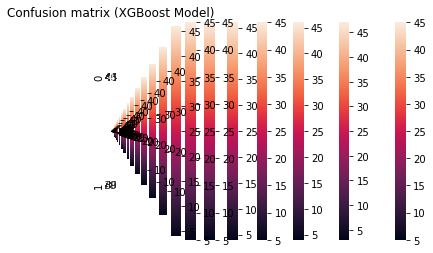

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import optuna
import shap
import xgboost as xgb

# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50


for i in range(n_iterations):
    # Step 2: Initial sampling
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])

    # Test data
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # Train data
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train = remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    # Modelling 
    # Creating and running our optimization
    study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")
    with parallel_backend('threading'):
        study_xgb.optimize(objective_xgb, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_xgb.best_trial.number)
    print("Best accuracy:", study_xgb.best_trial.value)
    print("Best hyperparameters:", study_xgb.best_params)

    # Train the best model
    best_param_xgb = study_xgb.best_params
    XGB = xgb.XGBClassifier(**best_param_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    XGB.fit(x_train_, y_train)
    y_pred_xgb = XGB.predict(x_test_)

    # Display results
    display_results(y_test, y_pred_xgb, cm_title="Confusion matrix (XGBoost Model)")

    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(XGB)
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 1 (assuming binary classification)
    shap_values_array = abs(shap_values)  # Use index 1 for the minority class

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

In [33]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [34]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('40_xg_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,1.003414,0.350402,0.764340,0.398728,0.757131,0.602743,0.344410,0.292979,0.564269
1,0.695255,0.224751,0.709469,0.663773,0.176456,0.374958,0.410702,0.360690,0.452007
2,0.626397,0.202796,0.574647,0.429585,0.499442,0.370504,0.463805,0.312612,0.434974
3,0.739162,0.373730,0.615468,0.382002,0.199934,0.419537,0.343492,0.207960,0.410161
4,0.717927,0.216182,0.607878,0.378180,0.346971,0.358907,0.395183,0.408764,0.428749
...,...,...,...,...,...,...,...,...,...
95,0.683204,0.391380,0.408156,0.401975,0.774495,0.317895,0.414523,0.429090,0.477590
96,0.937396,0.186437,0.644834,0.881274,0.248514,0.283907,0.889335,0.221725,0.536678
97,0.684652,0.201269,0.936701,0.656110,0.277532,0.427768,0.655016,0.211280,0.506291
98,0.544540,0.447780,0.507722,0.672785,0.190766,0.800384,0.459713,0.357593,0.497660
